# Testing code on simulated data.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner
import h5py
import tqdm

Combine isochrones.py with a gyro model to get ages.

In [102]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

def setup(obs, df, gyro_only=False, iso_only=False):
    
    # Set the initial values
    mass_init = df.mass
    age_init = 10**df.age
    feh_init = df.feh
    distance_init = 1./df.parallax
    Av_init = df.Av

    # sample in ln(mass), log10(age) and ln(distance).
    p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

    # Set up the StarModel object needed to calculate the likelihood. 
    param_dict = {"J": (obs.jmag, obs.jmag_err),
                  "H": (obs.hmag, obs.hmag_err),
                  "K": (obs.kmag, obs.kmag_err),
                  "teff": (obs.teff, obs.teff_err),
                  "logg": (obs.logg, obs.logg_err),
                  "feh": (obs.feh, obs.feh_err),
                  "parallax": (obs.parallax, obs.parallax_err)
                 }  # Isochrones.py takes milliarcseconds

    mod = StarModel(mist, **param_dict)
    
    args = [mod, obs.prot, obs.prot_err, obs.BV, gyro_only, iso_only]
    
    return mod, param_dict, p_init, args

Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [57]:
def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [128]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    B = mist.mag["B"](*params)
    V = mist.mag["V"](*params)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        print(lnpr, lnparams)
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
#             print("iso lnlike = ", mod.lnlike(params))
#             print("gyro_lnlike = ", gyro_lnlike)
#             print("lnprior = ", lnpr)
            return mod.lnlike(params) + gyro_lnlike + lnpr

Run the MCMC.

In [73]:
def run_mcmc(obs, args, p_init, ndim=5, nwalkers=24):
    
    p0 = [p_init + np.random.randn(ndim)*1e-4 for k in range(nwalkers)]

    print("Burning in...")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
    p0, lnp, state = sampler.run_mcmc(p0, 5000)
        
    print("Production run...")
    sampler.reset()
    p0, lnp, state = sampler.run_mcmc(p0, 10000)
    
    return sampler


def make_plots(sampler, i, savedir):
    ndim = 5
    
    print("Plotting production chains...")
    for j in range(ndim):
        plt.subplot(ndim, 1, j+1)
        plt.plot(sampler.chain[:, :, j].T, "k", alpha=.1)
        plt.savefig("{0}/{1}_chains".format(savedir, i))
        plt.close()
    
    print("Making corner plot...")
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = (10**samples[:, 1])*1e-9
    
    labels = ["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]
    corner.corner(samples, labels=labels);
    plt.savefig("{0}/{1}_corner".format(savedir, i))
    plt.close()
    
    print("Plotting age posterior")
    age_gyr = samples[:, 1]
    plt.hist(age_gyr)
    plt.xlabel("Age [Gyr]")
    med, std = np.median(age_gyr), np.std(age_gyr)
    print("age = ", med, "+/-", std)
    plt.axvline(med, color="k")
    plt.axvline(med - std, color="k", linestyle="--")
    plt.axvline(med + std, color="k", linestyle="--")
    plt.savefig("{0}/{1}_marginal_age".format(savedir, i))
    plt.close()
    print("age = ", med)

Load the simulated data file.

In [97]:
df = pd.read_csv("simulated_data.csv")

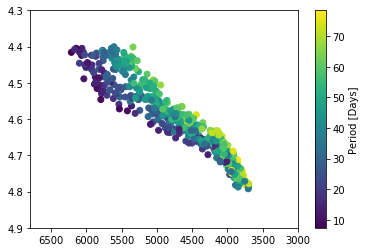

In [21]:
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(4.9, 4.3)
plt.xlim(6800, 3000)
plt.colorbar(label="Period [Days]")

Perturb the true parameters with some amount of noise.

In [28]:
teff_err = 1  # Kelvin
logg_err = .001  # dex
feh_err = .001  # dex
jmag_err = .001 # mags
hmag_err = .001  # mags
kmag_err = .001  # mags
parallax_err = .00001  # milliarcseconds
prot_err = .01  # Days
BV_err = .001  # mags

teff = df.teff.values + np.random.randn()*teff_err
logg = df.logg.values + np.random.randn()*logg_err
feh = df.feh.values + np.random.randn()*feh_err
jmag = df.J.values + np.random.randn()*jmag_err
hmag = df.H.values + np.random.randn()*hmag_err
kmag = df.K.values + np.random.randn()*kmag_err
parallax = df.parallax.values + np.random.randn()*parallax_err
prot = df.prot.values + np.random.randn()*prot_err
BV = df.B_V.values + np.random.randn()*BV_err

Create a dataframe from the observed data.

In [36]:
obs = pd.DataFrame(dict({"teff": teff, "teff_err": teff_err,
                         "logg": logg, "logg_err": logg_err,
                         "feh": feh, "feh_err": feh_err, 
                         "jmag": jmag, "jmag_err": jmag_err,
                         "hmag": hmag, "hmag_err": hmag_err,
                         "kmag": kmag, "kmag_err": kmag_err,
                         "parallax": parallax, "parallax_err": parallax_err, 
                         "prot": prot, "prot_err": prot_err,
                         "BV": BV, "BV_err": BV_err}))

In [124]:
mod, param_dict, p_init, args = setup(obs.iloc[0], df.iloc[0], gyro_only=False, iso_only=False)
print(lnprob(p_init, *args))
print(lnprob(p_init + (np.random.randn(5)*.01), *args))

iso lnlike =  -6167772614323538.0
gyro_lnlike =  -0.22855315586224292
lnprior =  -20.12418550714774
-6167772614323558.0
iso lnlike =  -6001026630454266.0
gyro_lnlike =  -2284.5429452615604
lnprior =  -20.12446237510979
-6001026630456571.0


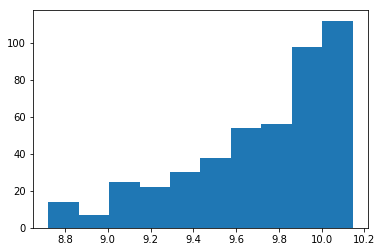

In [101]:
plt.hist(df.age);

Loop over stars.

In [129]:
gyro_only, iso_only = False, False

N = len(df)
for i in tqdm.tqdm(range(N)):
    print(i, "of", N)
    
    mod, param_dict, p_init, args = setup(obs.iloc[i], df.iloc[i], gyro_only=gyro_only, iso_only=iso_only)
    sampler = run_mcmc(obs.iloc[i], args, p_init)
    
    savedir = "simulation_results/iso_and_gyro"
    
    # Make the plots
    make_plots(sampler, i, savedir)
    
    # Save the samples
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = 10**samples[:, 1]*1e-9
    
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, i), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples
    assert 0




  0%|          | 0/456 [00:00<?, ?it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


0 of 456
Burning in...
-inf [-0.20522062 10.1516516  -0.15278662  0.15838325 -0.05417488]
-inf [-0.20119347 10.15537598 -0.15104911  0.1580726  -0.04930365]
-inf [-0.22306167 10.15230953 -0.14696375  0.04841533  0.14645684]
-inf [-0.19345269 10.14189834 -0.19453052  0.20628475 -0.11903776]
-inf [-0.14743199 10.18481946 -0.14774113  0.23486488 -0.16988272]
-inf [-0.21432509 10.1580068  -0.14806981  0.0758226   0.11973441]
-inf [-0.18961481 10.16320174 -0.14999891  0.18485486 -0.08267644]
-inf [-0.18554787 10.18158733 -0.1370744   0.08419224  0.10803026]
-inf [-0.17444385 10.17405377 -0.1459948   0.20558693 -0.11352064]
-inf [-0.17137964 10.16914571 -0.15016299  0.03505925  0.1195509 ]
-inf [-0.14665883 10.17310166 -0.18846793  0.26071398 -0.18616765]
-inf [ 0.07127294 10.2039448  -0.11254135 -0.36488264  0.02856797]
-inf [-0.07769836 10.2018627  -0.12189426 -0.04166816  0.03443807]
-inf [-0.20294151 10.14388555 -0.18293064  0.17853738 -0.06525382]
-inf [-0.1864689  10.16566796 -0.148453

-inf [-1.37495189 10.08673399 -0.14128874  1.55267368  1.00610217]
-inf [-0.98236356 10.13064865 -0.05173959  0.65423221  1.08339822]
-inf [ 0.15869007 10.28266116 -0.04894146 -0.33891615 -0.0678815 ]
-inf [-2.72796152  9.46745614 -0.33312213  2.30844024  1.13887868]
-inf [-2.31342742  9.52299678 -0.52201156  2.10619599  1.23759082]
-inf [-1.72238854 10.04705276 -0.18569699  2.21213302  1.01366088]
-inf [-0.5287293  10.30284584 -0.21106044  1.2158211   0.42579568]
-inf [-1.6891876  10.12747203 -0.32188116  2.75181191  1.11849786]
-inf [-0.75939098 10.3611974  -0.06895496  1.25022797  0.91023159]
-inf [-2.7353336   9.41045203 -0.46935563  2.31896542  1.31440205]
-inf [-1.75349465 10.11115402 -0.15887043  2.40412653  1.09155821]
-inf [-1.74663314 10.17433054 -0.32651931  3.01979983  1.18615387]
-inf [-1.34014434 10.10472861 -0.13213089  1.51287417  1.02591562]
-inf [-2.58748604  9.58634891 -0.38433621  2.6528099   1.1085766 ]
-inf [-1.80196546  9.66653794 -0.42704934  1.51806544  1.00959

-inf [-1.17714837 10.58698879  0.06971838  2.30300234  1.33333388]
-inf [-1.52245611  9.99201252 -0.05217107  1.22995188  1.01025818]
-inf [-2.3325291   9.01541492 -1.29038224  3.43717769 -0.56568466]
-inf [-1.27219533 10.22289046 -0.22703228  1.91633219  1.24051809]
-inf [-1.77850212 10.28398525 -0.0987055   3.00386302  0.95814675]
-inf [-1.66110879e+00  1.01868161e+01  2.02736603e-03  2.01644704e+00
  1.12702707e+00]
-inf [-1.11115936 10.06097286 -0.70981522  3.25332608 -0.17859028]
-inf [-1.63556362 10.30158013 -0.4279193   3.76741071  0.93338373]
-inf [-2.12674084 10.13905832 -0.23311858  3.34325862  1.30940851]
-inf [-0.77174813 10.11352284 -0.95268356  3.75832479 -0.65162581]
-inf [-1.66695228 10.2272534  -0.41877448  3.45629751  1.01899139]
-inf [-1.78039091 10.15784392 -0.42911302  3.39146298  1.08364029]
-inf [-1.61510739  9.99088845 -0.23309879  1.86470731  1.05304232]
-inf [-1.42418087 10.33255803 -0.03554913  2.40992019  0.84832504]
-inf [-1.26706072 10.23012989 -0.21103422

/Users/ruthangus/projects/habitablezoning/code/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


-inf [-1.74842729 10.19318127 -0.61081088  3.93427608  1.08612648]
-inf [-2.18598088  9.89756881 -1.14057318  6.0545956  -0.27424933]
-inf [-2.34429883 10.06608971 -0.46217208  3.97345225  1.77029406]
-inf [-2.48272497 10.14774298 -0.20758979  4.04926671  1.13532541]
-inf [-1.74784731 10.2538696  -0.52413849  3.86540655  1.18738241]
-inf [-1.96444975  9.71027608 -1.09409253  4.55676332 -0.01597544]
-inf [-1.79683734 10.26807342 -0.41940177  3.6081919   1.37352975]
-inf [-2.47286031  9.82000915 -0.60191169  3.91038253  1.15925735]
-inf [-1.68261095 10.01830819 -0.58610349  3.81417293 -0.10334502]
-inf [-2.03465094 10.11956295 -0.46904831  3.97229494  1.03953966]
-inf [-1.5827173  10.31160846 -0.69716724  4.33853072  1.09538663]
-inf [-2.31303959 10.01958074 -0.43740458  3.85279154  1.26845185]
-inf [-2.39259275  9.93712761 -0.55651299  4.10894689  1.09494294]
-inf [-1.7742168  10.17284333 -0.48294422  3.85863946  0.65746033]
-inf [-1.60664739 10.04064623 -0.59862727  3.8325336  -0.17903

-inf [-2.24292419 10.16422404 -0.63098415  5.23388134  0.55662987]
-inf [-1.80064021 10.19275496 -0.90372812  5.50606371  0.22490556]
-inf [-1.63706649  9.62968058 -1.76983069  5.83712313 -0.27292154]
-inf [-2.1720835   9.94284808 -1.00451221  5.74118696 -0.05216411]
-inf [-1.91478873  9.78099019 -1.24489579  5.15199684 -0.02875831]
-inf [-2.48208216 10.22016268 -0.37774405  5.31142559  0.46931337]
-inf [-1.94389717 10.05084135 -0.9802554   5.7595184  -0.12680537]
-inf [-2.25261744 10.15596264 -0.69475169  5.47408259  0.42353936]
-inf [-1.92949908 10.15567226 -0.71835883  5.01108991  0.32233861]
-inf [-2.27189384 10.15495449 -0.82270157  6.09930523  0.05133392]
-inf [-1.34581354 10.15649616 -1.19068282  5.40463403  0.04007222]
-inf [-1.90764472 10.09612768 -0.92501562  5.63687289 -0.04336496]
-inf [-1.70971311 10.15987259 -0.79399134  4.79865907  0.2935795 ]
-inf [-1.81674606 10.15405546 -0.88814772  5.32024076  0.2411099 ]
-inf [-1.8051731   9.70735193 -1.47724472  5.52553736 -0.04526

-inf [-2.06376872 10.09580152 -0.99683249  5.97138036  0.17913748]
-inf [-2.26284835 10.15700471 -0.736966    5.67684713  0.14243038]
-inf [-2.26473993 10.09438877 -0.85080492  5.92422862  0.02720692]
-inf [-2.14730996 10.14653972 -0.867436    5.89784651  0.13164178]
-inf [-2.13525384 10.00808668 -0.98097156  5.77830906 -0.02383847]
-inf [-2.0897121  10.10167522 -0.92880701  5.89721838  0.13852385]
-inf [-2.30105729 10.0120249  -0.95120749  5.87853554  0.06775129]
-inf [-2.05365291e+00  9.76754159e+00 -1.37915855e+00  5.80648112e+00
 -1.95541289e-04]
-inf [-2.17776932 10.08726343 -0.92388055  5.8869586   0.08101285]
-inf [-2.22838711 10.17296665 -0.75967581  5.89036893  0.12439194]
-inf [-2.2354605  10.20543855 -0.75138496  5.97413792  0.09727463]
-inf [-2.06584961 10.1418039  -0.90777977  5.88432653  0.19211245]
-inf [-2.25346327 10.15120663 -0.77616144  5.89237213  0.09086592]
-inf [-2.22250258  9.91915114 -1.05475094  5.86065232 -0.02214123]
-inf [-2.11826536 10.0774008  -0.949971  

-inf [-2.30789064 10.06053991 -0.88435921  5.87482603  0.27498888]
-inf [-2.15464954 10.12318584 -0.89391512  5.88431997  0.14544632]
-inf [-2.27633543 10.02638185 -0.875439    5.87313226  0.06165475]
-inf [-2.22195981 10.09322469 -0.90274716  5.88274878  0.10228361]
-inf [-2.36839920e+00  1.00262411e+01 -8.90934764e-01  5.87860709e+00
  3.76816577e-03]
-inf [-2.32231011 10.05340765 -0.82289627  5.87555824  0.03358641]
-inf [-2.23501985  9.79842604 -1.20662872  5.86402203 -0.02395895]
-inf [-2.12392481 10.14425406 -0.86367295  5.88145121  0.18959856]
-inf [-2.12289107 10.2257237  -0.7414119   5.87513324  0.22550122]
-inf [-2.22171681 10.09501565 -0.88054037  5.87195163  0.09720975]
-inf [-2.15634643 10.10327671 -0.89404364  5.8727169   0.15410587]
-inf [-1.69374048 10.21050792 -0.93619085  5.88597222  0.05205056]
-inf [-2.23710691 10.12434023 -0.8283795   5.87183941  0.09769699]
-inf [-2.4444268  10.01249242 -0.88797413  5.87751269  0.05786774]
-inf [-2.45780573 10.11576639 -0.69580193

-inf [-1.46815554 10.13699249 -1.12716153  5.87282197  0.78762915]
-inf [-2.19700289 10.04466424 -0.99660008  5.87185545  0.10086679]
-inf [-1.88720312  9.98081202 -1.15506159  5.87196083  0.33645564]
-inf [-1.94852951 10.17875161 -0.88362707  5.8716402   0.35139023]
-inf [-2.28318566  9.92828599 -1.03501192  5.87227371  0.07240681]
-inf [-1.83171191 10.21208828 -0.83527453  5.87095878 -0.11810035]
-inf [-1.62652438 10.13907119 -1.05631617  5.87234494  0.63406861]
-inf [-2.38920344 10.03885263 -0.92082867  5.87181837 -0.08848286]
-inf [-2.42464978e+00  9.92092270e+00 -9.02027901e-01  5.87214471e+00
 -9.46071395e-03]
-inf [-1.83658438  9.94292668 -1.22902532  5.87183531  0.34637559]
-inf [-1.86097877 10.22748486 -0.86613804  5.87162343  0.43955733]
-inf [-2.24946564  9.94339086 -1.03747162  5.87149153 -0.0355473 ]
-inf [-2.21995469 10.08216478 -0.87955712  5.87182107  0.10032379]
-inf [-1.97498017  9.8963981  -1.28990753  5.87202643  0.3103324 ]
-inf [-1.82313368 10.11657009 -0.95124271

-inf [-1.3056739   9.83294936 -1.45108622  5.87209771  0.98634067]
-inf [-1.30429547  9.66277885 -1.6324085   5.87227652  1.02033274]
-inf [-1.4740532   9.89143568 -1.42902928  5.87187599  0.69708306]
-inf [-0.83048159 10.14030823 -1.48322962  5.8712135   1.03746088]
-inf [-0.7428818  10.0066382  -1.90632175  5.86994924  1.0313784 ]
-inf [-1.2414143  10.03644138 -1.26285947  5.87192923  0.71719097]
-inf [-0.82309896  9.87314013 -0.348706    5.87136636  1.25751153]
-inf [-1.2637481  10.06752229 -1.17902326  5.87188228  0.69185387]
-inf [-1.44102501  9.88236465 -1.44553664  5.87182095  0.73584867]
-inf [-0.64119846 10.20633449 -1.48649678  5.87107617  1.09206991]
-inf [-1.02823177 10.16622618 -1.05102549  5.87156129  0.86961037]
-inf [-1.6756241   9.82585959 -1.81869217  5.87214347  0.57318524]
-inf [-1.15778855  8.77867674 -3.32281007  5.87099823  1.11696594]
-inf [-0.89802483 10.20816899 -1.26685039  5.87194506  1.00125461]
-inf [-1.09750774  9.92623668 -0.97576071  5.87127839  1.05157

-inf [-0.84023666 10.1381554  -1.1633592   5.87184504  1.01223299]
-inf [-0.96327402  9.96778693 -1.58733793  5.87136093  1.01522669]
-inf [-1.05576404 10.00424949 -1.99977765  5.87189261  0.75651572]
-inf [-1.00251223 10.10391552 -1.41638475  5.87205096  0.92273789]
-inf [-0.28452717  9.86919712 -1.79360182  5.87078964  1.05286115]
-inf [-0.67691372 10.33773087 -1.28244556  5.87091998  1.0247624 ]
-inf [-0.79318664 10.15274595 -1.62702223  5.87121778  0.87068234]
-inf [-0.86829893 10.21932079 -0.82727389  5.87160043  0.94564393]
-inf [-1.14095373  9.939982   -1.33341516  5.87191966  0.76599112]
-inf [-1.07376178  9.89035135 -1.56921031  5.87182683  0.95725487]
-inf [-1.20560352  9.9253612  -1.26654631  5.87231315  0.62518151]
-inf [-1.02920645 10.1074962  -0.89406314  5.8726335   1.0091536 ]
-inf [-1.2028188  10.15455538 -0.72816839  5.87308887  1.00587541]
-inf [-1.41478103 10.09823451 -0.38723992  5.8729689   0.98473994]
-inf [-1.61366261  9.53234519 -1.31513456  5.8733586   0.88854

-inf [-0.45608897 10.3732357  -1.00226117  5.87106962  0.82256523]
-inf [-0.67238962  9.93119758 -0.7306467   5.87220013  1.01225363]
-inf [-0.85596339 10.14467149 -1.60024129  5.87192847  0.97040535]
-inf [ 0.41820257  7.57326855 -3.50875271  5.87180977  0.81793205]
-inf [-0.61898699 10.13083747 -1.16768896  5.87209976  0.93671468]
-inf [-0.82871226 10.19176677 -1.39165976  5.8720218   0.96961771]
-inf [-0.87393129 10.13563252 -1.59798584  5.87195356  0.95893818]
-inf [-0.60281826  9.95765343 -1.37899509  5.87197949  0.96747821]
-inf [-0.92927224 10.11242568 -1.3241897   5.87189534  0.93301941]
-inf [ 0.59958403  7.36912501 -3.58531432  5.87167921  0.81474082]
-inf [-0.67979671 10.04417848 -1.38406204  5.87186565  0.95065335]
-inf [-0.8825834  10.08285387 -1.77373998  5.87216425  1.00135448]
-inf [ 0.3448666   9.6470433  -2.70630434  5.86983648  1.00521879]
-inf [-0.73527658  9.88111815 -1.05743113  5.87235276  0.95620076]
-inf [-0.04467296 10.28760821  0.19533122  5.8686609   0.84410

-inf [-0.30348893 10.63677377 -1.78418818  5.87012356  1.04441193]
-inf [-0.4317489  10.9334065  -1.65991106  5.87161888  0.91740024]
-inf [ 0.12732036  7.71399162 -3.06633588  5.87277515  0.82581003]
-inf [ 0.50658566  7.40701673 -3.37938392  5.87122054  0.89378392]
-inf [-0.31362976 10.24654946 -1.37633636  5.8704805   1.01154507]
-inf [ 0.21708915  7.54745098 -1.38584987  5.87132442  0.77858129]
-inf [ 0.09672556  8.24883709 -3.02084218  5.87212752  0.87134984]
-inf [ 0.36103182  7.91022026 -1.90676995  5.8708407   0.79283609]
-inf [-0.09605567 10.30953085 -0.88507944  5.87021353  0.93566161]
-inf [-0.45085883 11.48978909 -1.42800861  5.87035689  1.05220862]
-inf [ 0.37213835  7.34246855 -3.66863227  5.87217641  0.82254779]
-inf [-0.34024766 10.87299539 -0.90153944  5.86943366  1.04721919]
-inf [-0.15798678 10.77707198 -2.36935627  5.86808411  1.01002115]
-inf [-0.29568526 10.21100927 -2.46265481  5.87176333  0.94170733]
-inf [-0.27612967 10.36985172 -1.51378454  5.87028169  0.99437

-inf [-0.63227282 10.58113891 -5.40579724  5.87090833  1.20806039]
-inf [ 0.68447427  6.26910152 -4.4660288   5.87230098  0.79208715]
-inf [ 0.33101517  7.72310506 -3.7605445   5.87196913  0.86019187]
-inf [-0.14643513  9.72940674 -2.31953812  5.8719519   0.88349824]
-inf [-0.13582763  7.45144865 -4.57295729  5.87231128  0.99877076]
-inf [ 0.34224057  7.22712914 -2.61007137  5.87195266  0.82130231]
-inf [-0.52112538 10.98481187 -1.17410874  5.87009616  1.05367137]
-inf [ 0.74010156  6.74366587 -3.18339799  5.87245177  0.68062708]
-inf [ 0.50705413  6.99457091 -3.88957248  5.87197024  0.82879407]
-inf [ 0.2793957   7.80637181 -3.10944811  5.87183926  0.8553112 ]
-inf [-1.00080755 11.83313051 -2.28637142  5.86987399  1.32283925]
-inf [ 0.04631428  7.88494577 -4.2095805   5.87209929  0.96028469]
-inf [-0.28902564 10.23060326 -1.67075274  5.87022877  1.02740363]
-inf [-0.01954764  7.88953364 -3.91279056  5.87194574  0.97781114]
-inf [ 0.29735581  7.31344505 -2.70355184  5.87202439  0.79659

-inf [ 0.37547228  8.95167433 -2.55637055  5.87203147  0.70837489]
-inf [-0.62981309 10.64396957 -1.50005376  5.87021502  1.12532521]
-inf [ 0.8547663   8.60673415 -2.51619644  5.87231644  0.68968877]
-inf [ 0.97209514  7.95233074 -1.7525828   5.87128034  0.57781136]
-inf [-0.38479086 10.33756228 -1.82228945  5.87045316  1.0464454 ]
-inf [-0.26209425  9.76289481 -2.74469635  5.87092033  1.07061686]
-inf [ 0.52491049  8.74582229 -2.59111331  5.87225148  0.62291727]
-inf [ 0.2199112   7.58257051 -2.92283628  5.8718341   0.82340724]
-inf [ 0.22791116  9.43000964 -0.89425562  5.87208883  0.66371337]
-inf [-0.22602427 10.06228986 -1.65677186  5.87031906  1.00075582]
-inf [-0.32702282 10.20342498 -1.48211225  5.87053492  1.01408779]
-inf [-0.3652106  10.39605682 -2.61506375  5.87079941  1.04582656]
-inf [0.79699181 8.46002521 0.33638218 5.87214124 0.3111648 ]
-inf [1.23275201 7.79072967 0.08447288 5.87175558 0.38459448]
-inf [ 1.57101525  7.48770621 -0.43432378  5.8715907   0.2825319 ]
-inf 

-inf [2.13174667 7.51116235 0.98858341 5.8709331  0.09113968]
-inf [1.39009958 7.79453911 0.6715962  5.87147537 0.32154226]
-inf [-0.46528477 10.27431258 -2.13842525  5.87054829  1.06499643]
-inf [-0.57868564 10.25378267 -2.45842566  5.87051593  1.04618646]
-inf [1.89433849 7.0392572  0.24780063 5.87169715 0.16296982]
-inf [-0.53191851 10.26763794 -2.97750833  5.87063224  1.09723148]
-inf [-0.30869024 10.0940526  -2.28416831  5.87066748  1.02111411]
-inf [ 1.97249366  7.09093805  1.51821864  5.87169525 -0.01352533]
-inf [ 0.58875131  8.9838405  -1.69703912  5.87185948  0.6945102 ]
-inf [1.49010602 7.9072924  1.02035553 5.87190542 0.26032378]
-inf [2.02967831 6.84190821 0.47515419 5.87155789 0.10942264]
-inf [ 1.85397486  7.4665629  -0.77279407  5.8722849   0.20577643]
-inf [ 1.28938854  7.93379942 -0.15301342  5.87159743  0.38900679]
-inf [-0.58262035 10.57203867 -0.51346067  5.87012564  1.05919062]
-inf [ 1.66656393  7.81096855 -0.34506965  5.87188651  0.21519694]
-inf [1.06976044 7.9

-inf [2.14485329 7.68190344 1.63935086 5.86999901 0.07926446]
-inf [1.55613813 7.94591364 0.84962127 5.87149344 0.24311415]
-inf [-0.7523396  10.52056246 -2.86542103  5.87075397  1.18419882]
-inf [ 1.77643298  7.70517153 -0.61978638  5.87210724  0.2047485 ]
-inf [1.70843459 7.69806081 1.0401273  5.87154091 0.19950739]
-inf [1.28488264 8.02406988 0.16461328 5.8726629  0.3853371 ]
-inf [1.55421458 7.6673623  0.61935741 5.87133234 0.2283604 ]
-inf [ 1.92345778  7.58913534 -0.3544058   5.87221336  0.10870138]
-inf [1.55367135 7.91892516 0.60338349 5.87167852 0.24430464]
-inf [ 0.59567449  8.9766103  -1.68150629  5.8718511   0.69127884]
-inf [2.0220671  7.55234994 0.91738366 5.87133157 0.1070911 ]
-inf [1.60759663 7.77051518 0.50422042 5.87200497 0.29127792]
-inf [1.62566375 7.97041001 0.44782712 5.87206841 0.17554074]
-inf [2.23984263e+00 7.12926774e+00 1.21735032e+00 5.87201152e+00
 3.09441547e-03]
-inf [-1.19096359 10.9217024  -3.43248627  5.8704961   1.32823479]
-inf [ 1.73997046  7.795

-inf [ 1.43297757  8.09865364 -0.77639126  5.87197343  0.33341098]
-inf [ 1.47256343  8.02950465 -1.02859853  5.87199355  0.35606451]
-inf [-0.40390649 10.16947609 -1.42876445  5.87058614  0.97911579]
-inf [2.07110404 7.53114481 1.81714737 5.87199467 0.02102996]
-inf [2.20183325 7.4793152  0.7802084  5.87043124 0.09751117]
-inf [2.04877533 7.52013711 1.64387976 5.87176716 0.02819104]
-inf [ 1.65689535  7.90923544 -0.1984902   5.87145295  0.21575868]
-inf [1.65459012 7.89068912 1.05476481 5.87169415 0.19693776]
-inf [1.55000331 7.97888046 0.38862874 5.87181688 0.23475045]
-inf [ 1.46292047  8.05453534 -0.94234187  5.87193808  0.36086446]
-inf [1.79184237 7.68109722 1.16953148 5.87184591 0.12742788]
-inf [ 1.29906886  8.2512164  -0.3169275   5.87229578  0.2548452 ]
-inf [ 0.88454559  8.45203678 -2.35347677  5.87186953  0.59813797]
-inf [2.02375096 7.81885566 1.93107782 5.86974248 0.1270438 ]
-inf [1.48572943 8.03790106 0.58330338 5.87184938 0.26605833]
-inf [-0.45612156 10.18392025 -3.13

-inf [1.93308223 7.60525687 0.41953063 5.8719644  0.09209   ]
-inf [2.21254774 7.38092657 0.81415639 5.87117381 0.0610735 ]
-inf [1.8444945  7.61364811 0.82395304 5.87202155 0.14852071]
-inf [ 1.73189143  7.72411627 -0.83857224  5.8725203   0.25164839]
-inf [ 1.1941512   8.30000758 -1.23499262  5.87181848  0.49604991]
-inf [ 2.58118897  6.99501782  0.88390305  5.87228962 -0.12336843]
-inf [1.98547404 7.66423049 1.01565076 5.87115752 0.11877397]
-inf [-0.56288937 10.25598547 -3.28140218  5.87087036  1.16416821]
-inf [1.99861137 7.47482729 0.28277401 5.87198004 0.11165904]
-inf [ 1.37406223  8.1475244  -1.20854349  5.8719649   0.40454065]
-inf [1.9790331  7.61449331 1.45248052 5.8720047  0.05899658]
-inf [1.68523758 7.9316319  0.05012822 5.8718101  0.21268592]
-inf [-0.81612158 10.51386087 -3.72164695  5.87079184  1.27276381]
-inf [1.73937653 7.71797751 1.1001793  5.87205837 0.14300885]
-inf [ 0.69684145  8.77181739 -2.51977583  5.87218205  0.63722969]
-inf [-0.37794563 10.09495317 -2.16

-inf [ 2.25709221  7.23734896  0.22508347  5.87200846 -0.01507928]
-inf [1.66961346 7.97632832 0.51282254 5.87178779 0.1932722 ]
-inf [-1.09302391 10.81581725 -4.0413463   5.87061762  1.38381855]
-inf [ 1.40317596  8.08826119 -1.28304579  5.87229637  0.33607507]
-inf [1.81782469 7.80486015 0.70280126 5.87169603 0.14937957]
-inf [2.00971876 7.52167406 0.54717472 5.87212054 0.05879944]
-inf [ 1.52404688  8.04603352 -0.1227987   5.87184887  0.2671527 ]
-inf [1.68685702 7.98788685 0.96332067 5.87177656 0.17640444]
-inf [-0.24209179  9.91575706 -3.0753756   5.87117235  1.04247725]
-inf [ 1.86419829  7.65152684 -0.08782218  5.87217506  0.14463171]
-inf [ 1.84226709  7.67057032 -0.73171618  5.87215402  0.15242615]
-inf [-0.94112649 10.65869584 -3.79378145  5.8706739   1.31940156]
-inf [1.78498072 7.85529567 0.99531572 5.8718845  0.1276787 ]
-inf [1.6716514  7.97283114 0.72187371 5.87175977 0.27005867]
-inf [1.62206802 7.9799934  0.37003602 5.87168793 0.21706074]
-inf [ 1.29478337  8.28161184 

-inf [1.8111958  7.7754302  0.60700012 5.87157224 0.14662462]
-inf [ 1.95648309  7.53176185 -0.81665815  5.87229064  0.1096593 ]
-inf [ 1.66303413  7.81827625 -0.63934686  5.87203094  0.24269843]
-inf [ 1.53561034  8.0971642  -0.58023543  5.87190152 -0.05026896]
-inf [ 1.38817518  8.11672148 -1.07796716  5.87185462  0.36512742]
-inf [ 2.35759951  7.23869269  1.8443293   5.87214258 -0.11901697]
-inf [ 2.25626333  7.39624037  0.99326354  5.87228025 -0.40909703]
-inf [ 1.61012411  7.98472966 -0.02857764  5.87168579  0.25290624]
-inf [-0.35331084 10.07435217 -2.72662599  5.87088161  1.06538973]
-inf [ 1.52017414  8.10467659 -0.3049436   5.87184744  0.04103677]
-inf [1.82266842 7.78571643 0.57052078 5.87189257 0.11184701]
-inf [-0.30398141 10.00120045 -2.80758684  5.87086074  1.05707849]
-inf [ 1.58275112  8.02330377 -0.24174648  5.87182378  0.21879025]
-inf [ 1.65659004  7.89057479 -0.41525567  5.87174355  0.23339565]
-inf [ 1.50195344  8.12082288 -0.05329144  5.87183249  0.27657106]
-inf 

-inf [-0.81121429 10.57004767 -3.37137275  5.87070261  1.25517693]
-inf [ 1.4949495   8.07996928 -0.52892198  5.87186323  0.12550637]
-inf [ 1.51130078  8.11528623 -0.24847271  5.87181404  0.0729429 ]
-inf [ 1.1045601   8.43161016 -1.48969985  5.87184583  0.47311925]
-inf [ 1.74004854  7.91663865  0.22690837  5.87193606 -0.18805499]
-inf [-0.95320798 10.64278754 -3.99820536  5.87061273  1.36504145]
-inf [ 1.14306811  8.45027946 -0.85248765  5.87188904  0.41255786]
-inf [2.00205985 7.60749229 1.22431052 5.87197221 0.03859521]
-inf [1.69488038 7.95895306 0.70625253 5.87145096 0.19816027]
-inf [-0.91140215 10.63765226 -3.65083279  5.87056168  1.32736933]
-inf [ 1.13116936  8.46259934 -0.90038357  5.8719409   0.41312532]
-inf [1.73903507 7.88635945 0.57438869 5.87166684 0.18279284]
-inf [ 1.52544305  8.07973904 -0.48424024  5.87186153  0.00821043]
-inf [ 1.1414637   8.40321195 -1.31967829  5.8718354   0.45330352]
-inf [ 1.76084466  7.79219386 -0.55999468  5.87195536  0.16118208]
-inf [-0.5

-inf [ 1.57959804  7.98969521 -0.4878325   5.87187878  0.26636083]
-inf [1.75345952 7.90252134 1.50761035 5.87165119 0.15666239]
-inf [-0.02851389  9.59677824 -2.73356413  5.87084325  1.08946076]
-inf [-0.40233093 10.10497225 -2.73936194  5.87078275  1.16879599]
-inf [ 1.60178698  8.02171413 -0.01467632  5.87191271  0.05423286]
-inf [1.62516034 7.99690648 1.11138031 5.87159882 0.23376048]
-inf [1.75505117 7.80777774 0.13128594 5.87180254 0.13076762]
-inf [1.62164614 8.06238594 0.62935028 5.8718173  0.17137307]
-inf [-0.94012318 10.73748837 -2.83341598  5.87044532  1.29987092]
-inf [ 1.13885108  8.35489678 -1.58630234  5.8719528   0.48218406]
-inf [1.66314456 7.95951642 0.19332322 5.87171663 0.17589618]
-inf [ 1.55181859  8.09355368 -0.12706646  5.87185915 -0.06788229]
-inf [-0.15322489  9.71693952 -2.93531426  5.87076471  1.17110489]
-inf [1.63812976 8.04802534 0.66794163 5.87182989 0.16234339]
-inf [-0.19692548  9.89618341 -2.56381176  5.87097396  1.00491632]
-inf [ 1.09955957  8.4896

-inf [-0.61128242 10.35756484 -2.83357754  5.87074309  1.17179267]
-inf [ 1.42138279  8.16930196 -0.31320475  5.87188471  0.30886292]
-inf [ 0.97732001  8.57224179 -1.39336277  5.8719329   0.4860263 ]
-inf [ 1.47530606  8.11371163 -0.09983636  5.87184927  0.2839474 ]
-inf [ 1.56502315  8.0688275  -0.27563442  5.87196611 -0.06002037]
-inf [ 1.24315638  8.3459116  -0.36446487  5.87184763  0.38084167]
-inf [ 1.55707035  8.07545813 -0.27215572  5.87194503 -0.04034537]
-inf [-0.29272106  9.8515631  -3.16243657  5.87067713  1.26115764]
-inf [ 1.66724744  7.95693938 -0.34596426  5.87193272 -0.11883398]
-inf [-0.58424935 10.30523159 -3.17539391  5.87085856  1.17046252]
-inf [ 1.47817981  8.10093975 -0.51184122  5.87183983  0.14721306]
-inf [1.68123744 7.92223132 0.87525546 5.87186614 0.2036755 ]
-inf [ 1.73946072  7.92167599  0.19908625  5.87198673 -0.21469531]
-inf [ 1.71266863  7.96309497  0.20752468  5.87190978 -0.18368154]
-inf [ 1.1823452   8.34798313 -1.25127269  5.87197589  0.42398973]


-inf [ 1.52789123  8.05413443 -0.44118484  5.87185024  0.2819998 ]
-inf [ 1.75846617  7.92587953  0.51416362  5.87180307 -0.19402468]
-inf [ 1.61566930e+00  8.00625277e+00 -5.48799799e-03  5.87192422e+00
  5.22471354e-02]
-inf [1.57033821 8.05076112 0.10606085 5.87183046 0.17105736]
-inf [ 1.52686088  8.10275782 -0.51444479  5.87187796 -0.01076431]
-inf [2.21227180e+00 7.28610457e+00 1.77289703e-01 5.87198869e+00
 3.46644306e-03]
-inf [ 1.52259402  8.10588494 -0.46053015  5.871864    0.00899049]
-inf [-0.6466235  10.35153773 -3.27405128  5.87070354  1.24133384]
-inf [ 1.2123826   8.37026702 -0.66516536  5.87183346  0.39007645]
-inf [2.14680237e+00 7.37225843e+00 7.14479386e-01 5.87220500e+00
 6.92050054e-04]
-inf [ 1.6252627   8.02414054 -0.02918231  5.87183515 -0.04711757]
-inf [-0.56702003 10.26945268 -3.14834074  5.87074108  1.20282921]
-inf [ 1.5174919   8.0926763  -0.16497466  5.871821    0.12704074]
-inf [ 1.80650359  7.8325922   0.19929766  5.8720056  -0.14987519]
-inf [-0.27268

-inf [ 1.09945196  8.48272437 -0.89112591  5.87183345  0.43709337]
-inf [ 1.60219167  7.96063467 -0.03088664  5.87189825  0.23413982]
-inf [ 1.4727207   8.08688613 -0.7532681   5.87187727  0.30687556]
-inf [1.67272756 7.99338428 0.75009242 5.87157476 0.22383351]
-inf [1.62518483 7.99377257 0.06655475 5.87176864 0.09800886]
-inf [ 1.62489841  8.01070711 -0.08596527  5.87182948 -0.02929026]
-inf [ 1.45920607  8.11300785 -0.63051775  5.87182218  0.31080147]
-inf [-0.74524386 10.47525599 -3.4296033   5.8708106   1.23927323]
-inf [1.64400539 7.97861372 0.99026286 5.87169755 0.22052828]
-inf [ 1.56138074  8.07274921 -0.15495599  5.87181896  0.02089498]
-inf [2.20979004e+00 7.28878999e+00 1.74335852e-01 5.87198745e+00
 4.50451349e-03]
-inf [ 1.55452386  8.03396082 -0.39694117  5.87184908  0.29867983]
-inf [ 1.0365418   8.52564977 -1.19243859  5.87187603  0.46375707]
-inf [ 1.53889164  8.09088214 -0.25789543  5.87187588 -0.03471685]
-inf [1.67426358 7.98846153 0.57744423 5.87179747 0.09916634]

-inf [ 1.30671543  8.22246409 -1.59106421  5.87183859  0.39809994]
-inf [ 1.62731769  7.92240581 -0.44659305  5.87173066  0.24550469]
-inf [1.61936424 7.96279837 0.84339161 5.87187019 0.22546521]
-inf [ 1.59681134  8.0259363  -0.08558351  5.87181431  0.07566438]
-inf [ 1.51648476  8.12118813 -0.85087394  5.8718986  -0.09258202]
-inf [ 1.73047552  7.90153917 -0.11639697  5.87194819 -0.10075106]
-inf [ 1.73632824  7.91486536 -0.02579915  5.8719006  -0.13184415]
-inf [ 1.25238866  8.30159376 -0.8822973   5.87188338  0.37935213]
-inf [ 1.57927876  8.06605492 -0.01974713  5.87180268 -0.04396034]
-inf [ 1.49373246  8.12917592 -0.25897678  5.87181783  0.09130175]
-inf [1.69654625 7.96288257 1.88974204 5.87166516 0.17532928]
-inf [ 2.24826329  7.34642149  0.71466924  5.87220096 -0.33655201]
-inf [ 1.55734076  8.02140607 -0.4423953   5.87188779  0.27054731]
-inf [ 1.66695866  7.97146226 -0.11044641  5.87184934 -0.07121908]
-inf [-0.86818647 10.65847418 -2.7679006   5.8704847   1.27031786]
-inf 

-inf [ 1.74175061  7.92678326  0.17199922  5.87186205 -0.20104038]
-inf [1.61836982 8.05252754 0.51990939 5.87189469 0.01134656]
-inf [ 1.68726895  7.96444614 -0.0658659   5.87180924 -0.11155053]
-inf [ 1.55980635  8.05013595 -0.12560724  5.87189521  0.08059035]
-inf [1.78490663 7.92346829 1.20689896 5.87189964 0.00834544]
-inf [ 1.51107855  8.072819   -0.4404938   5.8718288   0.288538  ]
-inf [-0.19657476  9.90129634 -2.48384254  5.87092305  1.01310916]
-inf [1.58477547 8.12328353 0.50991017 5.87187511 0.0249842 ]
-inf [ 1.64962082  7.9876034  -0.13230032  5.87179898 -0.04629284]
-inf [-0.66626469 10.45279284 -2.71996631  5.87055149  1.19065993]
-inf [ 1.57636917  8.04831588 -0.20396475  5.87187273  0.01998392]
-inf [ 2.36385899  7.17411401  1.04793975  5.87231067 -0.10695658]
-inf [ 1.69387771  8.01880514  0.95857114  5.87184062 -0.01599106]
-inf [ 1.65956506e+00  7.98571374e+00  7.55242665e-03  5.87179643e+00
 -3.23133968e-02]
-inf [ 1.59098188  8.01915587 -0.08996903  5.87193546  0

-inf [ 1.72092956  7.92247368 -0.07213941  5.87181562 -0.12758423]
-inf [ 1.55948773  8.07275845 -0.15642176  5.8718425   0.02003943]
-inf [ 1.76897726  7.87798573 -0.01718783  5.87191708 -0.19233965]
-inf [-0.80481614 10.51685999 -3.58111886  5.87072628  1.26092232]
-inf [ 1.55941306  8.06400153 -0.20806143  5.87184596  0.04847845]
-inf [ 1.92312268  7.80134524  1.22984552  5.87186336 -0.20058575]
-inf [ 1.47366594  8.12763959 -0.3159562   5.871822    0.1574796 ]
-inf [1.70154684 7.91628485 0.90767089 5.8717261  0.13212177]
-inf [ 1.5151559   8.01510656 -1.03032235  5.87187945  0.30254776]
-inf [ 1.60858685  8.02458325 -0.02874775  5.87182549  0.02406054]
-inf [ 1.53298722  8.09756111 -0.24582321  5.87182596  0.03797481]
-inf [ 1.4628555   8.1058444  -0.66464772  5.87183647  0.30922819]
-inf [ 1.7348713   7.92422145 -0.02624115  5.87183457 -0.17894528]
-inf [1.6660599  7.95807076 0.8277504  5.871817   0.16667129]
-inf [ 1.10010599  8.48215442 -0.88964805  5.87183267  0.4368728 ]
-inf 

-inf [-1.14667875 10.88384148 -3.73236436  5.87042176  1.54748113]
-inf [ 1.73694603  7.90442167  0.20363311  5.87190258 -0.05630802]
-inf [1.66720844 7.91634547 0.05975823 5.87177221 0.21320974]
-inf [ 1.69205766  8.00926294  0.77629569  5.87191525 -0.05820294]
-inf [-0.25248933  9.96126142 -2.55888851  5.87089789  1.0383988 ]
-inf [ 0.9517237   8.61760293 -1.20801873  5.8718437   0.49713899]
-inf [ 1.62062399  7.99497965 -0.21621439  5.87165335  0.0927296 ]
-inf [ 1.99339444  7.66792332  1.0492843   5.87203046 -0.15387679]
-inf [ 1.38032592  8.19817977 -0.40580256  5.87181721  0.3770396 ]
-inf [1.66184803 7.95487518 0.77696786 5.87172513 0.15419097]
-inf [ 1.626205    8.00962644 -0.08447245  5.87183074 -0.03166757]
-inf [ 1.78883713  7.93700672  1.12209373  5.87194301 -0.15353064]
-inf [ 1.60516591  8.03341517 -0.19828684  5.87178504 -0.01273237]
-inf [ 1.30951946  8.2150002  -1.66372581  5.87185506  0.39895587]
-inf [1.57097564 8.09992467 0.34458894 5.87181823 0.06497998]
-inf [ 1.6

-inf [ 1.89407536  7.76585165  0.41502849  5.87187199 -0.16325093]
-inf [ 1.51428758e+00  8.11698927e+00 -5.19636484e-01  5.87185427e+00
 -4.10145466e-03]
-inf [ 1.00991634  8.59939867 -0.71136384  5.87184864  0.46197123]
-inf [1.67420063 7.89499997 0.02702647 5.87176499 0.16697468]
-inf [ 1.61829396  8.0795505   0.682558    5.87184176 -0.01644799]
-inf [ 1.63787208e+00  7.99869670e+00 -6.25607000e-02  5.87180000e+00
  4.92781898e-03]
-inf [-0.7865578  10.52563591 -3.30118687  5.87065126  1.25387807]
-inf [1.79659558 7.83219736 1.27749807 5.8717685  0.17296944]
-inf [ 1.65317702  7.98942671 -0.08969334  5.87196189 -0.12236584]
-inf [1.82960033 7.72834295 0.23559682 5.87183493 0.09668883]
-inf [1.58834099 8.07929146 0.3768373  5.87183598 0.04242994]
-inf [ 1.73349841  7.90469401  0.10829874  5.87179133 -0.06022358]
-inf [ 1.56168399  8.02545642 -0.72949883  5.87191878 -0.0926552 ]
-inf [ 1.96248485  7.77238492  1.62287742  5.87195629 -0.13669127]
-inf [ 1.49950722e+00  8.12814341e+00 -7

-inf [ 1.70278669  7.95835531  0.10083839  5.87185338 -0.15369054]
-inf [ 1.25412979  8.30198029 -0.86505692  5.871872    0.37901858]
-inf [ 1.4959249   8.12721088 -0.25765157  5.87181766  0.0894067 ]
-inf [1.62818404 8.0717565  0.69886713 5.87183783 0.01775271]
-inf [ 2.40031299  7.15826098  1.14638135  5.87208546 -0.09512539]
-inf [ 1.75722773  7.88693245  0.24543869  5.87190966 -0.07384113]
-inf [ 2.2080696   7.32300647  0.74830663  5.87200051 -0.07525042]
-inf [ 1.8890796   7.63765937 -0.16748764  5.87184613  0.13719265]
-inf [ 1.76587392  7.93951255  0.90661835  5.8718465  -0.08886797]
-inf [ 1.66862784  7.97413293 -0.09695036  5.87185479 -0.05970009]
-inf [ 1.98163255  7.53842943 -0.09386552  5.87214585 -0.11429049]
-inf [ 1.67599675  7.93247918 -0.13646583  5.87169022  0.12417191]
-inf [ 1.66329385  8.03284044  0.69919504  5.87183058 -0.01692597]
-inf [ 1.92214949  7.74063427  0.46767898  5.87187954 -0.18286553]
-inf [ 1.86602052  7.79159993  0.3629997   5.87186382 -0.14583741]


-inf [ 1.58924211  8.02134278 -0.07883756  5.87189613  0.04432897]
-inf [ 1.71239995  7.9984347   0.87224908  5.87184058 -0.06619591]
-inf [-1.24504996 10.93865663 -4.35015433  5.87035945  1.61818738]
-inf [ 1.60574299  8.033009   -0.19811825  5.87178442 -0.01282312]
-inf [ 1.63105585  8.03804312  0.41868547  5.87188329 -0.03001131]
-inf [ 1.57704766  7.99671399 -0.45410747  5.87176485  0.30468678]
-inf [ 1.69070390e+00  7.95140006e+00  6.19013364e-03  5.87184360e+00
 -9.52194581e-02]
-inf [ 1.76326478  7.94161995  0.89942942  5.87184603 -0.08665345]
-inf [1.74996401 7.87642084 1.11506579 5.87176066 0.18291481]
-inf [ 1.56298136  8.05404941 -0.09265202  5.87187698  0.09517682]
-inf [1.71868838 7.90589798 1.00592944 5.87175561 0.19031736]
-inf [1.80649549 7.76763132 0.17729313 5.87191777 0.11136018]
-inf [ 1.55321995  8.03242281 -0.59127208  5.87183245  0.02242415]
-inf [ 2.84742396  6.72301629  1.49442043  5.87252201 -0.67787783]
-inf [ 1.65303362  8.00342839 -0.03750832  5.87181483 -0

-inf [-0.37446468 10.100579   -2.57292895  5.87077432  1.12908896]
-inf [ 2.35833192  7.16189889  0.95032643  5.87206779 -0.14326795]
-inf [-0.29176061  9.99974712 -2.63016279  5.87083473  1.0488182 ]
-inf [1.81273513 7.788222   0.40491901 5.87182843 0.14492343]
-inf [ 1.65127310e+00  8.04152479e+00  6.57858273e-01  5.87182854e+00
 -5.22444379e-03]
-inf [ 1.75177571  7.89629413  0.15095967  5.87183075 -0.07429635]
-inf [ 1.64006387  7.99354322 -0.07356516  5.87186715 -0.02680224]
-inf [1.5663079  8.10389795 0.40216109 5.87181371 0.08258094]
-inf [-0.80520569 10.52571109 -3.27315938  5.87058555  1.37170271]
-inf [1.77452453 7.86703773 0.33174567 5.8718334  0.02368478]
-inf [1.68749627 7.94394609 0.1421661  5.87183008 0.02628504]
-inf [1.56950272 8.11977285 0.68778292 5.87183042 0.09482724]
-inf [ 1.67416698  7.98725951  0.21297047  5.87179058 -0.08784273]
-inf [ 1.55637698  8.05603958 -0.07813461  5.87183265  0.08134338]
-inf [ 1.15794754  8.38953384 -1.07613132  5.87182835  0.42389651]

-inf [ 1.2416594   8.26524192 -1.92487763  5.87181467  0.46536863]
-inf [ 2.55616117  7.01773348  1.15843962  5.87230627 -0.44612336]
-inf [ 1.54142193  8.05591973 -0.49734776  5.87182295  0.06011091]
-inf [ 1.59726288  8.03615004 -0.21366247  5.87180594 -0.01253426]
-inf [ 1.61021434  7.98825103 -0.05811481  5.87188341  0.10352293]
-inf [ 1.90108509e+00  7.65863541e+00 -5.10276048e-04  5.87203347e+00
 -7.59927263e-02]
-inf [ 1.55233374  8.0214307  -0.44420807  5.87185702  0.31394741]
-inf [ 2.67693251  6.83520853  1.09734219  5.87235581 -0.23075125]
-inf [ 1.69228621  7.94442812  0.08545191  5.87180254 -0.03144264]
-inf [ 1.60736917  7.97998672 -0.02213798  5.87174488  0.23858247]
-inf [1.60316816 8.07407405 0.4897898  5.87183376 0.0418957 ]
-inf [ 1.64593907  7.99261566 -0.220054    5.87184196 -0.10131846]
-inf [-0.83947382 10.62665077 -2.74647781  5.87050156  1.25863367]
-inf [ 1.55590812  8.04405928 -0.12565036  5.87183503  0.14955174]
-inf [ 1.34298896  8.26368606 -0.45396178  5.8

-inf [ 1.78206003  7.90947445  0.60964541  5.87180245 -0.22352521]
-inf [ 1.64039519  7.95002891 -0.18218935  5.87174453  0.28213173]
-inf [ 1.64299627e+00  7.98925572e+00 -5.54988200e-02  5.87179963e+00
 -3.69673576e-03]
-inf [1.61022584 8.06892538 0.51614849 5.87182579 0.03519433]
-inf [-1.28109817 10.97474282 -4.41190477  5.87034062  1.63833016]
-inf [ 1.34304527  8.26471467 -0.45411181  5.87183233  0.3015013 ]
-inf [1.68421091 7.98183757 0.55473345 5.87187219 0.01582676]
-inf [-1.12029562 10.85539283 -3.69191174  5.87043187  1.52879683]
-inf [1.6893634  7.9411615  0.15582119 5.87181907 0.04416137]
-inf [ 1.65076728e+00  8.03933440e+00  6.61917427e-01  5.87183926e+00
 -6.25473996e-03]
-inf [ 1.3192587   8.3167733  -0.19731073  5.87185281  0.27376746]
-inf [ 1.65183216  7.92513079 -0.17619745  5.87184575  0.23074564]
-inf [ 1.68860427  7.97685101  0.26604999  5.87179217 -0.10599855]
-inf [ 1.66031259  7.97258384 -0.03299505  5.87180707 -0.01979019]
-inf [ 1.57281254  7.99874891 -0.46

-inf [ 1.54544928  8.04788929 -0.52925173  5.87182484  0.05180111]
-inf [ 1.67325819e+00  7.95904013e+00 -2.03178556e-03  5.87176153e+00
 -6.00360604e-02]
-inf [1.57180095 8.13119268 0.89324881 5.87184244 0.10363677]
-inf [ 1.32253461  8.31086236 -0.24057669  5.87191778  0.27078488]
-inf [ 1.60104374  8.03607045 -0.19509461  5.87178171 -0.01094138]
-inf [ 1.72025471e+00  7.91134805e+00  4.33949849e-03  5.87192935e+00
 -9.94291419e-02]
-inf [ 1.81917639  7.74862137 -0.0841397   5.87199972 -0.04616   ]
-inf [2.04069378 7.50967808 0.30120231 5.8720441  0.06865603]
-inf [1.5706259  8.12535388 0.7881969  5.87183629 0.09913257]
-inf [ 1.38729317  8.22875973 -0.41157082  5.87186888  0.28101482]
-inf [ 1.74121667  7.93892031  0.45948247  5.87179795 -0.17216204]
-inf [-1.00301185 10.76584941 -3.56882388  5.87056274  1.37827315]
-inf [ 1.60629455  7.99296974 -0.07977782  5.87177328  0.11875575]
-inf [ 1.99822166  7.55757538  0.12359041  5.87209836 -0.14286293]
-inf [2.02064587 7.5405184  0.54394

-inf [ 1.24655149  8.36393355 -0.62315567  5.87183874  0.36629279]
-inf [ 2.00911535  7.58978899  0.4314093   5.8720264  -0.13078124]
-inf [ 1.25896569  8.36114024 -0.46154578  5.8718303   0.29427156]
-inf [-0.19562384  9.89846601 -2.42173112  5.87088976  1.04204019]
-inf [ 1.99366864  7.60143113  0.53610654  5.87196094 -0.0235566 ]
-inf [ 1.31275396  8.29913865 -0.44487996  5.87181747  0.33751747]
-inf [ 1.39114365  8.21574631 -0.44195039  5.87191642  0.24378952]
-inf [-0.79237101 10.48146741 -3.59332873  5.87059305  1.37091741]
-inf [ 1.58072578  8.02644929 -0.07212933  5.87186535  0.15401988]
-inf [ 2.78355954  6.7803136   1.45872232  5.87242219 -0.56912214]
-inf [ 1.75803651  7.88858019 -0.04075364  5.87182427 -0.16986682]
-inf [ 1.72484182  8.00306701  1.08909225  5.87185389 -0.07807607]
-inf [ 2.02138168  7.53286304  0.1504609   5.87211112 -0.15537173]
-inf [ 1.89152507  7.81934043  1.37379887  5.87187812 -0.02897351]
-inf [ 1.33480388  8.28275859 -0.36518155  5.8718398   0.29185

-inf [ 1.25701597  8.30875182 -0.96847248  5.87189244  0.33730883]
-inf [ 1.64425797e+00  7.98894867e+00 -9.78179072e-04  5.87179384e+00
  2.93189997e-02]
-inf [2.21129028e+00 7.28715635e+00 1.76071672e-01 5.87198828e+00
 3.86807311e-03]
-inf [1.39240407 8.26476469 0.26043419 5.87184174 0.22074108]
-inf [ 1.77817621  7.87797242  0.01520501  5.87193188 -0.17621066]
-inf [-0.87120808 10.59566122 -3.36493872  5.87055968  1.39722467]
-inf [ 1.07666183  8.53634054 -0.70377095  5.87183769  0.36816019]
-inf [ 1.76397753  7.94602615  0.97264653  5.87185875 -0.08056511]
-inf [ 1.41075926  8.19873844 -0.19531509  5.87188914  0.35783536]
-inf [-0.1853984   9.88755519 -2.40986746  5.87089539  1.03651739]
-inf [ 1.1657536   8.42380737 -0.89337541  5.87183492  0.37716879]
-inf [1.70249921 7.91667519 0.1059732  5.8717963  0.06758793]
-inf [ 1.52319517  8.06861968 -0.11593845  5.87184331  0.25888656]
-inf [ 2.41515621  7.06538957  0.3934451   5.87207822 -0.08048772]
-inf [ 1.61746623e+00  8.05161236e+

-inf [ 1.34299397  8.26426722 -0.45209879  5.87181976  0.30353842]
-inf [1.64783197 8.03705732 0.61149045 5.87183078 0.0138978 ]
-inf [ 1.5781785   7.99271039 -0.4619695   5.87177172  0.32224845]
-inf [ 1.34936878  8.25767446 -0.45075661  5.87182595  0.29635697]
-inf [ 1.26251994  8.33556781 -0.61958774  5.87183318  0.35802393]
-inf [ 1.72540579  7.91839048  0.08573139  5.87182401 -0.05497806]
-inf [ 1.26890752  8.34100356 -0.5843129   5.8718496   0.35058525]
-inf [ 1.56138567e+00  8.08052879e+00 -7.47516071e-02  5.87179262e+00
 -4.91693839e-03]
-inf [ 1.74561113  7.90655773 -0.01813504  5.87190896 -0.14157595]
-inf [ 1.41743403  8.17964786 -0.4626579   5.87181253  0.22262855]
-inf [ 1.67217343e+00  7.95956641e+00  2.28065923e-03  5.87173295e+00
 -3.38732564e-02]
-inf [ 2.02908855  7.44506113 -0.65658572  5.87218011  0.0939112 ]
-inf [ 1.32365951  8.28414914 -0.48639041  5.87181913  0.31655832]
-inf [1.57341758 8.10046824 0.43806541 5.87181692 0.0735099 ]
-inf [ 1.37757512  8.22864442 

-inf [1.78111742 7.83775576 0.24068939 5.87180548 0.04653038]
-inf [ 1.5565443   8.02765415 -0.62850548  5.87184105  0.02446354]
-inf [ 2.30284792  7.22140809  0.8756741   5.87204322 -0.11816774]
-inf [ 1.73665955  7.96743711  0.88770094  5.87185217 -0.058347  ]
-inf [ 1.45573124  8.13820277 -0.46622071  5.87187792  0.17641738]
-inf [ 1.76657311  7.81815056 -0.25982743  5.87186354 -0.01913243]
-inf [1.61252072 8.07247944 0.57165043 5.87182362 0.03399723]
-inf [ 1.32496107  8.3052629  -0.26464224  5.87189742  0.27531903]
-inf [ 1.44363174  8.15723712 -0.44821607  5.87186364  0.21016388]
-inf [ 1.61828834  7.97187351 -0.08988922  5.8719681   0.17791104]
-inf [ 1.69067814  8.01043686  0.80932345  5.87182668 -0.04619053]
-inf [ 1.38820564  8.21872182 -0.45044597  5.87198359  0.24357496]
-inf [ 1.75827398e+00  7.89544012e+00 -5.15787093e-03  5.87191777e+00
 -1.55056290e-01]
-inf [ 2.51312586  7.05824135  1.25637349  5.87220842 -0.27076865]
-inf [ 2.42035793  7.01109511 -0.37152628  5.872409

-inf [1.59446272 8.09802114 0.66356912 5.87183317 0.05388023]
-inf [ 1.38120178  8.23364242 -0.42826895  5.87196483  0.27882447]
-inf [ 1.63026796  8.0050824  -0.14397569  5.87182489 -0.02765641]
-inf [-1.04095453 10.73236432 -4.00968478  5.87046466  1.50693277]
-inf [ 1.44838194  8.15260909 -0.4472014   5.8718723   0.20608434]
-inf [ 1.66356654e+00  7.97508604e+00  1.62786366e-02  5.87171364e+00
 -7.28931810e-03]
-inf [ 1.63326224  7.99586626 -0.05482359  5.87175485 -0.01491841]
-inf [ 1.5501901   8.04935017 -0.45261301  5.87181232  0.056013  ]
-inf [ 1.36195398  8.24528661 -0.4580159   5.87183376  0.28422919]
-inf [1.62378949e+00 7.96253506e+00 1.53332360e-04 5.87175284e+00
 2.31478814e-01]
-inf [ 1.25738216  8.35269977 -0.60542345  5.87184851  0.35871245]
-inf [-1.26132024 10.95478083 -4.37877843  5.87035084  1.62750844]
-inf [ 1.5791672   8.04756339 -0.13792087  5.8718244   0.06674164]
-inf [ 1.29292571  8.31320998 -0.54213876  5.87182114  0.35617471]
-inf [1.59487233 8.07337001 0.

-inf [ 1.61071049  7.96746008 -0.23125471  5.87182867  0.25828641]
-inf [1.60362576 8.07380839 0.49361134 5.87181544 0.04223265]
-inf [ 1.80275522  7.89455433  0.68573244  5.87180472 -0.24955074]
-inf [ 1.49705688  8.12901875 -0.02259042  5.87183705  0.11245766]
-inf [ 1.71262941  7.91937386 -0.02143335  5.87181991 -0.08201171]
-inf [ 1.668778    7.9668898   0.01252048  5.87171491 -0.0197037 ]
-inf [1.62838153 8.07205641 0.70094092 5.87183683 0.01828061]
-inf [ 1.53688772  8.07246495 -0.14786494  5.87184775  0.09928169]
-inf [ 1.307071    8.30684967 -0.45343393  5.87182676  0.29163686]
-inf [ 1.53991129  8.05813163 -0.47570223  5.87181572  0.06565312]
-inf [ 1.70229268  8.01700198  0.98521267  5.87184781 -0.05557668]
-inf [ 1.5115036   8.07256715 -0.43101499  5.87182245  0.34108182]
-inf [ 1.34366251  8.27035007 -0.43997309  5.87186896  0.28730479]
-inf [ 1.60582138  8.03098332 -0.20634231  5.87179812 -0.02179466]
-inf [ 1.72401536  7.86930845 -0.45349359  5.87182013 -0.15298843]
-inf 

-inf [ 1.53897762  8.0609708  -0.4525282   5.87181183  0.06947706]
-inf [ 1.64757516  8.06733346  0.80550775  5.87185938 -0.03372656]
-inf [ 1.23192097  8.40001229 -0.56917493  5.87181265  0.19606516]
-inf [ 1.3917945   8.21566076 -0.4707057   5.87189579  0.25120487]
-inf [-0.36493213 10.0743263  -2.60323321  5.87080833  1.14596038]
-inf [ 1.57397419  8.0704503  -0.03187823  5.87179523 -0.03753277]
-inf [1.81782996 7.75619838 0.26591482 5.87184154 0.14916519]
-inf [ 1.34308132  8.26395778 -0.45237119  5.87181392  0.30424708]
-inf [1.64330149e+00 7.97609971e+00 4.53497715e-03 5.87178939e+00
 8.34437857e-02]
-inf [ 2.44536753  7.08742093  1.1615297   5.87235577 -0.1424748 ]
-inf [ 1.68891211  8.02527093  0.92357093  5.87184421 -0.04222563]
-inf [ 1.51837862  8.05959667 -0.44563814  5.87182372  0.32273915]
-inf [ 2.86251403  6.79256876  2.52829004  5.87248078 -0.62889552]
-inf [ 1.26878535  8.33248218 -0.5537049   5.87182009  0.38668567]
-inf [1.53195095 8.10886755 0.16902451 5.87189739 0

-inf [ 1.36764888  8.23956028 -0.4613472   5.87185127  0.27778983]
-inf [ 1.72920189  7.94918663  0.2173254   5.87192033 -0.21026679]
-inf [ 1.23352247  8.37186362 -0.6493661   5.87185215  0.41579354]
-inf [ 1.61303979  7.92518992 -1.14007255  5.87192666 -0.11295039]
-inf [ 1.41529018  8.1939783  -0.18156375  5.87190466  0.36144641]
-inf [ 1.76289601  7.88535636 -0.01387453  5.87174624 -0.17885227]
-inf [ 1.40230226  8.21700796 -0.26878152  5.87187031  0.188177  ]
-inf [ 2.16959025  7.42310339  0.65789422  5.87209117 -0.21423807]
-inf [-0.68949573 10.46030656 -2.63721122  5.87058932  1.19773806]
-inf [ 1.64197425  7.98911403 -0.03792674  5.87176542 -0.00994108]
-inf [1.57577653 8.09751935 0.4191892  5.87181624 0.06035117]
-inf [ 1.55117038  8.04833901 -0.45256226  5.87181201  0.05484312]
-inf [1.59714317 8.0697156  0.40890245 5.87182722 0.06346689]
-inf [ 1.53640479  8.03921947 -0.44519102  5.87184154  0.31883565]
-inf [1.38439791 8.26439618 0.1415597  5.87185205 0.23395716]
-inf [ 1.5

-inf [ 1.66547188  7.93744362 -0.34697445  5.87184546 -0.04590877]
-inf [1.62150288 8.06079099 0.55845367 5.87181752 0.02409256]
-inf [ 2.40156642  7.13547098  1.06541124  5.87210839 -0.09846078]
-inf [ 1.19156904  8.40052941 -0.61033091  5.87183298  0.47902521]
-inf [ 1.58922956e+00  8.00529160e+00 -5.81553406e-01  5.87184078e+00
 -4.05756105e-03]
-inf [1.59516972 8.09792895 0.67128081 5.8718334  0.05406206]
-inf [ 1.31713626  8.32320229 -0.18551241  5.87195003  0.26168811]
-inf [ 1.67452666  7.99315573  0.49900972  5.87178612 -0.0653531 ]
-inf [ 1.41649824  8.18199135 -0.29135123  5.87185211  0.37017632]
-inf [ 1.63409771  7.96626129 -0.44766774  5.87184302 -0.04950634]
-inf [ 1.63321861e+00  7.99568823e+00 -5.14762920e-02  5.87174174e+00
  3.48633699e-03]
-inf [ 1.53674568  8.06351806 -0.14915344  5.8718183   0.16629743]
-inf [ 1.56946723  8.0342577  -0.45408903  5.87183333 -0.01529956]
-inf [1.62242258 8.04420092 0.45124329 5.87184028 0.04963496]
-inf [ 1.35158669  8.26406036 -0.33

-inf [ 1.90925139  7.69315276  0.30418631  5.8719765  -0.09621269]
-inf [ 1.74164214  7.92387187  0.65092582  5.87190185 -0.01559741]
-inf [1.66035647 7.95325001 0.33770915 5.8718865  0.18494209]
-inf [ 1.63266964  7.99640348 -0.05492435  5.87174858 -0.01391929]
-inf [ 1.7316257   7.86134311 -0.45302753  5.87181336 -0.16159312]
-inf [1.58488877 8.0848241  0.416034   5.87181496 0.07419504]
-inf [ 1.67028648  7.96675921 -0.13229084  5.87185012 -0.0765798 ]
-inf [-0.9245799  10.67888168 -3.3359178   5.87052878  1.29716153]
-inf [ 1.33793054  8.27717761 -0.42663059  5.87181806  0.15959413]
-inf [ 1.39307653  8.21897663 -0.34489784  5.87182377  0.28415717]
-inf [ 2.31196599  7.22936124  0.97673103  5.87228164 -0.08441383]
-inf [ 2.45584123  7.20302619  1.84714801  5.87227073 -0.40637976]
-inf [ 1.41454366  8.19482204 -0.1845469   5.87190948  0.36033829]
-inf [ 1.37041891  8.23839269 -0.49953742  5.87182253  0.09903817]
-inf [ 1.25470782  8.36838316 -0.45684203  5.87184421  0.27552984]
-inf 

-inf [ 1.6086234   7.98893945 -0.45313937  5.87182133 -0.01484074]
-inf [ 1.66812113  8.05345317  0.91971315  5.87185322 -0.02130198]
-inf [ 1.66337302  7.96825885 -0.00971745  5.87174602 -0.02929165]
-inf [ 2.20733936  7.34706791  0.67907212  5.87233404 -0.11250926]
-inf [ 1.55741998  8.04195009 -0.50169204  5.87182768  0.03147466]
-inf [ 1.27592362  8.33290417 -0.57302614  5.87182803  0.34873561]
-inf [1.62429225 8.05550699 0.53829343 5.87182512 0.03304299]
-inf [ 1.34309616  8.26431831 -0.45184491  5.87181862  0.30325203]
-inf [ 1.69707267  7.97726359  0.59866021  5.87178834 -0.09235578]
-inf [ 1.2544979   8.3100313  -0.98856236  5.87189373  0.320533  ]
-inf [1.82378762 7.74878692 0.30046665 5.87201036 0.12805831]
-inf [ 2.9014868   6.7532333   2.59356608  5.87250091 -0.65021993]
-inf [ 1.35707768  8.26772825 -0.28275446  5.87190912  0.27249093]
-inf [ 1.31510591  8.27851035 -0.62317176  5.87183482  0.3026555 ]
-inf [ 1.73278519  7.90770902  0.15416969  5.87180894 -0.06517219]
-inf 

-inf [ 1.77106486e+00  7.87791213e+00 -1.76943617e-03  5.87174824e+00
 -1.72290963e-01]
-inf [-0.20532535  9.91524584 -2.41661667  5.87090525  1.00890389]
-inf [ 1.38879547  8.2197309  -0.4960779   5.87195537  0.0369458 ]
-inf [ 1.5384706   8.06165397 -0.45256995  5.87181234  0.06851042]
-inf [1.59582529 8.07948837 0.46531819 5.87181453 0.05014786]
-inf [ 1.58637962  8.0103596  -0.41139278  5.8718227   0.0519836 ]
-inf [ 1.29633151  8.28792014 -0.73721199  5.87184152  0.30596167]
-inf [ 1.78177235  7.93207914  1.02797974  5.87186304 -0.0950379 ]
-inf [ 1.34627871  8.26479371 -0.41357588  5.8718324   0.29719256]
-inf [ 1.74697243  7.89964527 -0.02732665  5.8717515  -0.14636337]
-inf [ 1.43497496  8.10400641 -1.08942738  5.87183246  0.33513916]
-inf [2.11770798 7.43731733 0.67663338 5.87197863 0.02195439]
-inf [ 1.34303766  8.26352241 -0.44412031  5.87181923  0.34423855]
-inf [ 1.6005546   7.99276877 -0.60975287  5.87184716 -0.02054298]
-inf [ 2.87440694  6.78056517  2.54820965  5.872486

-inf [ 1.4154633   8.18336042 -0.30945454  5.8718359   0.30002042]
-inf [1.64532833 7.97406511 0.00800807 5.87178963 0.08290091]
-inf [ 1.25161198  8.31123271 -1.00514913  5.87188855  0.32598892]
-inf [ 1.6439746   7.99040929 -0.04901423  5.87181502  0.0218881 ]
-inf [-0.74018742 10.47411728 -3.18086867  5.87054403  1.2994687 ]
-inf [1.61246946 8.06477333 0.50153028 5.87182227 0.04265865]
-inf [ 1.17667105  8.45301801 -0.8845094   5.87182693  0.08634832]
-inf [ 1.27430664  8.32749652 -0.54634657  5.87182443  0.38009209]
-inf [ 1.66603187  7.97274636 -0.11413838  5.871764   -0.06356754]
-inf [-0.58872913 10.31343998 -2.98320357  5.87063535  1.22398844]
-inf [ 1.58485984e+00  8.06583112e+00  2.66979385e-03  5.87180337e+00
 -9.83969272e-02]
-inf [1.64229687 8.03512054 0.59534568 5.87182679 0.05487994]
-inf [1.90332905 7.65451278 0.12707981 5.8719787  0.13838135]
-inf [ 1.78728015  7.85868289 -0.03289438  5.87191776 -0.21239634]
-inf [ 1.55038709  8.03844126 -0.56077817  5.87181963  0.0366

-inf [ 1.80959601  7.79659809 -0.22819992  5.87188356 -0.17790388]
-inf [ 1.22570655  8.38808276 -0.52978427  5.87182466  0.34533969]
-inf [-0.34104385 10.05067851 -2.65995458  5.87078469  1.1005528 ]
-inf [ 1.56981559  8.03952759 -0.10655249  5.87187328  0.06525934]
-inf [ 1.29814508  8.31771123 -0.45947489  5.871831    0.2631111 ]
-inf [ 1.77889651  7.8862708   0.71332369  5.8719211  -0.03598157]
-inf [ 1.26596473  8.3352124  -0.56056763  5.87182106  0.37670578]
-inf [ 1.59926905e+00  8.03598839e+00 -2.33630498e-01  5.87178371e+00
 -7.31671543e-03]
-inf [1.6921475  7.92223144 0.42892338 5.87190527 0.18412485]
-inf [ 1.45000861  8.16201656 -0.09254348  5.87191488  0.19905399]
-inf [ 1.78263309  7.80102996 -0.2466017   5.87186712 -0.02574028]
-inf [ 2.94044773  6.71390979  2.65882229  5.87252103 -0.67153785]
-inf [-1.07000798 10.80366186 -3.63197768  5.8704623   1.50534622]
-inf [ 1.67243822e+00  7.95937587e+00  6.05787780e-03  5.87173897e+00
 -2.13958921e-02]
-inf [ 1.89302678  7.8180

-inf [ 1.52909769e+00  8.04980898e+00 -6.44316876e-01  5.87178281e+00
 -5.18165207e-03]
-inf [ 1.54553122  8.04667162 -0.51873767  5.8718172   0.04632017]
-inf [ 1.4919192   8.10353437 -0.16339139  5.87184347  0.26047852]
-inf [ 1.69569413  7.96069643  0.05528409  5.8718475  -0.11569727]
-inf [ 1.35853699  8.26926321 -0.30594593  5.87187613  0.08966927]
-inf [ 1.27885109  8.34090902 -0.47277167  5.87183722  0.20341784]
-inf [ 1.65003703  8.02027679  0.44061883  5.8719043  -0.06220816]
-inf [ 1.37743617  8.22926188 -0.45758277  5.87193957  0.2365654 ]
-inf [ 1.18902439  8.42398162 -0.56969614  5.87183176  0.37296278]
-inf [ 1.67973543  7.95251549  0.0181208   5.87173856 -0.01942124]
-inf [1.72295066 7.85767463 0.13567627 5.87181331 0.18379737]
-inf [ 1.65101113  7.97942182 -0.02725972  5.87174872 -0.02259408]
-inf [ 1.57507776  7.99415712 -0.79496991  5.87186891 -0.02043103]
-inf [-0.32042779 10.05096467 -2.36832665  5.87080528  1.04788539]
-inf [ 1.25931525  8.36427669 -0.50252397  5.8

-inf [ 1.67248759e+00  7.95976774e+00  1.14551130e-02  5.87173689e+00
 -5.21940155e-03]
-inf [ 1.73533464  7.91014543 -0.03428041  5.87175789 -0.11121511]
-inf [ 1.43613548  8.16022136 -0.2665048   5.87184645  0.3097605 ]
-inf [ 1.55094329  8.04863135 -0.48577704  5.87182248  0.04438851]
-inf [1.65473907 8.03164563 0.63298681 5.87183244 0.0082754 ]
-inf [ 1.32871666  8.2914539  -0.25734845  5.87188589  0.33105794]
-inf [1.39015218 8.26599728 0.17757592 5.87181852 0.02092642]
-inf [ 1.71133952  7.92734465  0.12199667  5.87179629 -0.0280356 ]
-inf [ 1.23928343  8.371926   -0.65839938  5.8718509   0.28388503]
-inf [ 1.22710806  8.36865195 -0.58000679  5.87181743  0.40638629]
-inf [ 1.67735902  8.01987905  0.76551178  5.87181579 -0.01383672]
-inf [ 1.60397513e+00  8.03216986e+00 -2.32382729e-01  5.87177963e+00
 -4.09068516e-03]
-inf [-0.71312324 10.48651239 -2.65442506  5.87057549  1.20733154]
-inf [ 1.56728098  8.04200134 -0.1095529   5.87187108  0.06807706]
-inf [ 1.38640168  8.22316044 

-inf [ 1.35764345  8.24997636 -0.41767056  5.87181588  0.23152225]
-inf [-0.95556458 10.7026527  -3.46161899  5.87041401  1.40750183]
-inf [ 1.7921319   7.773435   -0.00908987  5.87192169  0.18394613]
-inf [ 1.60333499  7.94282105 -1.05184877  5.8719119  -0.08929827]
-inf [-0.32612087 10.03884662 -2.60305751  5.87083562  1.05193353]
-inf [ 1.54563213  8.05350439 -0.47295362  5.87181624  0.05940811]
-inf [ 1.20185926  8.38553252 -0.84633702  5.87186473  0.32076039]
-inf [ 1.65661169  7.89722914 -0.26765907  5.87190018  0.18630473]
-inf [ 1.41603284  8.19353035 -0.20676698  5.87189184  0.24489274]
-inf [ 1.25076915  8.37159974 -0.44858507  5.871818    0.32232365]
-inf [ 1.65461457  7.98295993 -0.12238011  5.87176662 -0.03471925]
-inf [ 1.56142770e+00  8.04135690e+00 -4.53713460e-01  5.87182790e+00
  6.48037607e-03]
-inf [ 1.14791951  8.4400814  -0.67395214  5.87182315  0.45105937]
-inf [ 1.13653541  8.46986006 -0.58834636  5.87181938  0.44394741]
-inf [1.60540146 8.09672577 0.78091681 5.

-inf [ 1.57786308  7.99748272 -0.59558218  5.87180767 -0.03557785]
-inf [1.68737968 7.92492196 0.01400829 5.87185726 0.03670885]
-inf [ 1.37800077  8.22504687 -0.39206842  5.87181674  0.26632439]
-inf [ 1.59982678  7.99784518 -0.4481305   5.87181592  0.01813183]
-inf [ 1.45955036  8.16129287 -0.22593441  5.87186863  0.14732072]
-inf [ 1.25989486  8.3447004  -0.60017869  5.87182817  0.30584071]
-inf [1.57122075 8.09909772 0.38618979 5.87181424 0.07303387]
-inf [ 1.38567756  8.23426098 -0.31796239  5.87186213  0.16536985]
-inf [ 1.83192526  7.66373955 -0.80022911  5.87206474  0.17396542]
-inf [ 1.24800255  8.35775811 -0.64695817  5.87182837  0.30163088]
-inf [ 1.60239971  7.9445202  -1.04334643  5.87191047 -0.08701886]
-inf [1.58608447 8.09898335 0.57386408 5.87182651 0.06226012]
-inf [-0.2276018   9.92920192 -2.53456182  5.87085308  1.0365963 ]
-inf [ 1.39976168  8.2139644  -0.34895763  5.87183303  0.19941547]
-inf [ 1.45646281  8.13763185 -0.22771659  5.87185559  0.3035305 ]
-inf [1.47

-inf [ 1.59382075  8.00439952 -0.59113879  5.87185689 -0.04110474]
-inf [ 1.13146941  8.43621777 -1.14782169  5.87192166  0.33030026]
-inf [ 1.74628547  7.80007659 -0.16331795  5.871949    0.14641811]
-inf [ 1.64568081  7.9839146  -0.0147209   5.87175548  0.07628366]
-inf [ 1.81905909  7.89668915  1.11309306  5.87181278 -0.1195453 ]
-inf [ 1.82884495  7.83909122  0.23215478  5.87185774 -0.22748693]
-inf [-0.78052023 10.52481393 -3.15950537  5.87060264  1.23813081]
-inf [1.68698181 7.94260507 0.20829927 5.87185692 0.09071604]
-inf [ 1.38633397  8.22581285 -0.37642204  5.87182511  0.21156576]
-inf [ 1.44921822  8.17040611 -0.24709924  5.87186252  0.15658262]
-inf [-0.41664528 10.14339529 -2.68002476  5.87077165  1.10848306]
-inf [ 1.52075191  8.05774785 -0.62468619  5.87183802  0.08337254]
-inf [ 2.29950747  7.24937845  0.78179608  5.8723762  -0.23252065]
-inf [1.66935144e+00 8.02567241e+00 7.39155416e-01 5.87181699e+00
 7.85031406e-03]
-inf [ 1.36388973  8.26433384 -0.176011    5.871818

-inf [ 1.79636791e+00  7.76890471e+00 -3.90255315e-03  5.87192386e+00
  1.82210364e-01]
-inf [ 2.04676028  7.52395212  0.1233429   5.87208024 -0.21634178]
-inf [ 1.53693192  8.06433608 -0.12283959  5.87196253  0.17689241]
-inf [1.63442831 8.06919723 0.73380095 5.87183931 0.01223417]
-inf [-0.45013817 10.17968148 -2.71899585  5.87075342  1.1233806 ]
-inf [ 1.54152649  8.05804214 -0.46275135  5.87181393  0.06538323]
-inf [ 1.29439303  8.32079115 -0.45452122  5.87181234  0.29400069]
-inf [-0.77360372 10.50611134 -3.28066902  5.87050688  1.30383891]
-inf [ 1.58989574  8.00219056 -0.14286565  5.87194853  0.12674701]
-inf [ 1.18344754  8.45203477 -0.45957313  5.87185798  0.26140418]
-inf [ 1.70832307  7.94186404  0.02712327  5.87182161 -0.10090779]
-inf [ 1.20221555  8.41905119 -0.57116446  5.87181892  0.33884866]
-inf [ 1.53266315  8.06121463 -0.50155326  5.87181914  0.07479482]
-inf [ 1.31630592  8.29687241 -0.37466328  5.87182905  0.32574362]
-inf [1.62009159 8.07591461 0.65496472 5.87183

-inf [ 2.00939319  7.46690572 -0.67093479  5.87216858  0.10190811]
-inf [ 1.25738885  8.3590795  -0.5013733   5.87181822  0.31978607]
-inf [ 2.13862412  7.52319544  1.31583656  5.87210689 -0.23281072]
-inf [ 1.25128331  8.36277002 -0.50128083  5.87181675  0.32809969]
-inf [ 1.68527051  7.97759483  0.22878887  5.87179031 -0.10329101]
-inf [ 1.58012236  7.94302004 -0.98368019  5.87191739  0.27620496]
-inf [ 1.68399151  7.90624392 -0.32942954  5.87184479  0.01332555]
-inf [ 1.29579808  8.34864562 -0.09437269  5.87183815  0.24764126]
-inf [ 1.65788937  7.98487045 -0.05867442  5.87180649 -0.04793936]
-inf [ 1.69214943  7.94473192  0.08925453  5.87179365 -0.01282375]
-inf [ 1.42036118  8.19570082 -0.30551438  5.87184797  0.18270005]
-inf [ 1.55201731  8.03654846 -0.58780577  5.87183562  0.03795329]
-inf [ 1.17425139  8.44551317 -0.60706744  5.87184026  0.37405432]
-inf [ 1.2649754   8.3548464  -0.44840156  5.87181422  0.32172979]
-inf [ 1.60505377  8.03116891 -0.23484816  5.871785   -0.01659

-inf [ 1.65371148  7.90564435 -0.16849798  5.87173999  0.46172839]
-inf [1.64302977 7.95223248 0.02216484 5.87202998 0.1249371 ]
-inf [-0.62761807 10.3916766  -2.59213023  5.87062553  1.17261387]
-inf [ 1.59534882  8.01136493 -0.4554067   5.8718509  -0.08516621]
-inf [ 1.63923949  7.98331855 -0.08106222  5.87174775  0.0320066 ]
-inf [1.58607435 8.01654754 0.12474362 5.87181264 0.25534583]
-inf [ 1.69611707  7.9280855  -0.01780274  5.87173477 -0.00974567]
-inf [ 1.17904421  8.43248461 -0.58395631  5.8718234   0.38503046]
-inf [ 1.26196347  8.33814326 -0.58614089  5.87181575  0.31054184]
-inf [ 1.61032633  7.98671311 -0.44427322  5.87182152  0.02382382]
-inf [ 1.64265004  7.99377322 -0.13483784  5.87176749 -0.02003821]
-inf [ 1.43451097  8.17691409 -0.14798308  5.87189606  0.19890109]
-inf [ 1.58500593  8.0659939   0.00818882  5.87179271 -0.07646805]
-inf [ 1.60168022  7.99582725 -0.03447735  5.87199997  0.14628156]
-inf [1.65860253e+00 7.97171428e+00 2.71888482e-04 5.87176442e+00
 4.970

-inf [1.66354587 7.96731955 0.01238975 5.8717538  0.06905016]
-inf [ 1.73739677  7.8671505  -0.28776092  5.87186446 -0.11179709]
-inf [ 1.41690226  8.18173531 -0.31033987  5.87183612  0.28543149]
-inf [ 1.24610895  8.37588604 -0.43437474  5.87183095  0.39234228]
-inf [1.58730402 8.08273298 0.42357795 5.87181546 0.07338242]
-inf [ 1.44823671  8.16271275 -0.08543881  5.87193438  0.2592738 ]
-inf [ 1.14587222  8.46582926 -0.61413563  5.87183227  0.41606866]
-inf [ 1.62929073  7.99911764 -0.03967749  5.87175716  0.08284112]
-inf [ 1.25634705  8.3614938  -0.50262745  5.87181959  0.31100624]
-inf [ 1.54095507  8.0586737  -0.4613314   5.87181361  0.06621485]
-inf [ 1.29468713  8.32658761 -0.3778859   5.87181491  0.28531286]
-inf [ 1.65822416  7.9664583  -0.05183629  5.87174635  0.01537631]
-inf [-0.80531614 10.55468243 -2.97726097  5.87059265  1.44989325]
-inf [ 2.28421747  7.30181359  0.80316868  5.87215922 -0.28119234]
-inf [ 1.20584246  8.41255241 -0.56706309  5.87182731  0.35477694]
-inf 

-inf [ 1.25769236  8.35634809 -0.49448321  5.87181173  0.32504731]
-inf [ 1.37190741  8.23189713 -0.40431283  5.87181398  0.26484628]
-inf [ 1.71601156  7.99152672  0.9120586   5.87182012 -0.02170993]
-inf [ 1.23512642  8.40034632 -0.52114525  5.87183613  0.19599594]
-inf [-0.2505679   9.9594263  -2.42286199  5.87087548  1.10411041]
-inf [ 1.32982667  8.29595887 -0.32793292  5.87184394  0.26508188]
-inf [ 2.55477865  6.9867207   0.69769092  5.87234817 -0.50330811]
-inf [ 1.25375244  8.34665971 -0.59438743  5.87181553  0.31646961]
-inf [ 1.29561788  8.34505572 -0.14031389  5.87183424  0.25384621]
-inf [ 1.67689389  7.95723705 -0.12518921  5.871763   -0.05097029]
-inf [ 1.61764771e+00  7.98417809e+00 -3.86411302e-01  5.87183282e+00
 -2.11591264e-03]
-inf [ 1.28908215  8.31731225 -0.56777549  5.87181624  0.28111601]
-inf [ 1.1521975   8.48903731 -0.46100653  5.87187177  0.25188438]
-inf [1.71152743 7.97518119 0.81158423 5.87184105 0.03158715]
-inf [-0.16258554  9.86009316 -2.44560489  5.8

-inf [ 1.26471673  8.35487163 -0.44695327  5.87181172  0.33504265]
-inf [ 1.25129762  8.3707292  -0.44554986  5.87181652  0.33413453]
-inf [ 1.67024247  7.96888994 -0.10452406  5.87176437 -0.04508043]
-inf [-0.45827843 10.17509376 -2.81199047  5.87071341  1.16367469]
-inf [ 1.57401221  8.00161478 -0.59943063  5.87180571 -0.03317754]
-inf [ 1.17397247  8.44579739 -0.60741245  5.87184017  0.37433999]
-inf [ 1.42830286  8.16937147 -0.29556871  5.87182376  0.24810491]
-inf [1.57863447 8.09196784 0.40388916 5.87181181 0.07187312]
-inf [ 1.70455267  7.91944496 -0.01038713  5.87173635 -0.01798512]
-inf [ 1.51560333  8.05645934 -0.67628357  5.87184593  0.08711325]
-inf [ 1.22534887  8.40238494 -0.45756281  5.87183912  0.27442861]
-inf [ 1.80430647  7.90864933  1.06891892  5.87181309 -0.10816845]
-inf [ 1.17765162  8.4314462  -0.55492488  5.87181935  0.4022197 ]
-inf [ 1.28638015  8.31985021 -0.57229157  5.87181948  0.28270777]
-inf [ 1.31669545  8.29560286 -0.46911189  5.87181531  0.22707981]


-inf [ 1.15180461  8.46002993 -0.60775559  5.87183133  0.41124894]
-inf [ 1.17340325  8.44632394 -0.60833775  5.87183694  0.3755812 ]
-inf [ 1.54695866  8.05204039 -0.47622857  5.87181698  0.05748026]
-inf [ 1.19260078  8.39977382 -0.62988326  5.87181613  0.38961439]
-inf [ 1.19673718  8.42577857 -0.57793831  5.87184632  0.33244697]
-inf [1.57950252 8.09133318 0.40710015 5.87181186 0.0712818 ]
-inf [1.77015939 7.86482509 0.41453595 5.87189841 0.06995134]
-inf [ 1.29890513  8.3169637  -0.48525094  5.87181259  0.15609133]
-inf [ 1.70003342  7.92386499 -0.01527835  5.87173714 -0.01452885]
-inf [ 1.69063082  7.91285362 -0.32628714  5.8718521  -0.06896298]
-inf [ 1.37616311  8.22713715 -0.39522327  5.87181636  0.26784516]
-inf [ 1.71058335e+00  7.99526122e+00  8.95156553e-01  5.87182505e+00
 -4.36484136e-03]
-inf [ 1.62929182  8.00579338 -0.14939752  5.87176944 -0.00814284]
-inf [ 2.46736336  7.11060936  1.04534268  5.87225186 -0.37873245]
-inf [ 1.56144399  8.03765221 -0.45075086  5.871813

-inf [ 1.34474765  8.26601156 -0.27141927  5.87185316  0.36552162]
-inf [ 1.22626907  8.37247849 -0.64001584  5.87181368  0.30170892]
-inf [ 1.56094009  8.03831879 -0.51034192  5.8718305   0.02445593]
-inf [ 1.8834448   7.82633628  1.34856051  5.87187646 -0.02625488]
-inf [ 1.30940343  8.31016715 -0.40081848  5.87182313  0.28274017]
-inf [ 1.20609226  8.38760188 -0.61503876  5.87181469  0.37732577]
-inf [ 1.47270249  8.12698775 -0.30260117  5.87186703  0.14889271]
-inf [ 1.62661081e+00  8.07605486e+00  6.90377135e-01  5.87184698e+00
 -4.41373376e-03]
-inf [ 1.29518123  8.33639162 -0.251769    5.87182517  0.26860805]
-inf [ 1.67711249  7.98802836 -0.01650635  5.87181256 -0.20952534]
-inf [ 1.5689084   8.07439325 -0.04363957  5.87179369 -0.0277803 ]
-inf [ 2.3453368   7.18179795  0.66835317  5.87220533 -0.04273828]
-inf [ 1.58581404  8.0152883  -0.41263618  5.8718244   0.02704135]
-inf [ 1.21327773  8.39765583 -0.52410249  5.87181791  0.36921691]
-inf [ 1.64839967  8.06699045  0.81003572

-inf [-0.26226678  9.96037035 -2.56333349  5.87086954  1.078352  ]
-inf [1.69090358 7.93889424 0.21776588 5.87185881 0.08985187]
-inf [ 1.10462997  8.50615177 -0.65989588  5.87183879  0.44149221]
-inf [ 1.64663394  7.98328708 -0.0238423   5.87175543  0.02811186]
-inf [ 1.52365755  8.05872596 -0.59362347  5.87183325  0.08130091]
-inf [ 1.3366217   8.29132445 -0.30350707  5.87185508  0.25803838]
-inf [ 2.14221448  7.41696312  0.56661933  5.87226626 -0.20799736]
-inf [ 1.8921396   7.84558371  1.3712364   5.87188959 -0.18481863]
-inf [ 1.3044702   8.31358878 -0.41842644  5.87181777  0.28711573]
-inf [ 1.44218639  8.15352546 -0.2572456   5.87184897  0.2985015 ]
-inf [ 1.11424565  8.49679104 -0.64928153  5.8718399   0.43347576]
-inf [ 2.11116554  7.44989119  0.52631923  5.87224778 -0.19142356]
-inf [ 1.71416128  7.98148238  0.79962138  5.87181231 -0.03681616]
-inf [ 1.69403029  7.94718939 -0.07542236  5.87176604 -0.05101061]
-inf [ 1.2516548   8.36999901 -0.44363575  5.87181492  0.3518938 ]


-inf [ 1.20324928  8.4153636  -0.5702006   5.87183247  0.35518679]
-inf [ 1.65236077  8.06807181  0.90094979  5.87185629 -0.0950466 ]
-inf [-0.24670907  9.95391794 -2.50581149  5.87087633  1.01939329]
-inf [ 1.84215607  7.73480919  0.18271474  5.87209744 -0.02257318]
-inf [ 1.28106519  8.3360069  -0.45013397  5.8718133   0.31611146]
-inf [ 1.62468096e+00  8.00995327e+00 -1.54470796e-01  5.87176994e+00
 -3.94307209e-03]
-inf [-0.2894512   9.99962945 -2.55815261  5.87085442  1.03690756]
-inf [ 1.03625963  8.56577065 -0.67663573  5.87183592  0.53035075]
-inf [ 1.13265943  8.47874642 -0.62834716  5.87183437  0.42679829]
-inf [1.63490496 7.99231913 0.08328895 5.87183191 0.09884558]
-inf [ 1.67089857  7.93213744 -0.34254275  5.87184689 -0.05088971]
-inf [ 1.21779759  8.39551677 -0.53721652  5.87182178  0.35425049]
-inf [ 1.28886604  8.32830479 -0.48055197  5.87183051  0.17654593]
-inf [ 1.58031177  8.0666651  -0.01263613  5.87179766 -0.05454223]
-inf [ 1.38833767  8.22430511 -0.37496497  5.8

-inf [ 1.11914433  8.49187757 -0.64484739  5.8718409   0.42859725]
-inf [-0.45727616 10.17911351 -2.76366751  5.87076837  1.10567647]
-inf [ 1.43464828  8.18262675 -0.26928375  5.87186869  0.19850959]
-inf [ 1.67114984  7.92058359 -0.45147622  5.87181322 -0.0519341 ]
-inf [ 1.2307018   8.3828957  -0.52324973  5.87181952  0.34438278]
-inf [ 1.27505436  8.3446935  -0.48576954  5.87183554  0.15894091]
-inf [ 1.70867223e+00  7.91582360e+00 -4.17415216e-03  5.87173253e+00
 -1.93316271e-02]
-inf [ 1.41701879  8.18107125 -0.30308117  5.87184974  0.31169117]
-inf [ 1.62514835  7.98501714 -0.45689419  5.87187111 -0.16567727]
-inf [ 1.37331444  8.23734065 -0.40238635  5.87181794  0.22565362]
-inf [ 1.2653901   8.348187   -0.47877962  5.8718118   0.32198824]
-inf [1.5930701  8.09797396 0.64814173 5.87183083 0.05884071]
-inf [ 1.70344875  7.9210694  -0.01122929  5.87174008 -0.02784184]
-inf [ 2.25089972  7.27533584  0.07744774  5.87215101 -0.45507366]
-inf [ 1.58191229e+00  8.06777204e+00 -1.40168

-inf [ 1.70604133  7.96203611  0.29637494  5.87179205 -0.12979209]
-inf [ 1.25138141  8.36534423 -0.50911022  5.87181961  0.32364194]
-inf [ 1.55913707  8.0758165  -0.20689281  5.87183662 -0.08044874]
-inf [ 1.61913799  7.97616437 -0.36011209  5.87185472  0.02521091]
-inf [ 1.34787397  8.28352869 -0.26334194  5.87186759  0.24796467]
-inf [ 1.25404211  8.3711858  -0.48800832  5.87184196  0.12125476]
-inf [-0.4613718  10.1473878  -3.03893345  5.87076401  1.18980733]
-inf [ 1.32260725  8.30107063 -0.35367583  5.87183948  0.27037502]
-inf [ 1.51984115  8.05784797 -0.62953099  5.87183953  0.08424235]
-inf [ 1.20829025  8.41012251 -0.56379107  5.87183114  0.35189559]
-inf [ 1.85177117  7.87722233  1.24570184  5.87187987 -0.15198424]
-inf [ 1.62769978  8.00695069 -0.15845357  5.87176658 -0.01213898]
-inf [ 1.98184658  7.61805552  0.38833097  5.87205202 -0.23659497]
-inf [ 1.70444707  7.99268714  0.78756484  5.87184441 -0.0321555 ]
-inf [ 1.18431465  8.42819675 -0.57402313  5.87182892  0.37908

-inf [ 2.13747772  7.39703807 -0.03592525  5.87209317 -0.384377  ]
-inf [ 1.6290934   7.99050541 -0.01641939  5.87178009  0.10322403]
-inf [ 1.06629411  8.53758275 -0.64687952  5.87183544  0.50242381]
-inf [ 1.41577744  8.19984594 -0.31488608  5.87184389  0.19004191]
-inf [ 1.25779728  8.36004167 -0.50071051  5.87182281  0.30927321]
-inf [ 1.24964523  8.350239   -0.59761734  5.87181281  0.332736  ]
-inf [1.58892228 8.08322933 0.4283149  5.8718166  0.06180868]
-inf [ 1.68251136  7.9791273   0.21178322  5.87178958 -0.10009576]
-inf [ 1.66982566e+00  7.96230123e+00  2.85370809e-03  5.87176497e+00
 -4.84256072e-02]
-inf [ 1.61350028  8.0149161  -0.08889449  5.87181474 -0.09325838]
-inf [ 1.35315889  8.25698149 -0.24078017  5.87186399  0.37617312]
-inf [ 1.43686194  8.15943479 -0.26820628  5.87184945  0.28936274]
-inf [ 1.77155873  7.86378584  0.39940996  5.87194692 -0.05452968]
-inf [-0.67944134 10.40970605 -3.10023571  5.87058039  1.27420635]
-inf [ 1.66967602e+00  7.96274925e+00 -1.23558

-inf [ 1.51217086e+00  8.10845644e+00 -2.34463922e-01  5.87181958e+00
  6.54934154e-04]
-inf [-0.14830149  9.84497973 -2.42609554  5.8708915   1.00201762]
-inf [ 1.34324787  8.26304065 -0.45352048  5.87181837  0.29787037]
-inf [ 1.6158968   7.97429854 -0.04718717  5.8716831   0.17488349]
-inf [ 1.33150638  8.27502389 -0.48128832  5.87181357  0.27865462]
-inf [ 1.67831473e+00  7.95589804e+00 -7.94166489e-03  5.87180935e+00
 -2.24100135e-01]
-inf [ 2.07656296  7.4858192   0.4922492   5.87224327 -0.11456081]
-inf [ 1.36606617  8.24204002 -0.38397747  5.87182723  0.23806655]
-inf [ 1.29491437  8.33110241 -0.31986044  5.8718196   0.27761406]
-inf [ 1.3432995   8.26315814 -0.45572062  5.87181536  0.2849103 ]
-inf [ 1.19139715  8.44264521 -0.45932123  5.87185434  0.26370954]
-inf [2.19396362 7.34368731 0.48298476 5.87212772 0.01928927]
-inf [ 1.68072616e+00  7.95300546e+00  3.93939255e-03  5.87182277e+00
 -1.84063443e-01]
-inf [ 1.10775471  8.50265116 -0.64804546  5.87181492  0.50805662]
-inf

-inf [ 1.6372872   7.99299546 -0.0542124   5.87180132 -0.10624733]
-inf [-0.34398336 10.05393081 -2.66448998  5.87077986  1.09975165]
-inf [ 1.30582366  8.30731291 -0.46411128  5.87183914  0.25539471]
-inf [1.68583584 7.93356674 0.0812551  5.87178564 0.09022808]
-inf [ 1.76937124  7.87914712 -0.00804437  5.87174636 -0.15022859]
-inf [-0.80787286 10.49711352 -3.619293    5.87058504  1.37939942]
-inf [ 1.35076359  8.28156488 -0.25317403  5.87187083  0.2451564 ]
-inf [ 1.65464992  7.96950507 -0.0853976   5.87181198 -0.15608065]
-inf [ 1.8492633   7.72998574 -0.19079317  5.87188209 -0.05232662]
-inf [1.69516692 7.98935499 0.7604618  5.87183765 0.03702097]
-inf [ 1.74069082  7.90477893 -0.03551552  5.87175634 -0.11231482]
-inf [ 1.64748706  7.98386068 -0.04327537  5.87179497 -0.13037972]
-inf [ 1.39179727  8.21626705 -0.27868773  5.87187912  0.30428419]
-inf [ 1.58909694  8.03323905 -0.14967034  5.87180227 -0.04973397]
-inf [ 1.30930496  8.31029284 -0.40115686  5.87182488  0.28221825]
-inf 

-inf [ 1.72305637  7.92099387 -0.05811632  5.87175149 -0.10929979]
-inf [ 1.44761058  8.17117207 -0.24255907  5.87187669  0.18737744]
-inf [ 1.72416882  7.88009554 -0.29852679  5.87186094 -0.09967868]
-inf [ 2.11875634  7.54324812  1.28255974  5.87209663 -0.22193984]
-inf [-0.69424842 10.4218219  -3.17221882  5.87054441  1.26942254]
-inf [ 1.57577042  8.07130223 -0.02044185  5.87178967 -0.05030689]
-inf [ 2.16993475  7.39552265  0.74218255  5.87236474 -0.13318236]
-inf [ 1.62380749  7.96390138 -0.21125184  5.87175067  0.30339762]
-inf [1.77050616 7.81051093 0.09341557 5.87205882 0.04007448]
-inf [ 1.36220313  8.27365926 -0.21235211  5.87188407  0.23472322]
-inf [ 1.65646163  8.05881937  0.8544345   5.87184832 -0.0097004 ]
-inf [ 1.3433088   8.26310854 -0.45518184  5.87181632  0.28701713]
-inf [ 1.70777796  7.91759883 -0.0285773   5.87180503 -0.20245346]
-inf [ 1.65846295e+00  7.97253365e+00 -1.97415865e-03  5.87174364e+00
  4.14556265e-02]
-inf [ 1.32519815  8.28726436 -0.34244154  5.8

-inf [ 1.57846867  8.04369856 -0.16214122  5.87180718 -0.04962292]
-inf [ 1.53108528  8.06406118 -0.21263484  5.87192558  0.1836164 ]
-inf [ 1.60155623  8.02627105 -0.10970587  5.87180574 -0.09825449]
-inf [ 2.04764811e+00  7.46151321e+00 -3.67117806e-01  5.87214384e+00
  3.34839961e-03]
-inf [ 1.91841135  7.66128327  0.39843207  5.8722049  -0.01001685]
-inf [-0.3696185  10.07927786 -2.60856047  5.87080586  1.14860813]
-inf [ 1.65175353  7.97143676 -0.06601417  5.87174298  0.02394441]
-inf [ 1.12715928  8.45844004 -0.68908405  5.87183935  0.47934596]
-inf [ 1.57300757  8.03113233 -0.45416883  5.87183572 -0.02478176]
-inf [1.70999529 7.97651772 0.80677513 5.8718407  0.03202383]
-inf [ 1.70454190e+00  7.93381691e+00  7.12688493e-02  5.87184174e+00
 -2.68134823e-03]
-inf [ 1.55381369  8.07007003 -0.17373451  5.87180732 -0.02735135]
-inf [-0.30669725 10.01273892 -2.53742029  5.87083905  1.11306549]
-inf [ 1.51217048  8.10862168 -0.23799759  5.87183108 -0.02943078]
-inf [ 1.25753842  8.3632

-inf [-0.7812412  10.47023402 -3.57468725  5.8705988   1.3648276 ]
-inf [ 1.24763447  8.37601921 -0.45663742  5.87182923  0.28109688]
-inf [ 1.51636674e+00  8.10551638e+00 -2.30037399e-01  5.87181583e+00
  5.87775134e-03]
-inf [ 1.5475401   8.04426165 -0.54132511  5.87181301  0.08820771]
-inf [ 1.93577354  7.63517477  0.30886257  5.87215857 -0.04311542]
-inf [ 1.22791747  8.38387341 -0.51051284  5.87181671  0.35565314]
-inf [ 1.4517817   8.16725208 -0.23075315  5.87188454  0.19881909]
-inf [ 1.36610547  8.24200208 -0.38383476  5.87182728  0.23807668]
-inf [ 1.75748387  7.88012677 -0.0636189   5.87175271 -0.12422229]
-inf [ 1.63217925  8.02550566  0.33066929  5.87185104 -0.19411907]
-inf [ 1.52759997  8.09963322 -0.18643415  5.8718249  -0.04461039]
-inf [ 2.38297158  7.17045595  1.03330632  5.87250076 -0.2377614 ]
-inf [1.61300612 8.08171455 0.61566384 5.87183894 0.01460864]
-inf [ 1.48218971e+00  8.11230058e+00 -5.59073265e-01  5.87180879e+00
 -5.48427697e-03]
-inf [ 1.63972893  7.9903

-inf [ 1.18399236  8.45141881 -0.45967336  5.87185766  0.26141306]
-inf [ 1.60480968  8.01560299 -0.0764619   5.87183394 -0.03510652]
-inf [ 1.56109119  8.01970322 -0.65999172  5.87181386  0.11349738]
-inf [ 1.342285    8.28746654 -0.28346932  5.87186199  0.25249827]
-inf [1.62926827 8.05160829 0.55377969 5.87182631 0.02899254]
-inf [ 1.61651820e+00  8.01707009e+00 -1.70752484e-01  5.87176749e+00
 -3.27112064e-03]
-inf [ 1.47594743  8.11311319 -0.62722716  5.87180795 -0.01016184]
-inf [ 1.32579921  8.28386507 -0.4606124   5.8718245   0.26750792]
-inf [ 1.53588025  8.08658448 -0.19894579  5.8718101  -0.00937356]
-inf [ 1.21572428  8.41382472 -0.45815933  5.87184349  0.27122669]
-inf [ 2.39772463  7.14456438  0.91783211  5.87245061 -0.25276457]
-inf [ 1.56334697  8.06143435 -0.16294163  5.87181123 -0.05670579]
-inf [ 1.67477708  7.91674634 -0.45129197  5.87181323 -0.05524875]
-inf [ 2.21535326  7.33783137  0.68302047  5.87234514 -0.14644463]
-inf [ 1.58139336e+00  8.01401089e+00 -5.61384

-inf [ 1.30684073  8.31200039 -0.40995273  5.87182215  0.28442114]
-inf [ 1.54724051  8.08072284 -0.22044699  5.87183952 -0.08406063]
-inf [ 1.54726128  8.04475319 -0.53859273  5.87181205  0.09016181]
-inf [ 1.41370118  8.18521543 -0.3160274   5.8718362   0.2894843 ]
-inf [1.5685005  8.10008568 0.37125463 5.87181214 0.0779247 ]
-inf [ 1.24913289  8.37331151 -0.44579742  5.87181598  0.33271653]
-inf [ 1.64934817  7.982347   -0.04483879  5.87181015 -0.16928995]
-inf [-0.68825942 10.41926336 -3.11437108  5.87056998  1.26935566]
-inf [ 1.18990663  8.4042556  -0.66830121  5.87182724  0.4703015 ]
-inf [ 1.32407262  8.28238803 -0.49592443  5.87181523  0.28046943]
-inf [ 1.54163057  8.08135928 -0.19204997  5.87181124 -0.02380119]
-inf [ 1.72216507  7.88205368 -0.30017803  5.87186041 -0.0978434 ]
-inf [ 1.97864556  7.58969081  0.36475167  5.87218445 -0.06469571]
-inf [ 1.28337751  8.31733401 -0.52081027  5.87182098  0.33849   ]
-inf [-0.15577689  9.85314132 -2.36678633  5.87091864  1.02781435]


-inf [ 1.28309608  8.33400664 -0.45494481  5.87181339  0.29206253]
-inf [ 1.51214901  8.10841556 -0.23171105  5.8718118   0.01957177]
-inf [ 1.51843371  8.0574676  -0.64371424  5.87184176  0.08527303]
-inf [ 2.10617452  7.45368883  0.54033233  5.87227855 -0.09274366]
-inf [ 1.73485124  7.96885797  0.88211337  5.87185172 -0.05688529]
-inf [ 1.60036967  8.0274472  -0.11292952  5.87180985 -0.10941728]
-inf [-1.22074286 10.96057309 -3.82095267  5.87035399  1.66811545]
-inf [ 1.33875303  8.28318514 -0.23338538  5.87183615  0.26085405]
-inf [ 1.51215521e+00  8.10850405e+00 -2.34066038e-01  5.87181910e+00
  8.70556764e-04]
-inf [ 2.67054496  6.89926533  1.29447135  5.8724148  -0.6408295 ]
-inf [ 1.29815061  8.31802204 -0.44097133  5.87181252  0.29218966]
-inf [ 1.7847431   7.79880205 -0.24492383  5.87186751 -0.02673376]
-inf [ 1.27073121  8.34818215 -0.44999003  5.87181238  0.31462963]
-inf [ 1.57373695  8.04838295 -0.16846675  5.87181193 -0.05626961]
-inf [1.89411361 7.6642484  0.11545265 5.

-inf [ 1.14114799  8.445822   -0.6742519   5.87183732  0.46562166]
-inf [ 1.37022172  8.23318838 -0.40013124  5.87182731  0.29538409]
-inf [ 1.16134151  8.42760713 -0.65284082  5.87183439  0.44580984]
-inf [ 1.65800178  7.97399729 -0.02861787  5.87182373 -0.16322668]
-inf [ 1.4344124   8.17269698 -0.26305791  5.87189772  0.22682378]
-inf [ 1.64960996  7.98215749 -0.04551448  5.87181349 -0.17840377]
-inf [-0.79115704 10.52421066 -3.3046492   5.87048276  1.31691658]
-inf [ 2.2981819   7.25019437  0.78776776  5.87238995 -0.20366646]
-inf [ 1.56144825  8.03604645 -0.51196803  5.87182507  0.03642433]
-inf [ 1.25154644  8.35912892 -0.63749397  5.87184646  0.27258526]
-inf [ 1.25320912  8.36346874 -0.50680824  5.87181969  0.3222235 ]
-inf [ 1.36310049  8.24009381 -0.45922434  5.87181259  0.27003003]
-inf [ 1.68070314e+00  7.95332152e+00 -9.14561217e-06  5.87182088e+00
 -2.11931239e-01]
-inf [-0.78691128 10.50769326 -3.24841137  5.87057681  1.42851342]
-inf [ 1.22623689  8.39404141 -0.54072353

-inf [ 1.51959282  8.10417896 -0.20978124  5.87181775 -0.01040133]
-inf [ 1.54623053  8.05480501 -0.45285636  5.87181757  0.04755812]
-inf [ 1.55089726  8.0728586  -0.1796581   5.8718113  -0.03806128]
-inf [ 1.44726929  8.16239912 -0.07330535  5.87195752  0.33829344]
-inf [ 1.55019686  8.07838456 -0.21938637  5.87184151 -0.09190023]
-inf [ 1.51214899  8.10841614 -0.23172097  5.87181183  0.01948325]
-inf [ 1.61524719e+00  7.97995557e+00 -4.51782472e-01  5.87181252e+00
 -3.72661589e-04]
-inf [1.60528404e+00 8.08617221e+00 6.04805778e-01 5.87183168e+00
 4.84617596e-04]
-inf [ 1.2389327   8.4004808  -0.46661937  5.8718626   0.19622163]
-inf [ 1.15163567  8.48820727 -0.46575844  5.8718767   0.26134806]
-inf [ 1.80580287  7.83981615  0.28201186  5.87188715 -0.04310996]
-inf [ 1.61544207  8.01337406 -0.08977786  5.87181756 -0.12279536]
-inf [-0.77612201 10.53863557 -2.83257221  5.87056122  1.27270228]
-inf [ 1.60319898  8.02269867 -0.0131615   5.87186887 -0.03168828]
-inf [ 1.5237495   8.0992

-inf [ 2.00181375  7.56479232  0.39909112  5.872207   -0.06425052]
-inf [ 1.7394683   7.88074482  0.14873186  5.87186748 -0.11814481]
-inf [ 1.23631649  8.40022869 -0.50562375  5.87184355  0.19625402]
-inf [-0.18768675  9.8823474  -2.46212626  5.87089864  1.06142173]
-inf [ 1.5537564   8.07018115 -0.17510859  5.87181264 -0.03915292]
-inf [ 1.58239824  8.04396405 -0.13757792  5.87181166 -0.08693694]
-inf [ 1.28509635  8.32424856 -0.5737832   5.87182986  0.26642427]
-inf [ 1.14489016  8.48170299 -0.64379971  5.87186728  0.35136307]
-inf [ 1.34323968  8.26305453 -0.45376906  5.87181782  0.29793439]
-inf [ 1.61242383  8.03008509 -0.03958499  5.87178227 -0.01171854]
-inf [ 1.54289963  8.08414467 -0.22176218  5.87183585 -0.0706106 ]
-inf [ 1.51916309  8.05766472 -0.63636397  5.8718406   0.08473889]
-inf [ 1.2781649   8.33943098 -0.45034095  5.8718124   0.31632772]
-inf [ 1.30362583  8.30228889 -0.53138242  5.87182765  0.30804749]
-inf [ 1.43406025  8.17638561 -0.13702005  5.87191587  0.25583

-inf [ 1.55210225  8.07158841 -0.17596281  5.87181469 -0.02952014]
-inf [ 1.06840487  8.53558132 -0.64509702  5.87183538  0.5004454 ]
-inf [ 1.49904154  8.11947004 -0.2318952   5.8718213   0.01032611]
-inf [ 1.62465002  7.99876892 -0.11660947  5.87181324 -0.12250165]
-inf [ 1.63118791  7.99238968 -0.10978011  5.8718129  -0.12965193]
-inf [ 1.3931676   8.21944676 -0.35728582  5.87183872  0.22291702]
-inf [ 1.71035335  7.89359654 -0.30991172  5.87185729 -0.08702481]
-inf [ 1.2923905   8.31663181 -0.55949738  5.87182707  0.26678736]
-inf [ 1.9001521   7.83930393  1.39615306  5.87189152 -0.19133574]
-inf [-0.71129116 10.45083351 -3.07456324  5.87063799  1.20938632]
-inf [ 1.72293222  7.84184644 -0.45030232  5.87188178 -0.12599204]
-inf [ 1.52895256  8.09691085 -0.22596425  5.87183084 -0.04280721]
-inf [ 1.37099752  8.23928877 -0.40593398  5.87181861  0.23317596]
-inf [ 1.3635659   8.2395476  -0.45924882  5.87181263  0.26989618]
-inf [ 1.37171274  8.23573767 -0.35260793  5.87185144  0.29405

-inf [ 1.56288738  8.0736946  -0.21470135  5.87187037 -0.17165343]
-inf [ 2.33663129  7.21939043  0.97000236  5.87247067 -0.21481001]
-inf [ 2.36468406  7.21871405  0.88701505  5.87226951 -0.50223368]
-inf [ 1.54649818  8.05295399 -0.45234961  5.87181171  0.06300004]
-inf [ 1.2816728   8.32777233 -0.57982154  5.87183242  0.26886756]
-inf [1.59852875 8.08599815 0.536203   5.87182449 0.04801116]
-inf [ 1.34143328  8.26549819 -0.45811447  5.87181284  0.27639557]
-inf [ 2.17251749  7.4192566   0.63486938  5.87216626 -0.38439419]
-inf [ 1.30023595  8.30823517 -0.5416299   5.87182984  0.27364156]
-inf [ 1.28744209  8.33270988 -0.39355716  5.87181503  0.29305303]
-inf [ 1.34324786  8.26327443 -0.45658002  5.87181352  0.28328622]
-inf [ 1.51214916  8.10841382 -0.23169411  5.87181174  0.01974285]
-inf [ 1.5703576   8.0334753  -0.45403832  5.87183393 -0.01762413]
-inf [ 1.24865742  8.36414847 -0.49302095  5.87181424  0.33683214]
-inf [ 1.3907939   8.20762703 -0.46114169  5.87181418  0.25987895]


-inf [ 1.57046665  8.05567145 -0.13503737  5.87182844 -0.04850302]
-inf [ 1.27881453  8.33390945 -0.4691857   5.87181239  0.27949862]
-inf [ 1.25089737  8.36882562 -0.45543161  5.87181568  0.31546134]
-inf [ 1.26167207  8.3478688  -0.60872003  5.8718594   0.30814215]
-inf [ 1.73590241  7.90947322 -0.04538042  5.87174821 -0.12609846]
-inf [ 1.552513    8.07128432 -0.1763777   5.87181409 -0.03677007]
-inf [-0.34128913 10.0261876  -2.83780528  5.87082603  1.1241027 ]
-inf [ 1.53950604  8.08367205 -0.1863422   5.87181954 -0.01218087]
-inf [ 1.7565303   7.94724453  0.92621332  5.87181266 -0.07031673]
-inf [ 1.58621128  7.99937101 -0.44250236  5.87175806  0.16752605]
-inf [ 1.78258831  7.85624352 -0.04242597  5.87174965 -0.14695092]
-inf [ 1.70164056  7.92373132 -0.03784597  5.87181428 -0.21987851]
-inf [ 1.52436991  8.10923262 -0.12356335  5.8718284  -0.07217197]
-inf [ 1.93837463  7.63236463  0.31292421  5.87216137 -0.04182348]
-inf [ 2.61322691  7.04417583  2.11075551  5.87235202 -0.49249

-inf [ 1.59781308  8.03093849 -0.08972039  5.87183631 -0.08060003]
-inf [ 1.5545501   8.04745004 -0.45326393  5.87182321  0.02508178]
-inf [ 1.24091556  8.37625557 -0.52245351  5.871823    0.33021236]
-inf [ 1.59723855  8.02888871 -0.0567738   5.87184957 -0.04895161]
-inf [ 1.30209404  8.31170322 -0.464259    5.87184239  0.25470089]
-inf [ 1.59373895  8.03336021 -0.1198846   5.87181653 -0.09461442]
-inf [ 1.52738407  8.09798849 -0.22659289  5.87182935 -0.03774592]
-inf [ 1.16054695  8.4479369  -0.56734451  5.87182436  0.41690291]
-inf [ 1.65202317  7.9353254  -0.17605912  5.87175224  0.2994127 ]
-inf [ 1.51542411  8.05665422 -0.67404309  5.87184654  0.08747701]
-inf [ 1.30125402  8.31691855 -0.37092214  5.87184075  0.32053271]
-inf [ 1.72949952  7.91524405 -0.05210609  5.87174924 -0.11951871]
-inf [ 1.508207    8.10893251 -0.27489979  5.87181175  0.01538599]
-inf [-0.93098298 10.68273253 -3.2690134   5.87047848  1.47259437]
-inf [ 1.27556239  8.34150192 -0.45486309  5.87181173  0.30408

-inf [ 1.47112353  8.14302226 -0.23246686  5.87184211 -0.01085986]
-inf [ 1.56466364  8.06698931 -0.21518863  5.87185435 -0.13827771]
-inf [ 2.82418072  6.83125881  2.46408504  5.87246098 -0.60792101]
-inf [ 1.63074426  7.99961294 -0.07289725  5.87181186 -0.16099927]
-inf [ 1.35941664  8.24441156 -0.45895492  5.8718124   0.27144865]
-inf [ 1.37499585  8.22813211 -0.39377502  5.87182383  0.28041275]
-inf [ 1.54860812  8.05166018 -0.4432013   5.87181456  0.06112089]
-inf [ 1.26227318  8.35622369 -0.45516966  5.87181386  0.31021207]
-inf [ 1.26618796  8.33906463 -0.60087052  5.87184293  0.33705088]
-inf [ 1.30309285  8.31591985 -0.34856001  5.87184933  0.32726419]
-inf [ 1.51214932  8.10841419 -0.23168942  5.87181171  0.0198246 ]
-inf [-0.33063263 10.03967299 -2.64586022  5.87079035  1.09703682]
-inf [ 1.507001    8.10909002 -0.28811514  5.87181177  0.01400129]
-inf [ 1.61134136e+00  7.98615894e+00 -4.50366645e-01  5.87181164e+00
 -7.06988839e-03]
-inf [ 1.27909867  8.33044801 -0.58470291

-inf [ 1.53251456  8.06547661 -0.45629811  5.8718118   0.09405825]
-inf [ 1.69190352  7.94041355  0.13782217  5.8718917  -0.12550695]
-inf [ 1.32089636  8.29192278 -0.35807367  5.87183331  0.33192801]
-inf [ 1.25261024  8.36902079 -0.44390434  5.87181823  0.34929184]
-inf [ 1.33544329  8.29912275 -0.08221878  5.87183003  0.16929885]
-inf [ 1.28254333  8.34121777 -0.35062108  5.87181949  0.29140054]
-inf [ 1.34324786  8.26330488 -0.45699203  5.87181285  0.28134658]
-inf [ 1.45854898  8.11546477 -0.81924852  5.87181238 -0.04089715]
-inf [ 1.27210292  8.33706374 -0.58942548  5.87185328  0.30421471]
-inf [ 2.06051521  7.60203126  1.18501085  5.87206655 -0.19007252]
-inf [ 1.48751001  8.15309148 -0.01642376  5.8718118  -0.03040021]
-inf [-0.74735046 10.48685721 -3.056972    5.8705807   1.36768296]
-inf [ 1.36137474  8.2456851  -0.38971075  5.87183866  0.29359117]
-inf [ 1.52418819  8.10922148 -0.12520625  5.87182827 -0.07110682]
-inf [ 1.28107064  8.31969803 -0.52708862  5.87181507  0.32271

-inf [ 1.34155418  8.26535595 -0.45809246  5.87181276  0.27647706]
-inf [ 1.54241101  8.08329348 -0.17296538  5.87181576 -0.02943105]
-inf [ 1.51430747  8.10693589 -0.23096061  5.87181421  0.01167564]
-inf [ 1.52640084e+00  8.09527802e+00 -2.11841676e-01  5.87181289e+00
  1.90927649e-03]
-inf [1.59545548 8.08901581 0.51928046 5.87182857 0.03914833]
-inf [ 1.36254563  8.2407504  -0.45917943  5.87181272  0.27024514]
-inf [ 1.52518184  8.10073557 -0.1945448   5.87182425 -0.0346018 ]
-inf [ 1.61583097  7.97435097 -0.0472467   5.87168276  0.17506818]
-inf [ 1.57644371  8.0440196  -0.12410005  5.87182752 -0.01930413]
-inf [ 1.73385339  7.90790316  0.13570558  5.87187546 -0.24031104]
-inf [ 2.12083367  7.54115145  1.28603909  5.8720977  -0.22307647]
-inf [ 1.30403273  8.31540941 -0.33713019  5.87185371  0.33070467]
-inf [ 1.54908142  8.07448113 -0.18156897  5.87181283 -0.03336782]
-inf [ 1.98858079  7.56852121  0.10222168  5.87210372 -0.19538657]
-inf [ 1.15373577  8.46688375 -0.63331579  5.8

-inf [ 1.65283835  7.97915467 -0.04078346  5.87181599 -0.18281796]
-inf [ 1.16714245  8.45294303 -0.61626233  5.87184206  0.37852955]
-inf [ 1.42808012  8.16883432 -0.28148411  5.87185293  0.30987326]
-inf [ 1.5440834   8.0567032  -0.45275117  5.87181612  0.05335886]
-inf [ 1.44163713  8.16506544 -0.25318968  5.87190233  0.22327056]
-inf [ 1.34181083  8.26492731 -0.45790763  5.87181182  0.27811242]
-inf [ 1.65698853  7.91896034 -0.44606909  5.87175055  0.12810443]
-inf [ 1.60929054  8.01374498 -0.13232567  5.8718132  -0.10314956]
-inf [ 1.36267992  8.24058551 -0.45917703  5.87181259  0.27027066]
-inf [ 1.49911202e+00  8.11012796e+00 -3.74594492e-01  5.87181187e+00
  5.06270223e-03]
-inf [ 1.16831888  8.46027541 -0.4572976   5.87182834  0.35382097]
-inf [ 1.57191271  8.05358142 -0.15164954  5.87181177 -0.07129693]
-inf [ 1.13942133  8.48180429 -0.65157055  5.87185011  0.39629586]
-inf [ 1.71330349  7.9935078   0.9020304   5.87181995 -0.01995052]
-inf [ 1.50161418e+00  8.12751520e+00 -1.

-inf [ 1.58481152  7.99909641 -0.44606825  5.8717624   0.16113802]
-inf [ 1.60412337  8.03777428 -0.15261395  5.87179002 -0.04576167]
-inf [ 1.59344643  8.03372008 -0.12136696  5.87181418 -0.09726458]
-inf [ 1.37872829  8.22875676 -0.32448505  5.87186469  0.30915024]
-inf [ 1.68916711  7.93112313  0.06451376  5.87185527 -0.08795107]
-inf [ 1.3057376   8.30435367 -0.46397709  5.87181402  0.27795621]
-inf [ 1.54495579  8.0545557  -0.44609872  5.8718133   0.0683813 ]
-inf [ 1.17881663  8.44860893 -0.45776116  5.87182721  0.34878987]
-inf [ 1.25514149  8.3427757  -0.550377    5.87182568  0.36794629]
-inf [1.77330893 7.92170558 1.00452216 5.87185372 0.01068719]
-inf [ 1.60236456  7.97966316 -0.44556432  5.87175963  0.153014  ]
-inf [ 1.48865731  8.15100829 -0.02644019  5.8718118  -0.02806646]
-inf [ 1.59415484  8.00389398 -0.04472085  5.87199885  0.14876447]
-inf [ 1.16389607  8.45635191 -0.62043493  5.87184357  0.38035967]
-inf [ 1.19231018  8.39940458 -0.61637549  5.87183581  0.43251466]


-inf [ 1.68047532  7.96759798 -0.0602002   5.87176353 -0.0622059 ]
-inf [-0.36274976 10.07382178 -2.68869902  5.87076893  1.11047462]
-inf [ 1.67962257  7.94516445 -0.06026475  5.87181395 -0.19206438]
-inf [ 1.69769499  7.90596678 -0.32034312  5.87185394 -0.07543076]
-inf [ 1.69498619  8.00730608  0.82905526  5.87181076 -0.03364568]
-inf [ 1.66991505  7.91548426 -0.21509408  5.87183948  0.19955107]
-inf [ 1.21834037  8.40482225 -0.45658932  5.87182038  0.33075065]
-inf [ 1.26485933  8.34492941 -0.60806631  5.87184924  0.28311649]
-inf [ 1.31639258  8.28757082 -0.48603548  5.87181582  0.30501559]
-inf [ 1.60603116  7.98249477 -0.2969954   5.87181787  0.20186008]
-inf [-0.456882   10.17102761 -2.84781944  5.87069546  1.15311236]
-inf [ 1.3871584   8.21190377 -0.4608853   5.87181433  0.26119038]
-inf [ 1.52736096e+00  8.09442216e+00 -2.10978707e-01  5.87181213e+00
 -2.07903452e-03]
-inf [ 1.27261657  8.34585589 -0.44894475  5.87181367  0.32348133]
-inf [1.58173638 8.0947226  0.44391845 5.

-inf [ 1.51560555e+00  8.10863414e+00 -2.01057649e-01  5.87181645e+00
 -6.37057216e-03]
-inf [ 1.48475959  8.11948144 -0.19422849  5.87192933  0.20233294]
-inf [ 1.53857378  8.09030682 -0.22291287  5.87184234 -0.08014866]
-inf [ 1.4537988   8.14839259 -0.37710314  5.87182137  0.16652071]
-inf [ 1.34720495  8.26346493 -0.26251514  5.87185871  0.36774944]
-inf [ 1.64549031  7.93191799 -0.44432622  5.8717528   0.13305426]
-inf [ 1.52844342e+00  8.09487659e+00 -2.00017685e-01  5.87181386e+00
 -6.68489074e-03]
-inf [ 1.30873426  8.30390262 -0.46320235  5.87183744  0.25845535]
-inf [ 1.69899455  7.92628338 -0.04044581  5.87181422 -0.2165763 ]
-inf [ 1.3193826   8.29358678 -0.36360822  5.87183237  0.32963608]
-inf [ 1.32776253  8.27940451 -0.48650058  5.87182059  0.28328503]
-inf [ 1.49229451  8.14439493 -0.05816753  5.87181175 -0.02064464]
-inf [-0.29214941 10.01111036 -2.41200185  5.87083223  1.05530616]
-inf [ 1.62263057  8.00071419 -0.11857944  5.87181318 -0.1199488 ]
-inf [ 1.57264413  8

-inf [ 2.24654904  7.2933542   0.40009892  5.87224732 -0.34276685]
-inf [ 1.31521476  8.29405126 -0.46314266  5.87181221  0.27443242]
-inf [ 1.61766106  8.00271969 -0.05504991  5.87183763 -0.04439417]
-inf [ 1.25719736  8.35248852 -0.61717451  5.87186204  0.30997935]
-inf [ 1.55801502  8.07032465 -0.14261524  5.87181781 -0.05482047]
-inf [-1.05739539 10.78998025 -3.60335827  5.87043147  1.59442208]
-inf [ 1.34490104  8.26175323 -0.45160381  5.87181398  0.27894258]
-inf [ 1.57594371  8.02003172 -0.54788244  5.8718332   0.01534513]
-inf [ 1.25873025  8.36193468 -0.44544652  5.87181684  0.34139552]
-inf [ 1.61006902  8.03368289 -0.1422211   5.8717918  -0.05919574]
-inf [ 1.60661391  8.02010772 -0.03742149  5.87185371 -0.05654128]
-inf [ 1.59275648  8.04148092 -0.07517926  5.87182245 -0.11136824]
-inf [ 1.52525122  8.09527598 -0.20969525  5.8718149   0.01186755]
-inf [ 1.4054433   8.19411496 -0.32928977  5.87184065  0.2976811 ]
-inf [ 1.34109982  8.25628189 -0.62872549  5.87183033  0.21111

-inf [ 1.59583245  7.98688464 -0.44573875  5.87176046  0.15612628]
-inf [-0.4607788  10.17567946 -2.71162835  5.87075779  1.20010231]
-inf [ 1.66106197  7.96326848 -0.07927568  5.87181395 -0.16869385]
-inf [ 1.14570278  8.48077465 -0.64296653  5.87186626  0.35147103]
-inf [ 1.38471459  8.21726912 -0.37312648  5.87182931  0.28623094]
-inf [ 1.57269669  8.0528462  -0.15053325  5.87181174 -0.07250318]
-inf [ 1.60966588  7.98277512 -0.63143356  5.87185211 -0.03369344]
-inf [ 1.32116767  8.30209776 -0.35884839  5.87183852  0.27139608]
-inf [ 1.34323353  8.26281732 -0.4506841   5.87182264  0.3135228 ]
-inf [ 1.55183737  8.04225355 -0.18842048  5.87193349  0.1597459 ]
-inf [ 1.79498931e+00  7.77026582e+00 -5.91355326e-03  5.87192343e+00
  1.83509423e-01]
-inf [ 1.32210867  8.29063543 -0.35370306  5.87183495  0.33337031]
-inf [ 1.84032058  7.8861967   1.21009366  5.87187711 -0.14267069]
-inf [ 1.49790981  8.13420857 -0.10721323  5.87181172 -0.00918603]
-inf [ 1.65586497  7.9763509  -0.03660034

-inf [ 1.24327423  8.40916265 -0.01037152  5.87185481  0.27847475]
-inf [ 1.50048011e+00  8.12954935e+00 -1.29672592e-01  5.87181171e+00
 -3.94490559e-03]
-inf [ 1.37587185  8.23154257 -0.33521298  5.87186042  0.30662899]
-inf [1.64460017 8.04373864 0.64789606 5.8718158  0.02689083]
-inf [ 1.29735547  8.31903593 -0.41833263  5.87182256  0.30626099]
-inf [ 1.5573858   8.06689441 -0.17104029  5.87181172 -0.04915402]
-inf [ 1.20580273  8.41870287 -0.45694926  5.87182237  0.3365534 ]
-inf [ 2.18255246  7.37262511  0.64033176  5.87232542 -0.12945951]
-inf [1.56832568 8.11435454 0.58903207 5.87182465 0.09066407]
-inf [ 1.33757903  8.28955218 -0.18725204  5.87182109  0.18624003]
-inf [ 1.5916595   8.03534373 -0.12372667  5.87181406 -0.09477514]
-inf [ 1.61084264  8.01221225 -0.13065317  5.87181319 -0.10511188]
-inf [ 2.00313383  7.57010306  0.0741267   5.87205721 -0.19170032]
-inf [ 1.64776967  7.9293792  -0.44424138  5.87175214  0.13213111]
-inf [-0.40689953 10.1206691  -2.74635466  5.870742

-inf [ 1.57156714  8.05363525 -0.14889743  5.87181664 -0.0549182 ]
-inf [ 1.29012583  8.31587538 -0.56083915  5.87182599  0.29779233]
-inf [ 1.72309052e+00  7.86455979e+00 -2.96648629e-01  5.87185357e+00
 -2.27838619e-03]
-inf [ 1.35786084  8.25358257 -0.36768309  5.87184907  0.26430477]
-inf [ 1.30514336  8.30283012 -0.52837459  5.87183389  0.29190153]
-inf [ 1.48246093  8.11227934 -0.55731774  5.87181202 -0.01379539]
-inf [ 1.61098482  8.01207366 -0.13050759  5.87181319 -0.10529165]
-inf [ 1.48111130e+00  8.13457326e+00 -2.32181437e-01  5.87183468e+00
 -3.40345277e-03]
-inf [ 1.59858494  7.99949101 -0.60290398  5.87186069 -0.05051967]
-inf [-0.89686072 10.66989471 -2.94277203  5.87049298  1.32736526]
-inf [ 1.37927428  8.22112961 -0.46030981  5.87181357  0.26426425]
-inf [ 1.18148845  8.42801761 -0.54967339  5.87182186  0.39791588]
-inf [ 1.31171028  8.29785961 -0.46343291  5.87181291  0.27582112]
-inf [ 1.53213371  8.09262955 -0.22532547  5.87182791 -0.04035514]
-inf [ 1.67447313  7

-inf [ 1.58496208e+00  8.05095977e+00 -1.86107403e-01  5.87178429e+00
 -2.46715986e-03]
-inf [ 1.26685903  8.35308549 -0.46973295  5.87186891  0.23540981]
-inf [ 1.60979515  7.98091008 -0.05440637  5.8716855   0.1769364 ]
-inf [ 1.70817579  7.91733415 -0.03105149  5.87181435 -0.22820477]
-inf [ 1.54170157  8.08508009 -0.22231292  5.87183568 -0.06918153]
-inf [ 1.60873742  7.98901694 -0.62787966  5.87186883 -0.07075054]
-inf [ 1.37549698  8.22555805 -0.46004921  5.87181335  0.26564448]
-inf [1.57104164 8.10103216 0.4110133  5.8718133  0.07224127]
-inf [ 1.21273323  8.41572559 -0.43961838  5.87182047  0.3598596 ]
-inf [ 1.47142699  8.11372128 -0.67837457  5.87181215 -0.02630482]
-inf [ 1.67841641  7.94635485 -0.06152131  5.87181422 -0.19066831]
-inf [1.78608238 7.79369619 0.11748243 5.87207597 0.04342659]
-inf [2.04011257 7.50809665 0.29421144 5.87204915 0.08317497]
-inf [ 1.60118554  8.02670791 -0.11238265  5.87181177 -0.1159648 ]
-inf [ 1.32209564  8.28242975 -0.48003184  5.87181492  0

-inf [ 1.59378078  7.95654102 -0.75667391  5.87189026  0.20682779]
-inf [ 1.26816684  8.34887107 -0.48765808  5.87181856  0.30541507]
-inf [ 1.30312769  8.30718628 -0.46414407  5.87181462  0.27922168]
-inf [ 1.72880601  7.86400684 -0.43830938  5.87182542 -0.0873057 ]
-inf [ 2.31694052  7.34328457  1.61545577  5.87219904 -0.33033085]
-inf [ 1.37970474  8.22886862 -0.33441386  5.87184505  0.24176881]
-inf [ 1.30176856  8.31663912 -0.36466493  5.87184315  0.32241608]
-inf [-0.57344444 10.2849281  -2.96832134  5.87069142  1.29786514]
-inf [ 1.69608216  7.92912154 -0.04342486  5.87181418 -0.21290071]
-inf [ 1.24766596  8.37095215 -0.51365721  5.87182655  0.31312498]
-inf [ 1.40850879  8.19034885 -0.31818239  5.87184987  0.32114881]
-inf [ 1.34051833  8.26652043 -0.45698886  5.87181249  0.28087647]
-inf [ 1.61662722  8.02166414 -0.02885324  5.87182564 -0.15023671]
-inf [1.83397    7.75050434 0.28302827 5.87215124 0.03133224]
-inf [ 1.65765117  7.97680053  0.00951737  5.87185351 -0.15089108]


-inf [ 1.51539014e+00  8.10862071e+00 -2.02941437e-01  5.87181615e+00
 -4.75463568e-03]
-inf [ 1.5415536   8.05832888 -0.46260367  5.87181492  0.06312679]
-inf [ 1.11000805  8.49603999 -0.61003124  5.87183102  0.46245585]
-inf [ 1.29451066  8.31124076 -0.54827349  5.87183141  0.31523967]
-inf [ 1.94310201  7.72059099  0.98914452  5.87200595 -0.12578896]
-inf [-0.59501325 10.32646962 -2.93219443  5.87069763  1.16179117]
-inf [ 1.37662801  8.22423199 -0.46012634  5.87181342  0.26523549]
-inf [ 2.2639043   7.32386577  0.75482453  5.87221548 -0.44082375]
-inf [ 2.21911586  7.33382065  0.68817543  5.87234782 -0.14716758]
-inf [1.60926055 8.06733549 0.49225452 5.87182153 0.04530351]
-inf [ 1.62869429  7.95872119 -0.26796783  5.87182553  0.20103164]
-inf [ 1.64520151  8.00950711 -0.08081038  5.87180231 -0.13857683]
-inf [ 1.64277224  7.98855195 -0.05668898  5.87181181 -0.1794008 ]
-inf [ 1.5775584   8.04811383 -0.14055887  5.87181714 -0.06246027]
-inf [ 1.63011104  7.96417297 -0.45165981  5.8

-inf [-0.5454481  10.26459602 -2.9688462   5.87063896  1.19657534]
-inf [ 1.66317695  8.00375405  0.46883586  5.8718652  -0.26101104]
-inf [ 1.66452478  7.96859615 -0.02757083  5.87181185 -0.21261242]
-inf [ 1.71339721  7.9935069   0.90339391  5.87182002 -0.01996082]
-inf [ 1.57844173  8.04757515 -0.14284064  5.87181174 -0.08127498]
-inf [ 1.30227738  8.31208535 -0.42573259  5.87181578  0.30638103]
-inf [ 1.56294205  8.05889277 -0.1796585   5.87181238 -0.04444516]
-inf [ 1.64148307  7.95461514 -0.44474951  5.87181912 -0.01490797]
-inf [ 1.62691303  8.09721515  0.98669312  5.87183707 -0.01740009]
-inf [-0.92744505 10.61776668 -3.82003338  5.87052326  1.44480136]
-inf [ 1.51958267e+00  8.10324846e+00 -1.97138699e-01  5.87181431e+00
  6.01911510e-03]
-inf [ 1.53657610e+00  8.08290760e+00 -1.99574431e-01  5.87182481e+00
  4.86044770e-03]
-inf [ 1.26282806  8.33615123 -0.54640567  5.87181776  0.34073082]
-inf [ 1.30430917  8.30990604 -0.4183779   5.8718181   0.30898706]
-inf [ 1.33406412  8

-inf [ 1.65411688  7.97004278 -0.08641445  5.87181389 -0.15998543]
-inf [ 1.52983001  8.09445098 -0.22607276  5.87182606 -0.03346779]
-inf [ 1.15689463  8.43132195 -0.65354833  5.87184156  0.4690419 ]
-inf [ 1.26172369  8.36043402 -0.48715598  5.87184686  0.1485633 ]
-inf [-1.23642487 10.92961275 -4.33768346  5.87036366  1.61385649]
-inf [ 1.6373925   7.98632783 -0.10348784  5.8718134  -0.13866622]
-inf [ 1.39717748  8.20334796 -0.34677019  5.87183613  0.29311521]
-inf [ 1.53396595  8.10988563 -0.03866069  5.87184182 -0.14571955]
-inf [ 1.53844992  8.06153087 -0.45496846  5.87181243  0.06931149]
-inf [ 1.32541416  8.27124857 -0.680704    5.87184196  0.20782974]
-inf [ 1.70487679  7.92057296 -0.03448879  5.87181467 -0.22426461]
-inf [-0.60404503 10.31686233 -3.00847151  5.87067498  1.31662658]
-inf [ 1.62313673  7.99723741 -0.04589928  5.871839   -0.04776163]
-inf [ 1.31939572  8.28833855 -0.5056271   5.87181958  0.26934623]
-inf [1.81542911 7.74840463 0.01911261 5.87193392 0.17514295]


-inf [ 1.27778579  8.33789237 -0.47552271  5.87181275  0.30637973]
-inf [ 1.21264811  8.38142897 -0.59980924  5.87182472  0.38902987]
-inf [ 2.46822326  7.05021506  0.81838332  5.87226873 -0.09206036]
-inf [ 1.67896022  7.91624211 -0.44849574  5.87181166 -0.07887416]
-inf [1.62689599 8.07275023 0.69295795 5.87183621 0.01980575]
-inf [ 1.66701747  7.97155884 -0.11774672  5.87175929 -0.05535194]
-inf [ 1.52181503e+00  8.10170555e+00 -1.86810045e-01  5.87181513e+00
  1.81502786e-03]
-inf [ 1.66535542  7.95495474  0.02473538  5.8718494  -0.07350551]
-inf [ 1.2264676   8.39125475 -0.54080005  5.87182635  0.339844  ]
-inf [ 2.27906171  7.26286933  0.64166484  5.87230903 -0.23523396]
-inf [ 1.62504431  8.09734282  0.96743846  5.87183628 -0.01440187]
-inf [ 1.30137175  8.31685572 -0.3694278   5.87184132  0.32099673]
-inf [ 1.53597484  8.08518217 -0.20726972  5.87181207 -0.01037772]
-inf [-0.1920962   9.89280234 -2.46666624  5.87087139  1.02184664]
-inf [ 1.57910459  8.01958842 -0.55498122  5.8

-inf [ 1.39084762  8.20757941 -0.46113402  5.87181458  0.25986623]
-inf [ 1.63543225  7.98824688 -0.10549616  5.87181356 -0.1362532 ]
-inf [ 1.5801287   8.04574823 -0.13700007  5.87181738 -0.06573961]
-inf [1.62733501 8.07254442 0.69537191 5.87183639 0.01936854]
-inf [ 1.48671486  8.11172811 -0.51068378  5.87181201 -0.00904973]
-inf [-0.82689908 10.5494314  -3.30088829  5.87055526  1.45321306]
-inf [ 1.55614546  8.07368912 -0.21779996  5.87184746 -0.11278339]
-inf [ 1.40758129  8.1917268  -0.32476839  5.87184182  0.29886208]
-inf [ 1.55096711  8.08182608 -0.21885622  5.87185676 -0.12711269]
-inf [ 1.70120826  7.89264291 -0.44034473  5.87182343 -0.06442494]
-inf [ 2.61663251  6.90345436  1.06363802  5.87250382 -0.40820246]
-inf [ 1.20027926  8.42484544 -0.45714274  5.87182378  0.33887284]
-inf [ 1.65369582e+00  8.06018673e+00  8.40317742e-01  5.87184724e+00
 -6.88333399e-03]
-inf [ 1.2898853   8.32714734 -0.48010618  5.87182984  0.17749603]
-inf [ 1.55470769  8.06935591 -0.17465332  5.8

-inf [ 1.67024669  7.96541373  0.03036091  5.87185717 -0.16574509]
-inf [ 1.27243299  8.34604177 -0.44886493  5.87181319  0.3239476 ]
-inf [ 1.29055206  8.31826456 -0.55975411  5.87183536  0.27689698]
-inf [ 1.64089246  7.95522798 -0.44479307  5.87181907 -0.0144183 ]
-inf [ 1.36194627  8.2414443  -0.45910944  5.87181258  0.27061913]
-inf [1.56603884 8.1026023  0.3787284  5.87181234 0.08158305]
-inf [ 1.17913689  8.45592699 -0.46357622  5.8718636   0.26790594]
-inf [ 1.55472977  8.08331449 -0.11028448  5.87185268 -0.15809089]
-inf [-1.17053945 10.90805434 -3.75180585  5.87037067  1.66380219]
-inf [ 1.38934742  8.20933763 -0.4610293   5.87181449  0.26042166]
-inf [ 1.96807659  7.60880679  0.46630825  5.87223647 -0.03433683]
-inf [ 2.07056691  7.52563604  0.5011113   5.87211165 -0.3223904 ]
-inf [ 2.90168474  6.61988955  1.09004858  5.87253109 -0.69926926]
-inf [ 1.35610703  8.24897823 -0.4303007   5.87181907  0.28608203]
-inf [ 1.7460196   7.9702284   1.01686986  5.87181071 -0.07873976]


-inf [ 1.61581336  8.01286039 -0.08732777  5.87182037 -0.11066128]
-inf [ 1.85419127  7.67284473 -0.52810514  5.87203635  0.08966934]
-inf [ 1.25701067  8.36392585 -0.44501349  5.87181723  0.34361309]
-inf [ 1.34385142  8.26283075 -0.45654608  5.87181192  0.27706446]
-inf [ 1.76810723  7.94285887  0.98650797  5.87185979 -0.083882  ]
-inf [ 1.53351485  8.08879997 -0.20303279  5.87181173 -0.01280553]
-inf [ 1.34331191  8.27466227 -0.97472867  5.87157588 -0.11700538]
-inf [ 1.23632529  8.36882512 -0.6620601   5.87184574  0.33305802]
-inf [ 1.51219342  8.10840616 -0.23123696  5.87181176  0.01945754]
-inf [ 2.01700035  7.54188866  0.31408063  5.8721578  -0.10095588]
-inf [ 1.26675874  8.34938027 -0.48957746  5.87181609  0.31338382]
-inf [ 1.88495837  7.8512911   1.3500918   5.87188793 -0.17891373]
-inf [ 1.36048592  8.23962108 -0.25708262  5.87188704  0.35726907]
-inf [ 1.63018585  7.99995321 -0.07151011  5.87181522 -0.15053092]
-inf [ 1.3589317   8.24061167 -0.26040496  5.87190289  0.42319

-inf [ 1.27435109  8.35534558 -0.28036019  5.87182678  0.28876168]
-inf [-1.0483485  10.78053625 -3.59147135  5.87043631  1.58891721]
-inf [ 1.37888568  8.22158513 -0.46028253  5.87181355  0.26440853]
-inf [ 1.51717443e+00  8.10544069e+00 -2.17310348e-01  5.87181653e+00
 -1.18699250e-03]
-inf [ 1.51811247  8.10880867 -0.17888599  5.87181994 -0.02545349]
-inf [ 2.21661556  7.37322141  0.6927434   5.87219011 -0.41191579]
-inf [ 1.19743482  8.42147355 -0.57776867  5.87183462  0.35852084]
-inf [ 2.06124984  7.51544185  0.07391337  5.87206267 -0.42402838]
-inf [ 1.52470752  8.10925703 -0.12055516  5.87182904 -0.0754909 ]
-inf [ 1.35209653  8.258136   -0.24469636  5.87186269  0.37473756]
-inf [ 1.55832858  8.07196651 -0.21711242  5.87184923 -0.11936038]
-inf [ 1.3636152   8.27269539 -0.20735072  5.87188577  0.23335587]
-inf [ 1.55745188  8.06424731 -0.18529545  5.87181233 -0.0375444 ]
-inf [-0.30611226 10.01380581 -2.61584554  5.87080157  1.07712373]
-inf [ 1.39021179  8.20830681 -0.46106706

-inf [ 1.20646454  8.42551517 -0.9362177   5.8716161  -0.02206038]
-inf [ 1.57062776  8.05450615 -0.15023516  5.8718166  -0.05380519]
-inf [ 1.16354343  8.42573119 -0.65199702  5.87183164  0.43663024]
-inf [ 1.70543899  7.99976297  0.86829046  5.87181079 -0.04284982]
-inf [ 1.60310106  7.98138434 -0.44169322  5.8717508   0.14904266]
-inf [ 1.25033191  8.3723595  -0.45792597  5.87182969  0.28488675]
-inf [-0.47761954 10.18492345 -2.84257128  5.87074288  1.23916797]
-inf [ 1.34324788  8.26318449 -0.45536443  5.8718155   0.28901059]
-inf [ 1.66642213  8.00200035  0.49100924  5.87186715 -0.2678851 ]
-inf [ 1.55700649  8.07300993 -0.21753016  5.87184816 -0.11538108]
-inf [ 1.67487286  7.95889487 -0.0108803   5.87181654 -0.21499911]
-inf [ 1.60018258  7.99126359 -0.066597    5.87168924  0.18055147]
-inf [ 1.30032942  8.32496861 -0.98950618  5.8715745  -0.07916182]
-inf [ 1.47904454  8.08105364 -0.86483545  5.871825    0.259048  ]
-inf [ 1.20184976  8.42307926 -0.45706275  5.87182299  0.33838

-inf [ 1.566856    8.03652037 -0.45453095  5.87183158 -0.00825191]
-inf [-0.94172237 10.63217643 -3.84395291  5.87051588  1.45261305]
-inf [ 1.33737669  8.28919716 -0.16543078  5.87184366  0.25599429]
-inf [ 1.25057721  8.36618477 -0.51013234  5.87181996  0.32412228]
-inf [2.00286586 7.5479335  0.24860717 5.87203005 0.09842088]
-inf [ 1.5121479   8.10840386 -0.23164578  5.87181171  0.01979076]
-inf [ 1.25868001  8.35513501 -0.46306125  5.87183127  0.31927159]
-inf [1.60966285 8.06342481 0.49410145 5.8718201  0.06586941]
-inf [ 1.56602988  8.06367397 -0.12708253  5.87181892 -0.06794381]
-inf [ 1.67821956  7.94653817 -0.06173729  5.87181398 -0.19038048]
-inf [ 1.46507543  8.14810413 -0.23251547  5.87184662 -0.01553377]
-inf [ 1.62700689  7.96248762 -0.09020766  5.87197929  0.12264578]
-inf [ 1.58953267  8.03708257 -0.12391755  5.87181818 -0.07759673]
-inf [ 1.35838854  8.23978563 -0.5714348   5.87181751  0.21474042]
-inf [ 1.65159179  8.00510975 -0.06964034  5.87180422 -0.15301552]
-inf 

-inf [ 1.25112119  8.37143307 -0.45786335  5.87182932  0.28507486]
-inf [1.67703514 7.9565027  0.01931512 5.87182335 0.04753782]
-inf [ 1.50409198e+00  8.12300748e+00 -1.61256070e-01  5.87181174e+00
  3.34886024e-03]
-inf [-0.33458443 10.04179995 -2.68066865  5.87077303  1.09329127]
-inf [ 1.35843843  8.24132729 -0.26661355  5.87190002  0.41861679]
-inf [ 1.53490791  8.08749189 -0.20076515  5.87181238 -0.01304296]
-inf [ 1.35798826  8.25175584 -0.22328662  5.87186824  0.38282155]
-inf [ 1.24719748  8.35025065 -0.56298404  5.87182002  0.35604075]
-inf [ 1.74931173  7.81911984 -0.06184046  5.8719      0.20220628]
-inf [ 1.51214789  8.10840384 -0.23164566  5.87181171  0.01979112]
-inf [ 2.53565873  7.00696039  0.67621134  5.87233805 -0.49251032]
-inf [ 1.33918986  8.25370111 -0.6351741   5.87181689  0.24359105]
-inf [ 1.25270849  8.35230348 -0.62586035  5.87184848  0.34763253]
-inf [ 1.77003486  7.86819949 -0.05303859  5.87175145 -0.13570164]
-inf [ 1.61379834  8.01514167 -0.09552721  5.8

-inf [ 1.36501007  8.23927587 -0.41475124  5.8718186   0.27556315]
-inf [ 1.60925207e+00  7.98632123e+00 -4.51831864e-01  5.87181245e+00
  5.15391685e-03]
-inf [ 1.24852049  8.36427916 -0.49313759  5.87181426  0.33695299]
-inf [ 1.46079069  8.1591951  -0.2108612   5.87189227  0.19724851]
-inf [ 1.27004336  8.34899403 -0.45001392  5.87181222  0.31461336]
-inf [ 1.69179313  7.93243968  0.24393342  5.87193363 -0.02826542]
-inf [ 1.37441634  8.22683663 -0.45998784  5.87181352  0.26594605]
-inf [ 1.59214242  8.0532311   0.14306798  5.87184045 -0.12937234]
-inf [ 1.29377392  8.31228044 -0.55391424  5.87182475  0.29568992]
-inf [ 1.73481748e+00  7.85205199e+00 -2.86810039e-01  5.87185622e+00
 -6.93005071e-03]
-inf [ 1.85020688  7.81434786  0.83351245  5.87195797 -0.07496234]
-inf [1.33349208 8.30777654 0.01239595 5.87183803 0.15389562]
-inf [ 1.21087929  8.41788445 -0.43928228  5.87182074  0.36132202]
-inf [ 1.66785444  8.0010126   0.4977177   5.87186767 -0.27055776]
-inf [ 1.63736756  7.9929

-inf [ 1.30719353  8.31523009 -0.90593356  5.87161016 -0.02936321]
-inf [ 2.02147049  7.48992858 -0.3917516   5.87212895  0.01525405]
-inf [ 1.50052782e+00  8.10992269e+00 -3.59135155e-01  5.87181184e+00
  6.61428527e-03]
-inf [ 1.57900173  8.06901273 -0.04110414  5.87187604 -0.25947983]
-inf [ 1.52298067  8.10914037 -0.13583424  5.87182667 -0.06239988]
-inf [ 1.26536517  8.35422282 -0.447081    5.87181475  0.33308855]
-inf [ 1.40432152  8.20924006 -0.3295009   5.87185347  0.23579031]
-inf [ 1.53142306e+00  8.08961847e+00 -2.11927148e-01  5.87181200e+00
 -4.61584851e-03]
-inf [-0.22967359  9.93572416 -2.48487839  5.87088501  1.01224943]
-inf [ 1.35789538  8.24211515 -0.2734489   5.87189685  0.41357111]
-inf [ 1.56971987  8.05229007 -0.17274435  5.8718125  -0.05307089]
-inf [ 1.52601748  8.09890834 -0.22707853  5.87182781 -0.03270183]
-inf [ 1.70788612  7.88232617 -0.259687    5.8719015  -0.02492227]
-inf [ 1.53179641  8.07354452 -0.26426343  5.87185271  0.10133133]
-inf [ 1.64810654  7

-inf [ 1.34579711e+00  8.27680288e+00 -7.43998113e-01  5.87167037e+00
 -1.56607365e-03]
-inf [ 1.56896997  8.06950305 -0.21294157  5.87187767 -0.19528299]
-inf [ 1.33023636  8.28180846 -0.32413334  5.87184211  0.34474337]
-inf [ 1.42754147  8.1694262  -0.28249081  5.87185286  0.31019917]
-inf [1.60817202 8.0681885  0.48886752 5.87182127 0.04618878]
-inf [ 1.283913    8.33420654 -0.48160125  5.87183345  0.17136019]
-inf [ 1.30505606  8.30750775 -0.44626746  5.8718253   0.32504547]
-inf [ 1.55463306  8.07488268 -0.21827748  5.87184623 -0.10823036]
-inf [ 1.28187349  8.33412784 -0.47030136  5.87181362  0.3000882 ]
-inf [ 1.66070437  7.97714593 -0.12298768  5.87176258 -0.04231786]
-inf [ 1.35191597  8.25079003 -0.34871049  5.87186201  0.35801427]
-inf [ 1.39439486  8.20645207 -0.35259934  5.8718347   0.29183933]
-inf [ 1.84634429  7.7330991  -0.19324214  5.87188143 -0.05116875]
-inf [ 1.20760239  8.41089984 -0.56483393  5.8718319   0.35190039]
-inf [ 1.59613574  7.98894278 -0.44212508  5.8

-inf [ 1.30791836  8.31420173 -0.89710852  5.87161393 -0.02410462]
-inf [ 1.59744168  8.03014506 -0.11741117  5.87181178 -0.11030171]
-inf [ 1.75763767  7.94642002  0.93057356  5.87181273 -0.07113609]
-inf [ 1.63482090e+00  8.00656679e+00  6.41658994e-03  5.87182812e+00
 -1.79947979e-01]
-inf [-0.20662757  9.89026253 -2.61241008  5.87089557  1.05041348]
-inf [ 1.33584101  8.29595372 -0.08895475  5.87185207  0.25037383]
-inf [ 1.6541563   7.97751816 -0.03393103  5.87182356 -0.15888613]
-inf [ 1.93318447  7.64567393  0.41862211  5.87221429 -0.01725092]
-inf [ 1.3013238   8.30141281 -0.50539037  5.8718125   0.30389728]
-inf [ 1.53910147  8.08367169 -0.1955373   5.87181172 -0.02130243]
-inf [ 1.25476564  8.36451757 -0.45557192  5.87181506  0.31369968]
-inf [ 1.35395513  8.25081284 -0.45855621  5.87181212  0.27354815]
-inf [1.57101999 8.09687418 0.37333932 5.87181214 0.07888866]
-inf [ 1.56180144  8.06000739 -0.18084257  5.87181238 -0.04304334]
-inf [ 1.34773766  8.25685188 -0.40130193  5.8

-inf [ 1.60219672  8.02578228 -0.11104347  5.87181179 -0.11755821]
-inf [ 1.52757692  8.1094475  -0.09514323  5.87183298 -0.09721767]
-inf [ 1.8387824   7.7411645  -0.19958635  5.87187973 -0.04816922]
-inf [ 1.34485875  8.24879783 -0.61637504  5.8718144   0.2410031 ]
-inf [ 1.29765875  8.31058176 -0.54223305  5.87183829  0.29474086]
-inf [1.6029862  8.06386188 0.41933069 5.87183027 0.06030191]
-inf [ 1.82328791  7.81752749 -0.0080781   5.87174472 -0.18382584]
-inf [-0.19191329  9.90203039 -2.32218305  5.87088868  1.01006188]
-inf [ 1.61115668  8.01190607 -0.13033436  5.8718132  -0.10553529]
-inf [ 1.54257445  8.08439341 -0.22205261  5.87183641 -0.07186134]
-inf [ 1.53514011  8.09025743 -0.22438214  5.87183036 -0.04943958]
-inf [ 1.40159664  8.21165493 -0.33522574  5.8718516   0.23765024]
-inf [1.60648753 8.08231752 0.58074124 5.87182781 0.04012989]
-inf [ 1.34324786  8.26329209 -0.45681942  5.87181313  0.28215999]
-inf [ 1.51825522  8.10278869 -0.2233391   5.87181187  0.0110168 ]
-inf 

-inf [ 1.26946679  8.34947516 -0.44811626  5.87181385  0.32778384]
-inf [ 1.27152688  8.33417743 -0.59579384  5.87183288  0.31016076]
-inf [ 1.51611207e+00  8.10568581e+00 -2.30318204e-01  5.87181628e+00
  4.82700824e-03]
-inf [ 2.37574437  7.1760691   0.49540857  5.87225372 -0.4021787 ]
-inf [1.6311679  8.0707476  0.71644716 5.87183797 0.0155515 ]
-inf [ 1.51785808  8.10280884 -0.21651885  5.87181557  0.01828154]
-inf [-0.7302811  10.466946   -3.12006579  5.87057252  1.30671641]
-inf [1.3338871  8.30455041 0.00835023 5.87186277 0.24322521]
-inf [ 1.52344270e+00  8.09739125e+00 -2.20069407e-01  5.87181184e+00
  5.53397087e-03]
-inf [ 1.30730337  8.31551352 -0.91023888  5.87160208 -0.05649146]
-inf [ 2.54782042  7.02757062  1.12737186  5.872368   -0.61483937]
-inf [ 1.40172336  8.21186788 -0.33935812  5.87184452  0.21685319]
-inf [ 1.66871406  8.05860854  0.92259691  5.87187195 -0.06311868]
-inf [ 1.58677254  7.99691583 -0.44599988  5.87176191  0.16031238]
-inf [ 1.71426777  7.93943114 

-inf [ 1.76384912  7.88428649 -0.01604091  5.87174368 -0.15489342]
-inf [ 1.606728    8.04320261  0.21192042  5.87184572 -0.15662358]
-inf [ 1.51973568  8.1089152  -0.16450269  5.87182216 -0.03773916]
-inf [1.58067019 8.09520955 0.43874045 5.87181986 0.05987708]
-inf [1.23996643 8.41523822 0.02374276 5.87185837 0.2768826 ]
-inf [ 1.49900611e+00  8.11011786e+00 -3.75803393e-01  5.87181184e+00
  4.92871165e-03]
-inf [ 1.55384246  8.07014496 -0.17578687  5.87181173 -0.04377723]
-inf [ 2.35941372  7.19531843  1.00113851  5.87248515 -0.22596607]
-inf [ 1.45598933  8.16387377 -0.22667659  5.87187964  0.17355598]
-inf [ 1.33312753  8.26388007 -0.65541526  5.87183629  0.20941458]
-inf [ 1.36049825  8.27485448 -0.21847537  5.87188231  0.2361487 ]
-inf [ 1.42610696  8.18993301 -0.28373018  5.87186844  0.22092254]
-inf [ 1.59075063  8.0542173   0.1369874   5.87183997 -0.12682409]
-inf [ 1.35189975  8.25081355 -0.34891454  5.87186192  0.35786398]
-inf [ 1.47021668  8.14376082 -0.23238311  5.871842

-inf [ 1.20755352  8.41092225 -0.56485898  5.87183136  0.35217775]
-inf [-0.54724724 10.25758883 -2.93394529  5.87070549  1.28182095]
-inf [ 1.53498339  8.09038096 -0.22443162  5.87183024 -0.0489731 ]
-inf [ 1.43686741  8.18078564 -0.26638263  5.87186726  0.18881279]
-inf [ 1.53957664  8.08962018 -0.22258552  5.87184352 -0.08397151]
-inf [ 1.70016203e+00  7.88901498e+00 -3.15884996e-01  5.87184839e+00
  6.81652649e-03]
-inf [ 1.26972427  8.34721492 -0.48571078  5.87181837  0.30464516]
-inf [1.59235237 8.08894395 0.50301858 5.871822   0.05420663]
-inf [ 1.23787042  8.38698659 -0.45891498  5.87183563  0.28191438]
-inf [ 1.72841071  7.91622639 -0.05326321  5.87174939 -0.11846351]
-inf [-0.38269502 10.09686782 -2.68558689  5.87077309  1.128621  ]
-inf [ 1.72097525  7.87213222 -0.43888691  5.87182486 -0.08081336]
-inf [ 1.28599403  8.33523652 -0.38068214  5.87181637  0.2925394 ]
-inf [1.68948202 7.94464676 0.04577892 5.8718283  0.04672017]
-inf [-0.93015325 10.67975176 -3.36990386  5.870457

-inf [ 1.39380617  8.21961077 -0.7528674   5.87163903 -0.0214695 ]
-inf [ 1.72528544  7.89492517  0.12504921  5.87186413 -0.10996662]
-inf [ 1.31729536  8.30475605 -0.37263587  5.87183374  0.27507525]
-inf [ 1.60725873  8.0211356  -0.10425186  5.87181178 -0.1252564 ]
-inf [ 1.57677194  8.02773708 -0.45524043  5.87183831 -0.03507063]
-inf [ 1.91068644  7.65508294  0.18111561  5.8720964  -0.04645687]
-inf [ 1.29016495  8.32461676 -0.40952689  5.87182881  0.33098525]
-inf [ 1.7390322   7.9383694   0.41886044  5.87179584 -0.17193348]
-inf [-0.22009098  9.92115318 -2.43950129  5.87088472  1.06414377]
-inf [ 1.31756664  8.2935286  -0.46182091  5.87183081  0.26333512]
-inf [ 1.30700727  8.3159431  -0.91396585  5.87160035 -0.05924267]
-inf [ 1.23850106  8.3770323  -0.46431276  5.87183598  0.32924688]
-inf [1.5739606  8.09799881 0.40186708 5.87181589 0.06925025]
-inf [ 1.80738744  7.83267017 -0.02151925  5.87174698 -0.16956811]
-inf [-0.63530276 10.36956087 -2.98152427  5.87067697  1.17828257]


-inf [ 1.47653788  8.11305348 -0.62230566  5.8718121  -0.02054225]
-inf [-0.87019984 10.62079273 -3.26912849  5.87055649  1.27443122]
-inf [ 1.56871082  8.05626822 -0.15288001  5.87181642 -0.05136093]
-inf [ 1.25952424  8.36098374 -0.44560674  5.87181604  0.34064275]
-inf [ 1.1876527   8.40397754 -0.62634329  5.87182829  0.41340418]
-inf [ 1.59818876  7.98075192 -0.246873    5.8718225   0.26406431]
-inf [ 1.31454438  8.29653801 -0.44915215  5.87182187  0.31319467]
-inf [ 1.51214787  8.10840365 -0.23164656  5.87181171  0.01977552]
-inf [ 1.58591518e+00  8.00901513e+00 -5.72588075e-01  5.87183879e+00
  8.44677513e-04]
-inf [ 1.3621874   8.27368444 -0.2124467   5.87188419  0.23463498]
-inf [ 1.78551601  7.85345829 -0.03995468  5.87174929 -0.14960191]
-inf [ 1.55163456  8.07562316 -0.15496752  5.87181697 -0.04448678]
-inf [ 1.46091786  8.11509827 -0.79370677  5.87181231 -0.03831724]
-inf [ 1.3053179   8.31839402 -0.93522957  5.87159051 -0.07493892]
-inf [ 1.55175953  8.07189158 -0.1764795 

-inf [ 1.54293922  8.0783878  -0.20012207  5.87181211 -0.01916165]
-inf [ 1.57247944e+00  8.02642343e+00 -5.38682978e-01  5.87183974e+00
  1.50081632e-03]
-inf [ 1.28454252  8.32990146 -0.34973407  5.87185556  0.37837826]
-inf [ 1.6339538   7.98908767  0.09084508  5.87189435 -0.01275865]
-inf [1.54348447 8.05985734 0.0699063  5.87182041 0.26871962]
-inf [ 1.35270896  8.25227377 -0.45846932  5.87181205  0.27400787]
-inf [ 1.53126384  8.09522284 -0.14198082  5.87181858 -0.01586618]
-inf [ 1.5539201   8.07979962 -0.2178642   5.87186018 -0.13829701]
-inf [ 1.52275657  8.10002975 -0.22828962  5.87182031 -0.0121592 ]
-inf [ 1.31943581  8.28920546 -0.45929178  5.87181707  0.28924394]
-inf [ 1.67325455  8.05101779  0.94786214  5.8718553  -0.02636125]
-inf [ 1.54071762  8.08055365 -0.20239807  5.87181209 -0.0163578 ]
-inf [ 1.32559342  8.28190405 -0.49393926  5.87181629  0.26799437]
-inf [ 1.59753217  8.0311754  -0.09012527  5.87183625 -0.08039537]
-inf [ 1.66737102  7.92460989 -0.45135236  5.8

-inf [ 1.55584299  8.07848307 -0.21723067  5.87186241 -0.1455749 ]
-inf [ 1.31452083  8.30670201 -0.38257158  5.87183113  0.27735161]
-inf [ 1.6406729   7.98313928 -0.10013983  5.87181366 -0.14293557]
-inf [-0.31072067 10.0154048  -2.52655787  5.87084282  1.16197869]
-inf [ 1.3663296   8.2707787  -0.19761254  5.87188808  0.2312412 ]
-inf [ 1.66658663  7.96659073 -0.14032194  5.87176368 -0.04184372]
-inf [ 1.51910061  8.10162377 -0.22451374  5.8718118   0.01100713]
-inf [ 1.35550915  8.24557633 -0.30347425  5.87188296  0.39144748]
-inf [ 1.39253438  8.22093879 -0.75260114  5.87163978 -0.01985516]
-inf [ 1.6546048   7.97710359 -0.03330469  5.87182361 -0.159478  ]
-inf [ 1.68559117  7.90455605 -0.32810955  5.87184509  0.01259627]
-inf [ 1.34324681  8.26332584 -0.45729642  5.87181232  0.28009376]
-inf [ 1.69830808  8.00453621  0.8475376   5.8718191  -0.00967536]
-inf [ 1.60591923  7.97255189 -0.24372055  5.87184584  0.30218763]
-inf [ 1.29089522  8.32595363 -0.47985336  5.87182923  0.17853

-inf [ 1.51214754  8.10840126 -0.23163537  5.87181171  0.01977713]
-inf [ 1.56687375  8.07093122 -0.21360003  5.87187522 -0.18733424]
-inf [ 2.14927645  7.41735029  0.71394939  5.87235161 -0.12306644]
-inf [ 1.7647591   7.85539099  0.19109083  5.87187387 -0.13406598]
-inf [ 1.19375241  8.43207209 -0.45733099  5.87182482  0.34188777]
-inf [1.57998732 8.08911203 0.40136298 5.87181399 0.07586746]
-inf [ 1.25083985  8.39633887 -0.07179733  5.87184845  0.28058131]
-inf [ 1.79421358  7.84518467 -0.0326146   5.87174824 -0.15748249]
-inf [ 1.50575420e+00  8.11998930e+00 -1.75764355e-01  5.87181172e+00
  6.76085232e-03]
-inf [-0.50887716 10.22595555 -2.91886632  5.87066221  1.17866273]
-inf [ 1.53679182  8.08426155 -0.16639159  5.87182843  0.01318964]
-inf [ 1.59952308  8.02823364 -0.11462105  5.87181179 -0.11351492]
-inf [ 1.54180896  8.08499659 -0.22229382  5.8718358  -0.06958661]
-inf [ 1.23313911  8.39196171 -0.44333275  5.87181753  0.34372846]
-inf [-0.24010238  9.94097591 -2.44913665  5.8

-inf [ 1.22919838  8.39292301 -1.07092139  5.87162485 -0.01071057]
-inf [ 1.21467591  8.40887922 -0.45669452  5.87182096  0.33244666]
-inf [ 2.68231088  6.88721775  1.30383351  5.87244027 -0.69732875]
-inf [ 1.58459427e+00  8.01047449e+00 -5.69315350e-01  5.87183805e+00
  2.76553453e-03]
-inf [ 1.4812179   8.11244188 -0.57096323  5.87181206 -0.01526637]
-inf [ 1.58623615  8.0401156  -0.12848336  5.87181789 -0.07343915]
-inf [ 1.42984508  8.18682555 -0.27865448  5.87186648  0.20529285]
-inf [ 1.32524918  8.27139674 -0.68153972  5.87184213  0.20776141]
-inf [ 1.3499472   8.25550984 -0.45825648  5.87181193  0.27512977]
-inf [ 1.27800578  8.33604555 -0.28021774  5.87188667  0.43347833]
-inf [ 1.56601107  8.07666202 -0.07810447  5.87186352 -0.20520269]
-inf [-0.55373294 10.2643572  -2.94245376  5.870702    1.2858084 ]
-inf [ 1.57622696  8.05520904 -0.1072291   5.87182029 -0.08459694]
-inf [ 1.35989228  8.23834404 -0.5666638   5.87181644  0.21503081]
-inf [ 1.42653831  8.17017402 -0.27957355

-inf [ 2.21223698  7.28194407 -0.22671333  5.87223572 -0.07025834]
-inf [ 1.29520009  8.31329926 -0.54909989  5.87183597  0.28477777]
-inf [ 1.6835968   7.95333407  0.05250561  5.87186101 -0.18143499]
-inf [ 1.5492648   8.05037342 -0.48157367  5.87182111  0.04776067]
-inf [ 1.18922728  8.43000901 -0.58821004  5.87183681  0.36386452]
-inf [ 1.34324496  8.26325487 -0.4563736   5.87181376  0.28475895]
-inf [ 1.62256967  7.96014586 -0.43897062  5.87174872  0.14655147]
-inf [ 1.3792648   8.22113912 -0.46028962  5.8718136   0.26436669]
-inf [ 1.55029456  8.07829947 -0.21961658  5.8718427  -0.09516419]
-inf [ 1.54221346  8.08467633 -0.22216394  5.87183614 -0.07082305]
-inf [ 1.54880422  8.05045103 -0.44287     5.87181417  0.06685476]
-inf [ 1.34324392  8.263215   -0.4558552   5.87181457  0.28737957]
-inf [ 1.34324783  8.2633312  -0.45734878  5.87181227  0.27967236]
-inf [ 1.56418964  8.07773461 -0.08329738  5.87186178 -0.19763222]
-inf [ 1.61935942  8.01003379 -0.08806157  5.87181181 -0.14381

-inf [ 1.33027220e+00  8.28691869e+00 -8.36055310e-01  5.87163794e+00
 -7.08992764e-03]
-inf [ 1.71429361  7.92556988  0.10338037  5.87186984 -0.21746675]
-inf [ 1.66807898  7.91997366 -0.09763519  5.8719545   0.11565493]
-inf [ 1.53667049  8.06239628 -0.45993559  5.87181278  0.07191795]
-inf [ 1.34324335  8.26319325 -0.4555724   5.87181501  0.28880917]
-inf [ 1.90474879  7.83578278  1.41166992  5.87189269 -0.19500872]
-inf [ 1.68428459  7.93978703  0.22408687  5.87192853 -0.02626715]
-inf [-0.30232743 10.00199002 -2.61256188  5.87083704  1.13174956]
-inf [ 1.77110941  7.82123837 -0.24417736  5.87191345 -0.23002733]
-inf [ 1.56857871  7.98341835 -0.78767193  5.87187509  0.21896387]
-inf [2.08179716 7.4635133  0.34524939 5.87207053 0.06611253]
-inf [ 1.80382097  7.80400921  0.15109961  5.87196838 -0.15896702]
-inf [ 1.46912766  8.13367606 -0.3550136   5.87182749  0.15375789]
-inf [ 1.32259281  8.28365354 -0.49612827  5.87181998  0.29359643]
-inf [1.63376176 8.05171597 0.60860272 5.87181

-inf [ 1.24012106  8.37527173 -0.46417923  5.87183565  0.32861331]
-inf [ 1.75224315  7.96570628  1.03955742  5.87181054 -0.08471479]
-inf [ 1.23627554  8.38499589 -0.45611248  5.87181813  0.32219137]
-inf [ 1.70013067  7.92517547 -0.03929586  5.87181428 -0.21813748]
-inf [-0.78008864 10.52441518 -3.15879778  5.87060271  1.23754668]
-inf [ 1.34767976  8.25692527 -0.40188843  5.87183756  0.31932966]
-inf [ 1.63695323  8.02236593  0.35366138  5.87185662 -0.21309632]
-inf [ 1.21444255  8.40856054 -1.12448358  5.87161566 -0.0238299 ]
-inf [ 1.47971852e+00  8.13574769e+00 -2.32219968e-01  5.87183576e+00
 -4.56672503e-03]
-inf [ 1.55890462  8.07638711 -0.21622932  5.87186599 -0.15721583]
-inf [ 2.20276517  7.34410396  0.54621093  5.87226494 -0.19611154]
-inf [ 1.33848425  8.27290658 -0.29420233  5.87185045  0.35580164]
-inf [ 1.62463541  7.95801764 -0.44037538  5.87174574  0.13830745]
-inf [ 1.67123432  7.9624393  -0.01860406  5.87181186 -0.22302674]
-inf [ 1.70501628  7.93728323 -0.077455  

-inf [ 1.78093065  7.80508191 -0.17710121  5.87194002 -0.0661833 ]
-inf [ 1.45628589  8.16318006 -0.22022842  5.87188933  0.20079295]
-inf [ 1.66849747  7.95600783 -0.07166127  5.87181385 -0.178105  ]
-inf [-0.79897963 10.5368458  -3.26027623  5.87050049  1.31814344]
-inf [ 1.27284661  8.33614787 -0.45960731  5.87181174  0.35297235]
-inf [ 1.57152012  8.06747184  0.04680527  5.87183307 -0.09100631]
-inf [ 1.73488529  7.90694583  0.1375063   5.87187576 -0.24163382]
-inf [ 1.92027512  7.60013114 -0.48116282  5.87207214  0.06093216]
-inf [ 1.26065624  8.35305598 -0.46382574  5.87182936  0.31412485]
-inf [ 1.52864388e+00  8.09319606e+00 -2.08664771e-01  5.87181308e+00
 -9.85170583e-04]
-inf [ 1.61927786  7.97795684 -0.45020207  5.87181156 -0.01575957]
-inf [ 1.23662081  8.37379061 -0.65516062  5.87187431  0.31833173]
-inf [ 1.29787837  8.31026639 -0.45892772  5.87181172  0.32632923]
-inf [ 1.34323182  8.26283223 -0.45091973  5.87182219  0.31270782]
-inf [ 1.22367115  8.39894574 -0.45646841

-inf [ 1.33297865  8.28437298 -0.86422571  5.87162531 -0.02952737]
-inf [ 1.27581008  8.34215833 -0.44974958  5.87181295  0.31936014]
-inf [ 1.44046192  8.17720431 -0.25348058  5.87187845  0.21156157]
-inf [1.69331915 7.94099229 0.05392787 5.87182982 0.04647172]
-inf [ 1.19375069  8.43994076 -0.95820719  5.87160879 -0.03244116]
-inf [ 1.56678228  8.06528938 -0.21442697  5.87185611 -0.14487364]
-inf [1.56910768 8.11837328 0.66094663 5.87182886 0.09376937]
-inf [ 1.67021598  7.95433273 -0.06990367  5.87181388 -0.18028922]
-inf [ 2.69600131  6.80659728  1.09727112  5.87238555 -0.18529503]
-inf [ 1.60130407  8.02622775 -0.10750897  5.87181916 -0.09243812]
-inf [ 1.37748305  8.23302037 -0.38582303  5.87183513  0.25442032]
-inf [ 1.89765472  7.84134189  1.38959664  5.87189098 -0.18923931]
-inf [ 1.6330809   8.00213096 -0.1531993   5.87176508 -0.01956195]
-inf [ 1.56264577  8.06206903 -0.16401953  5.87181174 -0.05733945]
-inf [ 1.34324781  8.2633504  -0.45760874  5.87181184  0.27845032]
-inf 

-inf [ 1.34865824  8.27462151 -0.74461525  5.87166907 -0.0098277 ]
-inf [ 1.52057129  8.0999629  -0.21753311  5.87181378  0.01464865]
-inf [1.9513582  7.60302301 0.18554201 5.87200363 0.11950412]
-inf [ 1.52240908  8.10030303 -0.22839935  5.87182004 -0.01114759]
-inf [ 1.49911861  8.08619022 -0.30852266  5.87183155  0.23740374]
-inf [ 1.65845733  8.05795458  0.86649908  5.8718492  -0.01162517]
-inf [ 1.61445687  7.96902509 -0.44049536  5.87174895  0.14574913]
-inf [ 1.35260924  8.24976534 -0.33968244  5.87186639  0.36538398]
-inf [ 1.49209774  8.11530833 -0.55001075  5.87176997 -0.04345286]
-inf [ 1.52016312  8.10291198 -0.22898936  5.87182101 -0.01056243]
-inf [ 2.18603666  7.37072919  0.55810609  5.87225273 -0.13693127]
-inf [ 1.53722717  8.06254673 -0.45432579  5.8718119   0.07151029]
-inf [ 1.15488402  8.47510761 -0.4584516   5.87183104  0.35984501]
-inf [ 1.28388128  8.3216743  -0.5678982   5.87183592  0.32397548]
-inf [ 1.59811748  7.98676056 -0.44157257  5.87175266  0.15352629]


-inf [ 1.33378851e+00  8.30645042e+00 -2.13596850e-03  5.87183680e+00
  1.56274720e-01]
-inf [-1.15750931 10.92808176 -3.62090561  5.87040913  1.39203344]
-inf [ 1.32668829  8.28249134 -0.45265572  5.87181774  0.29885059]
-inf [ 1.59541295  8.05100144  0.15885346  5.87184167 -0.13558824]
-inf [ 1.63359211  7.99646884 -0.06255744  5.87182187 -0.13307609]
-inf [ 1.51214738  8.10840012 -0.23163036  5.8718117   0.01977543]
-inf [ 1.5473675   8.05233082 -0.4769062   5.87181958  0.05154142]
-inf [ 2.56250942  6.96108086  0.99588743  5.87247252 -0.38043653]
-inf [1.68461517 7.99854586 0.72833367 5.87183552 0.04061706]
-inf [-0.8037721  10.53505959 -3.06714614  5.87058925  1.49164506]
-inf [ 1.23117336  8.37923574 -0.46073869  5.87181176  0.39732822]
-inf [ 1.51214738  8.10840013 -0.23163037  5.8718117   0.01977586]
-inf [ 1.72642515  7.8937835   0.12694716  5.87186444 -0.1107456 ]
-inf [ 1.52316274  8.10914769 -0.13419685  5.87182692 -0.06381004]
-inf [ 1.54974373  8.04980601 -0.45151535  5.8

-inf [-0.28532075  9.99524104 -2.55301189  5.87085647  1.03502707]
-inf [ 1.51776841e+00  8.10508793e+00 -2.15608890e-01  5.87181711e+00
 -3.70672306e-03]
-inf [ 1.66673669  7.95356639  0.02706278  5.87184975 -0.07438919]
-inf [ 1.30825529  8.31104201 -0.40493368  5.87182415  0.28296656]
-inf [ 1.73720544  7.97610441  0.99152621  5.87182146 -0.03618962]
-inf [ 1.76807439  7.88048526 -0.01169528  5.87174285 -0.15967774]
-inf [ 1.59462986  8.03272591 -0.12121948  5.87181172 -0.10629212]
-inf [-0.87865986 10.62984106 -3.2794868   5.87055215  1.27789409]
-inf [ 1.35688795  8.24355325 -0.2857436   5.87189139  0.40530545]
-inf [ 1.52066250e+00  8.10058587e+00 -2.20205167e-01  5.87181175e+00
  6.88740750e-03]
-inf [ 1.51372949  8.1073169  -0.23110891  5.87181354  0.01378897]
-inf [ 1.27132721  8.33790561 -0.59170439  5.8718526   0.30136593]
-inf [ 1.49729442  8.12092579 -0.23190071  5.87182272  0.00862478]
-inf [ 1.23974806  8.37054538 -0.64928351  5.87187262  0.3175532 ]
-inf [1.67735763e+00

-inf [ 1.60013533  8.02767571 -0.11386198  5.87181171 -0.11476565]
-inf [ 1.33413116  8.26782249 -0.61623906  5.87181609  0.30230149]
-inf [ 2.09471317  7.46589926  0.52470192  5.8722705  -0.09016349]
-inf [ 2.53577872  7.04013625  1.11156609  5.87236156 -0.60754039]
-inf [ 1.51888481  8.05758951 -0.63916837  5.87184105  0.08494269]
-inf [ 1.29840414  8.31629921 -0.43983411  5.87181252  0.30089709]
-inf [ 1.6372505   8.01497845 -0.09470855  5.87179993 -0.1206117 ]
-inf [ 1.63364944  8.00225092 -0.01526343  5.87182965 -0.2087221 ]
-inf [ 1.29895375  8.32766588 -1.01608399  5.87155291 -0.13524179]
-inf [ 1.55251544  8.07654674 -0.21891848  5.87184451 -0.10187787]
-inf [ 1.79816578  7.82192945  0.24699904  5.8718821  -0.15444802]
-inf [1.59390671 8.09947007 0.64660719 5.87182303 0.03555602]
-inf [ 1.6395397   7.9914934  -0.06070365  5.87181239 -0.1730521 ]
-inf [ 1.63350167  8.02474515  0.33747507  5.87185538 -0.20665826]
-inf [ 1.41939939  8.19592969 -0.29852962  5.87186268  0.22217864]


-inf [ 1.29659639  8.30923725 -0.54501633  5.87182956  0.31073859]
-inf [ 1.5747157   8.02299232 -0.4521168   5.87181204  0.03698934]
-inf [ 1.74841038  7.88875529 -0.07126898  5.87175378 -0.11598166]
-inf [ 1.51214738  8.10840009 -0.23163009  5.8718117   0.01977638]
-inf [ 1.49739725  8.09703486 -0.27824424  5.87182819  0.28852906]
-inf [ 1.59952492  8.01721276 -0.11697458  5.87185864 -0.03377122]
-inf [ 1.39065701  8.20776767 -0.46086854  5.87181459  0.26118456]
-inf [ 2.71572469  6.94080108  2.28355978  5.87240502 -0.54852151]
-inf [ 1.51291041  8.10787416 -0.22805191  5.87181198  0.0183539 ]
-inf [-0.88720103 10.6597862  -2.92792368  5.87049914  1.32244701]
-inf [ 1.65335163  7.94230005 -0.44387419  5.87181997 -0.02474796]
-inf [ 1.21022019  8.41383879 -0.45685621  5.87182219  0.33427967]
-inf [ 1.8183942   7.89733901  1.11222044  5.87181326 -0.11920755]
-inf [ 1.48794638  8.15226769 -0.02016316  5.87181181 -0.02963732]
-inf [ 1.51214738  8.10840011 -0.23163026  5.8718117   0.01977

-inf [ 1.55290261  8.07624122 -0.21879669  5.87184483 -0.10304629]
-inf [ 1.55874214  8.07649802 -0.2162816   5.8718658  -0.15660281]
-inf [ 2.20183764  7.36184692  0.78574024  5.87238566 -0.14908948]
-inf [ 1.21599911  8.40143402 -0.46548922  5.87184159  0.34141429]
-inf [1.68257265 7.95122853 0.03108007 5.87182555 0.04717737]
-inf [-0.80833589 10.54597327 -3.2326946   5.87052875  1.32318487]
-inf [ 1.3416746   8.27027725 -0.37933265  5.87182034  0.27236611]
-inf [ 1.51214738  8.10840011 -0.2316302   5.8718117   0.01977645]
-inf [ 1.45271497  8.14090624 -0.22383417  5.87187546  0.34963532]
-inf [ 1.62246732  8.00087275 -0.11875744  5.87181322 -0.11985435]
-inf [ 1.74982294  7.85502535 -0.27738598  5.87186771 -0.1231758 ]
-inf [ 1.63779719  7.9859309  -0.10307261  5.87181343 -0.13925648]
-inf [ 1.32404163  8.28554939 -0.45184786  5.87181871  0.30218753]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.01977654]
-inf [ 2.07235294  7.49128186  0.41394696  5.8721871  -0.08126067]


-inf [ 1.72410852  7.94918471  0.36488642  5.87179425 -0.15305691]
-inf [ 1.63284871e+00  8.00820745e+00  2.69552111e-03  5.87182788e+00
 -1.76848466e-01]
-inf [ 1.32230585  8.28506885 -0.46048417  5.87182013  0.29004114]
-inf [ 1.6557024   7.97609053 -0.03177621  5.87182372 -0.1609078 ]
-inf [ 1.37098836  8.23085789 -0.45992999  5.87181278  0.2663978 ]
-inf [ 1.5989061   7.98594326 -0.44204364  5.87175163  0.15068652]
-inf [ 1.65001671  7.97335307  0.13336517  5.87190528 -0.01711742]
-inf [ 1.56267153  8.07380761 -0.21498701  5.87187036 -0.17147764]
-inf [ 1.31749934  8.29562583 -0.37045136  5.87183059  0.32705508]
-inf [ 1.26151292  8.34800242 -0.60896245  5.87185986  0.30939587]
-inf [1.59231204 8.09036988 0.50271974 5.87182675 0.04361361]
-inf [-0.98423894 10.73348261 -3.50299454  5.87038653  1.40643373]
-inf [ 1.34324781  8.26335661 -0.4576926   5.8718117   0.27805519]
-inf [ 1.5118731   8.10889729 -0.22923351  5.87181171  0.01921653]
-inf [ 1.52958839  8.09463786 -0.22613816  5.8

-inf [ 1.6497133   8.01356976  0.41350154  5.87186121 -0.23690599]
-inf [-0.75001655 10.48074052 -3.2484202   5.8705089   1.2967767 ]
-inf [ 1.34324606  8.26329598 -0.45690767  5.87181292  0.28205455]
-inf [ 1.57454955  8.05114943 -0.14810847  5.8718117  -0.07564693]
-inf [ 1.57819862  8.02029487 -0.44959803  5.87181426  0.03664419]
-inf [ 1.2727565   8.34314293 -0.48194738  5.87181449  0.30947834]
-inf [ 1.8231544   7.89349357  1.12645225  5.8718133  -0.1229739 ]
-inf [ 1.34324781  8.26335659 -0.45769237  5.87181171  0.27805629]
-inf [ 1.30704752  8.31560351 -0.91350331  5.87160624 -0.03686463]
-inf [ 1.5515127   8.07733796 -0.21923439  5.8718437  -0.09885807]
-inf [ 2.16522372  7.39101171  0.61771251  5.8723149  -0.1207948 ]
-inf [ 1.48778158e+00  8.12894805e+00 -2.32073920e-01  5.87182978e+00
  1.48170390e-03]
-inf [ 2.50651354  7.0207002   0.92589317  5.87244021 -0.35174548]
-inf [ 1.25638675  8.36158202 -0.50262737  5.8718236   0.30964791]
-inf [1.59899993 8.075376   0.46032846 5.

-inf [-0.22848467  9.93445257 -2.48342271  5.87088562  1.01176278]
-inf [ 1.492508    8.14399909 -0.06002235  5.87181179 -0.02032497]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.01977655]
-inf [ 1.72517917  7.89503147  0.12486172  5.87186414 -0.10998927]
-inf [ 1.15685072  8.46880172 -0.6288735   5.87186259  0.34698236]
-inf [ 1.16808456  8.46890008 -0.46445343  5.87186887  0.26526946]
-inf [1.69931964 7.93527578 0.06763251 5.87183258 0.04669855]
-inf [ 1.49829838  8.13350325 -0.11061834  5.87181176 -0.00850133]
-inf [ 1.57178286e+00  8.04998385e+00 -7.32269446e-02  5.87185239e+00
  4.13973060e-03]
-inf [-0.31140793  9.99601488 -2.7879541   5.87084145  1.10774298]
-inf [ 1.35186208  8.25326    -0.45832259  5.87181214  0.27474045]
-inf [ 1.53157067  8.10971826 -0.05982662  5.87183853 -0.12761196]
-inf [ 1.23434352  8.38712917 -0.45616071  5.87181832  0.32313471]
-inf [ 1.34323761  8.26296086 -0.45254416  5.87181974  0.30406061]
-inf [ 1.63797921  7.94021924 -0.44452355  5.8

-inf [ 1.27051959  8.34308318 -0.20098287  5.87192214  0.49634895]
-inf [ 1.51289928  8.10777597 -0.23017044  5.87181181  0.01855203]
-inf [-0.8014843  10.52291122 -3.26754924  5.87056891  1.4376515 ]
-inf [ 1.23482044  8.34226566 -0.85462323  5.87181201  0.37422917]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.01977652]
-inf [ 1.57078099  8.0553692  -0.13445869  5.87182857 -0.04903884]
-inf [ 1.46260972  8.13517889 -0.33362904  5.8718171   0.27688455]
-inf [ 1.38322619  8.22792492 -0.37368017  5.8718392   0.25086161]
-inf [ 1.58154967  7.98796131 -0.26083817  5.87174032  0.4182561 ]
-inf [ 2.61465991  6.923417    0.76553186  5.87237972 -0.53713611]
-inf [ 1.4060461   8.20267068 -0.30183067  5.8718797   0.24070218]
-inf [ 1.41720906  8.1978042  -0.30223076  5.87186264  0.22791683]
-inf [ 1.53649783  8.08454749 -0.16695068  5.87182832  0.01339206]
-inf [ 1.40777109  8.22969122 -0.76221207  5.87164038 -0.18400743]
-inf [ 1.3788933   8.22347369 -0.3814101   5.87183268  0.30198

-inf [ 1.51379515  8.10727193 -0.23108738  5.87181362  0.01353912]
-inf [ 1.46468285  8.1329056  -0.33032451  5.87181776  0.27757817]
-inf [ 1.3356518   8.27159964 -0.45816618  5.87181348  0.28179888]
-inf [ 1.34833083  8.24937473 -0.60500138  5.87182501  0.21260479]
-inf [ 1.31636908  8.2968495  -0.37455817  5.87182952  0.32550677]
-inf [ 1.27282621  8.33252695 -0.58832421  5.87184059  0.3329791 ]
-inf [ 2.23082601  7.43019792  1.47118362  5.87215456 -0.28321419]
-inf [ 1.70369161  7.94369878 -0.04423118  5.87176245 -0.11097489]
-inf [ 1.67653279  7.95758504 -0.01160857  5.87181171 -0.23159329]
-inf [ 1.65846109  7.9736068  -0.02868515  5.87182278 -0.16815626]
-inf [ 1.53694402  8.09142259 -0.22346214  5.87184049 -0.07408834]
-inf [ 1.3281784   8.27693781 -0.47351322  5.87181415  0.2935813 ]
-inf [ 1.54677757  8.08452797 -0.06922777  5.87182417 -0.04483927]
-inf [ 1.34186623  8.27601885 -0.95860143  5.87158307 -0.10435661]
-inf [ 1.34171637  8.2651262  -0.45722674  5.87181226  0.27997

-inf [ 1.52446384e+00  8.09710036e+00 -2.15144674e-01  5.87181171e+00
  9.45519250e-04]
-inf [ 1.51214738  8.10840011 -0.23163016  5.8718117   0.01977654]
-inf [ 1.54663028  8.07676385 -0.1854767   5.8718117  -0.03295377]
-inf [ 1.30842467  8.29756175 -0.52229932  5.87182597  0.3051676 ]
-inf [ 1.58411038  8.01442406 -0.56729576  5.87184907 -0.0216762 ]
-inf [ 1.52156057  8.06938893 -0.3052876   5.87187187  0.15292261]
-inf [ 1.48940725e+00  8.11137110e+00 -4.81116678e-01  5.87181197e+00
 -6.02102815e-03]
-inf [ 1.55380711  7.99951679 -0.80054561  5.87186681  0.22560136]
-inf [ 1.36123257  8.24226942 -0.458905    5.87181279  0.27161945]
-inf [ 1.54924406  8.05032863 -0.45160477  5.87181237  0.06129999]
-inf [ 1.36500342  8.24407451 -0.41196446  5.87182669  0.26330352]
-inf [ 1.80093472  7.91713434  1.08865114  5.87186769 -0.11057968]
-inf [ 1.24988082  8.39800577 -0.06337079  5.87184932  0.28025508]
-inf [ 1.5087989   8.11446968 -0.2023713   5.87181172  0.01293957]
-inf [-0.85019373 10

-inf [ 1.66544055  7.9729845  -0.1194622   5.87175945 -0.0540126 ]
-inf [ 1.60794639  8.04236155  0.21763063  5.87184618 -0.15897426]
-inf [-0.50771087 10.22530991 -2.76469081  5.87073304  1.22661306]
-inf [ 1.36721567  8.23525314 -0.45929377  5.87181317  0.26954709]
-inf [ 1.42441498  8.19141793 -0.28708964  5.87186759  0.22300714]
-inf [1.56823979 8.1139131  0.58113269 5.87182419 0.09032297]
-inf [ 1.66463305  7.96850219 -0.02753248  5.87181171 -0.21338134]
-inf [ 1.52225175e+00  8.10143472e+00 -1.84244559e-01  5.87181534e+00
  9.22857610e-04]
-inf [ 1.66771822  7.95258324  0.02870549  5.87184999 -0.0749877 ]
-inf [ 1.25499499  8.35812026 -0.48767362  5.87181348  0.33108655]
-inf [ 1.22040458  8.37406764 -0.58665228  5.87183163  0.40465536]
-inf [ 1.66419761  7.96890192 -0.02811846  5.87181171 -0.21273046]
-inf [-0.69536464 10.42375291 -2.97685638  5.87063407  1.33261398]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.01977653]
-inf [ 1.65991098  7.97227107 -0.02667407  5.8

-inf [ 1.75177777  7.83396238 -0.27258082  5.87186006 -0.01365759]
-inf [ 1.35786995  8.27667504 -0.22785592  5.87187938  0.23850409]
-inf [ 1.68869133  8.00211702  0.72444121  5.87181213 -0.01658474]
-inf [-1.08269798 10.81638642 -3.63655433  5.87041785  1.60998903]
-inf [ 1.57030692  8.05504183 -0.15378701  5.8718117  -0.06915914]
-inf [ 1.19566572  8.39636324 -0.61262279  5.87183564  0.43015141]
-inf [1.5716297  8.13133407 0.89287689 5.87184244 0.10378424]
-inf [ 1.55564502  8.0827692  -0.1076514   5.87185357 -0.16194547]
-inf [-0.98917059 10.73445137 -3.30904     5.87047912  1.49857761]
-inf [ 1.34324781  8.26335662 -0.45769277  5.8718117   0.27805441]
-inf [ 1.38047153  8.22170665 -0.37801667  5.87183364  0.30311946]
-inf [ 1.6736732   7.98991483 -0.03104258  5.87181082 -0.20290799]
-inf [ 1.632227    7.99136007 -0.10877176  5.87181335 -0.13220756]
-inf [ 1.51214738  8.10840011 -0.23163019  5.8718117   0.01977641]
-inf [ 1.46250298  8.12992026 -0.2024226   5.87188198  0.35839657]


-inf [ 1.52971951  8.09636897 -0.2258418   5.8718321  -0.04674088]
-inf [ 1.67805149  7.91387615 -0.2934187   5.87188577 -0.00806944]
-inf [ 1.58643628  8.05718944  0.11675638  5.87183844 -0.11883899]
-inf [ 1.58766204  8.01047873 -0.44894215  5.87181488  0.02858576]
-inf [ 1.48135665  8.1062414  -0.33471311  5.8718257   0.23477614]
-inf [1.83966929 7.73650857 0.19187695 5.87211575 0.03761248]
-inf [ 1.74868229  7.95365445  0.90379923  5.87181265 -0.06405047]
-inf [ 1.27821992  8.33059186 -0.45945735  5.87181174  0.34727232]
-inf [ 1.71316763  7.92658823  0.1015138   5.87186951 -0.21615122]
-inf [ 1.34397473  8.26250449 -0.45774412  5.87181174  0.2777832 ]
-inf [ 1.55558868  8.07865706 -0.21732025  5.87186214 -0.14466607]
-inf [ 1.72287123  7.85505156 -0.0536514   5.87198803  0.04977548]
-inf [ 1.24549449  8.35937296 -0.63902333  5.8718518   0.35430083]
-inf [ 1.64758394  7.984144   -0.05035364  5.87181171 -0.18731892]
-inf [ 1.5703979   8.0549583  -0.15366506  5.8718117  -0.06929867]


-inf [ 1.5287124   8.10952425 -0.08510857  5.87183458 -0.10592286]
-inf [ 1.5684617   8.06984327 -0.21307978  5.87187708 -0.19339563]
-inf [ 1.70565853  7.8981845  -0.31378059  5.87185605 -0.08272473]
-inf [ 1.21361678  8.40464519 -0.55718266  5.87183029  0.34798436]
-inf [ 1.64533225  7.9278314  -0.1739397   5.87186915  0.33532014]
-inf [ 1.63170297  7.99968238 -0.07658298  5.87180555  0.05083846]
-inf [ 1.34324781  8.2633566  -0.45769246  5.87181171  0.27805584]
-inf [ 2.4911207   7.0867414   1.05296661  5.87233757 -0.58017276]
-inf [ 2.33223516  7.15116718 -0.12213298  5.87230295 -0.12417847]
-inf [ 1.51428746  8.10671144 -0.23095634  5.87181344  0.01332712]
-inf [ 1.54129819  8.05915882 -0.45270232  5.87181423  0.06087187]
-inf [ 1.26619478  8.35333118 -0.44782465  5.87181436  0.32925036]
-inf [1.56643112 8.10461825 0.41480337 5.87181445 0.08314078]
-inf [ 1.25488269  8.36664481 -0.44727222  5.8718144   0.32656949]
-inf [ 1.78439418  7.85452544 -0.04090142  5.87174942 -0.14858544]


-inf [ 1.51214738  8.10840011 -0.2316302   5.8718117   0.01977613]
-inf [ 1.55103517  8.05053405 -0.45339899  5.87182084  0.03453718]
-inf [ 1.3432352   8.26286728 -0.45132659  5.87182165  0.31020953]
-inf [ 1.61594327  7.96116236 -0.22515955  5.87185213  0.31125195]
-inf [ 1.51214738  8.1084001  -0.23163011  5.8718117   0.01977646]
-inf [ 1.33543846  8.27102726 -0.47217961  5.87181491  0.28414257]
-inf [ 1.49575823e+00  8.12222130e+00 -2.31928797e-01  5.87182386e+00
  7.47121365e-03]
-inf [ 1.63764768  7.95569189 -0.3683328   5.87183426  0.03161374]
-inf [ 1.9674037   7.60094506  0.35901836  5.87219399 -0.02425405]
-inf [ 1.62545622  8.02309447 -0.11532465  5.8717964  -0.09396278]
-inf [ 1.58743819  8.04590216 -0.08546296  5.87182179 -0.10287332]
-inf [ 1.56655923  8.06323351 -0.12599678  5.871819   -0.06886207]
-inf [ 1.51214738  8.10840011 -0.23163018  5.8718117   0.01977644]
-inf [ 1.98918667  7.571503    0.27924007  5.8721417  -0.08667865]
-inf [ 1.30270102  8.30735372 -0.46017467

-inf [ 1.52430989  8.10922556 -0.12405017  5.8718285  -0.07251501]
-inf [ 1.16343377  8.45683292 -0.62102355  5.8718437   0.38065869]
-inf [ 1.35898167  8.24575173 -0.4240133   5.87182098  0.28865692]
-inf [ 1.62482612  8.00958775 -0.16209856  5.87176604 -0.01215468]
-inf [ 1.47052135  8.11383853 -0.68831746  5.8718122  -0.02744509]
-inf [-0.36739164 10.07884444 -2.69607452  5.87076397  1.10659196]
-inf [ 1.55121698  8.08164841 -0.21874633  5.87185705 -0.1280993 ]
-inf [ 1.54083396  8.05882133 -0.46089341  5.87181351  0.0664015 ]
-inf [ 1.76132151  7.92221616  0.49947356  5.87179822 -0.20012667]
-inf [ 1.34324781  8.26335662 -0.45769279  5.8718117   0.27805429]
-inf [ 1.51214738  8.10840012 -0.23163021  5.8718117   0.0197766 ]
-inf [ 1.36005579  8.2445499  -0.42171435  5.87182161  0.28937939]
-inf [ 1.64974052  7.98164084 -0.04078145  5.87182212 -0.15695453]
-inf [ 1.15572818  8.45254853 -0.57144718  5.87182549  0.42102909]
-inf [ 1.23207958  8.37254947 -0.66390737  5.8718573   0.36476

-inf [ 1.73243575  7.9431499   0.39500326  5.87179514 -0.1635898 ]
-inf [ 1.51214738  8.10840009 -0.2316301   5.8718117   0.01977633]
-inf [ 2.37727872  7.20554721  0.90358432  5.87227642 -0.5104058 ]
-inf [ 2.12043588  7.44605666  0.20675105  5.87211907 -0.25796132]
-inf [1.71718812 7.87392177 0.1233925  5.87207753 0.08829971]
-inf [ 1.34323516  8.26286546 -0.45130297  5.87182168  0.31032905]
-inf [ 1.69040687  7.97360856  0.24299863  5.87179065 -0.11042855]
-inf [1.55214433 8.05066728 0.1026606  5.87182629 0.2772931 ]
-inf [ 1.33211637  8.27489749 -0.45917655  5.87181619  0.28442557]
-inf [ 1.53344028e+00  8.08914190e+00 -1.96342358e-01  5.87181783e+00
 -5.21347157e-03]
-inf [ 1.32854845  8.27660429 -0.47312461  5.87181409  0.29320055]
-inf [ 1.34324781  8.26335663 -0.45769283  5.8718117   0.2780541 ]
-inf [ 1.51171897  8.10845609 -0.23633035  5.87181171  0.01929058]
-inf [ 2.12080389  7.45270239  0.13680211  5.87209218 -0.46547171]
-inf [ 1.50256678  8.11647951 -0.23180458  5.871818

-inf [ 1.55362452  8.0458756  -0.49229066  5.8718246   0.03907564]
-inf [ 1.51790383  8.06498392 -0.28082341  5.87183774  0.24018273]
-inf [ 1.32599468  8.28207793 -0.45874922  5.87181576  0.2866481 ]
-inf [1.57082827 8.12721549 0.81917586 5.87183813 0.10060179]
-inf [ 1.35940729  8.24097782 -0.2663557   5.87188481  0.3586382 ]
-inf [ 1.30636265  8.30597717 -0.44646373  5.87182517  0.32442047]
-inf [ 1.41566693  8.19681336 -0.75984052  5.87162518 -0.05092419]
-inf [ 1.55048029  8.03882367 -0.19364864  5.87184513  0.30624127]
-inf [ 1.50019184  8.11848241 -0.23184813  5.87182057  0.01080017]
-inf [ 1.29145403  8.31423009 -0.55376949  5.87183295  0.31845182]
-inf [ 1.50289989  8.10960829 -0.33308627  5.87181181  0.00928574]
-inf [ 1.56856375  8.06388341 -0.21386517  5.87185756 -0.15024465]
-inf [ 1.33917168  8.26777967 -0.45794303  5.87181266  0.28008155]
-inf [ 1.22916735  8.3884734  -0.53739983  5.87182614  0.33785932]
-inf [ 1.6513531   7.92100297 -0.16344641  5.87187263  0.34025094]


-inf [ 1.6469161   8.00832724 -0.07781333  5.87180282 -0.1424509 ]
-inf [ 1.51214738  8.10840008 -0.23163007  5.8718117   0.01977642]
-inf [ 1.47290025  8.14149754 -0.23234462  5.87184082 -0.00969215]
-inf [ 1.36823044  8.24121431 -0.40518068  5.87182891  0.26111956]
-inf [-0.70717868 10.42449365 -3.14380253  5.87061957  1.37985768]
-inf [1.56427368 8.03781157 0.1468546  5.8718339  0.28818694]
-inf [ 1.67556361  7.95847425 -0.01290626  5.87181171 -0.23011392]
-inf [ 2.71692413  6.85109244  1.34926311  5.87245886 -0.71855307]
-inf [ 1.59005909  8.02709133 -0.12939555  5.87185356 -0.02797026]
-inf [ 1.33527303  8.27160214 -0.45790968  5.87181171  0.28654064]
-inf [1.57826467 8.09228502 0.40311725 5.87181175 0.07190771]
-inf [ 1.56610438  8.06361108 -0.1268797   5.87181893 -0.06811989]
-inf [-0.61910745 10.33258235 -3.02823663  5.87066688  1.32588464]
-inf [ 2.32359017  7.16058869 -0.12966723  5.87229811 -0.12029392]
-inf [ 1.30082002  8.30722466 -0.45884475  5.87181173  0.32321287]
-inf 

-inf [ 1.39143487  8.20685495 -0.46091195  5.87181465  0.26094869]
-inf [ 1.81101288e+00  7.88913565e+00  1.12333699e+00  5.87186154e+00
 -1.96787686e-03]
-inf [ 1.50495813e+00  8.12143162e+00 -1.68810931e-01  5.87181173e+00
  5.09786747e-03]
-inf [-0.57065239 10.29456344 -2.96204238  5.87063947  1.20504019]
-inf [ 1.56424346  8.06060468 -0.16190235  5.8718117  -0.05988681]
-inf [ 1.22856835  8.39362061 -1.07630749  5.87162331 -0.01332308]
-inf [ 1.605294    8.0225877  -0.102431    5.87181876 -0.09986546]
-inf [ 1.34324483  8.26324082 -0.4561863   5.87181406  0.28566362]
-inf [ 1.22572779  8.39666907 -0.45645387  5.87181983  0.32694922]
-inf [ 1.33019137  8.2761811  -0.48191275  5.87181706  0.28823578]
-inf [ 1.27116252  8.34757215 -0.44898849  5.87181337  0.32328467]
-inf [ 1.35151069  8.25366803 -0.4582452   5.87181221  0.27511923]
-inf [ 1.35967519  8.20480675 -0.95052003  5.87181201  0.23647929]
-inf [ 1.53552992  8.1099869  -0.02480587  5.871844   -0.15765595]
-inf [ 2.10165466  7

-inf [ 1.5239985   8.10920435 -0.12680415  5.87182807 -0.07015263]
-inf [ 1.51214738  8.10840013 -0.23163026  5.8718117   0.01977665]
-inf [ 1.57628939  8.0281645  -0.4552059   5.87183798 -0.03376554]
-inf [ 1.30506659  8.30908612 -0.41562597  5.87181882  0.31002382]
-inf [1.70712274 7.97906325 0.7986717  5.87184016 0.03303398]
-inf [ 1.48356881  8.11610938 -0.45535143  5.87181259  0.13976276]
-inf [1.80706639 7.77110977 0.14921581 5.87209578 0.05340323]
-inf [ 1.52005681  8.10893689 -0.16166951  5.87182263 -0.04024195]
-inf [ 1.15333355  8.47682431 -0.4584963   5.87183129  0.36056133]
-inf [ 1.26514904  8.34006765 -0.60256454  5.87184373  0.33897037]
-inf [ 1.33546504  8.29882039 -0.08296204  5.87183221  0.17739555]
-inf [ 1.65157159  8.00048162 -0.06554701  5.87177945 -0.10003489]
-inf [ 1.52072842e+00  8.10090342e+00 -2.16349243e-01  5.87181297e+00
  3.64137464e-03]
-inf [ 1.32523556  8.28201029 -0.49102628  5.87182232  0.28496607]
-inf [ 1.49314123e+00  8.12442818e+00 -2.31976272e-

-inf [ 1.26458176  8.3553518  -0.44902949  5.871813    0.31891545]
-inf [ 1.46596551  8.11443378 -0.7383007   5.87181225 -0.03261383]
-inf [ 1.60569783  8.02378882 -0.07659223  5.87183861 -0.09001893]
-inf [ 1.29011647  8.31829153 -0.45913521  5.87181173  0.33460601]
-inf [ 1.52463695  8.05914409 -0.58120198  5.8718319   0.08073031]
-inf [ 1.19107945  8.43193091 -0.58545116  5.87184918  0.33414425]
-inf [ 1.63236188  8.07371781  0.72280754  5.87185044 -0.01233013]
-inf [ 1.28916708  8.32972138 -0.40856235  5.87181348  0.29361874]
-inf [ 1.54853069  8.07293781 -0.19440498  5.8718122  -0.02627308]
-inf [ 1.46431564  8.1382497  -0.45700464  5.87182147  0.13713863]
-inf [ 2.08783567  7.50761055  0.52378093  5.87212094 -0.33302533]
-inf [ 1.42860373  8.17020248 -0.55835954  5.8718196   0.20428987]
-inf [ 1.56041477  8.06135455 -0.18224594  5.87181237 -0.04131495]
-inf [ 1.35801325  8.24604345 -0.45867954  5.87181261  0.27281124]
-inf [ 1.33890177  8.21522902 -1.08229468  5.8718121   0.25218

-inf [ 2.00256449  7.59659975  0.41188913  5.87207514 -0.28076798]
-inf [ 2.40058214  7.07668099 -0.06256748  5.87234125 -0.15488959]
-inf [ 1.38756088  8.21139741 -0.46065336  5.87181442  0.26232286]
-inf [ 1.57215263  8.01737867 -0.2894487   5.87184064  0.1986451 ]
-inf [ 1.27135184  8.3376931  -0.45964427  5.87181174  0.35458036]
-inf [ 1.59438178  7.9908528  -0.44232356  5.87175269  0.15292652]
-inf [ 1.28429604  8.33013361 -0.34727282  5.87185667  0.3803576 ]
-inf [1.74113649 7.89544417 0.15682112 5.8718493  0.04413827]
-inf [ 1.51331032  8.10726663 -0.23044029  5.87181172  0.01830549]
-inf [-0.64792486 10.37608499 -2.9907481   5.87063301  1.26334056]
-inf [ 1.55548398  8.06864104 -0.17362645  5.8718117  -0.04649226]
-inf [ 1.2058998   8.42280221 -1.15882913  5.87162614 -0.072161  ]
-inf [ 1.51487846  8.10629884 -0.22342345  5.87181171  0.01398754]
-inf [ 1.46428479  8.13334167 -0.33102105  5.87181762  0.27741334]
-inf [ 1.34324487  8.26324237 -0.45620638  5.87181403  0.28556224]


-inf [ 1.59607373  7.98901686 -0.44221994  5.87175229  0.15208385]
-inf [ 1.5061133   8.10918846 -0.2978312   5.87181178  0.01293203]
-inf [ 1.5324688   8.09439165 -0.1363305   5.87181902 -0.01814113]
-inf [ 1.59348426  7.95627568 -0.76596634  5.87188904  0.20777278]
-inf [ 2.41029035  7.13091307  0.93853771  5.87246525 -0.23876547]
-inf [ 1.41148608  8.19569496 -0.45755334  5.87182416  0.17376323]
-inf [ 1.18960961  8.42961141 -0.58772366  5.87183671  0.36361555]
-inf [ 1.5780217   8.05084998 -0.11432231  5.87182143 -0.10408797]
-inf [ 1.46432174  8.14114851 -0.44629072  5.87182056  0.15389238]
-inf [ 1.41569048  8.19915004 -0.30542153  5.8718616   0.22895189]
-inf [ 1.59198049  8.01783976 -0.2702693   5.87186523  0.0596621 ]
-inf [ 1.54491421e+00  8.07420460e+00 -1.88634038e-01  5.87182931e+00
 -3.03918533e-04]
-inf [ 1.49322602  8.10386921 -0.32016504  5.8718736   0.22861065]
-inf [ 1.65063473  7.98134519 -0.04627222  5.8718117  -0.19199355]
-inf [ 1.53735164  8.05735585 -0.20370744

-inf [ 2.45841578  7.07983794  1.0015101   5.87249473 -0.2620748 ]
-inf [ 2.70082257  6.8273769   1.08007599  5.87252733 -0.48425349]
-inf [ 1.22008878  8.39699574 -0.46523076  5.87184065  0.33941504]
-inf [ 1.6148255   8.01869689 -0.04878293  5.87182687 -0.17329188]
-inf [ 1.6532896   7.97890948 -0.04271881  5.8718117  -0.19605331]
-inf [ 1.33719341  8.2804112  -0.90898152  5.87160527 -0.06501365]
-inf [ 1.56537127  8.05936695 -0.15780577  5.87181573 -0.0485868 ]
-inf [ 1.43081421  8.17157021 -0.39820677  5.87181776  0.23151456]
-inf [ 1.3151757   8.29237992 -0.45845362  5.87181171  0.30795243]
-inf [ 1.52465372  8.0998368  -0.22750606  5.87182622 -0.02755898]
-inf [ 1.20225661  8.41645919 -0.57163464  5.87183333  0.355381  ]
-inf [ 1.34323425  8.26283041 -0.45084695  5.87182239  0.31263221]
-inf [ 1.4654372   8.11450276 -0.7440967   5.87181226 -0.03321397]
-inf [ 1.34323657  8.26292035 -0.45201704  5.87182057  0.30672221]
-inf [ 1.43284832  8.16891155 -0.51207121  5.8718234   0.17599

-inf [1.7622599  7.87532358 0.20187396 5.87185774 0.04284496]
-inf [ 1.6489615   8.014088    0.40997584  5.87186094 -0.23550399]
-inf [ 2.53211806  7.04395646  1.10676283  5.87235959 -0.60529733]
-inf [ 1.54698747  8.04726351 -0.32232732  5.87184657  0.17039597]
-inf [ 2.75809194  6.77173828  0.92769933  5.87245536 -0.61815728]
-inf [ 1.37847622  8.23213338 -0.38364442  5.87183597  0.25417528]
-inf [1.61944972 8.05495326 0.52468625 5.87182211 0.06257209]
-inf [ 1.54391444  8.0792555  -0.18911161  5.8718117  -0.02879996]
-inf [-0.84611411 10.5831698  -3.14729713  5.87055457  1.41776859]
-inf [ 1.51214738  8.10840011 -0.23163022  5.8718117   0.01977626]
-inf [ 1.99057385  7.57635479  0.38933633  5.87220818 -0.03547774]
-inf [ 1.57623706  8.02119156 -0.4198546   5.87182037  0.05597313]
-inf [ 1.54447999  8.06136443 -0.24602735  5.87185775  0.09079431]
-inf [ 1.35235615  8.25267668 -0.45830167  5.87181226  0.27481915]
-inf [ 1.6422405   8.06961072  0.77709512  5.87185628 -0.02612963]
-inf 

-inf [ 1.52440157  8.09873065 -0.22777144  5.87182166 -0.01715355]
-inf [ 1.51730876  8.07519803 -0.24651511  5.87183454  0.29514711]
-inf [ 1.49869532  8.10749207 -0.38231564  5.87183418  0.12801256]
-inf [ 1.56619471  8.07139292 -0.21380734  5.87187444 -0.18478885]
-inf [ 1.55334437  8.04568462 -0.45229312  5.87181179  0.0566893 ]
-inf [ 1.56577435  8.06388502 -0.12752042  5.87181889 -0.06758269]
-inf [ 1.4215869   8.17677283 -0.64262474  5.8718521   0.16879221]
-inf [ 1.57114035  8.0327254  -0.45483749  5.87183448 -0.01983939]
-inf [ 1.8442866   7.72577947  0.09811653  5.87205809 -0.01243507]
-inf [ 2.04016221  7.52372705  0.45422313  5.87223855 -0.05949494]
-inf [ 1.49977527e+00  8.13082618e+00 -1.23523309e-01  5.87181176e+00
 -5.48513487e-03]
-inf [ 1.65947612  7.96408342  0.15970315  5.87191223 -0.01885407]
-inf [ 1.34646295  8.25993712 -0.57882387  5.87182364  0.26287194]
-inf [ 1.35776448  8.24633515 -0.45866304  5.87181259  0.27289896]
-inf [ 1.18450044  8.43492468 -0.59422335

-inf [ 1.34212093  8.26443016 -0.59193023  5.87182675  0.26398225]
-inf [ 1.3600184   8.23822344 -0.56624655  5.87181634  0.21505577]
-inf [-1.00972433 10.75618686 -3.33227852  5.87046828  1.51018791]
-inf [ 1.50641825  8.10914862 -0.29448562  5.87181177  0.01327717]
-inf [ 1.95568831  7.62672315 -0.0439535   5.87200739 -0.35488455]
-inf [ 1.50122749e+00  8.12819386e+00 -1.36212739e-01  5.87181175e+00
 -2.51997045e-03]
-inf [-1.01857507 10.76554648 -3.34228537  5.87046362  1.51518747]
-inf [ 1.621009    8.03335691  0.27888923  5.87185088 -0.18334817]
-inf [ 1.18684525  8.44781378 -0.97292907  5.87160363 -0.04011273]
-inf [ 1.5295137   8.0946968  -0.22616168  5.87182582 -0.0325599 ]
-inf [ 1.3632964   8.24558741 -0.41555197  5.87182551  0.26446319]
-inf [ 1.38696915  8.22460602 -0.36579258  5.87184181  0.24841903]
-inf [1.59650942 8.09929226 0.67342467 5.87182413 0.03138017]
-inf [ 1.35779725  8.24327253 -0.28625528  5.87187624  0.34647662]
-inf [ 1.61421273  8.00891835 -0.12720285  5.8

-inf [ 1.37222193  8.25668989 -0.75256425  5.87165725 -0.07973325]
-inf [ 1.51534487  8.10593974 -0.22202176  5.87181171  0.01300177]
-inf [ 1.52196015  8.05842066 -0.60817703  5.87183616  0.08269057]
-inf [ 1.49878682  8.09363635 -0.33375454  5.87185873  0.16459137]
-inf [1.65398873 8.03228526 0.63142682 5.8718323  0.00892734]
-inf [ 1.28411613  8.33850055 -0.36418182  5.87181808  0.2919006 ]
-inf [ 1.7801124   7.85859851 -0.04451491  5.87174994 -0.14470587]
-inf [ 1.56743218  8.06250888 -0.12430199  5.87181911 -0.07028346]
-inf [ 1.1838933   8.43967181 -0.59456509  5.871852    0.33683967]
-inf [ 1.36928021  8.23422851 -0.40196838  5.87182705  0.29559744]
-inf [ 1.70177306  8.00204481  0.85983307  5.87181849 -0.01470104]
-inf [ 1.61975253  8.00351876 -0.12153488  5.87181318 -0.1164187 ]
-inf [ 1.33449632  8.28294363 -0.88021035  5.87161815 -0.04221421]
-inf [ 1.51214738  8.10840012 -0.23163021  5.8718117   0.01977647]
-inf [ 2.36470028  7.17929745  0.87888284  5.87243733 -0.21668413]


-inf [ 1.59964834  8.02926026 -0.08661786  5.87183687 -0.08291895]
-inf [ 1.33419556  8.27263117 -0.61585291  5.87183243  0.26600885]
-inf [ 1.52277747  8.08219118 -0.2774169   5.87184904  0.10892869]
-inf [ 1.31924775  8.28939898 -0.45916211  5.87181734  0.29000987]
-inf [-0.74058703 10.47491369 -3.18440279  5.87053539  1.28734724]
-inf [ 1.60485203  8.02455381 -0.07799399  5.87183836 -0.08902622]
-inf [1.65041007 8.0330418  0.60998981 5.8718118  0.01370395]
-inf [ 1.76791107  7.88063426 -0.01189121  5.87174283 -0.15962455]
-inf [ 1.51416277  8.09288815 -0.36396514  5.87184072  0.11369442]
-inf [ 2.63871562  6.93271104  1.24663879  5.87241685 -0.67062387]
-inf [1.73030473 7.86006292 0.14131836 5.87208587 0.08187497]
-inf [1.63419352 8.06932922 0.73308364 5.87183922 0.01253838]
-inf [-0.16915043  9.86817933 -2.4235464   5.87089672  1.01155746]
-inf [ 1.63662667  7.98646683  0.09898652  5.87189663 -0.01288223]
-inf [ 1.34060024  8.26609851 -0.46259288  5.87181326  0.27906793]
-inf [ 1.4

-inf [ 1.34303451  8.21316592 -1.05608754  5.87181214  0.24894173]
-inf [ 1.46627202  8.11439369 -0.73493778  5.87181225 -0.03226686]
-inf [ 1.20003726  8.4328524  -0.94994092  5.87161127 -0.02931113]
-inf [ 1.58253596  8.05423778 -0.02011185  5.87181172 -0.12936712]
-inf [ 2.40335933  7.17832937  0.93780715  5.87229043 -0.52638941]
-inf [ 1.54727032  8.05386886 -0.45312962  5.87181829  0.04471963]
-inf [ 1.34013109  8.266418   -0.46347471  5.87181298  0.28048312]
-inf [ 1.7472751   7.95479123  0.89959206  5.87181264 -0.06293707]
-inf [ 1.34575617  8.26043406 -0.43507862  5.87181218  0.25552356]
-inf [-0.65258382 10.36751836 -3.07216389  5.87064889  1.34640011]
-inf [ 1.46439451  8.1381775  -0.45701826  5.87182155  0.13691437]
-inf [ 1.59424217  8.03667919 -0.08543729  5.87182383 -0.134589  ]
-inf [ 1.99537201e+00  7.58489861e+00 -4.93572454e-04  5.87202778e+00
 -3.81450310e-01]
-inf [ 1.5105813   8.08257506 -0.25723688  5.87183239  0.29289713]
-inf [ 1.22843933  8.38793463 -0.46471986

-inf [ 1.5221652   8.10907997 -0.14302021  5.87182554 -0.0562407 ]
-inf [ 1.3246556   8.28250294 -0.64464924  5.87183926  0.26844833]
-inf [ 1.34698531  8.25897426 -0.45794302  5.87181193  0.27672498]
-inf [ 1.53354246  8.06202433 -0.33860236  5.87184271  0.16972364]
-inf [ 1.55083656  8.07862973 -0.11536893  5.87181171 -0.06220049]
-inf [ 1.51904353  8.05763241 -0.63756884  5.87184079  0.08482645]
-inf [1.56230698 8.03989716 0.13966234 5.87183265 0.28640037]
-inf [ 1.28625361  8.3223803  -0.56316507  5.87184529  0.29993032]
-inf [ 1.4215841   8.17847728 -0.48492524  5.87181595  0.19445893]
-inf [ 2.81762044  6.74600559  1.48139541  5.87251295 -0.78026312]
-inf [-0.50026849 10.18662741 -3.10436211  5.8707439   1.2110761 ]
-inf [ 1.46884696  8.13102598 -0.37951347  5.8718464   0.20602235]
-inf [ 1.49292929e+00  8.12460692e+00 -2.31980096e-01  5.87182596e+00
  5.34705922e-03]
-inf [ 1.17203109  8.41766358 -0.63743296  5.87183947  0.45451471]
-inf [ 1.64060629  7.95302898 -0.45157318  5.8

-inf [ 1.53002949  8.09615592 -0.22573334  5.87183246 -0.04790574]
-inf [ 1.40350453  8.19289811 -0.51826429  5.87182111  0.21271785]
-inf [ 1.28042941  8.33152051 -0.46153784  5.87182647  0.3093508 ]
-inf [ 1.65921066  8.05760143  0.87064132  5.87184951 -0.01237539]
-inf [ 1.25965359  8.35910582 -0.45545364  5.87181434  0.31135746]
-inf [ 1.53101101  8.09539658 -0.14316699  5.87181849 -0.01542054]
-inf [-0.92919706 10.61953494 -3.82296861  5.87052235  1.44575995]
-inf [ 1.48596422  8.11593546 -0.45854523  5.87182955  0.10413776]
-inf [ 2.0160948   7.56305788  0.02220116  5.87203842 -0.39532292]
-inf [ 1.48264411  8.11320968 -0.30176123  5.87182348  0.28355358]
-inf [ 1.41544853  8.1833712  -0.49623934  5.8718177   0.20065536]
-inf [ 1.53526926  8.06201758 -0.47405634  5.87181501  0.0729441 ]
-inf [ 1.85529476  7.80921278  0.84203644  5.87196059 -0.07774612]
-inf [-0.66785809 10.42074098 -2.73676276  5.87062203  1.22388718]
-inf [ 1.47930527  8.12072665 -0.45533738  5.87181255  0.14318

-inf [ 1.2568012   8.35273492 -0.46008722  5.87181177  0.37003074]
-inf [ 1.58404270e+00  8.01108387e+00 -5.67948762e-01  5.87183774e+00
  3.56762478e-03]
-inf [ 1.30008798  8.31669932 -0.43408329  5.87181506  0.29028572]
-inf [ 1.25140164  8.36824253 -0.45569693  5.87181567  0.31514993]
-inf [ 1.61654616  8.00664399 -0.12481541  5.87181314 -0.11235963]
-inf [-0.55912673 10.27720587 -2.79807332  5.87071545  1.3286271 ]
-inf [ 1.55594319  8.06571291 -0.18682087  5.87181231 -0.03565554]
-inf [ 1.51229275  8.1082662  -0.2314286   5.87181172  0.01959003]
-inf [ 1.33230829  8.27410179 -0.47798582  5.87181619  0.28658504]
-inf [ 1.93401722  7.72976005  0.97392431  5.87200126 -0.12081831]
-inf [ 1.7107458   7.93215373 -0.07190197  5.8717521  -0.10070721]
-inf [ 1.67448119  7.9594673  -0.01435499  5.8718117  -0.22845874]
-inf [ 1.37391032  8.25540738 -0.75301818  5.87165645 -0.08468212]
-inf [ 1.77148998  7.84864741  0.20235927  5.87187553 -0.13819886]
-inf [ 1.34323763  8.26296138 -0.45255083

-inf [ 1.72609172  7.89411747  0.12638881  5.87186436 -0.11054511]
-inf [ 1.21737241  8.37680029 -0.58983463  5.87183212  0.40778405]
-inf [ 1.52080275  8.08661776 -0.35588137  5.87184314  0.10797618]
-inf [ 1.60988180e+00  7.98766973e+00 -4.50496408e-01  5.87181158e+00
 -5.79331515e-03]
-inf [ 1.21066154  8.40771849 -0.5609422   5.87183108  0.34990854]
-inf [ 1.33139127  8.27622211 -0.45841891  5.87181449  0.28395946]
-inf [-0.34554528 10.05565908 -2.66748848  5.87077735  1.09601062]
-inf [ 1.59929319e+00  8.02303672e+00 -1.71123067e-04  5.87187116e+00
 -3.08727310e-03]
-inf [ 1.56202488  8.07002737 -0.08173216  5.87181176 -0.08599888]
-inf [ 1.34324287  8.26316477 -0.45519689  5.8718156   0.29066109]
-inf [ 1.60368996  8.01917478 -0.13796928  5.87181296 -0.09608806]
-inf [ 1.66549708  7.9297426  -0.44354769  5.87181996 -0.03769346]
-inf [ 1.23648125  8.38302424 -0.52786969  5.8718314   0.31711445]
-inf [ 1.35698504  8.24724908 -0.45861086  5.87181254  0.27317619]
-inf [-0.38899568 10

-inf [ 1.14282413  8.44398599 -0.66809379  5.87184421  0.48461662]
-inf [ 1.38866119  8.22370713 -0.4605583   5.87184456  0.14989419]
-inf [ 1.04797344  8.555051   -0.66238389  5.87183853  0.51866231]
-inf [ 1.65418113  7.97809156 -0.04152553  5.8718117  -0.19741579]
-inf [ 1.62410108  7.99873623  0.06571858  5.87188808 -0.00959596]
-inf [ 1.64361194  7.98728681 -0.04928188  5.87182166 -0.14908298]
-inf [ 1.52360807  8.0682905  -0.23647571  5.87183655  0.29725391]
-inf [ 1.42978362  8.17115672 -0.55040505  5.87183255  0.17206063]
-inf [ 2.09446544  7.50069175  0.53248027  5.8721245  -0.33708827]
-inf [ 1.71537633  7.87800424 -0.44009074  5.87182322 -0.08016736]
-inf [ 1.2333642   8.36238788 -0.57304665  5.87182952  0.3913029 ]
-inf [ 1.62623309  8.01369898 -0.01014784  5.87182699 -0.1660719 ]
-inf [ 1.21541994  8.41323193 -0.99618354  5.87156334 -0.02767429]
-inf [ 1.32962268  8.2720822  -0.62985659  5.87181795  0.3063973 ]
-inf [ 1.24012246  8.37525733 -0.46400483  5.87183594  0.32943

-inf [ 1.78396509  7.86255584  0.21884378  5.87188987 -0.2992424 ]
-inf [ 1.28040091  8.31999664 -0.52366868  5.8718219   0.34282423]
-inf [ 1.47912130e+00  8.13625133e+00 -2.32231519e-01  5.87183620e+00
 -5.02077960e-03]
-inf [1.63350773 8.04278461 0.5686187  5.871825   0.05783578]
-inf [ 1.52920756  8.09349574 -0.20124967  5.87181422 -0.01230166]
-inf [ 1.24032665  8.38477204 -1.03336121  5.87164267 -0.02971072]
-inf [ 2.52844692  7.01458685  0.66805751  5.87233425 -0.48843655]
-inf [ 1.16710741  8.46157373 -0.45809918  5.87182909  0.3541978 ]
-inf [ 1.24985179  8.35509307 -0.63094055  5.87185001  0.35090248]
-inf [ 2.79303575  6.86277284  2.41308306  5.87244496 -0.59082147]
-inf [ 1.61938012  8.01001966 -0.08810477  5.8718117  -0.14419923]
-inf [ 1.52175660e+00  8.09903413e+00 -2.21798588e-01  5.87181184e+00
  7.61426289e-03]
-inf [ 1.26464761  8.34056018 -0.60349483  5.87184394  0.33936074]
-inf [1.62002605 8.05889935 0.5257515  5.87182413 0.03654823]
-inf [1.73236362 7.90380186 0.

-inf [ 1.51214738  8.10840015 -0.23163036  5.8718117   0.01977663]
-inf [ 1.44480865  8.1497183  -0.24029253  5.87187156  0.34650157]
-inf [ 1.57895411  8.0167058  -0.5553411   5.87183489  0.01096743]
-inf [ 1.34323963  8.26303889 -0.4535592   5.87181816  0.29893289]
-inf [ 1.70189842  7.99474191  0.78049844  5.87184384 -0.03003625]
-inf [-0.56268109 10.28610356 -2.95161189  5.87064435  1.20117933]
-inf [ 1.61258719  8.02065233 -0.05276884  5.87182654 -0.16908374]
-inf [ 1.54001553  8.08319491 -0.18544532  5.87181972 -0.01293074]
-inf [-0.22911488  9.92939075 -2.43665821  5.87088498  1.10770477]
-inf [ 1.50470573  8.1242058  -0.04175118  5.87185692  0.06766768]
-inf [ 1.53081437  8.10966693 -0.06651627  5.87183749 -0.12187272]
-inf [ 1.21725206  8.40007386 -0.46540455  5.87184131  0.34082759]
-inf [ 1.74369856  7.86675281  0.07220836  5.87193608 -0.12212594]
-inf [ 1.31044315  8.30952653 -0.39712507  5.87182659  0.28100588]
-inf [ 1.63689379  7.99871193 -0.14943021  5.87176408 -0.02459

-inf [ 1.50205718  8.11690931 -0.23181399  5.87181919  0.01220079]
-inf [ 1.55251092  8.04592051 -0.48982461  5.87182006  0.04942094]
-inf [1.57825532 8.10053934 0.48534062 5.87181637 0.06066747]
-inf [ 1.60117038  8.03062646 -0.07309958  5.87182485 -0.14761548]
-inf [ 1.51576446e+00  8.10864561e+00 -1.99636380e-01  5.87181670e+00
 -7.67027350e-03]
-inf [ 1.48967951  8.09684587 -0.32244085  5.87182844  0.23600737]
-inf [ 1.35798493  8.24607667 -0.45867765  5.87181261  0.27282129]
-inf [-0.65379778 10.34158091 -3.36157776  5.8706646   1.29507807]
-inf [ 1.53908909  8.0836825  -0.19557013  5.8718117  -0.02142163]
-inf [ 1.51214739  8.10840016 -0.23163037  5.8718117   0.01977671]
-inf [ 1.35442722  8.20742079 -0.98400753  5.87181199  0.24049964]
-inf [ 1.55401439  8.07973304 -0.21782404  5.8718603  -0.13868666]
-inf [ 1.43220314  8.17222226 -0.45540915  5.87181517  0.17464825]
-inf [ 1.59193365  8.00494538 -0.39078547  5.87184035  0.04057638]
-inf [ 1.33888003  8.27247808 -0.29276424  5.8

-inf [ 1.26452828  8.35541406 -0.4490198   5.87181301  0.31895767]
-inf [ 1.60179706  8.04660058  0.18879258  5.87184397 -0.14750011]
-inf [ 1.64694424  8.01547858  0.40051563  5.87186022 -0.23174074]
-inf [ 1.27618318  8.3292296  -0.58209664  5.87183921  0.33036285]
-inf [ 1.24828562  8.37409298 -0.44362887  5.87181795  0.35075723]
-inf [ 1.4195892   8.17793682 -0.29427706  5.8718567   0.32950488]
-inf [ 1.9281679   7.64417429  0.23137599  5.87210407 -0.01096406]
-inf [ 2.22710006  7.32533144  0.69883219  5.87235305 -0.15003811]
-inf [ 1.51047838  8.08992963 -0.44618803  5.87182075  0.13290811]
-inf [ 1.51631113  8.10868269 -0.19480087  5.87181746 -0.01181852]
-inf [ 1.61484597  7.98271487 -0.64286811  5.87187373 -0.08291072]
-inf [ 1.31357262  8.29987709 -0.38471917  5.87182687  0.32167598]
-inf [ 1.45661704  8.13650566 -0.21501535  5.87187852  0.35446104]
-inf [ 1.6195345   8.03437337  0.27197437  5.87185035 -0.18059633]
-inf [-0.70007102 10.41707611 -3.13447602  5.87062339  1.37550

-inf [ 1.53303223  8.0579564  -0.22145614  5.87183956  0.3004058 ]
-inf [ 1.35148105  8.24636878 -0.59455653  5.87182267  0.21326387]
-inf [ 1.22968178  8.38793842 -0.53674538  5.871826    0.33752442]
-inf [1.56862701 8.11590308 0.61674279 5.87182628 0.09186063]
-inf [ 1.66149157  7.97654348 -0.12360803  5.87176009 -0.04994395]
-inf [ 1.5670647   8.05487292 -0.175442    5.87181246 -0.049732  ]
-inf [ 1.52323894e+00  8.09818192e+00 -2.16245722e-01  5.87181254e+00
  5.53029108e-03]
-inf [ 1.2526978   8.34496373 -0.5527508   5.87182639  0.37137622]
-inf [ 1.52992422  8.09472369 -0.17820503  5.87181172 -0.01792248]
-inf [ 1.92279809e+00  7.64828465e+00  3.00651515e-01  5.87216667e+00
 -2.65022031e-03]
-inf [ 1.53048292  8.0943087  -0.17649128  5.87181181 -0.01930846]
-inf [ 1.56081945  8.06374603 -0.16648518  5.8718117  -0.05465096]
-inf [ 1.34323445  8.26283822 -0.45094861  5.87182224  0.3121188 ]
-inf [ 1.51660184  8.10429641 -0.22545166  5.87181204  0.01405542]
-inf [ 1.27639999  8.3415

-inf [ 1.82297904  7.8998598   1.15724232  5.871873   -0.1285077 ]
-inf [ 1.63042526  8.0045416  -0.15622072  5.87176513 -0.0179255 ]
-inf [ 1.66035717  7.96322171  0.16201469  5.87191282 -0.01910766]
-inf [-1.19150349 10.92993611 -3.77932768  5.87035941  1.67666892]
-inf [ 1.51432695  8.10649596 -0.22774884  5.87181203  0.01567826]
-inf [ 1.61352043  8.00959316 -0.12791137  5.8718131  -0.10853054]
-inf [ 1.33979058  8.26675247 -0.46410645  5.87181312  0.28074827]
-inf [ 1.53050513  8.09583022 -0.22557644  5.87183301 -0.04970606]
-inf [ 1.71573428  7.87325727 -0.45095335  5.87181372 -0.09300075]
-inf [ 1.5306032   8.07468124 -0.26609811  5.87185218  0.1023896 ]
-inf [ 1.19168909  8.4312742  -0.58467796  5.87184894  0.33391561]
-inf [1.56725897 8.10887262 0.49093431 5.87181891 0.08642816]
-inf [ 1.33963936  8.27810893 -0.93480661  5.87159372 -0.08550449]
-inf [ 1.23249875  8.38352977 -0.46447142  5.87183773  0.33323109]
-inf [ 1.42064333  8.17757489 -0.65736517  5.87185632  0.16550924]


-inf [ 1.6926211   7.9451715   0.06746254  5.87186361 -0.19203651]
-inf [ 1.62596028  7.96858027 -0.45169402  5.87181265 -0.01024762]
-inf [ 1.20338763  8.41867257 -0.56984112  5.87184436  0.3295276 ]
-inf [ 1.32377354  8.28248488 -0.49381756  5.87181969  0.29324229]
-inf [ 1.88386587  7.82607389  1.35100865  5.87187654 -0.02651294]
-inf [-0.26136998  9.97774046 -2.3825018   5.87084979  1.0412353 ]
-inf [ 1.51214738  8.10840011 -0.23163018  5.8718117   0.01977654]
-inf [ 1.54409545  8.08319072 -0.22157004  5.87183767 -0.07650471]
-inf [ 1.31935815  8.29361339 -0.36369731  5.87183235  0.32960145]
-inf [ 1.35841658  8.24557053 -0.45870648  5.87181263  0.27266808]
-inf [ 1.82947928  7.87315108  1.18104603  5.87186534 -0.00818943]
-inf [ 1.48264166e+00  8.13328258e+00 -2.32167479e-01  5.87183359e+00
 -2.37757817e-03]
-inf [ 1.99763378  7.51582381 -0.41374349  5.87211548  0.02617173]
-inf [ 2.37947366  7.1656078   0.80266827  5.87236387 -0.23099259]
-inf [ 1.14651749  8.4799329  -0.64196748

-inf [ 1.55038417  8.0790092  -0.11642644  5.87181172 -0.06139364]
-inf [ 1.50087606  8.11790532 -0.23183539  5.87182006  0.01131375]
-inf [ 1.14859226  8.48207392 -0.45863299  5.87183205  0.3627518 ]
-inf [ 1.34207678  8.26456939 -0.45986035  5.87181239  0.27850157]
-inf [ 1.73291735  7.96638986  0.85666599  5.87181252 -0.05157702]
-inf [ 1.52298878e+00  8.09783314e+00 -2.20537847e-01  5.87181185e+00
  6.05513868e-03]
-inf [-0.68722776 10.37532101 -3.41758476  5.87064734  1.31336894]
-inf [1.51253494e+00 8.11921256e+00 4.42102559e-03 5.87186206e+00
 5.49466961e-02]
-inf [ 1.51214738  8.10840011 -0.23163019  5.8718117   0.01977652]
-inf [ 1.61998128  8.01087024 -0.05292085  5.87184272 -0.10678277]
-inf [ 1.45010583  8.14379119 -0.22895341  5.87187468  0.35007176]
-inf [ 1.60426817  7.98873857 -0.61806002  5.87184908 -0.02584412]
-inf [ 1.34323228  8.26275389 -0.44985142  5.87182395  0.31766056]
-inf [ 1.62297036  8.01354794 -0.14858198  5.87177039 -0.01797508]
-inf [ 1.64806307  8.0147

-inf [ 1.75164495  7.83410405 -0.27269226  5.87186003 -0.01360491]
-inf [ 1.3664022   8.27076495 -0.19740384  5.87188888  0.23085787]
-inf [1.57776002 8.09641884 0.42274524 5.87181814 0.06394346]
-inf [ 1.62985753  7.99366956 -0.11119606  5.87181332 -0.12920853]
-inf [ 1.51930471e+00  8.10275248e+00 -2.29376528e-01  5.87181752e+00
 -1.79320779e-03]
-inf [ 1.20779892  8.4103314  -0.4659831   5.87184353  0.34553751]
-inf [ 1.33593753  8.24679163 -0.642859    5.87184038  0.28095513]
-inf [ 1.58078786  8.04516428 -0.1364223   5.8718169  -0.06838838]
-inf [ 1.577346    8.0214027  -0.55063493  5.87184364 -0.00819044]
-inf [1.74356302 7.89313423 0.16196636 5.87185025 0.04396724]
-inf [ 1.65747865  7.97506624 -0.03711183  5.8718117  -0.20245784]
-inf [ 1.32821693  8.27966658 -0.45861328  5.87181524  0.28554056]
-inf [ 1.715979    7.87090718 -0.11682399  5.87196906  0.03165305]
-inf [ 1.56301445e+00  8.03992311e+00 -4.54256094e-01  5.87182897e+00
  2.13795060e-03]
-inf [ 1.25432998  8.36708586 

-inf [ 1.3564182   8.24523801 -0.30329978  5.8718689   0.33605991]
-inf [ 1.52823299e+00  8.09272168e+00 -2.15172280e-01  5.87181193e+00
 -5.82413254e-04]
-inf [-0.64755261 10.37461809 -2.98945798  5.87062773  1.27512311]
-inf [ 1.73299539  7.90865516  0.13437344  5.87187522 -0.23942184]
-inf [ 1.49809369  8.10022677 -0.31304001  5.87185649  0.19871328]
-inf [ 1.53526061  8.10996865 -0.02718815  5.87184363 -0.15561193]
-inf [ 1.3341977   8.2580027  -0.65199798  5.87181912  0.2458967 ]
-inf [ 1.26961121  8.34641388 -0.4859487   5.87181533  0.31152621]
-inf [ 1.3276674   8.27946561 -0.45812684  5.87181171  0.29463341]
-inf [ 1.33392993e+00  8.30567702e+00 -7.59028623e-03  5.87183876e+00
  1.65722548e-01]
-inf [ 1.45977419  8.14114477 -0.4021241   5.87183595  0.19724944]
-inf [ 2.43851451  7.10551862  0.76134496  5.87237911 -0.3484778 ]
-inf [ 1.56408728  8.03493216 -0.45057604  5.87181334  0.04866047]
-inf [ 1.34324773  8.26335343 -0.45765123  5.87181177  0.27826436]
-inf [ 2.37028407  7

-inf [ 1.60671334  7.9945244  -0.42613623  5.87182811 -0.1212676 ]
-inf [ 1.64246102  7.98834711 -0.0508784   5.87182157 -0.14760571]
-inf [ 1.42273599  8.18341641 -0.45652871  5.87182156  0.16926607]
-inf [ 1.58439318  8.01271667 -0.45203696  5.87181216  0.0280687 ]
-inf [ 1.26765101  8.34608112 -0.47699292  5.87181195  0.31961934]
-inf [ 1.78672359  7.93997655  1.17396732  5.87182313 -0.07427298]
-inf [ 1.57246991  8.01046742 -0.30094666  5.87182694  0.27563621]
-inf [1.66845683e+00 7.96467422e+00 1.78922917e-03 5.87182023e+00
 4.85748662e-02]
-inf [-0.90566064 10.63162989 -3.40424819  5.87051295  1.50149439]
-inf [ 1.47391683  8.14313763 -0.23327046  5.87183571  0.11872594]
-inf [ 1.51887214  8.10181289 -0.21376923  5.87181629  0.01801226]
-inf [ 1.53417059  8.10989469 -0.03682967  5.87184212 -0.14734078]
-inf [ 1.44311126  8.15161754 -0.2439258   5.87187056  0.34535836]
-inf [1.63801519 8.04862889 0.62406577 5.87181501 0.03000793]
-inf [ 1.64096347  8.00944057  0.06417812  5.871785

-inf [ 1.22259103  8.40429916 -1.0974643   5.87163407 -0.05079629]
-inf [ 1.40710092  8.20676305 -0.32347646  5.87185568  0.23477366]
-inf [ 1.51721846e+00  8.10439868e+00 -2.30033417e-01  5.87181583e+00
  4.49413579e-03]
-inf [-0.91636142 10.66052496 -3.36941483  5.87046658  1.3758509 ]
-inf [ 1.47594888  8.13037572 -0.44204606  5.87182394  0.14429028]
-inf [ 1.50530063e+00  8.12081074e+00 -1.71803696e-01  5.87181173e+00
  5.79622692e-03]
-inf [ 1.37714239  8.25295227 -0.75388713  5.87165492 -0.09415575]
-inf [ 1.50604977  8.11352673 -0.23198067  5.87181621  0.01518995]
-inf [ 1.37939257  8.22097516 -0.46010774  5.87181392  0.26522217]
-inf [ 1.16074911  8.46861372 -0.4582825   5.87183011  0.35713531]
-inf [ 1.25185007  8.39458297 -0.08067376  5.87184753  0.28092495]
-inf [1.55427367 8.04841146 0.1103945  5.87182761 0.27918686]
-inf [ 1.53398589  8.08932121 -0.19274056  5.87181493 -0.02128713]
-inf [ 1.55356357  8.04036762 -0.31427818  5.87184929  0.16800662]
-inf [ 1.4447595   8.1570

-inf [ 1.30827312  8.31385674 -0.89835557  5.87161276 -0.02760785]
-inf [ 1.48724005  8.112133   -0.45483096  5.87181217  0.13759882]
-inf [ 1.52776367  8.05994602 -0.55041766  5.87182687  0.07839892]
-inf [ 1.32834624  8.26839122 -0.67071663  5.87183948  0.20915101]
-inf [ 1.36129188  8.24736403 -0.41976529  5.87182413  0.26582231]
-inf [1.62907192 8.05181075 0.55389786 5.8718263  0.02919148]
-inf [-1.19242916 10.93090215 -3.78054234  5.87035891  1.67723628]
-inf [ 1.59542523  8.05306457  0.22228938  5.87185671 -0.17143328]
-inf [ 1.25168776  8.34582236 -0.55458853  5.87182651  0.37237444]
-inf [ 1.84107074  7.76585451 -0.20219131  5.87189182 -0.20675148]
-inf [ 1.36349231  8.24583166 -0.20333508  5.87187413  0.39005945]
-inf [ 1.46171566  8.13080071 -0.20410125  5.87188153  0.35789743]
-inf [ 1.65932921  8.05754585  0.87129314  5.87184956 -0.01249345]
-inf [ 1.29214758  8.32275348 -0.43065444  5.87181935  0.31424616]
-inf [-0.37733124 10.09438103 -2.55688644  5.87079687  1.11504198]


-inf [ 1.63149817  7.94352202 -0.19808511  5.87186112  0.32396846]
-inf [ 1.34926277  8.25543625 -0.39173792  5.87183083  0.28201273]
-inf [ 1.6903053   7.93475191 -0.04934937  5.87181415 -0.20571624]
-inf [-0.73486615 10.46884217 -3.17691699  5.87053889  1.28457636]
-inf [ 1.46869594  8.13372416 -0.45696207  5.87182274  0.13109955]
-inf [ 1.65202101e+00  7.98189205e+00  1.77478901e-04  5.87185193e+00
 -1.44386206e-01]
-inf [ 1.23505372  8.37533345 -0.6576113   5.87187511  0.32026169]
-inf [ 1.50357135  8.09711929 -0.44700165  5.87181985  0.13719435]
-inf [ 1.45119987  8.14256704 -0.22661133  5.87187533  0.35080996]
-inf [ 1.35626281  8.24545945 -0.30521989  5.87186808  0.33488842]
-inf [ 1.68920305  7.97467402  0.24155331  5.87179069 -0.10873348]
-inf [ 1.58828258  8.05781064  0.18335731  5.87185285 -0.15503273]
-inf [-0.44125009 10.15722983 -2.7927188   5.87071873  1.14236458]
-inf [ 1.54256465  8.08818879 -0.06583587  5.87182814 -0.05006288]
-inf [ 1.56873611  8.05324384 -0.173732  

-inf [ 1.15600953  8.43199719 -0.65584184  5.87184197  0.47093974]
-inf [ 1.65973466  7.96057944  0.01534557  5.87184803 -0.07012441]
-inf [ 1.4974644   8.13501495 -0.10333117  5.87181177 -0.01020449]
-inf [ 1.32969451e+00  8.28745756e+00 -8.29236425e-01  5.87164096e+00
 -1.79613432e-03]
-inf [ 1.36507805  8.24400832 -0.411807    5.87182674  0.26325563]
-inf [ 1.40722078  8.20176191 -0.45836349  5.87183203  0.16044551]
-inf [ 1.44786197  8.14405295 -0.38410181  5.87181467  0.22982112]
-inf [ 1.30323864  8.31451693 -0.4228384   5.87181857  0.28746221]
-inf [ 1.59041012  8.05639696  0.19495377  5.871854   -0.15991761]
-inf [ 1.36616922  8.2013709  -0.91104391  5.87181176  0.23191363]
-inf [ 1.6505218   7.9814488  -0.04642332  5.87181171 -0.19182046]
-inf [ 1.30575899  8.31744    -0.92942927  5.87159938 -0.04659862]
-inf [ 1.54891485  8.08322474 -0.21950555  5.87185438 -0.11938566]
-inf [ 1.43293031  8.1838702  -0.26918387  5.87187347  0.21726795]
-inf [-0.39219262 10.10516553 -2.72852683

-inf [ 1.5063008   8.11331569 -0.23196627  5.87181603  0.01537892]
-inf [ 1.27854953  8.3269053  -0.57770712  5.87183824  0.32851707]
-inf [ 1.84516473  7.7618537  -0.19881756  5.8718929  -0.21050125]
-inf [ 1.30247664  8.31504475 -0.42555804  5.87181772  0.28814511]
-inf [ 1.62784858e+00  8.01235797e+00 -7.01151497e-03  5.87182721e+00
 -1.68703638e-01]
-inf [ 1.56122715  8.06056274 -0.18141477  5.87181238 -0.04234309]
-inf [ 1.44608271  8.15696021 -0.45377179  5.87181234  0.17287876]
-inf [ 1.15021792  8.48027397 -0.45858612  5.87183179  0.36200074]
-inf [ 1.34323349  8.26280094 -0.45046357  5.87182299  0.31456864]
-inf [ 1.4451725   8.15877021 -0.45251072  5.8718139   0.17115774]
-inf [ 1.50922609  8.11085623 -0.23179816  5.87181386  0.01757939]
-inf [ 1.63916689  7.99351792 -0.02112524  5.87184823 -0.12929972]
-inf [ 1.60821221  7.98438115 -0.62783189  5.8718513  -0.03157951]
-inf [ 1.2664598   8.35156986 -0.45525298  5.87181324  0.30822944]
-inf [ 1.55250236  8.06887052 -0.1244474 

-inf [ 1.34323702  8.26293774 -0.45224326  5.87182021  0.30557963]
-inf [ 1.30704822  8.30078675 -0.45875089  5.87181178  0.31647568]
-inf [ 1.85630658  7.87374343  1.26094139  5.87188103 -0.15561204]
-inf [ 1.61543795  7.96800489 -0.44103489  5.87174774  0.14243545]
-inf [ 1.34575929  8.27235589 -0.99977318  5.87156464 -0.13701757]
-inf [ 1.52959627  8.09498888 -0.17909993  5.87181175 -0.01732856]
-inf [ 1.3433069   8.25914747 -0.58850433  5.87181227  0.29379731]
-inf [ 1.49027598  8.1088254  -0.39116794  5.87182848  0.17343421]
-inf [ 1.84943748  7.72979995 -0.19064703  5.87188213 -0.05239571]
-inf [ 1.12795775  8.50492067 -0.4592279   5.87183535  0.37228498]
-inf [ 1.22738147  8.38908249 -0.46478444  5.87183893  0.33578152]
-inf [ 1.51683518  8.10528522 -0.20607853  5.87181424  0.00901359]
-inf [-0.1987326   9.89954839 -2.46099344  5.87087969  1.02597988]
-inf [ 1.47622627  8.11309318 -0.6257277   5.87181213 -0.02097422]
-inf [ 1.46681584  8.14651285 -0.23423536  5.87184521 -0.01432

-inf [ 1.62488869  7.95774993 -0.44045641  5.87174552  0.13772711]
-inf [ 1.56376994  8.06766614 -0.21537488  5.87185366 -0.13579723]
-inf [ 1.33022958  8.27614357 -0.48184187  5.87181704  0.28820597]
-inf [ 1.5208728   8.10899225 -0.15445171  5.87182376 -0.04643381]
-inf [ 1.63227052  7.96187999 -0.45164195  5.87181272 -0.01606435]
-inf [ 1.56859868  8.07088997  0.076067    5.87184221 -0.10983754]
-inf [ 1.22323754  8.4065404  -0.90951254  5.87162471 -0.01031478]
-inf [ 1.27986406  8.32044471 -0.52477031  5.87182195  0.3433485 ]
-inf [ 1.67847923  7.96572491 -0.07369764  5.87176512 -0.0817628 ]
-inf [ 1.5109862   8.1105049  -0.2214839   5.87181171  0.01740564]
-inf [ 1.98074702  7.56898106 -0.16674989  5.87206298 -0.0436961 ]
-inf [ 1.27279796  8.33980135 -0.46200503  5.87182826  0.31315245]
-inf [ 1.56261605e+00  8.04027600e+00 -4.54227589e-01  5.87182870e+00
  3.21546631e-03]
-inf [ 1.43848994  8.16307746 -0.39932665  5.87181519  0.17935845]
-inf [ 1.33449133  8.27241072 -0.45794769

-inf [ 1.60559058  8.03083406 -0.05022248  5.87182423 -0.1324446 ]
-inf [ 1.65141668  7.9806278  -0.04522558  5.87181171 -0.19318881]
-inf [ 2.18377044  7.40749283  0.64966528  5.87217247 -0.39181759]
-inf [ 1.52433713  8.06749105 -0.23531379  5.87183679  0.29749774]
-inf [ 1.34979489  8.25567989 -0.45813069  5.8718121   0.27572773]
-inf [ 1.55877124  8.05974336 -0.17045094  5.87183675 -0.00879596]
-inf [ 1.35056504  8.25477685 -0.45818203  5.87181215  0.27545488]
-inf [ 1.6563298   8.05895195  0.85480078  5.87184833 -0.00950643]
-inf [ 1.56350052  8.06893366 -0.07720026  5.871812   -0.08969103]
-inf [ 1.50080031e+00  8.12896817e+00 -1.32480148e-01  5.87181175e+00
 -3.39287042e-03]
-inf [ 1.52044082  8.10083716 -0.21402903  5.87181827  0.0108995 ]
-inf [ 1.34323853  8.26299643 -0.45300679  5.87181902  0.30172308]
-inf [ 1.44044027  8.16262075 -0.45275158  5.87181617  0.17920883]
-inf [ 1.32234991  8.2682488  -0.69131368  5.87182434  0.25130804]
-inf [ 1.27422822  8.34161243 -0.48007512

-inf [ 1.66137714  7.97682608 -0.121027    5.87176027 -0.04967741]
-inf [ 1.52450767  8.09629263 -0.19880122  5.87182014  0.01653418]
-inf [ 1.45183792  8.15111235 -0.45586401  5.8718166   0.15652568]
-inf [ 1.57808111  8.05366935 -0.1036286   5.87182054 -0.08763151]
-inf [ 1.38063410e+00  8.23338726e+00 -7.51995689e-01  5.87164606e+00
 -6.09280278e-03]
-inf [ 1.37217366  8.23771941 -0.3968923   5.87183162  0.25844642]
-inf [ 1.35160036  8.23421326 -0.61527005  5.87183583  0.26506542]
-inf [ 1.70762124  7.91787432 -0.03163288  5.87181439 -0.22763284]
-inf [ 1.61381233e+00  7.98247367e+00 -4.41369473e-01  5.87184202e+00
  5.39999905e-03]
-inf [ 1.35508768  8.25286287 -0.4328063   5.87181986  0.27002733]
-inf [ 1.26527771  8.35287869 -0.45528783  5.87181343  0.30877271]
-inf [ 1.47523501  8.13104066 -0.44245025  5.87182389  0.1445928 ]
-inf [ 1.34621999  8.25987164 -0.4578919   5.87181189  0.27699663]
-inf [ 1.56525814e+00  8.03793570e+00 -4.54416628e-01  5.87183049e+00
 -3.93035133e-03]

-inf [ 1.57835969  8.01363559 -0.45544083  5.87181428  0.06218302]
-inf [ 1.54612756  8.08228531 -0.12944456  5.8718119  -0.05265822]
-inf [ 1.53382909  8.10987152 -0.03985042  5.87184165 -0.1447493 ]
-inf [ 2.09811381  7.46222351  0.53005297  5.87227405 -0.08756422]
-inf [ 1.61856409  7.97005697 -0.23530733  5.87187066  0.16243212]
-inf [ 1.33613659  8.27544827 -0.30273259  5.87184823  0.35258566]
-inf [ 1.68289566  8.00679894  0.70711362  5.87181208 -0.01199912]
-inf [ 1.66262954  7.9864337  -0.03706797  5.87174742 -0.04879172]
-inf [ 1.47001373  8.11390484 -0.69388673  5.8718122  -0.02802207]
-inf [ 1.71292029  7.90730973  0.10434745  5.87186112 -0.10252188]
-inf [ 1.61887221  7.97260388 -0.65424345  5.87185727 -0.04708122]
-inf [ 1.34544174  8.26537406 -0.26892214  5.87185704  0.36533252]
-inf [1.80455559e+00 7.89472509e+00 1.10315744e+00 5.87186021e+00
 2.07662197e-04]
-inf [ 1.30332231  8.32091288 -0.95954583  5.87158642 -0.06500442]
-inf [ 1.63904064  7.98130621 -0.01928436  5.8

-inf [ 1.46275569  8.12963702 -0.20187515  5.87188214  0.35859751]
-inf [ 1.37931373  8.21213556 -0.563751    5.87182795  0.23710008]
-inf [ 1.66265483  7.96170247 -0.07763983  5.87181377 -0.17071972]
-inf [ 1.84511146  7.76190576 -0.19886147  5.87189289 -0.21045246]
-inf [ 1.23160448  8.39016186 -0.45623968  5.87181876  0.32440012]
-inf [1.59709262 8.09925242 0.67943374 5.87182438 0.03044447]
-inf [ 1.72098321  7.86400618 -0.03214889  5.87198247  0.08709341]
-inf [ 1.43266404  8.16330714 -0.26628926  5.8718644   0.33831634]
-inf [ 1.4419787   8.16135318 -0.45335055  5.87181443  0.17516865]
-inf [ 1.26955762  8.32972744 -0.53567729  5.87182362  0.35396595]
-inf [ 1.76285327  7.94697601  0.97016021  5.87185852 -0.07960911]
-inf [ 1.67181735  7.97141506 -0.08173037  5.87176698 -0.0725542 ]
-inf [ 1.66560105  7.96761438 -0.02624048  5.8718117  -0.21487844]
-inf [-0.71538149 10.44646985 -3.07189714  5.87058924  1.31080834]
-inf [1.58837287 8.01227058 0.23462849 5.871849   0.30980623]
-inf 

-inf [ 1.53626654  8.08489153 -0.20695305  5.87181204 -0.01075066]
-inf [ 1.19900837  8.41986997 -0.4665211   5.8718456   0.34991731]
-inf [ 1.5611596   8.07072888 -0.0840649   5.87181182 -0.08442937]
-inf [ 1.26852971  8.34956102 -0.44969564  5.87181863  0.3183618 ]
-inf [ 1.78747892  7.80400699 -0.22816936  5.87192098 -0.24227887]
-inf [ 1.59856286  8.0336176  -0.06380602  5.87183905 -0.11444859]
-inf [ 1.54559099e+00  8.07490362e+00 -1.75664948e-01  5.87181994e+00
 -5.95116003e-04]
-inf [ 1.61717439  7.9775284  -0.38550932  5.87182963  0.03973476]
-inf [1.7845523  7.79660257 0.04827051 5.87201898 0.05598245]
-inf [ 1.43906603  8.16429731 -0.4543491   5.87181215  0.17716326]
-inf [1.66877706e+00 8.03517998e+00 8.38460858e-01 5.87183342e+00
 4.47837346e-03]
-inf [ 1.64285847  7.99911275 -0.11044959  5.87176795 -0.02550136]
-inf [ 1.55319152  8.0740079  -0.08768608  5.87182767 -0.03883591]
-inf [ 1.61489667  8.01374116 -0.08911182  5.87181948 -0.1122004 ]
-inf [ 1.32385492  8.28240496 

-inf [ 1.3263365   8.27996747 -0.48906344  5.87181864  0.29124263]
-inf [ 1.44679953  8.15621406 -0.45368738  5.87181244  0.17243382]
-inf [ 1.32399151  8.26697021 -0.68586701  5.87182288  0.25025692]
-inf [ 1.73346361  7.99358796  1.14088386  5.87184746 -0.04336903]
-inf [ 1.50532988e+00  8.12075774e+00 -1.72059250e-01  5.87181173e+00
  5.85642806e-03]
-inf [ 1.49374394  8.14175879 -0.07082196  5.87181178 -0.01780127]
-inf [ 1.54158785  8.08127779 -0.19079498  5.87181393 -0.01803822]
-inf [ 1.50175118  8.09901393 -0.447216    5.87181961  0.13832417]
-inf [ 2.15775774  7.39213952  0.48994903  5.87223837 -0.17329847]
-inf [1.6325136  8.03406057 0.46879949 5.87184552 0.0441463 ]
-inf [ 1.74771744  7.89906168 -0.02965578  5.87174632 -0.13862317]
-inf [-0.30778015 10.01557926 -2.61807263  5.87080048  1.07771909]
-inf [ 1.57672131  8.04915691 -0.14520145  5.8718117  -0.07896762]
-inf [ 1.53217888  8.10975959 -0.05444717  5.87183937 -0.13222686]
-inf [ 1.43482095  8.16761958 -0.49145791  5.8

-inf [-0.57934533 10.30815925 -2.79386398  5.87067594  1.23384671]
-inf [ 1.44697787  8.14588806 -0.23994506  5.87185166  0.3348123 ]
-inf [ 1.67675042e+00  7.95675774e+00 -3.31784781e-03  5.87182417e+00
 -1.91648651e-01]
-inf [ 1.38649055  8.21265243 -0.46058187  5.87181435  0.26270277]
-inf [1.6474668  7.94758848 0.02810766 5.8720332  0.12245034]
-inf [1.63004532 8.07127386 0.71027466 5.87183751 0.01666943]
-inf [ 1.63946873  7.93448242 -0.18419576  5.87186573  0.33049474]
-inf [ 1.35990329  8.24027086 -0.26022486  5.87188745  0.36238724]
-inf [ 1.50917816  8.11378222 -0.20568535  5.87181172  0.01371379]
-inf [ 1.42150505  8.17617518 -0.34096592  5.87181718  0.28116643]
-inf [ 1.21625778  8.41229218 -0.99387324  5.87156454 -0.02677189]
-inf [ 1.72405841  7.88724941  0.04643647  5.87192553 -0.11008951]
-inf [ 1.18398286  8.40680235 -0.62623853  5.87183745  0.44212231]
-inf [ 1.59578071  8.02688382 -0.14606155  5.87181285 -0.0860775 ]
-inf [ 1.34324613  8.26329112 -0.45684066  5.871813

-inf [ 1.22951446  8.39753089 -0.96165029  5.87157931 -0.01456009]
-inf [ 1.60503925  8.02801312 -0.05122877  5.8718411  -0.12450779]
-inf [ 1.53402527  8.10988482 -0.03811505  5.87184192 -0.14623805]
-inf [ 1.37140293  8.23840251 -0.39851223  5.87183109  0.25896935]
-inf [1.57397289 8.09431814 0.38256736 5.87181275 0.07789379]
-inf [ 1.60824076  7.96989883 -0.23861305  5.87184765  0.30492532]
-inf [ 1.63263502  8.00725468 -0.03516016  5.87178464 -0.00938936]
-inf [ 1.50681883  8.11805883 -0.18506957  5.87181173  0.00889677]
-inf [-0.19042496  9.89103115 -2.46451271  5.87087235  1.0208787 ]
-inf [ 1.69825007  7.89804951 -0.32588904  5.87187514 -0.18254572]
-inf [ 2.10068983  7.46337943  0.35075317  5.87218739 -0.17074594]
-inf [ 1.31997602  8.28741932 -0.45836944  5.87181175  0.30276119]
-inf [-0.36358999 10.06592376 -2.69294973  5.87080413  1.1692945 ]
-inf [ 1.55209907  8.04202686 -0.45534725  5.87181377  0.08374959]
-inf [ 1.56966036e+00  8.05206347e+00 -7.88758890e-02  5.87185094e+

-inf [ 1.55087625  8.0778402  -0.21943483  5.87184318 -0.09693911]
-inf [ 1.52844889  8.08644971 -0.24115603  5.87183816  0.1437221 ]
-inf [ 1.74644288  7.87373412  0.16044493  5.87186937 -0.12294184]
-inf [ 1.19944777  8.41938023 -0.57520794  5.87183408  0.35720986]
-inf [1.58636992 8.09998497 0.56895066 5.87181982 0.04764823]
-inf [ 1.64971954  7.98732577 -0.13336384  5.87176216 -0.03766783]
-inf [ 1.63095296  8.00471181 -0.01564742  5.8718345  -0.19440531]
-inf [-0.23796748  9.94378018 -2.43252904  5.87086516  1.05680891]
-inf [ 1.57772047  8.05800521 -0.03443798  5.87181208 -0.12000412]
-inf [ 1.54939862  8.07900615 -0.21990012  5.87184198 -0.09248602]
-inf [ 1.43497269  8.16072395 -0.26134736  5.87186576  0.33987233]
-inf [ 1.40474848  8.19454238 -0.32604508  5.87184795  0.31950248]
-inf [ 1.24020133  8.38070779 -0.45337321  5.87182063  0.32579858]
-inf [ 1.57861065  8.05039389 -0.11080317  5.87182445 -0.10004262]
-inf [-0.86242378 10.61031087 -3.09349133  5.87051903  1.38065057]


-inf [ 1.3253655   8.28092122 -0.49086462  5.87181904  0.29200002]
-inf [ 2.10315026  7.49162824  0.54387642  5.87212917 -0.34241054]
-inf [ 1.6044956   7.9937921  -0.44375439  5.87182902  0.00805097]
-inf [ 1.24189177  8.37524066 -0.5212123   5.87182274  0.3295745 ]
-inf [ 1.34979785  8.25567641 -0.45813079  5.8718121   0.27572718]
-inf [ 1.5569579   8.0672888  -0.17165356  5.8718117  -0.0487451 ]
-inf [ 1.52836317e+00  8.09352298e+00 -2.09926222e-01  5.87181170e+00
 -5.01999033e-03]
-inf [ 1.51240486  8.10817745 -0.23113023  5.87181179  0.01937647]
-inf [ 1.28842903  8.31273048 -0.51570638  5.87182057  0.33452451]
-inf [ 1.39535928  8.215764   -0.4593861   5.87183959  0.15451539]
-inf [ 1.54230664  8.08460226 -0.22213344  5.87183622 -0.07111366]
-inf [ 1.57141219  8.02650002 -0.45214406  5.871812    0.04003449]
-inf [ 1.62772576  8.00713498 -0.15663921  5.87176571 -0.01501053]
-inf [ 1.67319513  7.95064632  0.19611242  5.87192157 -0.02247498]
-inf [ 1.34172435  8.21361355 -1.0663591 

-inf [ 1.34324234  8.26314425 -0.45492996  5.87181602  0.2920093 ]
-inf [ 1.22459732  8.4066747  -0.19883513  5.87185716  0.36235535]
-inf [ 1.73359967  7.92258207  0.23206949  5.87179551 -0.09867259]
-inf [ 1.46937227  8.11398864 -0.7009243   5.87181221 -0.02874981]
-inf [ 1.2461128   8.36875725 -0.46363821  5.87183453  0.32644804]
-inf [ 1.12282704  8.48376638 -0.60040403  5.8718294   0.45077608]
-inf [ 1.20440697  8.41401198 -0.46619051  5.87184433  0.34722838]
-inf [ 1.82180592  7.89254823  1.29685828  5.87186799 -0.0280534 ]
-inf [ 1.24198241  8.38524496 -0.26250525  5.87184509  0.34567498]
-inf [ 1.48957979  8.14930683 -0.03443586  5.8718118  -0.02630409]
-inf [ 1.51214738  8.10840015 -0.23163038  5.8718117   0.0197764 ]
-inf [ 1.38672862  8.21593266 -0.29666459  5.87185196  0.32238343]
-inf [ 1.29807208  8.31728715 -0.41047411  5.87181907  0.31020118]
-inf [1.57113626 8.12879828 0.84749959 5.87183979 0.10182482]
-inf [ 1.59986354  8.03489988  0.07599554  5.87184583 -0.10548404]


-inf [ 2.06838252  7.49531898  0.40176857  5.87217637 -0.09408888]
-inf [ 1.34323371  8.26280933 -0.45057278  5.87182282  0.3140171 ]
-inf [ 1.44201122  8.16156158 -0.44988563  5.87181283  0.17451606]
-inf [ 2.18587448  7.40529706  0.65242613  5.8721736  -0.3931068 ]
-inf [ 1.56644016  8.03249159 -0.45041301  5.87181349  0.0466567 ]
-inf [ 2.0329584   7.53137241  0.4447969   5.87223414 -0.05600581]
-inf [ 1.63477867  8.00078262 -0.14917533  5.87176457 -0.02227627]
-inf [-0.77213622 10.46101712 -3.55983636  5.87060348  1.35982573]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.01977655]
-inf [ 1.64827608  7.93044597 -0.43601484  5.87191068  0.07860714]
-inf [ 1.41418206  8.19353005 -0.45752888  5.87182732  0.16442745]
-inf [ 1.64682382  7.97713277 -0.09383726  5.87181355 -0.15068232]
-inf [ 2.24095675  7.31860639  0.34301465  5.87218263 -0.32604054]
-inf [ 1.34708192  8.25917484 -0.44349386  5.87181525  0.28196121]
-inf [ 1.72605992  7.99840771  1.10627053  5.87184555 -0.03801

-inf [ 1.33318587  8.21788981 -1.12059735  5.87181191  0.25684904]
-inf [ 1.25585703  8.37319355 -0.99789774  5.8715927  -0.06782302]
-inf [ 1.66894539e+00  7.92459979e+00 -3.19041641e-01  5.87184424e+00
  4.95553351e-03]
-inf [ 2.01374673  7.5467235   0.30990326  5.87214878 -0.10219496]
-inf [ 1.65966699  7.96461467 -0.08069678  5.87181373 -0.16693819]
-inf [ 1.54712501  8.05263874 -0.45116961  5.87181412  0.06220697]
-inf [ 1.25763136  8.36595526 -0.31981705  5.87183423  0.33066038]
-inf [ 1.56231779  8.06237138 -0.16447963  5.8718117  -0.05694128]
-inf [ 1.58692648  8.03595044 -0.0790686   5.87183225 -0.0380218 ]
-inf [ 1.50887423  8.1046145  -0.2712611   5.87183114  0.15755201]
-inf [ 1.39115533  8.2207571  -0.46024838  5.87184286  0.15134415]
-inf [ 1.56488133e+00  8.03826947e+00 -4.54389668e-01  5.87183024e+00
 -2.91123151e-03]
-inf [ 1.32699622  8.28016054 -0.45816547  5.87181173  0.29530739]
-inf [ 1.29222552  8.32268021 -0.4314818   5.87181898  0.31359013]
-inf [ 1.81158342  7

-inf [ 1.68213662  7.94188772  0.21986097  5.87192767 -0.02482097]
-inf [ 1.37384216  8.25545915 -0.75299986  5.87165648 -0.08448236]
-inf [ 1.52025591e+00  8.10216785e+00 -2.07217221e-01  5.87181172e+00
  2.53716779e-03]
-inf [ 2.24109602  7.31215755  0.61976508  5.87227504 -0.17961475]
-inf [ 1.59797291  7.99829756 -0.45192492  5.87181232  0.01555098]
-inf [ 1.22710595  8.39061715 -0.54002225  5.87182669  0.33920154]
-inf [ 1.24599853  8.35094649 -0.56060914  5.87182743  0.37823598]
-inf [ 1.68378926  8.00607705  0.70978527  5.87181209 -0.01270615]
-inf [-1.24710351 10.94039044 -4.35557394  5.87035815  1.6196992 ]
-inf [ 1.53525701  8.10996842 -0.02722006  5.87184362 -0.1555844 ]
-inf [ 1.55627394  8.040192   -0.26447618  5.871858    0.15835933]
-inf [ 1.25280592  8.36389051 -0.50732775  5.87181982  0.32246821]
-inf [ 1.29805782  8.31008239 -0.45900628  5.87181179  0.32603316]
-inf [ 1.72563535  7.91895043 -0.05302456  5.87174989 -0.11587472]
-inf [ 1.56739564  8.06018185 -0.13119148

-inf [ 1.2542081   8.36518268 -0.45364629  5.87181755  0.31793927]
-inf [ 1.76070961  7.88735998 -0.01590649  5.87174422 -0.15200699]
-inf [ 2.46802863  7.11084037  1.02266531  5.87232517 -0.5660209 ]
-inf [ 1.46984663  8.13322583 -0.44378511  5.87183603  0.1560199 ]
-inf [ 1.30941979  8.30693694 -0.27511048  5.87185099  0.35579921]
-inf [ 1.62535339  8.00453952 -0.08010982  5.8718117  -0.15333273]
-inf [-1.00958548 10.76738797 -3.24925617  5.87043746  1.4569683 ]
-inf [ 1.46157964  8.14384985 -0.35941667  5.87183064  0.16170013]
-inf [ 1.37816705  8.22629716 -0.41200135  5.87183309  0.26113862]
-inf [ 1.51621355  8.10867608 -0.19566401  5.87181732 -0.01107818]
-inf [ 1.43007574  8.18640025 -0.27518424  5.8718715   0.21920194]
-inf [ 1.52499177  8.10927179 -0.11801854  5.87182944 -0.07768938]
-inf [ 1.76617941  7.83904119 -0.26390709  5.87187204 -0.13815701]
-inf [ 1.29869941  8.31671498 -0.4029909   5.87182084  0.31272189]
-inf [ 1.32938535  8.27697279 -0.48340779  5.87181739  0.28886

-inf [ 1.51772842e+00  8.10411051e+00 -2.14826985e-01  5.87181172e+00
  7.91081547e-03]
-inf [ 1.3598938   8.24028438 -0.26034213  5.8718874   0.36231557]
-inf [ 1.21790828  8.40895495 -0.44054278  5.87182357  0.35733692]
-inf [ 1.66452768  7.95987702 -0.07572348  5.8718138  -0.17308933]
-inf [-1.05791723 10.79052518 -3.60403736  5.87043116  1.59480257]
-inf [ 1.51971761  8.10142598 -0.22112998  5.87181228  0.01005313]
-inf [ 2.5771429   6.95578225  1.04391864  5.87246702 -0.34602153]
-inf [ 1.24588029  8.37688148 -0.44306563  5.87181843  0.35364428]
-inf [ 1.31076777  8.29781617 -0.44767514  5.87183951  0.32548355]
-inf [ 1.68322041  7.96486158 -0.05312185  5.87176686 -0.06330674]
-inf [ 1.58278586  8.0541125  -0.01921416  5.87181211 -0.13081484]
-inf [ 1.59136268  8.0357242  -0.12560468  5.8718117  -0.10135651]
-inf [ 1.34833006e+00  8.27028479e+00 -7.48363849e-01  5.87164592e+00
 -4.92456737e-03]
-inf [ 1.3198245   8.287576   -0.45837396  5.87181175  0.30292152]
-inf [ 1.37819532  8

-inf [ 1.23039006  8.39158261 -0.45318194  5.87182279  0.33130375]
-inf [ 1.48848894e+00  8.11149108e+00 -4.91191595e-01  5.87181199e+00
 -7.06209845e-03]
-inf [1.58816707 8.01248871 0.23387869 5.87184887 0.30962143]
-inf [ 1.62078877  7.97512465 -0.36787682  5.87183229  0.02927249]
-inf [ 1.16995973  8.45004628 -0.61272149  5.87184196  0.37640958]
-inf [ 1.77054665e+00  7.87850002e+00 -5.49625374e-03  5.87174263e+00
 -1.62140863e-01]
-inf [ 1.48380124  8.11210353 -0.54262128  5.87181204 -0.01238003]
-inf [1.55643744 8.04611813 0.11827779 5.87182897 0.28112982]
-inf [ 1.58445665  8.04206013 -0.13484808  5.8718117  -0.09079625]
-inf [ 1.52803802  8.10947853 -0.09107378  5.87183365 -0.10080515]
-inf [ 1.46624693  8.13685967 -0.44501961  5.87183323  0.15849407]
-inf [ 1.54191783  8.08097374 -0.19033708  5.87181396 -0.0184621 ]
-inf [ 1.57445103  8.02460966 -0.44763769  5.87182122  0.03641208]
-inf [ 1.24781843  8.37463463 -0.44351969  5.87181804  0.35131685]
-inf [ 1.44208467  8.17575661 

-inf [ 1.53282572  8.09108212 -0.19148279  5.87181527 -0.01357902]
-inf [-0.71678524 10.44562872 -3.20300452  5.87053003  1.2804995 ]
-inf [ 1.55428633  8.07514941 -0.21836119  5.87184595 -0.10721657]
-inf [ 1.59095092  8.01989435 -0.27216739  5.87187009  0.04877647]
-inf [ 1.52572217  8.10932134 -0.11155788  5.87183045 -0.08323205]
-inf [ 1.65965694  7.93580043 -0.44395262  5.87181958 -0.03272127]
-inf [ 1.28379427  8.32483067 -0.45942071  5.87181181  0.34117769]
-inf [ 1.53006687e+00  8.09195993e+00 -2.07645784e-01  5.87181170e+00
 -7.62403606e-03]
-inf [ 1.48755041  8.1102083  -0.33444341  5.87186675  0.22313771]
-inf [ 1.54417083  8.07902027 -0.18876849  5.8718117  -0.02919248]
-inf [ 1.27059327  8.35565791 -0.9394563   5.87161271 -0.0367582 ]
-inf [ 1.52596787  8.07380563 -0.44434927  5.87182276  0.12332273]
-inf [ 1.63100133  7.96660442 -0.44032849  5.87183591 -0.0169696 ]
-inf [ 1.34323972  8.2630427  -0.45360876  5.87181808  0.29868257]
-inf [ 1.64907341  7.98790772 -0.13404762

-inf [ 1.83401272  7.77250076  0.19071748  5.8719846  -0.17747364]
-inf [ 2.27005055  7.28397341  0.55660779  5.87228349 -0.25982186]
-inf [ 1.7363748   7.89115737  0.2258311   5.8718733  -0.15353459]
-inf [ 1.15086283  8.43663266 -0.66128825  5.87184281  0.47624256]
-inf [1.60105401 8.0848647  0.55086487 5.87182558 0.04554095]
-inf [ 1.51490288  8.08224095 -0.4552148   5.87181304  0.11429683]
-inf [ 1.51214738  8.10840011 -0.23163018  5.8718117   0.01977657]
-inf [ 1.52026081  8.10049208 -0.22332907  5.87181182  0.00950762]
-inf [ 1.27253901  8.34008234 -0.46202088  5.87182832  0.31328148]
-inf [ 2.16813903  7.39192926  0.43274397  5.87222566 -0.20620675]
-inf [ 1.47682207  8.12769085 -0.34391936  5.87182334  0.14433305]
-inf [ 1.27503453  8.3429938  -0.4509156   5.87181247  0.31106874]
-inf [ 1.66649323  7.96679585 -0.02504626  5.8718117  -0.21624203]
-inf [-0.55279709 10.2633807  -2.94122495  5.8707025   1.28524724]
-inf [ 1.68993924  7.93424469  0.24058454  5.871933   -0.02686953]


-inf [ 1.69016308  7.95570687 -0.05494551  5.87176815 -0.08789535]
-inf [-0.42243961 10.13726642 -2.76810519  5.87073025  1.13325382]
-inf [ 2.37211885  7.18782727  0.41210374  5.87222132 -0.63365879]
-inf [ 1.53358929e+00  8.08602331e+00 -2.03494449e-01  5.87182322e+00
  6.63633308e-03]
-inf [ 1.48030334  8.1205989  -0.38663321  5.871828    0.17093027]
-inf [ 1.58692929  8.04372467 -0.08639972  5.87183517 -0.09646401]
-inf [ 1.7320664   7.87237772 -0.29201863  5.87186302 -0.10691223]
-inf [ 2.04185316  7.51681884  0.34503546  5.87216489 -0.11664003]
-inf [ 1.28141754  8.3366352  -0.40693017  5.87181772  0.30783839]
-inf [-0.40913044 10.12647569 -2.61369826  5.87077028  1.14557364]
-inf [ 1.44975346  8.15229514 -0.42631629  5.87182465  0.18831988]
-inf [ 1.52953794  8.09383562 -0.19786618  5.8718147  -0.00827666]
-inf [ 1.51324616  8.1084747  -0.22191134  5.87181322  0.01143892]
-inf [ 1.44725749  8.15557447 -0.43976933  5.87181495  0.1763984 ]
-inf [ 1.51876131e+00  8.10331660e+00 -2.

-inf [ 1.54114353  8.08309354 -0.1789166   5.87181727 -0.03249754]
-inf [-0.93822381 10.68057538 -3.25143842  5.87050599  1.46979905]
-inf [ 1.60127821  7.99067975 -0.1878038   5.87190951  0.13721613]
-inf [ 1.50390625  8.10184834 -0.30474967  5.87183345  0.12138321]
-inf [ 1.36821376  8.23612659 -0.36523324  5.87183482  0.30350678]
-inf [1.72107936 7.91475676 0.11706025 5.87184144 0.04548322]
-inf [-0.18149624  9.87589032 -2.45400854  5.87090194  1.05770103]
-inf [ 1.40908304  8.22868989 -0.76247447  5.8716398  -0.18777794]
-inf [ 1.56084448  8.06997453 -0.21629605  5.87185128 -0.12698097]
-inf [ 1.61366952e+00  7.98163073e+00 -4.51795419e-01  5.87181250e+00
  1.08193846e-03]
-inf [ 1.20037641  8.42473792 -0.45714     5.87182376  0.33882756]
-inf [ 1.23609427  8.35986699 -0.5710905   5.87182903  0.38843912]
-inf [ 1.56045143  8.06408367 -0.16697776  5.8718117  -0.05408801]
-inf [-0.41506834 10.12900082 -2.73280758  5.87075757  1.1356892 ]
-inf [ 1.50395555e+00  8.12324888e+00 -1.60050

-inf [ 1.69340481e+00  7.91923949e+00  6.21348765e-03  5.87190907e+00
 -9.13042109e-02]
-inf [ 1.44481778  8.17333424 -0.244197    5.87188166  0.20921018]
-inf [ 1.44756277  8.15541917 -0.45358901  5.87181253  0.17197739]
-inf [ 1.55258958  8.07648825 -0.21889545  5.87184457 -0.10210332]
-inf [ 1.60713472  7.98557157 -0.62516229  5.87185069 -0.03001265]
-inf [ 1.36273392  8.2362365  -0.22523922  5.87190251  0.3837688 ]
-inf [ 1.57020154  8.06378389 -0.05705637  5.87181204 -0.10398735]
-inf [-0.33250686 10.04182152 -2.65042764  5.87078533  1.08969552]
-inf [ 1.51214738  8.10840015 -0.23163032  5.8718117   0.01977666]
-inf [ 1.36996086  8.23422106 -0.35876306  5.87183644  0.30528748]
-inf [ 1.69567899  7.89655148 -0.29193134  5.87185087 -0.00854375]
-inf [ 1.49860253  8.10690892 -0.31242002  5.87183147  0.12587733]
-inf [ 1.28892057  8.31228775 -0.51518609  5.87182049  0.33401869]
-inf [ 1.51121795  8.11008482 -0.22350889  5.87181171  0.01787904]
-inf [ 1.58379264  8.04266933 -0.13573684

-inf [ 1.69827711  7.89802101 -0.32585944  5.87187515 -0.18256382]
-inf [ 1.53283033  8.10980373 -0.04868461  5.87184027 -0.1371704 ]
-inf [ 1.46032748  8.14174125 -0.41875342  5.87182011  0.1742357 ]
-inf [ 1.63159728  7.99267114  0.01206725  5.87184452 -0.07254907]
-inf [ 1.34324455  8.26322999 -0.4560454   5.87181428  0.28637529]
-inf [ 1.67919555e+00  8.04460055e+00  1.07732948e+00  5.87181066e+00
 -5.24624040e-03]
-inf [ 1.50840053  8.10888964 -0.27273762  5.87181175  0.01552599]
-inf [ 1.50014582  8.09959773 -0.35472748  5.87183583  0.16764691]
-inf [ 1.58763266e+00  8.00711765e+00 -5.76843341e-01  5.87183976e+00
 -1.65286086e-03]
-inf [ 1.31572488  8.29039052 -0.50874763  5.87182299  0.29952038]
-inf [ 1.70489389  7.93763171 -0.07497459  5.87175324 -0.09450735]
-inf [-0.23875084  9.93564135 -2.52913733  5.87087119  1.09278866]
-inf [ 1.51214738  8.10840011 -0.23163018  5.8718117   0.01977649]
-inf [ 1.53784331  8.08812415 -0.22353887  5.87183259 -0.0576626 ]
-inf [ 1.51214739  8

-inf [ 1.91597742  7.66857634 -0.0874432   5.87198699 -0.32830059]
-inf [ 1.52425905  8.0740764  -0.31595457  5.87184536  0.16365687]
-inf [ 1.15063169  8.47014642 -0.63730986  5.87184712  0.38899417]
-inf [1.61698073 8.06128575 0.51627595 5.87182339 0.0390249 ]
-inf [ 1.26552293  8.35396795 -0.44918816  5.87181436  0.31879066]
-inf [ 1.60571957  8.0267344  -0.06152055  5.87182966 -0.14891538]
-inf [ 1.5497165   8.0715994  -0.13184669  5.87183733  0.00991981]
-inf [ 1.63788714  7.98584326 -0.10298084  5.87181343 -0.13937131]
-inf [ 1.50974628  8.09069103 -0.44626092  5.87182064  0.13338911]
-inf [ 1.25671979  8.34834712 -0.6182006   5.87184719  0.34554533]
-inf [ 1.68961054  7.95618421 -0.05568079  5.87176819 -0.08728994]
-inf [-0.18258988  9.88271584 -2.45426044  5.87087715  1.01708393]
-inf [ 1.49601223  8.10078607 -0.31387528  5.87187618  0.23093258]
-inf [ 1.34323464  8.26284531 -0.45104078  5.87182209  0.31165325]
-inf [ 2.13060932  7.43168484  0.38713016  5.87220436 -0.18646257]


-inf [ 1.31194021  8.29732835 -0.45960945  5.87181906  0.29365026]
-inf [ 1.54384146  8.05593259 -0.45197921  5.87181202  0.06590044]
-inf [1.57551072 8.10072685 0.45706115 5.8718152  0.06507098]
-inf [ 1.65502201  7.99249438 -0.05121727  5.87174959 -0.0411272 ]
-inf [ 1.49351925  8.14216604 -0.06885864  5.87181178 -0.0182601 ]
-inf [ 1.6554658   7.97636632 -0.03284023  5.87182255 -0.1643099 ]
-inf [ 1.51908330e+00  8.10306967e+00 -2.10773243e-01  5.87181174e+00
  4.99039400e-03]
-inf [-1.00012864 10.75036311 -3.52401453  5.87037642  1.41305459]
-inf [ 1.44656844  8.17178261 -0.24051718  5.87188286  0.20802363]
-inf [ 1.64873457  7.98256758 -0.04217689  5.87182204 -0.1556638 ]
-inf [ 1.34324447  8.26322699 -0.45600633  5.87181434  0.28657264]
-inf [ 1.60672409  8.01621742 -0.13486477  5.871813   -0.09992822]
-inf [-0.79141511 10.52532585 -3.0854532   5.87058342  1.38687049]
-inf [ 1.34323866  8.26300142 -0.45307179  5.87181892  0.30139479]
-inf [ 1.42382876  8.17533782 -0.62006211  5.8

-inf [ 1.52629839  8.09723394 -0.22717421  5.87182321 -0.02286979]
-inf [ 1.37195964  8.23204101 -0.35136068  5.87183829  0.30732538]
-inf [ 1.46159685  8.14039776 -0.41671233  5.87182061  0.17402565]
-inf [ 1.52617839  8.09732864 -0.22721204  5.87182311 -0.02250819]
-inf [ 2.05607272  7.50173203  0.36280834  5.87217282 -0.12403901]
-inf [ 2.36882159  7.18541369  1.01394936  5.87249183 -0.23088094]
-inf [ 1.34838727  8.25775111 -0.43865957  5.87181646  0.28329211]
-inf [ 1.56789789  8.06169683 -0.1233895   5.87182137 -0.07012898]
-inf [-0.96484019 10.70872208 -3.2815315   5.87049196  1.48483398]
-inf [ 1.21097952  8.41816952 -1.00670308  5.87155867 -0.03163412]
-inf [ 1.5351312   8.09073456 -0.16243086  5.87181176 -0.02908956]
-inf [ 1.43748037  8.17983746 -0.25961998  5.8718766   0.21418328]
-inf [ 1.52588457  8.08178363 -0.34980604  5.87184508  0.10370754]
-inf [ 1.51056173  8.10973328 -0.23172137  5.87181288  0.01858403]
-inf [ 2.19005714  7.3724325   0.2854664   5.87215579 -0.29728

-inf [ 1.54709233  8.06914909 -0.21248314  5.87184485  0.13055012]
-inf [ 1.26249438  8.33608913 -0.54315222  5.87182476  0.36124174]
-inf [ 1.27301085  8.3443417  -0.45401286  5.87181341  0.3073889 ]
-inf [ 1.63066276  7.99966843 -0.0730036   5.8718117  -0.16145259]
-inf [ 1.51214737  8.10840007 -0.23163001  5.8718117   0.01977634]
-inf [ 1.5121474   8.10840025 -0.23163074  5.8718117   0.01977712]
-inf [ 1.53962848  8.07607534 -0.22396225  5.87184217  0.13582348]
-inf [ 2.64286287  6.92838298  1.25208065  5.87241908 -0.67316537]
-inf [ 1.27247582  8.34490866 -0.45506132  5.87181222  0.30551755]
-inf [ 1.28094846  8.33095729 -0.46150607  5.87182634  0.30909219]
-inf [1.64605539 8.0427544  0.65379722 5.87181545 0.02436979]
-inf [ 1.62496273  8.01386845  0.16401972  5.87185559 -0.14132734]
-inf [ 1.45530017  8.15410592 -0.59195758  5.87175032 -0.01990593]
-inf [ 1.30758632  8.30119153 -0.44669402  5.87184223  0.33012872]
-inf [ 1.54118313  8.08009937 -0.20192261  5.8718121  -0.01697359]


-inf [1.91259587e+00 7.65911218e+00 2.87301858e-01 5.87216042e+00
 2.29117142e-03]
-inf [1.61954085 8.07619825 0.6525154  5.87183319 0.0271305 ]
-inf [-0.60857575 10.33421404 -2.97704986  5.87064702  1.23151198]
-inf [ 1.49805352  8.12024965 -0.23244028  5.87182212  0.00917541]
-inf [ 1.33054525  8.27714014 -0.45847079  5.87181469  0.2843805 ]
-inf [ 1.61088455  8.02300687 -0.03987729  5.87184268 -0.13369962]
-inf [ 1.67936707  7.92387753 -0.33544663  5.8718491  -0.05864385]
-inf [ 1.25728742  8.36215747 -0.44763848  5.87182281  0.32829227]
-inf [ 1.20154601  8.42782046 -0.43757064  5.87182689  0.37064771]
-inf [-1.06776938 10.82949217 -3.31084153  5.87040521  1.48714235]
-inf [ 1.49071518  8.1472488  -0.04435687  5.87181179 -0.02398559]
-inf [ 1.33084338  8.27618265 -0.45805379  5.87181173  0.29122212]
-inf [ 1.53827194  8.08580619 -0.1808949   5.8718199  -0.02083102]
-inf [ 1.66015367  7.93382386 -0.32795724  5.87184206  0.00939496]
-inf [ 1.48033815  8.11823914 -0.35197421  5.871858

-inf [ 1.22369389  8.40401209 -0.97579832  5.87157283 -0.01992189]
-inf [ 1.51398003e+00  8.10852453e+00 -2.15420192e-01  5.87181424e+00
  5.87041682e-03]
-inf [ 1.55400785  8.06273167 -0.20184734  5.87184733  0.12566416]
-inf [ 1.3888083   8.21366437 -0.2889626   5.87185388  0.32450382]
-inf [ 1.39574994  8.19904145 -0.53318429  5.87182327  0.2205353 ]
-inf [ 1.61282595  8.01734184 -0.06477909  5.87184066 -0.09838467]
-inf [ 1.62891702  7.96874236 -0.44059789  5.87183537 -0.01500207]
-inf [ 1.55814135  8.02671779 -0.32591535  5.87181864  0.263904  ]
-inf [ 1.51906408  8.10162488 -0.2132594   5.87181642  0.01796221]
-inf [ 1.56052727  8.07121884 -0.08614777  5.87181198 -0.0833634 ]
-inf [ 1.29966263  8.30959812 -0.44424987  5.87184901  0.34170071]
-inf [ 1.82411792  7.89066215  1.30534595  5.87186851 -0.02903508]
-inf [-0.23799584  9.94381045 -2.43255906  5.87086514  1.05682361]
-inf [ 1.59942064  8.035271    0.07444212  5.87184565 -0.10485281]
-inf [ 2.41030486  7.17108107  0.94692078

-inf [ 1.61057785  8.0229051  -0.04623747  5.87183692 -0.1447611 ]
-inf [ 1.26072079  8.3486883  -0.46009129  5.87181186  0.36567547]
-inf [ 1.33734329  8.24557064 -0.64175779  5.87183987  0.27948044]
-inf [ 1.56926129  8.05879195 -0.12405676  5.87182634 -0.07569599]
-inf [ 1.51891385  8.05751475 -0.64026512  5.87184088  0.08484161]
-inf [ 1.32351667  8.28273718 -0.49429404  5.8718198   0.29344265]
-inf [ 2.90894728  6.74578606  2.60727571  5.87250483 -0.65424127]
-inf [ 1.4570475   8.14798945 -0.37775923  5.87182697  0.1647286 ]
-inf [ 1.52679496e+00  8.09612643e+00 -1.80260283e-01  5.87181740e+00
 -1.14070316e-03]
-inf [ 1.36490939  8.26224456 -0.75059826  5.87166071 -0.05829925]
-inf [ 1.83413462  7.77237355  0.19087745  5.87198466 -0.17754814]
-inf [ 1.32751552  8.26558445 -0.67418287  5.87181272  0.24509803]
-inf [ 1.34329323  8.26330846 -0.45763384  5.87181173  0.27803003]
-inf [ 1.57841144  8.05288943 -0.10297725  5.8718232  -0.08708366]
-inf [ 1.57845440e+00  8.04344929e+00 -5.

-inf [1.77263288 7.86567772 0.22739962 5.87186206 0.04233813]
-inf [-0.35684025 10.06576492 -2.59411309  5.8708126   1.14139002]
-inf [ 1.34440707  8.27362705 -0.98541853  5.87157106 -0.12563553]
-inf [ 1.34323952  8.26303484 -0.45350657  5.87181824  0.29919873]
-inf [ 1.53829373  8.05693238 -0.45492425  5.87181307  0.09585231]
-inf [ 1.42883651  8.18749857 -0.27778888  5.87187065  0.22004261]
-inf [1.58083001 8.08913131 0.41220206 5.87181441 0.07426581]
-inf [ 1.62907435  8.00592034 -0.155212    5.8717655  -0.01639968]
-inf [-0.57617368 10.30042314 -2.96926708  5.87063609  1.20771414]
-inf [ 1.57054033  8.0574373  -0.1254747   5.87182291 -0.08549456]
-inf [ 1.51653582  8.09067589 -0.36096117  5.87184148  0.11160004]
-inf [ 1.63633721  7.99398876 -0.05937254  5.87182111 -0.13974008]
-inf [ 1.83506786  7.74783205 -0.11589245  5.87196857 -0.09676406]
-inf [ 1.34324289  8.26316547 -0.45520604  5.87181559  0.29061482]
-inf [ 1.77199276e+00  7.87719755e+00 -3.96597221e-03  5.87174239e+00
 -

-inf [ 1.55525263  8.07051459 -0.1511035   5.87181513 -0.04240304]
-inf [ 1.31704117  8.29016534 -0.45476054  5.87181741  0.32434353]
-inf [ 1.43299094  8.16890437 -0.51285361  5.87182419  0.17438078]
-inf [ 1.42311725  8.19256761 -0.28981057  5.87186671  0.22391895]
-inf [1.64481364e+00 8.06435061e+00 7.91478781e-01 5.87184359e+00
 1.96213861e-03]
-inf [ 1.27729069  8.33959792 -0.45409629  5.87181247  0.30498745]
-inf [-0.45723372 10.17138971 -2.84828767  5.87069505  1.15336692]
-inf [ 1.31970375  8.28744159 -0.45505851  5.87181683  0.31964029]
-inf [ 1.51954831  8.10890239 -0.16616731  5.87182193 -0.03638329]
-inf [ 1.22986595  8.3877469  -0.5365111   5.87182595  0.33740449]
-inf [ 1.32042329  8.28733855 -0.45431647  5.87182765  0.3040875 ]
-inf [ 1.58962999  7.99600893 -0.44261431  5.87175381  0.15529437]
-inf [ 1.23798615  8.3831631  -0.45333003  5.87182112  0.32704154]
-inf [ 1.55519831  8.06643893 -0.18758295  5.8718123  -0.03471244]
-inf [-0.30515217 10.00493791 -2.61626832  5.8

-inf [ 1.52423129e+00  8.09911233e+00 -1.95248177e-01  5.87181173e+00
 -5.91489008e-03]
-inf [ 1.51402485  8.08490907 -0.33245626  5.87184132  0.16531729]
-inf [ 1.60688556  8.02611217 -0.05319195  5.87183598 -0.13858931]
-inf [ 1.60324016  7.98987432 -0.61551299  5.87184851 -0.0243492 ]
-inf [ 1.29571399  8.31493531 -0.4606024   5.87182287  0.30173538]
-inf [ 1.72377164  7.91239228 -0.08908176  5.87175694 -0.09349775]
-inf [ 1.45111773  8.15340562 -0.40175824  5.87182217  0.16869099]
-inf [ 1.51214738  8.1084001  -0.23163016  5.8718117   0.01977641]
-inf [ 1.77732554  7.86856094  0.20784038  5.87188796 -0.29144956]
-inf [ 1.26406923  8.34927284 -0.46253925  5.87183031  0.31750145]
-inf [ 1.53642451  8.08974052 -0.15853706  5.87181176 -0.03183944]
-inf [ 1.72310261  7.88113749 -0.29940543  5.87186066 -0.09870211]
-inf [ 1.64696962  7.97633543  0.12645735  5.87190368 -0.01559579]
-inf [ 1.33482183  8.27195446 -0.45655891  5.87181313  0.29424827]
-inf [ 1.51374509  8.10713943 -0.23112718

-inf [-0.75579964 10.48685087 -3.25632368  5.87050522  1.29960936]
-inf [ 1.3967899   8.23802786 -0.75916942  5.87164562 -0.15174515]
-inf [ 1.51214739  8.10840017 -0.23163042  5.8718117   0.01977671]
-inf [ 1.30244002  8.30623371 -0.4516561   5.87184022  0.32459981]
-inf [ 1.36229844  8.24257757 -0.38708339  5.87182936  0.29750359]
-inf [ 1.61248932  7.96508043 -0.23120959  5.87185011  0.30840404]
-inf [ 1.73741067  7.91938602  0.24215631  5.87179592 -0.10204267]
-inf [ 1.69301312  7.93211263 -0.04657892  5.87181419 -0.20914379]
-inf [ 1.46567294  8.13717927 -0.44929136  5.8718288   0.15076813]
-inf [ 1.48678726e+00  8.12972176e+00 -2.33087578e-01  5.87183045e+00
  7.00188201e-04]
-inf [ 1.48827669  8.12372848 -0.30293933  5.87182376  0.17210461]
-inf [ 1.5670605   8.04261825 -0.30067398  5.87186091  0.06894552]
-inf [ 1.53644206  8.11004883 -0.01673793  5.87184526 -0.16457729]
-inf [ 1.33600118  8.27072705 -0.45650626  5.87181248  0.29343059]
-inf [ 1.36392844  8.20249326 -0.92531406

-inf [ 1.257397    8.35651284 -0.4629476   5.87183188  0.32082581]
-inf [ 1.34086211  8.24276741 -0.63521658  5.87183887  0.27592918]
-inf [ 1.75918165  7.82992855 -0.22769085  5.87186662 -0.04071224]
-inf [ 1.13801132  8.44820768 -0.6748886   5.87184488  0.48948189]
-inf [1.64123248 8.04045574 0.58255112 5.87181172 0.0209654 ]
-inf [ 1.25259606  8.36889023 -0.44684078  5.87181689  0.32926863]
-inf [ 1.49290393  8.14328139 -0.06348195  5.87181179 -0.01951606]
-inf [1.54002894 8.06350909 0.05849651 5.87181868 0.26639581]
-inf [ 1.60763259  8.02079741 -0.10382825  5.8718117  -0.12623585]
-inf [ 2.40561256  7.17597792  0.94076374  5.87229164 -0.52777014]
-inf [ 1.4899744   8.10768251 -0.22552959  5.87182476  0.27484045]
-inf [ 1.51214738  8.10840014 -0.23163031  5.8718117   0.01977653]
-inf [ 1.48995247  8.11401622 -0.18715977  5.87193305  0.19960347]
-inf [ 2.34199696  7.31799569  1.65743413  5.87221199 -0.34404023]
-inf [ 1.60942829  7.97452592 -0.44140261  5.87174915  0.14543009]
-inf 

-inf [ 1.29305443  8.32190101 -0.44028109  5.87181505  0.30661303]
-inf [ 1.55411505  8.0761468  -0.10542978  5.87181195 -0.06969294]
-inf [ 1.51214739  8.10840016 -0.23163038  5.8718117   0.01977662]
-inf [ 1.63403424e+00  7.96220620e+00 -4.44216748e-01  5.87181467e+00
 -5.27224226e-04]
-inf [ 1.31290979  8.30377337 -0.23228315  5.8718611   0.37028144]
-inf [ 1.26652574  8.34660729 -0.46238876  5.87182973  0.31627819]
-inf [1.61851833 8.07667369 0.6468942  5.87183276 0.0281548 ]
-inf [-0.89329307 10.58329788 -3.76281677  5.8705409   1.42611545]
-inf [ 1.54462207  8.08119544 -0.16857997  5.87181734 -0.03259366]
-inf [ 1.52262340e+00  8.09916950e+00 -2.11870459e-01  5.87181211e+00
  6.02229667e-03]
-inf [ 1.62907649  7.96296336 -0.22243559  5.87191974  0.07739117]
-inf [ 1.60392309  8.02539399 -0.07953351  5.8718381  -0.08793605]
-inf [ 1.9371377   7.64152569  0.42398727  5.87221737 -0.01943516]
-inf [ 1.54772768  8.07859381 -0.16255033  5.87181788 -0.03760159]
-inf [ 1.74473574  7.8980

-inf [ 1.61686721  7.9804524  -0.45041397  5.87181165 -0.01340136]
-inf [ 1.51751243  8.10427692 -0.21549702  5.87181174  0.00833897]
-inf [ 1.2890376   8.3166047  -0.55821494  5.87183394  0.32034019]
-inf [ 1.3882604   8.22060437 -0.46142404  5.87181629  0.16140783]
-inf [ 1.62743826  8.0098948  -0.13841478  5.87177228 -0.01916902]
-inf [ 1.52706480e+00  8.09538085e+00 -2.04511072e-01  5.87181457e+00
 -7.11639168e-03]
-inf [-0.29610273  9.99549391 -2.60439378  5.87084038  1.12793594]
-inf [ 1.89154005  7.71246512  0.26620411  5.8720155  -0.21272847]
-inf [ 1.68302147  7.91130594 -0.44005525  5.87181622 -0.03698146]
-inf [ 1.34034551  8.26635759 -0.4577776   5.87181171  0.28113359]
-inf [ 1.26948147  8.34406072 -0.19004073  5.87192704  0.50503277]
-inf [ 1.56305316  8.06235863 -0.14726587  5.87182634 -0.03996897]
-inf [ 1.5581861   8.04419994 -0.45391063  5.87182569  0.01519674]
-inf [ 1.36310367  8.24007469 -0.45901955  5.87181292  0.27100446]
-inf [ 1.2178432   8.4090076  -0.44053004

-inf [ 1.67346348  7.9035615  -0.40935497  5.87192464  0.065545  ]
-inf [ 1.66766928  7.93530906 -0.34508644  5.87184601 -0.04792961]
-inf [ 2.01738897  7.54789611  0.42442422  5.8722246  -0.04846484]
-inf [ 1.68504915  7.96330797 -0.05052439  5.87176682 -0.06501589]
-inf [ 1.53744874  8.08719928 -0.14289686  5.87182155 -0.01635443]
-inf [-0.6487719  10.37956961 -3.01816431  5.87062262  1.26622183]
-inf [ 1.46251269  8.14299762 -0.35564045  5.8718314   0.16107666]
-inf [ 1.49816912  8.13373755 -0.10948895  5.87181176 -0.0087655 ]
-inf [ 1.84393348  7.76214744  0.20373535  5.87198993 -0.18355348]
-inf [ 2.06275182  7.49975289  0.48378176  5.87225239 -0.0704361 ]
-inf [1.56958356 8.12081884 0.7047093  5.87183143 0.09565907]
-inf [1.6778095  7.95594974 0.02445029 5.87182412 0.04812296]
-inf [ 1.49663884e+00  8.11042629e+00 -4.01777372e-01  5.87181189e+00
  2.18314299e-03]
-inf [ 1.45522649  8.14675917 -0.45500231  5.87181187  0.16330583]
-inf [ 1.21809409  8.39916017 -0.46535301  5.871841

-inf [ 1.27506955  8.3429477  -0.45092172  5.87181249  0.31105256]
-inf [ 1.69763044  7.9441737  -0.08266122  5.87175441 -0.08702443]
-inf [ 1.48685802  8.11938703 -0.43852013  5.87183256  0.13633237]
-inf [ 1.19143322  8.43296451 -1.21131981  5.87160003 -0.0464229 ]
-inf [ 2.10456168  7.49015527  0.54572847  5.87212993 -0.3432756 ]
-inf [ 1.27319484  8.33579033 -0.45972884  5.87181183  0.35243102]
-inf [ 1.42199726  8.17813173 -0.48439253  5.87181581  0.19404598]
-inf [ 1.560029    8.07159792 -0.08746908  5.87181182 -0.08202547]
-inf [ 1.16732798  8.46132953 -0.45809283  5.87182905  0.35409584]
-inf [ 1.79831322  7.91174311  1.21077774  5.87186275 -0.01816589]
-inf [ 1.66795918  7.96545839 -0.13657058  5.87176367 -0.04294855]
-inf [-0.38072534 10.09615672 -2.58363258  5.87078603  1.13084281]
-inf [ 1.54605596  8.07999424 -0.16579605  5.87181759 -0.03490602]
-inf [ 2.39656592  7.18541902  0.92889283  5.87228678 -0.52222605]
-inf [ 1.53383246  8.06385626 -0.3381957   5.87186568  0.12749

-inf [ 1.55328008  8.07267296 -0.15415722  5.87182224 -0.04898143]
-inf [ 1.59221323  8.00204744 -0.58819465  5.87184231 -0.00823632]
-inf [ 1.34432106  8.26788862 -0.38618738  5.87184046  0.27093605]
-inf [ 1.35604071  8.24835636 -0.45854778  5.87181249  0.27351136]
-inf [1.60869714 8.07332997 0.55579012 5.87181208 0.05607543]
-inf [ 1.23761812  8.38357102 -0.45332285  5.8718212   0.32724803]
-inf [ 1.62144490e+00  8.00968386e+00 -1.76147917e-01  5.87176928e+00
 -8.20712489e-04]
-inf [ 1.6644342   7.95996812 -0.07581918  5.8718138  -0.17297163]
-inf [ 1.20718367  8.42474757 -0.93748463  5.87161541 -0.0234592 ]
-inf [ 2.59328089  6.94157242  0.94946372  5.87246693 -0.42987161]
-inf [ 1.5350477   8.07218672 -0.25971359  5.8718448   0.09488382]
-inf [ 1.32733378  8.28062488 -0.45866723  5.87181544  0.28598107]
-inf [ 1.27479941  8.34234161 -0.45388992  5.87181268  0.30746513]
-inf [ 1.50114695e+00  8.12833984e+00 -1.35509032e-01  5.87181175e+00
 -2.68510716e-03]
-inf [ 1.3372072   8.2695

-inf [ 1.65583823  7.99184415 -0.04969999  5.87174936 -0.04195095]
-inf [-0.40737723 10.12128084 -2.74839597  5.87073948  1.12595843]
-inf [ 1.51732693  8.10397874 -0.22171921  5.87181234  0.01198788]
-inf [ 2.57429629  6.95968925  1.04768387  5.87248001 -0.34161053]
-inf [ 1.50386942  8.08810266 -0.2174037   5.87184668  0.20570918]
-inf [ 1.49236572  8.11146641 -0.1838617   5.87193459  0.19842138]
-inf [1.568144   8.11342083 0.57232355 5.87182367 0.08994258]
-inf [ 1.71123782  7.92430936 -0.09974634  5.87175845 -0.0821459 ]
-inf [-0.38971052 10.10004551 -2.75600688  5.87073798  1.12029296]
-inf [ 1.56478644  8.0283101  -0.45539243  5.87181401  0.07333013]
-inf [ 1.28459883  8.32095859 -0.56639727  5.87183572  0.32387314]
-inf [ 1.4616603   8.14097262 -0.45367387  5.87182159  0.14933706]
-inf [ 1.56047776  8.06618078 -0.14353163  5.87182028 -0.06538545]
-inf [1.56671184 8.10606087 0.44061869 5.87181596 0.0842555 ]
-inf [ 1.3886022   8.21883908 -0.45925465  5.87181224  0.171466  ]
-inf 

-inf [ 1.59952627  8.03518248  0.07481263  5.8718457  -0.10500329]
-inf [ 1.56483836  8.06223552 -0.1372408   5.8718189  -0.07554283]
-inf [ 1.65171779e+00  7.98216630e+00 -3.25024818e-04  5.87185184e+00
 -1.44030349e-01]
-inf [ 1.53545539  8.10998187 -0.02546531  5.8718439  -0.15708977]
-inf [ 2.69660204  6.96010112  2.2515226   5.87239515 -0.53805875]
-inf [-0.33309119 10.03409514 -2.65292958  5.87082051  1.15060377]
-inf [ 1.33340084  8.27302785 -0.47594441  5.87181574  0.28574488]
-inf [ 1.57575843  8.03434502 -0.29029541  5.87186425  0.06160245]
-inf [ 1.52823834  8.09570271 -0.22653264  5.87182478 -0.02870089]
-inf [ 1.25310692  8.35188827 -0.6247663   5.87184862  0.34847809]
-inf [ 1.77551193  7.86319796 -0.04505779  5.8717507  -0.14035878]
-inf [-0.68703075 10.41807485 -3.11432418  5.87056819  1.2614072 ]
-inf [ 1.55377879  8.04018968 -0.45495566  5.87181334  0.08318385]
-inf [ 1.58411666e+00  8.01099402e+00 -5.68133988e-01  5.87183777e+00
  3.52619536e-03]
-inf [ 1.33935448  8

-inf [ 1.52128398e+00  8.10137765e+00 -2.04121868e-01  5.87181173e+00
  3.51071577e-04]
-inf [ 1.32278265  8.27913077 -0.6530562   5.87182315  0.29509181]
-inf [ 1.3230307   8.28303771 -0.45860533  5.87181219  0.3194602 ]
-inf [ 1.53002757  8.06797205 -0.30673426  5.87184764  0.16266235]
-inf [ 1.57649798  8.05068527 -0.11495419  5.87181227 -0.06636724]
-inf [ 1.22557587  8.39220337 -0.54190632  5.87182707  0.34026097]
-inf [ 1.33767379  8.26912011 -0.45785523  5.87181171  0.28397033]
-inf [1.63739102 8.06783749 0.75086973 5.87184051 0.00944124]
-inf [-0.62006019 10.3441188  -2.89171547  5.87067379  1.29007638]
-inf [ 1.39028851  8.21729635 -0.44853116  5.87181386  0.18807029]
-inf [ 1.66080547  7.97734097 -0.12163194  5.87176037 -0.04908827]
-inf [ 1.49857519e+00  8.13300149e+00 -1.13037189e-01  5.87181176e+00
 -7.93625233e-03]
-inf [ 1.52274644e+00  8.09867602e+00 -2.17443886e-01  5.87181170e+00
  3.56886364e-03]
-inf [ 1.41651808  8.22304033 -0.76445931  5.87163629 -0.2095509 ]
-inf

-inf [ 1.60508413  7.9734788  -0.24411503  5.87184582  0.30234049]
-inf [ 1.29280254  8.32213782 -0.43760922  5.87181624  0.30873175]
-inf [ 1.48927108e+00  8.11138888e+00 -4.82610484e-01  5.87181198e+00
 -6.17533688e-03]
-inf [-1.05180652 10.80068858 -3.37985759  5.87044609  1.53395908]
-inf [ 1.59794473  8.03404484 -0.06950498  5.87181865 -0.10178985]
-inf [ 1.51848762  8.10883039 -0.17554928  5.87182046 -0.02833442]
-inf [1.6297539  8.07141693 0.70885493 5.87183737 0.0170375 ]
-inf [ 1.40535278  8.20048498 -0.38472324  5.87184333  0.21296657]
-inf [ 1.21797511  8.40501497 -0.45548853  5.87182009  0.33776208]
-inf [ 1.63325952  8.00983129 -0.09167207  5.87175577 -0.01916407]
-inf [-0.84333103 10.58395507 -3.3188439   5.87047246  1.33711081]
-inf [ 1.60190028  8.02777036 -0.0692029   5.87181215 -0.09986867]
-inf [1.84458756 7.73128886 0.19831246 5.87211877 0.03523003]
-inf [-0.59388382 10.31776647 -2.92423372  5.8706582   1.24687869]
-inf [ 1.45108256  8.1521209  -0.45224407  5.871814

-inf [ 1.50121096  8.11759496 -0.23225866  5.87181979  0.0115501 ]
-inf [ 1.43789563  8.1794694  -0.25874711  5.87187689  0.21390182]
-inf [ 1.39398273  8.21741406 -0.4599161   5.87184095  0.1529471 ]
-inf [ 1.68403752  7.9529349   0.05323725  5.87186114 -0.18196195]
-inf [ 1.63254558  7.96279081 -0.35602167  5.8718352   0.02329187]
-inf [ 1.63552312  7.95419703 -0.15368925  5.87194769  0.05904679]
-inf [ 1.21999243  8.39710028 -0.46523666  5.87184067  0.33946305]
-inf [ 1.62655071  8.0151758  -0.10414269  5.87175768 -0.01239244]
-inf [ 1.56513022  8.06400406 -0.04581631  5.87183232 -0.05588469]
-inf [ 1.60729603  8.01622136 -0.03752499  5.87183784 -0.05383056]
-inf [ 1.42343777  8.1756139  -0.62417546  5.87184891  0.16770637]
-inf [ 1.15439461  8.46622306 -0.6323958   5.87184607  0.38667264]
-inf [ 1.4068711   8.19877178 -0.37833558  5.87184625  0.2155476 ]
-inf [ 1.60918433  8.01381945 -0.13234763  5.87181304 -0.1030424 ]
-inf [ 1.47480348  8.12559382 -0.45507202  5.87181225  0.14722

-inf [ 1.20102285  8.42280161 -1.1763988   5.87160604 -0.03782688]
-inf [ 1.51701654e+00  8.10455786e+00 -2.30087673e-01  5.87181566e+00
  5.10732976e-03]
-inf [ 1.51367905  8.10850408 -0.21808228  5.87181382  0.00815419]
-inf [ 1.38861808  8.21729065 -0.46808794  5.87181469  0.14622283]
-inf [ 1.26179124  8.35663728 -0.45488325  5.87181356  0.31346481]
-inf [ 1.53620103  8.08725667 -0.18688458  5.87181289 -0.01326558]
-inf [ 1.52967492e+00  8.09231951e+00 -2.08170487e-01  5.87181170e+00
 -7.02590596e-03]
-inf [ 1.44006872  8.16318309 -0.45133078  5.87181211  0.17758519]
-inf [ 1.71415626  7.91269659  0.18047199  5.87186719 -0.13649771]
-inf [ 1.5297862   8.06735926 -0.28384803  5.87188829  0.11359309]
-inf [ 1.14683539  8.48401915 -0.45868365  5.87183233  0.36356345]
-inf [ 1.35582471  8.24963866 -0.41107783  5.87182336  0.29089362]
-inf [ 1.27015425  8.34342869 -0.19721404  5.87192383  0.49934735]
-inf [ 1.56700918e+00  8.05466052e+00 -8.59171850e-02  5.87184913e+00
  5.38211653e-03]

-inf [ 1.51865562e+00  8.10687629e+00 -1.72951725e-01  5.87181178e+00
 -8.01168983e-03]
-inf [ 1.33113644  8.27583744 -0.45888554  5.87181629  0.28741543]
-inf [ 1.43586637  8.16789035 -0.45496883  5.87181269  0.17674607]
-inf [ 1.62440013  8.00755757 -0.02848456  5.87181226 -0.1298618 ]
-inf [ 1.35025676  8.25029795 -0.51365674  5.87181212  0.21960675]
-inf [ 1.34679483  8.28434653 -0.2673837   5.87186705  0.24842909]
-inf [ 1.63164875  8.09689162  1.03548832  5.87183909 -0.02499818]
-inf [ 1.49066324  8.14734294 -0.04390297  5.87181179 -0.02409151]
-inf [-1.03712983 10.76883141 -3.57676043  5.87044233  1.5820633 ]
-inf [ 1.51534008  8.10559369 -0.22569097  5.87181186  0.01539082]
-inf [ 1.52289993  8.10912982 -0.13652132  5.87182656 -0.06181601]
-inf [ 2.49851199  7.04569816  0.1911207   5.87229797 -0.45678066]
-inf [ 1.45239789  8.15043708 -0.45515688  5.87181617  0.15891137]
-inf [ 1.57812652  8.01988545 -0.41116902  5.8718217   0.05079623]
-inf [ 2.58498671  6.94898113  1.0436052 

-inf [ 1.54890327  8.0746785  -0.18243433  5.8718117  -0.03642901]
-inf [-0.95391186 10.69617385 -3.52707434  5.87037927  1.39664798]
-inf [ 1.49441628  8.14054005 -0.07669684  5.87181178 -0.01642841]
-inf [ 1.54772884  8.05346271 -0.45316242  5.8718186   0.0434795 ]
-inf [1.72947968 7.90675995 0.1350388  5.8718448  0.04496889]
-inf [-0.69767511 10.41457572 -3.13133211  5.87062467  1.37403346]
-inf [ 1.61488981  7.98248317 -0.44980057  5.8718112  -0.0103674 ]
-inf [ 1.63393602  7.99666538 -0.06862247  5.8718117  -0.16645808]
-inf [ 1.27597381  8.3483286  -0.93044999  5.87160553 -0.04627583]
-inf [ 1.34485948  8.26159878 -0.45171985  5.8718132   0.27969716]
-inf [ 1.66109956  7.95295331 -0.03617703  5.87189172 -0.0715063 ]
-inf [ 1.57699333  8.02168132 -0.45157047  5.87181173  0.02893817]
-inf [ 1.26256935  8.35373475 -0.49487822  5.8718172   0.31614039]
-inf [ 1.18688813  8.40418564 -0.62316381  5.87183698  0.43913014]
-inf [ 1.67864221  7.94611976 -0.0612824   5.87181399 -0.19095481]


-inf [ 1.51451102e+00  8.11116589e+00 -9.11551953e-02  5.87181991e+00
 -1.72933204e-03]
-inf [ 1.43228374  8.16940156 -0.52094933  5.87182599  0.17393746]
-inf [ 1.65371961  7.97124682  0.05717999  5.87185059 -0.08974379]
-inf [ 2.46030215  7.08425631  0.89491542  5.87244016 -0.39323993]
-inf [ 1.31068963  8.29690083 -0.46098369  5.87182392  0.30309675]
-inf [ 1.65335357  7.99382351 -0.05431801  5.87175006 -0.03944202]
-inf [ 1.5152863   8.11207307 -0.04507914  5.8718226  -0.00878319]
-inf [ 1.58306788e+00  8.01609871e+00 -9.54382423e-01  5.87177229e+00
 -9.36934727e-04]
-inf [ 1.36563351  8.23893991 -0.37472226  5.87183246  0.30090828]
-inf [ 1.4723879   8.12969264 -0.45584255  5.87182283  0.13244956]
-inf [ 1.53074223  8.10404634 -0.06397846  5.87181191 -0.05961858]
-inf [ 2.45299274  7.09437929  0.58274732  5.87229446 -0.44581437]
-inf [ 1.31707127  8.29042279 -0.45845384  5.87181175  0.30584536]
-inf [1.76932339 7.86882874 0.22031569 5.87186074 0.04253773]
-inf [ 1.56623149  8.0601

-inf [ 1.38861695  8.22078886 -0.45842072  5.87182185  0.1422467 ]
-inf [ 1.79071197  7.87439468  0.7338375   5.87192724 -0.04241031]
-inf [ 1.38859471  8.21977656 -0.45422621  5.87181196  0.18367493]
-inf [ 1.62246004  8.00087979 -0.11876471  5.87181322 -0.11984554]
-inf [ 1.68901585e+00  7.90354412e+00 -2.98795671e-01  5.87184921e+00
 -5.24920397e-03]
-inf [ 1.35021847  8.25518322 -0.45815888  5.87181213  0.27557789]
-inf [1.67663211 8.01099228 0.76398335 5.8718357  0.03354616]
-inf [ 1.54651625  8.08198667 -0.12827955  5.8718119  -0.05349269]
-inf [ 1.38940447  8.2436363  -0.75717171  5.87164912 -0.1300802 ]
-inf [ 1.5344784   8.10990616 -0.03455323  5.87184253 -0.14966511]
-inf [ 1.38861491  8.22062931 -0.4582166   5.8718208   0.1461505 ]
-inf [ 1.30257596  8.31059125 -0.23393913  5.87183427  0.24759129]
-inf [ 1.62955017  8.00554353 -0.02126273  5.8718278  -0.19252621]
-inf [ 1.58044891  8.04690514 -0.10837935  5.87181173 -0.07098662]
-inf [ 1.24342543  8.37691609 -0.45512482  5.8

-inf [1.63035577 8.0594045  0.65210619 5.87181703 0.02144861]
-inf [ 1.54018493  8.08107229 -0.20294383  5.87181209 -0.01571021]
-inf [ 1.59159582  8.019281   -0.27139949  5.87187034  0.048229  ]
-inf [ 1.71897673  7.87211018 -0.26843383  5.87185664 -0.02039196]
-inf [ 1.41019757  8.19934822 -0.42293838  5.8718209   0.16254125]
-inf [ 1.41934276  8.19591298 -0.29774442  5.87186411  0.22647719]
-inf [ 1.64647283  7.97747485 -0.09419623  5.87181355 -0.15023826]
-inf [ 1.50213593  8.11681729 -0.23220551  5.8718191   0.01224592]
-inf [ 1.47188088  8.13956291 -0.32331012  5.87182804  0.18475856]
-inf [ 1.69610362  7.89410131 -0.45111531  5.87181348 -0.07490532]
-inf [ 1.22962379  8.3923583  -0.45640984  5.87181908  0.32527764]
-inf [ 1.39293196  8.20916466 -0.27354224  5.87185776  0.32878183]
-inf [1.58180148 8.10029544 0.52177342 5.87181787 0.05495908]
-inf [ 1.51156756  8.08869433 -0.45285202  5.87181172  0.11018273]
-inf [ 1.62609165  8.0058109  -0.02601652  5.87181175 -0.13163964]
-inf 

-inf [-0.23353129  9.93502842 -2.54256406  5.87083728  1.04379383]
-inf [ 1.46780322  8.11419364 -0.71813867  5.87181223 -0.03052976]
-inf [ 1.52205989  8.10906864 -0.14414979  5.87182539 -0.05543675]
-inf [ 1.43347754  8.17110876 -0.45572312  5.87181212  0.13173075]
-inf [-0.3815642  10.09216515 -2.69091224  5.87076713  1.14323956]
-inf [ 1.63895282  7.94914971 -0.19379738  5.87192977  0.17487809]
-inf [ 1.42512267  8.17564192 -0.47858373  5.87181492  0.19088982]
-inf [ 1.69962096  7.92677816  0.1508198   5.87186319 -0.12525346]
-inf [ 1.54773802  8.05119186 -0.47799956  5.87181738  0.05637628]
-inf [ 1.66573881  7.96748797 -0.02605611  5.87181171 -0.21508973]
-inf [ 1.42744002  8.17280321 -0.57747214  5.87183854  0.17052555]
-inf [ 1.38088785  8.22230153 -0.31818294  5.8718466   0.31648424]
-inf [1.66333242e+00 8.02260273e+00 6.48624397e-01 5.87181191e+00
 3.47960542e-03]
-inf [ 1.23679629e+00  8.38488960e+00 -1.04612830e+00  5.87162849e+00
 -5.76000682e-03]
-inf [ 2.14715866  7.4101

-inf [ 1.30362516  8.312232   -0.3436364   5.87183484  0.33274357]
-inf [ 1.39204237  8.22010957 -0.35512885  5.87184531  0.24498056]
-inf [ 1.51472684  8.10588594 -0.22899101  5.87181174  0.01651189]
-inf [ 1.52711650e+00  8.09494279e+00 -2.04565803e-01  5.87181176e+00
 -1.57489948e-04]
-inf [ 1.44138679  8.15490462 -0.22909231  5.87188356  0.37911267]
-inf [ 1.22984015  8.39226158 -1.07145936  5.87162412 -0.0119954 ]
-inf [ 1.63355264  7.99006803 -0.1074156   5.87181337 -0.13388516]
-inf [ 2.1155296   7.45078547 -0.17298652  5.87209879 -0.24295882]
-inf [ 1.4701123   8.13205264 -0.45578251  5.87182205  0.13543502]
-inf [ 1.55453533  8.07023634 -0.15514078  5.87181172 -0.03655089]
-inf [ 1.52725919  8.05980743 -0.55553939  5.87182767  0.07876619]
-inf [ 1.37852174  8.22488232 -0.32695277  5.8718444   0.31406833]
-inf [ 1.46753339  8.13500332 -0.45471048  5.87181412  0.09058898]
-inf [ 1.19047055  8.43398473 -1.21482541  5.87159942 -0.04728582]
-inf [ 1.52818189  8.10948153 -0.09012162

-inf [ 1.52744412e+00  8.09358084e+00 -2.00424530e-01  5.87181591e+00
  7.94308793e-03]
-inf [ 1.30383691  8.30206397 -0.53074014  5.87182785  0.30884273]
-inf [ 2.7208952   6.84694827  1.35447372  5.872461   -0.7209863 ]
-inf [ 1.57064345  8.02824601 -0.4517075   5.87181171  0.03574634]
-inf [ 1.45874275  8.14414789 -0.4554567   5.87181323  0.10142175]
-inf [-0.85232402 10.58622052 -3.11917366  5.87056482  1.52490083]
-inf [ 1.39916015  8.20427954 -0.40816379  5.87181254  0.27047646]
-inf [ 1.39910412  8.20243251 -0.25066568  5.87186348  0.33508311]
-inf [ 1.86145516  7.7199276  -0.08605838  5.87198249 -0.11166958]
-inf [ 1.81368764  7.90114111  1.098149    5.87181322 -0.11548365]
-inf [ 1.16248828  8.46099252 -0.26846916  5.8718259   0.41930185]
-inf [-0.95092789 10.69302103 -3.5229963   5.87038116  1.39518636]
-inf [ 2.34358777  7.2407071   0.85937567  5.87225832 -0.48975921]
-inf [ 1.50327073  8.11586322 -0.23214037  5.87181827  0.01309957]
-inf [ 1.30745056  8.29786293 -0.46015953

-inf [ 1.21020827  8.41306707 -1.14294968  5.87161181 -0.02959318]
-inf [ 1.54621739  8.08151542 -0.22083705  5.87183939 -0.08286711]
-inf [ 1.67603475e+00  7.91716346e+00 -3.11950503e-01  5.87184599e+00
  1.31167756e-03]
-inf [ 1.35351489  8.25045171 -0.50144704  5.8718184   0.21067208]
-inf [ 1.15192049  8.47223695 -0.25356995  5.87182728  0.42922935]
-inf [ 1.73579305  7.9009624  -0.07885316  5.87175549 -0.1043855 ]
-inf [ 1.50568082e+00  8.12012161e+00 -1.75125696e-01  5.87181173e+00
  6.57268738e-03]
-inf [ 1.51066524  8.11108668 -0.21867932  5.87181171  0.01675024]
-inf [ 1.49300436e+00  8.12449474e+00 -2.32730408e-01  5.87182585e+00
  5.37695784e-03]
-inf [ 1.63864359  7.97453051 -0.21526123  5.87188843  0.00850941]
-inf [ 1.51765429  8.08294823 -0.29199397  5.87188744  0.11427918]
-inf [ 1.58905009  8.04102363 -0.09385721  5.87182222 -0.11932551]
-inf [-1.11987215 10.85518144 -3.68533372  5.87039788  1.63277064]
-inf [ 1.64221763  7.98906744 -0.05753798  5.8718117  -0.179122  ]

-inf [ 1.35508612  8.26403365 -0.75099112  5.87163693 -0.02383815]
-inf [ 1.52089260e+00  8.10149925e+00 -2.28859763e-01  5.87181881e+00
 -6.57033016e-03]
-inf [ 1.68902609  7.90347164 -0.77156406  5.87181009  0.0136056 ]
-inf [ 1.60693218  7.98351059 -0.11266092  5.87197321  0.1503373 ]
-inf [ 1.42068183  8.18584871 -0.45688041  5.87182294  0.16807266]
-inf [ 1.35625088  8.27779654 -0.23363451  5.87187758  0.23995501]
-inf [ 1.2938126   8.31700183 -0.46083448  5.87182332  0.30264454]
-inf [ 1.41142911  8.19516643 -0.45459528  5.87181239  0.15693797]
-inf [ 1.49211263e+00  8.12524443e+00 -2.32781534e-01  5.87182651e+00
  4.70608087e-03]
-inf [ 1.26409608  8.34924905 -0.46272287  5.87183031  0.31742692]
-inf [ 1.47811403e+00  8.13701385e+00 -2.33586130e-01  5.87183686e+00
 -5.82381500e-03]
-inf [ 1.24734856  8.36251495 -0.46047965  5.87181188  0.37987445]
-inf [ 1.25360905  8.36566904 -0.45502379  5.87181475  0.31796103]
-inf [ 1.47475084  8.12699113 -0.21570793  5.87183554  0.14563133]

-inf [ 1.21556186  8.41525238 -0.92311809  5.87162026 -0.01668452]
-inf [ 1.53191197  8.09280391 -0.22536914  5.87182776 -0.03976843]
-inf [ 1.37989002  8.22039187 -0.46014097  5.87181395  0.2650456 ]
-inf [ 1.28712937  8.30911391 -0.58917464  5.87183193  0.26067108]
-inf [1.60621171 8.07510763 0.54173986 5.87181479 0.04358383]
-inf [ 1.59242644  7.99295769 -0.44185992  5.87175313  0.15409358]
-inf [ 1.27793628  8.33611308 -0.27981462  5.87188686  0.43385121]
-inf [1.54086637 8.06264199 0.06115567 5.87181924 0.26680464]
-inf [ 1.51985292  8.11741665  0.2263225   5.87183846 -0.05033332]
-inf [ 1.27816701e+00  8.34383359e+00 -9.20223160e-01  5.87159832e+00
 -2.90254867e-03]
-inf [ 1.51856603  8.10214401 -0.22506327  5.87181179  0.01165292]
-inf [ 1.3478993   8.23716133 -0.6221367   5.87183687  0.26882405]
-inf [ 1.60402745  8.02567102 -0.06584633  5.87181173 -0.1023109 ]
-inf [ 1.55662635  8.06840033 -0.15124087  5.87181182 -0.03940211]
-inf [ 1.55733636  8.06880948 -0.15066585  5.871817

-inf [1.55705394 8.04548671 0.12010341 5.8718294  0.28131498]
-inf [ 1.60172346  8.02109147 -0.13998119  5.87181294 -0.09359934]
-inf [ 1.46708167  8.14628932 -0.23421997  5.87184501 -0.01412268]
-inf [ 1.53431374  8.06174549 -0.48391843  5.87181651  0.07363046]
-inf [ 1.85320771  7.72801165  0.13198342  5.87208549 -0.06760804]
-inf [ 1.21784103  8.40540492 -0.45677011  5.87182097  0.33071444]
-inf [1.6772306  8.01050412 0.76618092 5.87183584 0.03329181]
-inf [ 1.10217     8.52518352 -0.18314067  5.87183378  0.47592699]
-inf [ 1.55052346  8.07890703 -0.1162295   5.87181193 -0.06203559]
-inf [ 1.71266887  7.89551653 -0.77718245  5.87182097 -0.09514698]
-inf [ 2.03561147  7.53069776  0.36532619  5.87216797 -0.07673168]
-inf [ 1.51497662  8.10592151 -0.22656018  5.87181209  0.01466157]
-inf [ 1.32548303  8.29910873 -0.34344681  5.87184333  0.26752783]
-inf [ 2.50732472  7.02793127  1.06550789  5.87252468 -0.28576274]
-inf [1.58996789 8.09006421 0.48997648 5.87182101 0.05661067]
-inf [ 1.7

-inf [ 2.24946982  7.3015906   0.72810314  5.87236675 -0.1608728 ]
-inf [ 1.51214739  8.10840016 -0.23163037  5.8718117   0.01977676]
-inf [ 2.90198608  6.75281183  2.59561324  5.87250123 -0.65043252]
-inf [ 1.60401616  7.98038099 -0.44112356  5.87175041  0.14832773]
-inf [-0.43813919 10.15392825 -2.78864817  5.87072063  1.14085783]
-inf [ 1.52964232  8.07055357 -0.45370005  5.87181851  0.07445435]
-inf [ 1.51214738  8.10840015 -0.23163031  5.8718117   0.01977666]
-inf [ 2.24685721  7.30674466  0.63252811  5.87228984 -0.18117888]
-inf [ 1.57534833  8.02900285 -0.45539388  5.87183733 -0.03127589]
-inf [ 1.48172773  8.12241819 -0.24195084  5.87186382  0.16713987]
-inf [-0.73883122 10.45752633 -3.18533664  5.87060257  1.39925553]
-inf [ 1.51470050e+00  8.11138761e+00 -7.98938463e-02  5.87182057e+00
 -3.45336005e-03]
-inf [ 1.34415829  8.27386006 -0.9827132   5.87157227 -0.1234954 ]
-inf [ 1.62959553  7.96395792 -0.92753592  5.87176499 -0.01943629]
-inf [ 1.55146909  8.04527876 -0.27227182

-inf [ 1.18756254  8.43706659 -1.22541508  5.8715976  -0.04989253]
-inf [ 1.40098505  8.20914295 -0.45934149  5.87183624  0.15682898]
-inf [ 1.68528349  7.9095452  -0.45174982  5.87182837 -0.09932769]
-inf [ 1.32316256  8.28462973 -0.65517501  5.87185639  0.17786632]
-inf [ 1.33079739  8.27686737 -0.4584844   5.87181463  0.28424573]
-inf [ 1.86326315  7.80117108  0.85539311  5.87196471 -0.08210572]
-inf [ 1.5926468   7.99039614 -0.44530984  5.87176096  0.15777158]
-inf [ 1.53059317  8.09147706 -0.20694145  5.8718117  -0.00842996]
-inf [-0.28204825  9.98743619 -2.54523349  5.87083516  1.08282116]
-inf [1.58081124 8.02030918 0.20661659 5.8718443  0.30261073]
-inf [ 1.43759044  8.16567478 -0.45902386  5.87181223  0.17767551]
-inf [ 1.50970534  8.1104533  -0.23177063  5.87181351  0.01793979]
-inf [ 1.57118314  8.02674323 -0.45214595  5.871812    0.04024563]
-inf [ 1.78962617  7.92057872  1.0262112   5.87181301 -0.09644586]
-inf [ 1.58814215  7.99538397 -0.44544758  5.87176168  0.15985012]


-inf [ 1.44945487  8.15348772 -0.45509799  5.87181513  0.16274447]
-inf [ 1.72049236  7.86820509 -0.4509141   5.87181377 -0.09738672]
-inf [ 1.30801526  8.27342095 -0.82360971  5.87181194  0.23092428]
-inf [1.70274836 7.93225574 0.07852778 5.87183414 0.04663146]
-inf [ 1.50242006e+00  8.12603215e+00 -1.46633399e-01  5.87181175e+00
 -8.54121903e-05]
-inf [ 1.37719757  8.2235489  -0.45996112  5.87181378  0.26600127]
-inf [ 1.52289904  8.09775898 -0.24668887  5.8718789   0.04181194]
-inf [ 1.62124135  8.09759697  0.92788802  5.87183466 -0.00836564]
-inf [-0.63869763 10.36403684 -3.01611802  5.8706151   1.2828587 ]
-inf [ 1.58454541  8.00844341 -0.2871164   5.87188725  0.15690113]
-inf [ 1.3419456   8.27594013 -0.95922713  5.87158279 -0.10487268]
-inf [ 1.40625725  8.2075108  -0.32524982  5.8718551   0.23534547]
-inf [ 1.65349254  7.94245092 -0.45189428  5.87182476 -0.06262702]
-inf [ 1.64277691  7.98934107 -0.04993847  5.87181014  0.05028581]
-inf [ 1.55639582  8.06780448 -0.17240602  5.8

-inf [ 1.60043716  7.9920542  -0.18506382  5.871917    0.13851598]
-inf [ 1.27862666  8.33348103 -0.46179956  5.87182689  0.31019844]
-inf [ 1.59636365  7.99746129 -0.59847804  5.87184463 -0.01426596]
-inf [ 1.31482886  8.2907493  -0.45965505  5.87181173  0.33702573]
-inf [1.57200912 8.10096543 0.42094095 5.87181371 0.0706817 ]
-inf [ 1.31148907  8.30101634 -0.45567089  5.87181171  0.24227811]
-inf [ 1.67910998  7.9138565  -0.77091081  5.87180853  0.01824761]
-inf [ 1.52425147  8.09109808 -0.24170381  5.87184902  0.148051  ]
-inf [ 1.46346012  8.13895638 -0.45554813  5.87181984  0.14425011]
-inf [ 1.69859346  7.89349562 -0.28908989  5.87185158 -0.0100899 ]
-inf [ 2.2403937   7.31863681  0.62168417  5.8723144  -0.27775582]
-inf [ 1.61391963  7.98303403 -0.01773576  5.87201187  0.13888355]
-inf [ 1.89097185  7.84657877  1.36880282  5.87188938 -0.18380433]
-inf [ 1.71369412  7.9261121   0.10238618  5.87186967 -0.21676875]
-inf [ 1.34023612  8.26625959 -0.45790127  5.87181171  0.28430128]


-inf [ 1.30170527  8.27763634 -0.85249664  5.87181197  0.23459569]
-inf [ 1.66422292  7.9743067  -0.11735708  5.87175985 -0.05257263]
-inf [ 1.49607394  8.13753533 -0.09118135  5.87181177 -0.01304349]
-inf [ 1.51336951  8.10983017 -0.15899711  5.87181595  0.00865692]
-inf [ 1.63425369  8.00142683 -0.0127868   5.87182851 -0.20095933]
-inf [ 2.84433736  6.67988222  0.51244996  5.8724766  -0.65004653]
-inf [ 1.52754069  8.10479596 -0.09284369  5.87181187 -0.04594905]
-inf [ 1.5824669   8.01533166 -0.40677055  5.87182277  0.04860252]
-inf [ 1.44915784  8.15470982 -0.45466844  5.87181355  0.1123175 ]
-inf [1.56853858 8.11544865 0.60861093 5.8718258  0.09150949]
-inf [-0.65860173 10.38506845 -2.78416632  5.87066061  1.30688766]
-inf [ 1.67707573  7.95708696 -0.01088236  5.8718117  -0.2324261 ]
-inf [ 1.35876598  8.2606228  -0.75231053  5.8716321  -0.03401024]
-inf [ 1.3455206   8.26087766 -0.44926942  5.87181381  0.2803722 ]
-inf [ 1.53191963  8.10377067 -0.05336298  5.87181192 -0.0646461 ]


-inf [ 1.43076525  8.17222765 -0.27672133  5.87189316  0.25529883]
-inf [ 1.64072434  7.99043745 -0.05953672  5.8718117  -0.1768387 ]
-inf [ 1.5545869   8.0668287  -0.11891077  5.87184066  0.00864135]
-inf [ 1.74191291  7.88580631  0.23709613  5.87187481 -0.15797051]
-inf [ 1.44921059  8.15089921 -0.31903954  5.8718766   0.22672944]
-inf [ 1.38185303  8.22635241 -0.4752063   5.8718163   0.18330848]
-inf [ 1.76620202  7.87210264 -0.05218821  5.87175187 -0.13188449]
-inf [ 1.55726086  8.07372915 -0.09596947  5.87181196 -0.07639874]
-inf [ 1.36012856  8.25211977 -0.45629921  5.87182142  0.17753466]
-inf [ 1.22694651  8.38476272 -0.51192557  5.87181684  0.3564693 ]
-inf [ 2.03456119  7.52967124  0.4469003   5.87223512 -0.05677934]
-inf [ 1.38861246  8.22139509 -0.4554402   5.87182157  0.14916332]
-inf [ 1.4197998   8.22054748 -0.76534138  5.87163473 -0.2191697 ]
-inf [ 1.24105844  8.36372166 -0.64709791  5.87185356  0.35789059]
-inf [ 1.64441128  7.95185155 -0.45192425  5.87182375 -0.05212

-inf [ 1.42752164  8.17274588 -0.57651964  5.87183833  0.17058304]
-inf [ 1.50054471  8.09998813 -0.43119349  5.8718216   0.12914613]
-inf [ 1.61044486  8.0182173  -0.10006417  5.8718117  -0.13053623]
-inf [ 1.53206847  8.10373582 -0.05202101  5.87181192 -0.06528129]
-inf [ 1.35071018  8.25543692 -0.44792876  5.87181627  0.27443726]
-inf [ 1.52309973  8.10583576 -0.13288353  5.87181182 -0.02698723]
-inf [ 1.65246695  7.94351255 -0.45189799  5.87182465 -0.06144163]
-inf [ 2.09528244  7.47443189  0.64012609  5.87231792 -0.09689386]
-inf [ 1.38563943  8.21365039 -0.46052484  5.8718143   0.2630057 ]
-inf [ 1.32150346  8.26443966 -0.76166351  5.87181191  0.22307192]
-inf [ 1.22947589  8.39090964 -0.34685303  5.87182116  0.35649775]
-inf [-0.79024986 10.52657321 -3.20876755  5.87053819  1.32093361]
-inf [ 1.69112783  7.9339502  -0.04850788  5.87181416 -0.20675798]
-inf [ 1.52035586  8.10895372 -0.15918824  5.87182303 -0.042507  ]
-inf [ 1.14573616  8.44122323 -0.6671189   5.87184361  0.48150

-inf [ 1.23083869e+00  8.39792558e+00 -8.96463425e-01  5.87162911e+00
 -4.16355313e-03]
-inf [ 1.55430918  8.06755435 -0.14561935  5.87182328 -0.01283955]
-inf [ 1.49413469  8.10467793 -0.4548359   5.87181228  0.13197677]
-inf [ 1.54628969  8.07848885 -0.17044322  5.8718164  -0.0419498 ]
-inf [ 1.31561026  8.30290411 -0.45901271  5.87183666  0.16750013]
-inf [ 1.29581299  8.31934917 -0.43733006  5.87181275  0.30115887]
-inf [ 1.39104021  8.20731771 -0.46088559  5.87181463  0.26108876]
-inf [1.64549256e+00 8.04955888e+00 7.21289495e-01 5.87181842e+00
 7.55724804e-03]
-inf [ 1.2890425   8.28610465 -0.91030909  5.87181202  0.24199652]
-inf [ 1.58493345  8.04463219 -0.10120956  5.87182168 -0.11184555]
-inf [ 1.51959962  8.10665528 -0.16444066  5.87181179 -0.01204228]
-inf [ 1.62553022  7.96903691 -0.45169756  5.87181264 -0.00985118]
-inf [ 2.43259623  7.11534823  0.86458119  5.87242788 -0.38196481]
-inf [ 1.62176361  7.95815616 -0.44441956  5.87175629  0.14433648]
-inf [ 1.51214738  8.1084

-inf [ 2.51611378  7.02331627  0.85567688  5.87242314 -0.38927574]
-inf [ 1.53170953  8.10971943 -0.05898922  5.87183871 -0.12865598]
-inf [ 1.61757947e+00  7.98425874e+00 -3.86364004e-01  5.87183278e+00
 -2.05134893e-03]
-inf [ 1.4928277   8.10922727 -0.36698402  5.87182233  0.12296951]
-inf [ 1.53209795  8.10373697 -0.05183973  5.8718119  -0.06545197]
-inf [ 1.47214385  8.12748118 -0.26050369  5.87182997  0.27046626]
-inf [ 1.29361445  8.31467628 -0.45921509  5.87181179  0.33074694]
-inf [ 1.37239464  8.21763167 -0.57683873  5.87182989  0.24409011]
-inf [ 1.52670319  8.10499791 -0.10045617  5.87181185 -0.04240597]
-inf [ 1.42974914  8.17552717 -0.45461628  5.87181296  0.13526319]
-inf [ 1.12566798  8.48104632 -0.59826966  5.87182904  0.44818792]
-inf [ 1.42511873  8.18049495 -0.45460034  5.87181283  0.14073543]
-inf [-0.8019252  10.5400118  -3.26468316  5.87049781  1.31704748]
-inf [ 1.49098622e+00  8.11116480e+00 -4.63793434e-01  5.87181196e+00
 -4.22971243e-03]
-inf [ 1.52163741  8

-inf [ 1.8650293   7.71177098 -0.3585632   5.87198322 -0.08566739]
-inf [ 1.58148929  8.01350587 -0.22401898  5.87186796  0.15412118]
-inf [ 1.51214738  8.10840014 -0.2316303   5.8718117   0.01977667]
-inf [ 1.29646734  8.32474203 -0.46017482  5.87184322  0.16320031]
-inf [ 1.32672549  8.28647988 -0.41023402  5.87182927  0.2795548 ]
-inf [ 1.2931964   8.32032723 -0.45591631  5.87181173  0.25612002]
-inf [ 1.70141409  7.9336953  -0.10742257  5.87175968 -0.07321206]
-inf [ 1.49692904  8.10540052 -0.29989178  5.87183078  0.12151212]
-inf [ 1.60418576  8.02552622 -0.06557269  5.87181173 -0.10251881]
-inf [ 1.54816742  8.0735044  -0.15814863  5.8718216  -0.00808831]
-inf [ 1.72803499  7.8581357  -0.10216091  5.8719759   0.02532796]
-inf [ 1.52193298  8.10611288 -0.14344433  5.8718118  -0.02202758]
-inf [ 1.12442412  8.50884207 -0.45962648  5.87183593  0.37381885]
-inf [1.7012643  7.99090104 0.85442897 5.87184118 0.02307797]
-inf [ 1.29791968  8.28017589 -0.86969453  5.87181199  0.23681848]


-inf [ 1.25865218  8.3567898  -0.45641369  5.87181179  0.28210729]
-inf [ 1.16203798  8.4639427  -0.23758295  5.87183405  0.41927036]
-inf [ 1.48872787e+00  8.11145985e+00 -4.88570236e-01  5.87181198e+00
 -6.79161167e-03]
-inf [-0.64933939 10.37718506 -3.03054638  5.87061945  1.25123995]
-inf [ 1.63170422  8.00365588 -0.01740902  5.87182809 -0.19643054]
-inf [ 1.55916571  8.04008523 -0.45232489  5.87181407  0.04626447]
-inf [ 1.41085009  8.19568157 -0.40317544  5.87181981  0.19543916]
-inf [ 1.42208016  8.1934868  -0.29199051  5.871866    0.22462186]
-inf [1.63078757 8.07093246 0.71454158 5.8718378  0.01600936]
-inf [ 1.55280347  8.08701837  0.25955171  5.87184693 -0.087376  ]
-inf [ 1.4995875   8.10292006 -0.25640313  5.87183626  0.12056745]
-inf [ 1.65817188  7.96693353  0.0662627   5.87185181 -0.09318787]
-inf [ 1.38881263  8.20992968 -0.46073698  5.87181449  0.26187856]
-inf [ 1.42404473  8.17518765 -0.61709274  5.87184734  0.16813391]
-inf [ 1.4483012   8.15646889 -0.31729669  5.8

-inf [ 1.18383992  8.45123105 -0.97846581  5.87160189 -0.04268399]
-inf [ 1.39412639  8.20935964 -0.39111802  5.87184287  0.25340899]
-inf [ 1.53103392  8.10967389 -0.06495185  5.87183777 -0.12352926]
-inf [ 1.3013966   8.30368734 -0.46059137  5.87181171  0.36499286]
-inf [ 1.71794175  7.93138187 -0.02011275  5.87176011 -0.11892929]
-inf [ 1.59093222  8.03611912 -0.12618079  5.8718117  -0.10069815]
-inf [ 1.54800372  8.07611171 -0.16694551  5.87181171 -0.02784318]
-inf [ 1.25841946  8.35106699 -0.46029414  5.87181184  0.36811318]
-inf [ 2.03549416  7.53760348  0.5584155   5.87227991 -0.06760889]
-inf [ 1.37627241  8.22788736 -0.51089204  5.87181174  0.19105725]
-inf [ 1.65036486  7.98222685 -0.15094412  5.87176583 -0.02698149]
-inf [-0.15143811  9.849655   -2.41351143  5.87089623  1.00198972]
-inf [ 1.51845823  8.10287118 -0.22032212  5.87181257  0.0083645 ]
-inf [ 1.53155562  8.10970908 -0.06034764  5.87183849 -0.12748785]
-inf [ 1.56588225e+00  8.03738646e+00 -4.54652883e-01  5.87183

-inf [ 1.33855401  8.27912845 -0.92322777  5.8715989  -0.07632785]
-inf [ 1.28811769  8.32318173 -0.46119647  5.87182466  0.30547697]
-inf [ 1.51904783  8.10886551 -0.17073204  5.87182123 -0.03258203]
-inf [ 2.23807127  7.32356295  0.83527061  5.8724087  -0.16683368]
-inf [ 1.30536387  8.29727894 -0.44222092  5.87184845  0.39305071]
-inf [1.56703839 8.10773906 0.47064959 5.87181772 0.08555225]
-inf [ 1.38855616  8.22371385 -0.46232405  5.87181567  0.12703491]
-inf [ 1.23905742  8.37307995 -0.43447932  5.87182138  0.43278336]
-inf [ 1.63480346  8.016526    0.20382038  5.87177819 -0.00840189]
-inf [ 1.52550246  8.10137644 -0.07028224  5.87182327 -0.01542181]
-inf [ 1.4247429   8.12438995 -1.1036909   5.87181178  0.16032058]
-inf [ 1.69419233e+00  7.91841777e+00  7.24825131e-03  5.87190949e+00
 -9.17867390e-02]
-inf [ 1.33544891  8.27034001 -0.4545082   5.87181927  0.30172548]
-inf [ 1.55794892  8.06697514 -0.15572495  5.87182488 -0.03397826]
-inf [ 2.44052557  7.10756327  0.56865166  5.8

-inf [ 1.52582090e+00  8.09648961e+00 -1.96401223e-01  5.87181633e+00
  1.96618620e-03]
-inf [ 1.51623044  8.07977156 -0.231343    5.87191765  0.19426946]
-inf [ 1.52693817  8.10062138 -0.05293698  5.87182452 -0.01920573]
-inf [-0.67339782 10.40052311 -2.95202021  5.87064566  1.32020548]
-inf [ 1.54159788  8.08083746 -0.17558785  5.87181365 -0.00816677]
-inf [ 1.56284299  8.0303894  -0.45497565  5.87181351  0.07576503]
-inf [ 1.51342074  8.10810253 -0.22015513  5.87181172  0.01433701]
-inf [ 2.43270573  7.11583272  0.55981036  5.87228376 -0.43435474]
-inf [ 1.62750943  8.00736856 -0.15628513  5.87176578 -0.01475546]
-inf [ 1.52214646e+00  8.09969027e+00 -2.05868143e-01  5.87181509e+00
  6.75255313e-03]
-inf [ 1.38833937  8.24347371 -0.52205377  5.87176392 -0.06356744]
-inf [ 1.41052804  8.21839741 -0.51724799  5.87174792 -0.04281618]
-inf [ 1.38864536  8.21276161 -0.4346004   5.87182673  0.25434347]
-inf [ 1.53661947  8.08959262 -0.15804014  5.87181185 -0.03239423]
-inf [-0.22944437  9

-inf [ 1.41641726  8.20328601 -0.48512302  5.87181128 -0.02197665]
-inf [1.77691066 7.86166249 0.23739258 5.87186382 0.04211239]
-inf [ 1.46244413  8.11489379 -0.77693422  5.87181229 -0.03660924]
-inf [ 1.57881754e+00  8.04276090e+00 -9.87261334e-02  5.87181225e+00
  3.14943449e-03]
-inf [ 1.63297384  7.95406024 -1.0091843   5.87174388 -0.02151501]
-inf [ 1.31005322  8.29310537 -0.57194638  5.87181306  0.2084433 ]
-inf [ 1.29493105  8.31331495 -0.45917472  5.87181178  0.32934911]
-inf [ 1.50026478  8.11838316 -0.23242575  5.87182048  0.0108344 ]
-inf [ 1.55381744  8.04807165 -0.45370845  5.87182273  0.02698821]
-inf [ 1.25796967  8.36097194 -0.45554312  5.87181454  0.31219828]
-inf [1.64061569 8.04495013 0.71798432 5.87182417 0.10498928]
-inf [ 1.51796827  8.10302833 -0.2206948   5.87181218  0.01316083]
-inf [ 1.51913023  8.10121445 -0.21648519  5.87181351  0.01995325]
-inf [ 1.51237236  8.10834754 -0.22960278  5.87181171  0.01881568]
-inf [ 1.39434663  8.21699384 -0.46017095  5.871840

-inf [ 1.41004042  8.21603599 -0.51022442  5.87177277 -0.04504921]
-inf [ 1.31256372  8.28437406 -0.43786903  5.87182083  0.4416473 ]
-inf [ 1.5709857   8.0328666  -0.45505238  5.87183437 -0.01947032]
-inf [ 1.31310403  8.28400395 -0.43821796  5.87182067  0.4387673 ]
-inf [-0.44409088 10.14993347 -2.79859751  5.87076089  1.21863238]
-inf [ 1.3583357   8.27647567 -0.52483568  5.87175599 -0.06406733]
-inf [ 1.47307456  8.11350494 -0.66030577  5.87181217 -0.02454968]
-inf [ 1.89185648  7.68333333 -0.33252956  5.87199735 -0.10038593]
-inf [ 1.53433081  8.08562831 -0.18353109  5.87181779  0.01916424]
-inf [ 1.65178896  7.92980316 -0.41606464  5.87183624  0.11187709]
-inf [ 1.45074026  8.17943629 -0.53018441  5.87176058 -0.16811056]
-inf [1.66196762 8.02922372 0.82078759 5.8718296  0.10951253]
-inf [ 1.45238945  8.17836782 -0.27263026  5.87186913 -0.02207549]
-inf [ 1.52634883  8.07267507 -0.45303599  5.87181202  0.09059015]
-inf [ 1.48482212  8.11197013 -0.531421    5.87181203 -0.01122263]


-inf [ 1.3398296   8.27777336 -0.93667063  5.87159332 -0.08557869]
-inf [ 1.61778348  7.97522606 -0.75119634  5.87184131  0.11035165]
-inf [ 2.11919216  7.43985307  0.55764099  5.87228696 -0.09777031]
-inf [ 1.48702151  8.09590478 -0.41007014  5.87184273  0.33589876]
-inf [ 1.66951491  7.92557421 -0.28122919  5.87187456  0.02212769]
-inf [ 1.32130203  8.27683902 -0.43723021  5.87182734  0.40419503]
-inf [ 1.40240021  8.22432779 -0.49859023  5.87179606 -0.05691523]
-inf [ 1.26765279  8.34587197 -0.17071975  5.87193543  0.51952682]
-inf [-0.47568651 10.19300236 -2.63004169  5.87075034  1.19854865]
-inf [ 1.2355256   8.35047471 -1.23701901  5.87175178 -0.0361581 ]
-inf [ 1.628517    7.99497615 -0.1125676   5.8718133  -0.12751179]
-inf [ 2.5024876   7.05024137  0.55501547  5.87228888 -0.71916778]
-inf [ 1.55201942  8.067548   -0.14544742  5.87182217  0.02037625]
-inf [ 1.3705367   8.23135909 -0.45951605  5.87181337  0.26836621]
-inf [ 1.15332318  8.47337822 -0.22330425  5.87183572  0.42742

-inf [ 1.518865    8.10683001 -0.17109251  5.87181177 -0.00892077]
-inf [ 1.39806211e+00  8.22585582e+00 -5.00864762e-01  5.87178072e+00
 -1.96233894e-03]
-inf [ 1.33079499  8.27107363 -0.44615716  5.87182069  0.35074925]
-inf [ 1.44052157  8.16181334 -0.45277112  5.87181192  0.18664279]
-inf [ 1.66244976  7.91720823 -0.41621359  5.87182601  0.12687815]
-inf [ 1.36785348e+00  8.25696052e+00 -5.36734877e-01  5.87179965e+00
 -1.88272971e-03]
-inf [ 1.20663623  8.40006747 -0.41620431  5.87182351  0.56158603]
-inf [ 1.38845886e+00  8.23531676e+00 -4.89100516e-01  5.87181137e+00
 -3.10350174e-03]
-inf [ 1.55653388  8.07428785 -0.09815554  5.87181196 -0.0748488 ]
-inf [-0.58718639 10.29926818 -2.98636685  5.87068402  1.30632664]
-inf [ 1.31804494  8.3258416  -0.29009895  5.87178257 -0.08662689]
-inf [ 1.32020706  8.31516814 -0.51533015  5.87178656 -0.02505285]
-inf [ 1.55304127  8.06854142 -0.18979013  5.87181227 -0.03198219]
-inf [ 1.23549277e+00  8.38311512e+00 -7.36306725e-01  5.87178917e

-inf [ 1.36135847  8.27121278 -0.41379358  5.87180321 -0.04081822]
-inf [ 1.39003831e+00  8.23442634e+00 -4.94242368e-01  5.87180075e+00
 -4.34979403e-03]
-inf [-0.35879749 10.0687374  -2.63851518  5.8707916   1.12319849]
-inf [ 1.38419308  8.24214409 -0.49864207  5.87179623 -0.01502202]
-inf [ 1.52505848  8.09513299 -0.20431051  5.87181302  0.02131076]
-inf [ 1.52867194  8.10453778 -0.08271438  5.87181187 -0.05081601]
-inf [ 1.34293447  8.29463302 -0.51398851  5.87180892 -0.0872745 ]
-inf [ 1.30265852  8.28784794 -0.42402292  5.87182454  0.52763526]
-inf [ 1.60834787  8.0092761  -0.02792968  5.87182012  0.03464198]
-inf [ 1.70469218  7.88585662 -0.23331175  5.87190155  0.03995817]
-inf [ 1.30135748  8.32616291 -0.68145931  5.87178607 -0.01252357]
-inf [1.61095124 8.09830102 0.82193015 5.87183028 0.00815618]
-inf [ 1.66560863  7.98411486 -0.03071311  5.87174663 -0.05176438]
-inf [ 1.22967186  8.35651642 -1.25945169  5.87177953 -0.06596598]
-inf [ 1.99926392  7.60004458  0.40756181  5.8

-inf [ 1.29697953  8.32523304 -0.63584865  5.87181187 -0.02664457]
-inf [ 1.54067319  8.05914554 -0.44815019  5.87181338  0.07086116]
-inf [ 2.10562444  7.48781378  0.38353192  5.87220552 -0.49339557]
-inf [ 1.15745888  8.47226387 -0.45861639  5.87183064  0.358576  ]
-inf [ 1.41251136  8.21564322 -0.40980914  5.87183394 -0.02782368]
-inf [ 1.37307326e+00  8.25204569e+00 -5.27697669e-01  5.87179682e+00
 -2.12065365e-03]
-inf [ 1.20479771  8.40144417 -0.4168441   5.87181735  0.57493485]
-inf [ 1.68287235  7.94736275 -0.03397352  5.87176514  0.09486338]
-inf [-0.18817945  9.88740688 -2.40342139  5.87090155  1.04611775]
-inf [ 1.35616095e+00  8.26940270e+00 -5.63929885e-01  5.87179368e+00
 -4.90792505e-03]
-inf [ 1.21413122  8.40346898 -0.46589776  5.87184205  0.34228276]
-inf [ 1.17473304  8.45313682 -0.4580882   5.87182787  0.35060536]
-inf [ 1.33007031  8.27130786 -0.44676198  5.87181587  0.35908064]
-inf [ 1.39286829  8.23228413 -0.49824162  5.87179441 -0.0118666 ]
-inf [ 1.52050070e+0

-inf [ 1.34477952  8.29322493 -0.36519227  5.87180635 -0.06968277]
-inf [ 1.68008361  7.94471485 -0.05980765  5.87181401 -0.19277923]
-inf [-0.18976125  9.88471806 -2.43760355  5.87088475  1.08790338]
-inf [ 1.42068157  8.21664091 -0.52180763  5.87178757 -0.19725131]
-inf [ 1.47266417  8.14157144 -0.23427336  5.87184086 -0.00993651]
-inf [ 2.46595184  7.07183977  1.01138102  5.87249935 -0.26572034]
-inf [ 1.52621381  8.09487956 -0.19445916  5.87182048  0.01361101]
-inf [ 1.48249477  8.1122742  -0.55695479  5.87181206 -0.01386275]
-inf [-0.24147896  9.92543355 -2.67083987  5.87087757  1.06948071]
-inf [ 1.527909    8.06449346 -0.43633523  5.87181681  0.17469527]
-inf [ 1.33251164  8.26973791 -0.4484403   5.87181557  0.34404585]
-inf [ 1.37015347e+00  8.25042260e+00 -5.84559771e-01  5.87179384e+00
 -7.91154282e-03]
-inf [1.7804119  7.8598159  0.24380913 5.87186052 0.02764237]
-inf [-0.34594712 10.05608588 -2.66802931  5.87077709  1.09619829]
-inf [ 1.52052468e+00  8.10071439e+00 -2.20417

-inf [ 1.3458366   8.29200863 -0.51623924  5.87180474 -0.08695905]
-inf [ 1.60021194  8.01719185 -0.0428981   5.87182345  0.03371711]
-inf [ 1.38841605e+00  8.23689051e+00 -4.98229592e-01  5.87179293e+00
 -3.58475705e-04]
-inf [ 1.12412648  8.50917163 -0.45963559  5.87183597  0.37395616]
-inf [ 1.36995753  8.2320382  -0.45947736  5.87181334  0.26857177]
-inf [ 1.35797099  8.2802755  -0.5230622   5.87178406 -0.10810461]
-inf [ 1.55108388  8.07847632 -0.11454423  5.87181193 -0.06323021]
-inf [-1.01430545 10.76395515 -3.15272853  5.87046664  1.49405787]
-inf [ 1.43497657  8.12272134 -0.99771763  5.87181173  0.15454035]
-inf [ 1.4213373   8.21699578 -0.52538254  5.87178274 -0.20156688]
-inf [ 1.51461938e+00  8.10856685e+00 -2.09814215e-01  5.87181512e+00
  1.01990432e-03]
-inf [ 1.29500996  8.35148847 -0.53605777  5.87178266 -0.11541906]
-inf [ 1.83883982  7.76746339  0.19705411  5.87198719 -0.18043257]
-inf [ 1.20098392  8.41045384 -0.46205489  5.87181194  0.4290929 ]
-inf [1.74239975 7.9

-inf [ 1.61689991e+00  8.00003316e+00 -7.62824739e-03  5.87182495e+00
  3.58873618e-02]
-inf [ 1.20749981  8.40371659 -0.4618553   5.87181193  0.42217417]
-inf [ 1.5413135   8.07819285 -0.16912402  5.8718156   0.02439365]
-inf [ 1.3101865   8.28309054 -0.42951839  5.87182315  0.48097999]
-inf [ 1.38841330e+00  8.23697409e+00 -4.98937008e-01  5.87179128e+00
 -2.15177851e-04]
-inf [ 1.59241743  8.03475652 -0.12419291  5.8718117  -0.10296924]
-inf [ 1.3587206   8.258999   -0.63908753  5.87179355 -0.01263141]
-inf [ 1.50744533  8.10901443 -0.28321728  5.87181176  0.01444235]
-inf [ 1.3986854   8.19669361 -0.52787089  5.87182243  0.2175626 ]
-inf [ 1.60488497  7.98373359 -0.43183128  5.87181997  0.10360247]
-inf [1.6517687  8.03417058 0.74141486 5.87185352 0.07500315]
-inf [ 1.32594245  8.30978725 -0.51697147  5.87178537 -0.02964977]
-inf [ 1.54189159  8.07940882 -0.20119763  5.87181211 -0.01787036]
-inf [ 1.3194736   8.28886963 -0.82787643  5.87179023 -0.03030975]
-inf [ 1.38039211  8.2483

-inf [ 1.38546976  8.2410046  -0.50038739  5.87179229 -0.0104677 ]
-inf [ 1.36944848  8.25865541 -0.50231118  5.87179323 -0.00851343]
-inf [ 1.60927712e+00  7.98828924e+00 -4.49537179e-01  5.87181126e+00
 -4.38998152e-03]
-inf [ 1.5237499   8.10229815 -0.09145567  5.87182176 -0.0108029 ]
-inf [ 1.43296904  8.21049931 -0.53714832  5.87177587 -0.27414335]
-inf [ 2.52422429  7.05104927  0.89681034  5.87244919 -0.79110811]
-inf [ 1.30041369  8.30764604 -0.45900663  5.87181177  0.32352824]
-inf [ 1.46502091  8.12657797 -0.43180166  5.87182     0.27486448]
-inf [ 1.51214738  8.10840014 -0.2316303   5.8718117   0.01977665]
-inf [ 1.63939095  8.09635517  1.11477555  5.87184238 -0.03750668]
-inf [ 1.38841440e+00  8.23692513e+00 -4.98613551e-01  5.87179196e+00
 -3.83787219e-05]
-inf [ 1.46909457  8.11402492 -0.70397096  5.87181222 -0.02906461]
-inf [ 1.42112082  8.20896704 -0.38099144  5.87184577 -0.04139234]
-inf [ 1.33577602  8.26775851 -0.45107653  5.87181469  0.32403717]
-inf [ 1.63432222  7

-inf [ 1.27411024  8.35493802 -0.74177696  5.87177997 -0.01818813]
-inf [-0.49863989 10.20564532 -2.87042945  5.87073676  1.26089145]
-inf [ 1.38741638e+00  8.23797035e+00 -4.97592831e-01  5.87179490e+00
 -3.20722647e-03]
-inf [ 1.70527556  7.92016058 -0.03403272  5.87181436 -0.22466473]
-inf [ 1.35908894  8.2749523  -0.40976545  5.87180036 -0.04716178]
-inf [ 2.64715044  6.8827507   0.38637485  5.87239161 -0.51744405]
-inf [ 1.27438847  8.35469453 -0.74136821  5.87177969 -0.01794219]
-inf [ 1.25950438  8.33877073 -0.54648819  5.87182523  0.36431251]
-inf [ 1.52950908  8.0904209  -0.1944285   5.87181402  0.02249527]
-inf [ 2.0739836   7.52131972  0.34293663  5.87218759 -0.47788287]
-inf [ 1.27167857  8.34090948 -0.44397961  5.87181234  0.3667265 ]
-inf [ 1.41748513  8.21054974 -0.50987713  5.87179104 -0.09123187]
-inf [ 1.53062081  8.09868461 -0.00844547  5.87182771 -0.02891165]
-inf [ 1.37562396e+00  8.24977932e+00 -5.24164955e-01  5.87179352e+00
 -1.60137341e-03]
-inf [ 1.62836507e+0

-inf [ 1.5006288   8.11807733 -0.23240138  5.87182021  0.01110842]
-inf [ 1.46491135  8.12670569 -0.43178898  5.87182009  0.2747044 ]
-inf [ 1.67783076  7.94691068 -0.06211267  5.87181398 -0.18992784]
-inf [ 1.59145415  7.99950959 -0.43632971  5.87181756  0.09715088]
-inf [1.59929044 8.07583491 0.51840149 5.87181436 0.09586761]
-inf [ 1.48001947  8.15503343 -0.53989982  5.87177896 -0.28772166]
-inf [ 1.37063428  8.25969204 -0.44335131  5.87179943 -0.02852592]
-inf [ 1.30930488  8.32891047 -0.52036532  5.87178642 -0.03744723]
-inf [ 1.65104779  7.9375494  -0.17378312  5.87193427  0.1637446 ]
-inf [ 1.71753572  7.90821081 -0.02148903  5.87181453 -0.24018198]
-inf [ 1.5195458   8.10118897 -0.22406056  5.87181181  0.01041253]
-inf [ 1.36138450e+00  8.26480143e+00 -5.55842691e-01  5.87178976e+00
 -4.31997651e-03]
-inf [1.72879743 7.9771987  1.14162788 5.87182569 0.15448053]
-inf [ 1.35935767e+00  8.26690443e+00 -5.60223551e-01  5.87178940e+00
 -4.62185003e-03]
-inf [ 1.28428349  8.34443662 

-inf [ 1.31642014  8.29170033 -0.84465869  5.87178658 -0.03271122]
-inf [ 1.3760874   8.25428243 -0.50737892  5.87179102 -0.04415487]
-inf [ 1.72940154  7.8966453  -0.00934842  5.87181469 -0.25520063]
-inf [ 1.39676498  8.22931092 -0.50156002  5.87179233 -0.026212  ]
-inf [ 1.36538564  8.2667311  -0.50812361  5.87179906 -0.04774119]
-inf [ 1.45359061  8.14296429 -0.44141811  5.8718164   0.23404483]
-inf [ 1.40679399  8.22036231 -0.50616308  5.87179076 -0.0577237 ]
-inf [ 1.36114438  8.23882748 -0.23090507  5.87191254  0.43236424]
-inf [ 1.24838269  8.40007856 -0.53866493  5.87177951 -0.06684181]
-inf [ 1.22886496  8.3915891  -0.34707512  5.87182126  0.35672181]
-inf [ 1.26692777  8.37840533 -0.53307723  5.8717816  -0.05769228]
-inf [ 1.66887068  7.96461468 -0.02186444  5.8718117  -0.21987921]
-inf [ 1.43983682  8.19309002 -0.3142364   5.87187561 -0.0651721 ]
-inf [ 1.41417701  8.19354159 -0.45769317  5.87182733  0.16435946]
-inf [ 1.51214739  8.10840016 -0.23163037  5.8718117   0.01977

-inf [ 1.31784942  8.27841967 -0.43566166  5.87182106  0.43430657]
-inf [ 1.25490618  8.35595063 -0.43660656  5.87181445  0.41936335]
-inf [ 1.36734394  8.26420784 -0.43454161  5.87179845 -0.0338912 ]
-inf [ 1.36621377  8.25348952 -0.60379782  5.87179305 -0.00995631]
-inf [ 1.34847569  8.29393484 -0.53086272  5.87178198 -0.14312797]
-inf [ 1.47352877  8.14084517 -0.23421589  5.87184022 -0.00928557]
-inf [ 1.32125443  8.27630813 -0.43820404  5.87182049  0.41342525]
-inf [ 1.47920877  8.10601441 -0.41891814  5.87182595  0.32607901]
-inf [ 1.59995046  8.01730802 -0.04278363  5.87182454  0.03381018]
-inf [ 1.26345599  8.3595761  -0.69444014  5.87180606 -0.04045371]
-inf [ 2.25421091  7.40777366  1.51867248  5.87216447 -0.2974284 ]
-inf [ 1.26693761  8.36278104 -0.7589785   5.87177593 -0.01938596]
-inf [ 1.37994081e+00  8.24535133e+00 -5.15065678e-01  5.87179391e+00
 -1.22169868e-03]
-inf [ 1.65772412  7.97217517 -0.07419214  5.87176628  0.08709865]
-inf [-0.25438586  9.95719173 -2.46758682

-inf [ 1.48933807e+00  8.12756317e+00 -2.33157486e-01  5.87182855e+00
  2.61173013e-03]
-inf [ 1.65447254  7.93830564 -0.45145878  5.87181299 -0.03653005]
-inf [ 1.32484207  8.32012092 -0.52924145  5.87180391 -0.13225057]
-inf [ 1.20525373  8.40017003 -0.41339572  5.87182298  0.57539003]
-inf [ 1.3122633   8.28173261 -0.43081586  5.87182312  0.46867399]
-inf [1.57549785 8.094002   0.40370734 5.87181194 0.08504459]
-inf [ 1.36766156  8.26638456 -0.5145502   5.87178826 -0.07439843]
-inf [ 1.49305641  8.10901387 -0.36324264  5.8718228   0.12288824]
-inf [ 1.31546301  8.27983497 -0.43359159  5.87182194  0.44898812]
-inf [ 1.54627851  8.0547485  -0.45311831  5.87181761  0.0473891 ]
-inf [ 1.4411503   8.18971059 -0.52197388  5.87178528 -0.16565228]
-inf [ 1.55903049  8.03434821 -0.17533852  5.87194387  0.17353965]
-inf [1.58188927 8.08911372 0.43455153 5.87181265 0.08795976]
-inf [ 1.38558676  8.24083448 -0.50017617  5.87179265 -0.01015772]
-inf [ 1.39639457  8.22943683 -0.50047904  5.871793

-inf [ 1.62867776  7.95871162 -1.00214541  5.8717447  -0.01749398]
-inf [ 1.29401728  8.33436137 -0.69928668  5.87178233 -0.01482295]
-inf [ 1.30138284  8.28818569 -0.42137701  5.87182714  0.53557254]
-inf [ 1.38841580e+00  8.23688472e+00 -4.98253206e-01  5.87179281e+00
 -1.17017415e-04]
-inf [ 1.21473219  8.40884723 -0.45686517  5.87182147  0.33214891]
-inf [ 2.0588653   7.50387748  0.47870258  5.87225001 -0.06855081]
-inf [1.76451448 7.94525178 1.2460348  5.87191166 0.07475494]
-inf [ 1.42518167  8.20553664 -0.3665282   5.87185227 -0.04660048]
-inf [ 1.49241082e+00  8.11097868e+00 -4.48163812e-01  5.87181194e+00
 -2.61345733e-03]
-inf [-0.35244055 10.05315984 -2.67856893  5.87081492  1.17065312]
-inf [ 1.41582541  8.22031279 -0.52065182  5.87178495 -0.1683897 ]
-inf [ 1.54695505  8.0764659  -0.18504198  5.8718117  -0.03345006]
-inf [ 1.2558923   8.39166505 -0.53799934  5.87177774 -0.06347635]
-inf [ 1.28842834  8.34015057 -0.71126752  5.87178158 -0.01571544]
-inf [ 1.27264418  8.3441

-inf [ 1.39926638  8.22707668 -0.50269106  5.87179198 -0.03407532]
-inf [ 1.28092332  8.3341106  -0.31201912  5.87187016  0.40104066]
-inf [-0.96756513 10.69557263 -3.38740527  5.87043876  1.64213165]
-inf [ 1.40765254  8.22516155 -0.51356707  5.87178795 -0.11813117]
-inf [ 1.70515533  7.92027778 -0.03415577  5.87181436 -0.22451253]
-inf [ 1.34683282  8.29092697 -0.37304008  5.87180316 -0.0669145 ]
-inf [ 1.60366953  8.01345404 -0.03480823  5.87182503  0.03440516]
-inf [ 1.32621235  8.27338805 -0.44260032  5.8718185   0.38291399]
-inf [ 1.58969213  8.03281832 -0.15229118  5.87181277 -0.07837106]
-inf [ 1.75115159  7.8342925  -0.17044961  5.87193452  0.05504131]
-inf [ 1.33067925  8.30424428 -0.51524435  5.87178678 -0.02765588]
-inf [ 1.59449804  8.02297232 -0.05455166  5.87182366  0.03293932]
-inf [ 1.38529531e+00  8.23999789e+00 -5.04430702e-01  5.87179323e+00
 -4.98522566e-04]
-inf [ 1.52147613  8.10902928 -0.14930162  5.87182458 -0.05100737]
-inf [ 2.5882402   6.94519476  0.32991014

-inf [ 1.60634637e+00  7.98288982e+00 -9.65556714e-01  5.87174898e+00
  3.40770488e-03]
-inf [ 1.44898204  8.14958326 -0.44533896  5.87181489  0.21749648]
-inf [ 1.65698859  7.96722533 -0.08343738  5.87181369 -0.16354783]
-inf [ 1.56479712  8.03352397 -0.45219863  5.87181192  0.04613222]
-inf [ 1.25996533  8.3513577  -0.43858466  5.87181421  0.40352866]
-inf [ 1.32621877  8.27345546 -0.44291918  5.87181798  0.38280846]
-inf [ 1.78388573  7.92521602  1.00904871  5.87181296 -0.09190394]
-inf [-0.60079804 10.32347693 -2.85718169  5.87069005  1.28497026]
-inf [ 1.38841792e+00  8.23679188e+00 -4.97854768e-01  5.87179346e+00
 -3.34786764e-05]
-inf [ 1.31967114  8.27733843 -0.43723857  5.8718204   0.42308709]
-inf [1.56732718 8.10922318 0.49720752 5.87181928 0.08669904]
-inf [ 1.38269966e+00  8.24249509e+00 -5.09157182e-01  5.87179427e+00
 -7.57649456e-04]
-inf [ 1.64945     7.98029832 -0.08717877  5.87176717  0.08442549]
-inf [ 1.57073115e+00  8.05159064e+00 -7.64253875e-02  5.87184988e+00
 

-inf [ 1.35414371  8.28610846 -0.52741719  5.87178159 -0.12310549]
-inf [-0.6891566  10.41489288 -2.92424276  5.87065267  1.41873221]
-inf [ 1.43979532  8.19063114 -0.52007905  5.87178758 -0.16113353]
-inf [ 1.49613412  8.13742626 -0.09170718  5.87181177 -0.01292078]
-inf [ 1.30966866  8.33968675 -0.53530331  5.87180876 -0.16355847]
-inf [ 1.73184397  7.8570156  -0.23375958  5.87191358 -0.03898055]
-inf [ 1.27425682  8.35517929 -0.74316335  5.87177717 -0.01824743]
-inf [-0.48898043 10.20650317 -2.790247    5.87072086  1.19459904]
-inf [ 1.34116739  8.2980125  -0.35472544  5.87180661 -0.07579583]
-inf [ 1.30610192  8.31416582 -0.92699211  5.8716031  -0.04048768]
-inf [ 2.30691936  7.25383858  0.3344649   5.87219342 -0.5686075 ]
-inf [ 1.609725    8.00717322 -0.02179212  5.8718259   0.03537312]
-inf [ 1.48172107  8.15314425 -0.53901121  5.87178148 -0.29277367]
-inf [ 1.5247656   8.07015364 -0.24446147  5.87190344  0.24479956]
-inf [1.62492967 7.99140274 0.01089036 5.87182809 0.03780335]


-inf [ 1.46513278  8.12638562 -0.43159218  5.87182018  0.27545819]
-inf [ 1.55064811e+00  8.07106548e+00 -1.29631196e-01  5.87183680e+00
  6.04984130e-03]
-inf [ 1.57203187  8.02217897 -0.44209449  5.87181544  0.08791925]
-inf [ 1.66918217  7.96080959 -0.05570107  5.8717659   0.09089264]
-inf [ 1.50179668e+00  8.10975243e+00 -3.45189732e-01  5.87181183e+00
  8.03437290e-03]
-inf [ 1.38104046e+00  8.24421337e+00 -5.12713056e-01  5.87179405e+00
 -1.01434718e-03]
-inf [ 1.60393517e+00  7.99381267e+00 -4.49700881e-01  5.87181127e+00
  1.28189369e-03]
-inf [ 1.39653008  8.2319771  -0.50487789  5.87179049 -0.04992911]
-inf [ 1.77711683  7.83203779  0.11609478  5.87195335 -0.14376984]
-inf [ 2.43154757  7.10835275  0.96636254  5.87247827 -0.24905693]
-inf [ 1.51945249  8.05764337 -0.63512215  5.87184     0.08443079]
-inf [ 1.26598886  8.36375619 -0.76094187  5.87177597 -0.01956897]
-inf [ 1.25189283  8.35856119 -0.43487732  5.87181549  0.42888796]
-inf [ 1.35801532  8.24315727 -0.27112162  5.

-inf [ 1.35937514  8.24129726 -0.25394165  5.87190227  0.4163498 ]
-inf [ 1.3644679   8.26474707 -0.50496021  5.87179087 -0.01147258]
-inf [ 1.55374956  8.07642768 -0.10652831  5.87181194 -0.06891301]
-inf [ 1.57970443  8.00034928 -0.41272185  5.87182673  0.24075737]
-inf [ 1.31109388  8.28242502 -0.42979716  5.87182356  0.47585015]
-inf [ 1.38843824  8.22398135 -0.46090919  5.87184471  0.14966677]
-inf [ 1.38787602e+00  8.23742302e+00 -4.97925356e-01  5.87179365e+00
 -6.83555239e-04]
-inf [ 1.25681369  8.35424437 -0.43746519  5.87181417  0.41336386]
-inf [ 2.10281081  7.56031925  1.26319615  5.87208675 -0.21427923]
-inf [ 1.4178357   8.2194264  -0.52372846  5.87178204 -0.18107606]
-inf [ 1.36195864e+00  8.26398076e+00 -5.53624638e-01  5.87179148e+00
 -4.04716809e-03]
-inf [ 1.65392212  7.97590772 -0.08015929  5.87176669  0.08586924]
-inf [-1.06224701 10.79348584 -3.61006294  5.87043546  1.60876554]
-inf [ 1.38690393e+00  8.23874814e+00 -4.98179559e-01  5.87179455e+00
 -5.29892080e-03]

-inf [ 1.34297205  8.26351908 -0.45744922  5.87181181  0.27974906]
-inf [ 1.529463    8.10956795 -0.07881562  5.87183561 -0.11160964]
-inf [ 1.31678487  8.27894256 -0.43426444  5.87182223  0.44094576]
-inf [ 1.42013044  8.21807486 -0.52576006  5.87178113 -0.19520135]
-inf [ 1.47806035  8.15641733 -0.53735778  5.87178201 -0.28128267]
-inf [ 1.55592475e+00  8.06588564e+00 -1.15626919e-01  5.87184041e+00
  4.76723135e-03]
-inf [ 1.50037089  8.11829402 -0.23241865  5.8718204   0.01091425]
-inf [ 1.83956808  7.76690134  0.19805083  5.87198674 -0.18231652]
-inf [ 1.57283536  8.02124079 -0.44185471  5.87181553  0.08830286]
-inf [ 1.40763667  8.22050446 -0.42915041  5.87182415 -0.02508404]
-inf [ 1.03409154  8.56810633 -0.67634232  5.87184007  0.53112019]
-inf [ 1.3247992   8.2742973  -0.44168753  5.87181851  0.39154095]
-inf [ 1.38382307  8.24336987 -0.50167034  5.87179211 -0.01650638]
-inf [ 1.37793696e+00  8.24742881e+00 -5.19368219e-01  5.87179363e+00
 -1.51259337e-03]
-inf [-0.32259921 10

-inf [ 1.61299116e+00  7.97569550e+00 -9.76443814e-01  5.87174771e+00
 -2.81166536e-03]
-inf [ 1.51579967e+00  8.10754648e+00 -1.98716612e-01  5.87181174e+00
  4.17418592e-03]
-inf [ 1.62460648  7.96946365 -0.33739663  5.87186174  0.06471019]
-inf [ 1.38841886e+00  8.23675087e+00 -4.97677799e-01  5.87179375e+00
 -5.67413019e-08]
-inf [ 1.3956137   8.23251456 -0.50405459  5.87179088 -0.04428794]
-inf [ 1.3411223   8.30450605 -0.5371492   5.87177954 -0.16961081]
-inf [-0.50507025 10.21235217 -2.87886815  5.87073332  1.26486049]
-inf [ 1.32530451  8.30195085 -0.63220883  5.87178654 -0.00985927]
-inf [ 1.48223921  8.1123076  -0.55975861  5.87181206 -0.01415278]
-inf [ 1.56799994  8.05054243 -0.11188619  5.87181923  0.02863627]
-inf [ 1.55817605  8.06065152 -0.13265473  5.87181839  0.02713401]
-inf [ 1.67478423  7.91673847 -0.4512912   5.87181323 -0.05525324]
-inf [ 1.35054936e+00  8.27603585e+00 -5.79110901e-01  5.87178825e+00
 -6.05303263e-03]
-inf [ 1.32922936  8.29815339 -0.62496029  5.

-inf [ 1.33984072  8.27519938 -0.93520004  5.87160128 -0.06126173]
-inf [1.62222043e+00 7.99437534e+00 4.35902053e-03 5.87182653e+00
 3.72359129e-02]
-inf [ 1.30769434  8.28429699 -0.4262183   5.87182584  0.49690198]
-inf [ 1.56669826  8.05189087 -0.11467704  5.87181905  0.02842961]
-inf [ 1.61711526  7.96944162 -0.42821565  5.87182115  0.10954945]
-inf [1.57163196 8.13134568 0.89308474 5.87184246 0.10379321]
-inf [ 1.60798787  7.97340953 -0.44484077  5.8717585   0.15069291]
-inf [ 1.49535261  8.1045028  -0.4497749   5.87181286  0.13466604]
-inf [ 1.2974891   8.33107934 -0.69320936  5.87178054 -0.01453421]
-inf [ 1.34152591  8.27351436 -0.95302467  5.87159358 -0.07448481]
-inf [ 1.38240638e+00  8.24399644e+00 -4.99534363e-01  5.87179405e+00
 -7.41617022e-03]
-inf [ 1.45732952  8.13752325 -0.43792343  5.87181813  0.24750835]
-inf [ 1.33817085  8.30263686 -0.52259336  5.87180184 -0.10452542]
-inf [ 1.41426371  8.22152964 -0.52056294  5.87178347 -0.15908898]
-inf [ 1.64132697  7.98988457 

-inf [ 1.52677841  8.10498039 -0.09977856  5.87181185 -0.04272713]
-inf [ 1.68352341  7.94136215 -0.05628838  5.87181406 -0.19713287]
-inf [ 1.7509355   7.83588023 -0.45066293  5.87181413 -0.12544902]
-inf [ 1.38841566e+00  8.23689024e+00 -4.98276001e-01  5.87179277e+00
 -1.13008975e-04]
-inf [ 1.2906838   8.32438965 -0.41509965  5.87182558  0.32418921]
-inf [ 1.34951484  8.25600826 -0.45811188  5.87181209  0.27582763]
-inf [ 1.68492987  8.00515563  0.71319541  5.8718121  -0.01360862]
-inf [ 1.27100376  8.32604822 -1.06215396  5.87178444 -0.05313205]
-inf [ 1.56395254  8.06087158 -0.1622917   5.8718117  -0.05944196]
-inf [ 1.40494709  8.22701693 -0.51231477  5.87178717 -0.10174028]
-inf [ 1.34258907e+00  8.28404583e+00 -5.95152115e-01  5.87178887e+00
 -7.11791534e-03]
-inf [ 1.88971325  7.69008965 -0.05621079  5.87199639 -0.12858331]
-inf [ 1.26540396  8.34656339 -0.44134363  5.87181293  0.38639259]
-inf [1.57102869 8.12824545 0.83760684 5.87183921 0.10139765]
-inf [ 1.28465069  8.3303

-inf [ 1.38083534e+00  8.24542591e+00 -4.99151033e-01  5.87179420e+00
 -3.47613409e-03]
-inf [ 1.21639587  8.39038379 -0.41921634  5.87182005  0.54026229]
-inf [ 1.65930257  7.97873765 -0.12257427  5.87176065 -0.04750457]
-inf [ 1.62502529  7.99837947 -0.11614009  5.87181326 -0.12309217]
-inf [-0.32112854 10.0287081  -2.58680401  5.87081585  1.10603946]
-inf [ 1.35889055  8.27494899 -0.40903156  5.87180215 -0.04721566]
-inf [ 1.59381447  8.02908895 -0.01522497  5.87186525 -0.00822361]
-inf [ 1.32871882  8.27197284 -0.44508824  5.87181706  0.36742831]
-inf [ 2.25509771  7.30374376  0.3547214   5.87218804 -0.33596663]
-inf [ 1.26085454  8.35056645 -0.43900512  5.87181405  0.40073537]
-inf [ 1.52524124  8.10153166 -0.07362559  5.871823   -0.01483316]
-inf [-0.26625789  9.96359996 -2.52698434  5.87084248  1.15336315]
-inf [ 1.43147102  8.21103743 -0.53423478  5.87177917 -0.26466099]
-inf [ 1.57214208  8.06229251 -0.05122017  5.87181205 -0.10812342]
-inf [1.63087147 7.98541382 0.0229059  5.

-inf [ 1.40684639  8.22094169 -0.43097566  5.87182455 -0.02385796]
-inf [ 1.48186146  8.10219845 -0.41665038  5.87182681  0.33562041]
-inf [ 1.46680608  8.14649306 -0.2346656   5.87184519 -0.01434504]
-inf [ 1.614323    7.97270548 -0.42906466  5.87182081  0.10821198]
-inf [ 1.38841831e+00  8.23677465e+00 -4.97780355e-01  5.87179358e+00
 -1.90698761e-05]
-inf [ 2.5507216   7.10901959  2.01901205  5.87231669 -0.46027255]
-inf [ 1.46031854  8.17260134 -0.53075257  5.8717823  -0.22586842]
-inf [ 1.26905354  8.34597915 -0.1864701   5.87192433  0.4941783 ]
-inf [ 1.49001547  8.1485171  -0.03824277  5.8718118  -0.02541416]
-inf [ 1.30577471  8.28542786 -0.42452027  5.8718266   0.50871835]
-inf [ 1.46002293  8.17286503 -0.53061625  5.87178235 -0.22493975]
-inf [ 1.40812433  8.21978002 -0.42634564  5.87182684 -0.02477891]
-inf [ 1.27077712  8.34620795 -0.41608656  5.87181319  0.31748198]
-inf [-0.29728932 10.00208825 -2.633502    5.87079521  1.07537329]
-inf [ 1.50728285  8.08978408 -0.44458784

-inf [ 1.49523188  8.10256545 -0.31599758  5.87187208  0.2220389 ]
-inf [ 1.10551727  8.52977692 -0.46020458  5.87183895  0.38254289]
-inf [ 2.14161158  7.41605951  0.58697728  5.87230069 -0.10862821]
-inf [ 1.33436702  8.3071203  -0.33741812  5.8718059  -0.08679132]
-inf [ 1.44233476  8.18836128 -0.52122781  5.87178721 -0.16911499]
-inf [ 1.53139119e+00  8.08964342e+00 -2.11941044e-01  5.87181197e+00
 -4.58002772e-03]
-inf [ 1.38857704e+00  8.23647497e+00 -4.97020461e-01  5.87179499e+00
 -7.94864455e-04]
-inf [ 1.60091942  8.02695639 -0.11281352  5.8718117  -0.11597059]
-inf [ 1.71791806  7.8697935  -0.21429344  5.8719154   0.05756117]
-inf [ 1.37190170e+00  8.25388564e+00 -5.33196959e-01  5.87179135e+00
 -2.64009669e-03]
-inf [ 1.3728801   8.22861134 -0.45967258  5.87181352  0.26753445]
-inf [ 1.68748167  8.00309421  0.72082465  5.87181212 -0.01562764]
-inf [ 1.28492382  8.34411325 -0.72022373  5.87177872 -0.01654265]
-inf [ 1.33536678  8.29851641 -0.51271971  5.87178915 -0.02521085]

-inf [ 1.57683307  8.05868736 -0.03711389  5.87181208 -0.11812393]
-inf [ 1.39247696e+00  8.23312824e+00 -4.82383797e-01  5.87180154e+00
 -5.13112716e-03]
-inf [ 1.32217735  8.28233139 -0.48003479  5.87181511  0.29975547]
-inf [ 1.21456035  8.39202502 -0.41838767  5.87182032  0.54602572]
-inf [ 1.31498096  8.288812   -0.48766517  5.87181627  0.30716869]
-inf [1.61511531 8.06375992 0.5946448  5.87181588 0.10306583]
-inf [ 1.49653951  8.13669143 -0.09524942  5.87181177 -0.0120928 ]
-inf [-0.21357886  9.9147874  -2.45644963  5.87087671  1.04929566]
-inf [ 1.40248718  8.22480268 -0.44747158  5.87181618 -0.01783475]
-inf [ 1.6054445   8.01175356 -0.0316075   5.87182427  0.03457571]
-inf [ 1.3327739   8.30943292 -0.52403259  5.87180473 -0.11552852]
-inf [ 1.34227394  8.26393421 -0.45684844  5.87181206  0.28404249]
-inf [ 1.50258847  8.11643092 -0.23227015  5.87181876  0.01258311]
-inf [ 1.60446944  7.98422273 -0.43205767  5.87181963  0.10349196]
-inf [ 1.34685243  8.27760396 -0.56311453  5.8

-inf [ 1.24757986  8.36241049 -0.43289998  5.87181616  0.44243689]
-inf [ 1.43584798  8.19646808 -0.32840825  5.87186939 -0.06012698]
-inf [ 2.18379709  7.38374055  0.20054991  5.8721301  -0.48693875]
-inf [ 1.3840787   8.21548044 -0.46042077  5.8718142   0.26355884]
-inf [ 1.46758141  8.12286828 -0.42950701  5.87182098  0.28424854]
-inf [ 1.49446196e+00  8.12325831e+00 -2.32814147e-01  5.87182477e+00
  6.46751206e-03]
-inf [ 2.49285647  7.05234523  0.62211844  5.87231275 -0.47091271]
-inf [1.56602847 8.10254899 0.37777449 5.87181228 0.08154186]
-inf [ 1.38017853e+00  8.24529968e+00 -5.15400053e-01  5.87179255e+00
 -1.31710566e-03]
-inf [ 1.7271479   7.91764042 -0.05063647  5.87174969 -0.11738926]
-inf [ 1.41343849  8.21525223 -0.40731839  5.87183542 -0.03150187]
-inf [ 1.64719397  7.94348846 -0.45230996  5.87181374 -0.01610684]
-inf [ 1.51214738  8.10840011 -0.23163017  5.8718117   0.0197765 ]
-inf [ 1.59797786  8.01936283 -0.04707087  5.87182416  0.03349608]
-inf [ 1.55987727  8.0320

-inf [ 1.30552698  8.28572632 -0.42496718  5.87182561  0.51009491]
-inf [ 1.26456138  8.34725923 -0.44071067  5.87181346  0.38909058]
-inf [ 1.37094391e+00  8.25467299e+00 -5.34361138e-01  5.87179269e+00
 -2.62102567e-03]
-inf [ 1.59292764e+00  8.02995018e+00 -1.75748832e-02  5.87186467e+00
 -7.91932325e-03]
-inf [-0.28366491  9.98769549 -2.61484962  5.87080389  1.06869683]
-inf [ 1.34181972e+00  8.28484279e+00 -5.96801534e-01  5.87178877e+00
 -7.24010478e-03]
-inf [ 1.37500013  8.25422096 -0.45789457  5.87179676 -0.0215465 ]
-inf [ 1.30544961  8.31502905 -0.93513579  5.87159955 -0.04576004]
-inf [ 1.38841884e+00  8.23675134e+00 -4.97680311e-01  5.87179375e+00
 -1.06645970e-08]
-inf [ 1.29217166  8.32288773 -0.43089531  5.8718188   0.31261226]
-inf [ 1.46933994  8.16455229 -0.53490214  5.87178087 -0.25420862]
-inf [ 1.34094221  8.30476483 -0.5373029   5.87177948 -0.1702562 ]
-inf [ 1.43040782  8.21166802 -0.53331251  5.87177956 -0.25812074]
-inf [ 1.60489828e+00  7.99281685e+00 -4.4967

-inf [ 1.53174062  8.10382048 -0.05505985  5.87181189 -0.06392589]
-inf [ 2.06063182  7.50447863 -0.17262981  5.87208478 -0.19428371]
-inf [ 1.21245938  8.39374557 -0.4167457   5.87182175  0.55276581]
-inf [ 1.62271978  7.96008454 -0.43993509  5.87174601  0.13902324]
-inf [ 1.5241714   8.10209285 -0.08653538  5.87182207 -0.01200541]
-inf [ 1.41803379  8.21900622 -0.52257699  5.87178412 -0.1820011 ]
-inf [ 1.54041979  8.09356968  0.10953503  5.87183609 -0.0549536 ]
-inf [ 1.38790753e+00  8.23748770e+00 -4.98124169e-01  5.87179357e+00
 -1.83649546e-03]
-inf [ 1.30782249  8.32006062 -0.66968951  5.87178419 -0.01263299]
-inf [ 1.467423    8.13355903 -0.45478157  5.8718118   0.15383017]
-inf [ 1.55509335  8.06384959 -0.13928445  5.87181794  0.02664138]
-inf [ 1.53443627  8.06177594 -0.48272844  5.87181631  0.07353816]
-inf [ 1.42998223  8.20162134 -0.34946902  5.87185949 -0.05433556]
-inf [ 1.30800383  8.30160206 -0.45993274  5.87181999  0.29558484]
-inf [ 1.74534276  7.95635223  0.89381486

-inf [ 1.59502613  8.02254594 -0.05394376  5.87182287  0.03292271]
-inf [ 1.32842766  8.27214548 -0.44483554  5.87181717  0.36921907]
-inf [ 1.52778877  8.05994254 -0.5503373   5.87182682  0.07837063]
-inf [ 1.35904358  8.2417629  -0.25817129  5.87190036  0.41337235]
-inf [1.71484168 7.98765891 1.07517165 5.87182562 0.14840565]
-inf [ 1.3593603   8.27859443 -0.52287977  5.87178346 -0.10437031]
-inf [ 1.40612606  8.22606788 -0.51224589  5.87178852 -0.10874994]
-inf [-0.45014948 10.1555324  -2.7525975   5.87073662  1.28152448]
-inf [ 1.30906872  8.31876959 -0.6670175   5.87178436 -0.0124351 ]
-inf [ 1.54242676  8.08062036 -0.19110284  5.8718117  -0.02652562]
-inf [ 1.52066304  8.10897446 -0.15647746  5.87182346 -0.04483793]
-inf [ 2.56536264  6.96947778  0.31199985  5.87234918 -0.47233516]
-inf [ 1.26686629  8.34624293 -0.46254684  5.87182966  0.31604883]
-inf [ 1.40946088  8.19911908 -0.45828245  5.87183052  0.16166731]
-inf [ 1.95420223  7.64733823  0.34848779  5.87204802 -0.25307182]


-inf [ 1.37774694  8.25064497 -0.46603889  5.87179614 -0.01713592]
-inf [ 1.20222122  8.40288027 -0.41203664  5.87182338  0.58492821]
-inf [ 1.66394645  7.98543863 -0.03380901  5.8717471  -0.05008723]
-inf [-0.40951912 10.11312542 -2.70274884  5.87076001  1.25320768]
-inf [ 1.50183892  8.10081936 -0.21957289  5.87184089  0.11976742]
-inf [ 1.55206606  8.06704829 -0.14604712  5.87181708  0.02610844]
-inf [ 1.35915296  8.27889293 -0.52305922  5.87178339 -0.10511505]
-inf [ 1.34619052  8.26885065 -1.00236146  5.8715723  -0.11108908]
-inf [ 1.71652287  7.90919803 -0.02252534  5.87181451 -0.23890018]
-inf [ 1.10396091  8.50168283 -0.61677583  5.87183165  0.46784596]
-inf [ 1.41744882  8.21935308 -0.52206931  5.87178434 -0.17840351]
-inf [-0.97960192 10.7072873  -3.50160621  5.87047965  1.55775489]
-inf [ 1.51955960e+00  8.10451200e+00 -1.42186419e-01  5.87181810e+00
  1.84457912e-04]
-inf [ 1.36677934  8.26492346 -0.43352031  5.87179861 -0.03474666]
-inf [ 1.57563485  8.0426334  -0.0955174 

-inf [ 1.38841706e+00  8.23682909e+00 -4.98013894e-01  5.87179320e+00
 -6.33975152e-05]
-inf [-0.23360248  9.9352175  -2.44420173  5.87088266  1.07654519]
-inf [ 1.41305362  8.22195967 -0.51825638  5.87178596 -0.15136581]
-inf [ 1.51989098e+00  8.10433817e+00 -1.38187529e-01  5.87181838e+00
 -6.91475038e-04]
-inf [ 1.39379861  8.23195166 -0.50015609  5.87179289 -0.01690019]
-inf [ 1.29938354  8.32332174 -1.01175853  5.8715655  -0.09772758]
-inf [ 1.67574124  7.94977369  0.20177089  5.87191829 -0.03867313]
-inf [ 1.91056818  7.66354197 -0.31671709  5.87200617 -0.11161507]
-inf [ 1.43859896  8.16471378 -0.45317187  5.87181196  0.17842724]
-inf [ 1.62696128  7.95793337 -0.42522597  5.87182233  0.11426586]
-inf [ 1.33496049  8.29220708 -0.61263084  5.87178599 -0.00854474]
-inf [1.67221223 8.02029854 0.86929941 5.87182068 0.12893483]
-inf [ 1.39293012  8.23409441 -0.50167476  5.87179195 -0.0277693 ]
-inf [ 1.41283918  8.21473472 -0.50791081  5.87179149 -0.07650744]
-inf [ 1.22549527  8.3821

-inf [ 1.44476474  8.18647866 -0.52359805  5.87178478 -0.17700712]
-inf [ 1.58804999  8.03441882 -0.15397106  5.87181275 -0.07629282]
-inf [-0.2986188   9.99702393 -2.60793752  5.87084369  1.13743282]
-inf [ 1.63839294  7.98579633  0.10290117  5.87189448 -0.02350634]
-inf [ 1.32502768  8.31514939 -0.5260795   5.87178242 -0.07983106]
-inf [ 1.30863781  8.29914053 -0.45875031  5.87181176  0.31481987]
-inf [ 1.3477042   8.28975693 -0.3769627   5.8718029  -0.06537572]
-inf [ 1.33605808e+00  8.29081127e+00 -6.09154054e-01  5.87178799e+00
 -8.15478772e-03]
-inf [-0.47527716 10.18923609 -2.69161498  5.87076266  1.2768641 ]
-inf [ 1.41279954  8.22211035 -0.51803592  5.87178605 -0.14980274]
-inf [ 1.57712613  8.0410885  -0.09231991  5.87182045  0.03008369]
-inf [ 1.47635055  8.15829733 -0.53812693  5.87177975 -0.27623201]
-inf [ 1.35401845e+00  8.27220619e+00 -5.70648482e-01  5.87179041e+00
 -5.30625312e-03]
-inf [ 1.40352376  8.19938628 -0.37882142  5.87184862  0.24885746]
-inf [ 1.34618802  8

-inf [ 1.60532902  7.97895632 -0.44104014  5.8717501   0.14767462]
-inf [ 1.33891036e+00  8.28810973e+00 -6.04138143e-01  5.87178656e+00
 -7.91337914e-03]
-inf [ 1.33355387  8.29043524 -0.58301001  5.8718009  -0.01756389]
-inf [ 1.18876841  8.40247109 -0.62149095  5.87183666  0.43717494]
-inf [ 1.40811428  8.20071163 -0.4584507   5.87183143  0.16089862]
-inf [ 2.06926852  7.50022706  0.14567806  5.87209054 -0.23043219]
-inf [ 1.32927118  8.27158872 -0.44532039  5.87181726  0.36408575]
-inf [1.6517004  8.0358419  0.77092834 5.87181946 0.11969896]
-inf [ 1.34633763  8.28593772 -0.51046287  5.8717887  -0.02015758]
-inf [ 1.66081385  7.96903439 -0.06887552  5.87176672  0.08818356]
-inf [ 1.51214738  8.1084001  -0.23163015  5.8718117   0.01977648]
-inf [ 1.38858659e+00  8.23665270e+00 -4.97829626e-01  5.87179368e+00
 -1.03254417e-03]
-inf [ 1.3393465   8.2752005  -0.93199601  5.87160398 -0.05399473]
-inf [ 1.44067188  8.16150961 -0.45236923  5.87181224  0.1876787 ]
-inf [ 1.53800563  8.0619

-inf [ 1.5849416   7.97924636 -0.40102528  5.87176083  0.40866526]
-inf [ 1.40868185  8.22455226 -0.51446341  5.87178757 -0.12447267]
-inf [ 1.57672002  8.04915808 -0.14520309  5.8718117  -0.07896538]
-inf [ 1.5430178   8.05486427 -0.45295891  5.87181225  0.07576092]
-inf [ 1.59647872  8.02104121 -0.05082951  5.87182306  0.0331536 ]
-inf [ 1.61254615  8.01054276 -0.12890812  5.87181308 -0.10729746]
-inf [ 1.53512386  8.06189727 -0.47620249  5.8718153   0.07309534]
-inf [ 1.90233669  7.70043902  0.13249935  5.87208904 -0.35823535]
-inf [ 1.25625555  8.35474338 -0.43721303  5.87181426  0.41511608]
-inf [1.88921204 7.68392914 0.25670883 5.8721461  0.01361921]
-inf [ 1.2728761   8.33972132 -0.46216496  5.87182824  0.31305916]
-inf [ 1.49012089e+00  8.12690540e+00 -2.33104786e-01  5.87182797e+00
  3.20051615e-03]
-inf [ 1.5315778   8.06090929 -0.51233611  5.87182092  0.0756815 ]
-inf [ 1.46638047  8.16719259 -0.53353983  5.87178134 -0.24491159]
-inf [1.73757608 7.97031035 1.18471617 5.87182

-inf [ 1.51214738  8.10840013 -0.23163026  5.8718117   0.01977665]
-inf [1.66713715 8.02177217 0.81038007 5.87186235 0.07758228]
-inf [ 1.57019773  7.99855188 -0.40821736  5.87176339  0.37801632]
-inf [-0.13809643  9.82983449 -2.36974538  5.87091626  1.06404272]
-inf [ 1.58552588  7.99298252 -0.40937799  5.87182898  0.24822491]
-inf [ 1.33396053  8.28064497 -0.87478515  5.87162851 -0.01213906]
-inf [1.62221104e+00 7.99438508e+00 4.33883526e-03 5.87182653e+00
 3.72356354e-02]
-inf [ 1.35889410e+00  8.26737922e+00 -5.61166795e-01  5.87178946e+00
 -4.71919000e-03]
-inf [ 1.23583445  8.37991746 -0.46451852  5.87183695  0.3314869 ]
-inf [ 2.20259028  7.45978485  1.43156654  5.87213797 -0.26907827]
-inf [ 1.62480342  7.95782346 -0.43980261  5.87174552  0.13798712]
-inf [ 1.40730247  8.22048035 -0.42928875  5.87182552 -0.02373814]
-inf [1.69425446 7.94124746 0.05967176 5.87182787 0.03845212]
-inf [-0.55984683 10.26991478 -2.88669612  5.87067427  1.35807239]
-inf [ 1.41294253  8.22202558 -0.51

-inf [ 1.34880042  8.29380003 -0.53203619  5.87177973 -0.14229857]
-inf [ 1.40350605  8.22762167 -0.50997292  5.87178948 -0.09263314]
-inf [ 1.59826226  8.0293942  -0.11636998  5.8718117  -0.11190717]
-inf [-0.11312575  9.80714295 -2.29771789  5.8709489   1.03664329]
-inf [ 1.48992689  8.11194788 -0.4137031   5.87181644  0.12392579]
-inf [ 1.50106731e+00  8.12847211e+00 -1.34982413e-01  5.87181175e+00
 -2.81845122e-03]
-inf [ 1.43350381  8.19652582 -0.51841821  5.87178657 -0.14163161]
-inf [ 1.32697454  8.25380443 -0.66143593  5.87184279  0.28991924]
-inf [ 1.51214738  8.10840015 -0.23163035  5.8718117   0.01977673]
-inf [ 1.38841666e+00  8.23684677e+00 -4.98089527e-01  5.87179308e+00
 -7.79987475e-05]
-inf [ 1.25479929  8.35604549 -0.4365555   5.87181447  0.41968824]
-inf [ 1.32927461  8.27158672 -0.44532355  5.87181726  0.36406462]
-inf [1.74215507 7.96699699 1.20601072 5.871827   0.16067501]
-inf [ 1.39542766  8.23262332 -0.50388536  5.87179096 -0.04314306]
-inf [ 1.24963195  8.3605

-inf [ 2.46122367  7.11851639  1.01386281  5.87231907 -0.56601996]
-inf [ 1.47453532  8.15956967 -0.53576766  5.87178253 -0.27021707]
-inf [ 1.63543597  7.94802789 -0.42265233  5.87182334  0.11832539]
-inf [ 1.32835584  8.31550617 -0.52745859  5.87180342 -0.12494255]
-inf [ 1.2611798   8.35027636 -0.43915533  5.871814    0.39971358]
-inf [ 1.33824392  8.26630389 -0.45326359  5.87181369  0.30885367]
-inf [1.57132792 8.12978323 0.86512511 5.87184082 0.1025859 ]
-inf [ 1.38841823e+00  8.23677824e+00 -4.97795775e-01  5.87179356e+00
 -2.16717275e-05]
-inf [ 1.35604537e+00  8.27010646e+00 -5.66302763e-01  5.87179068e+00
 -4.98460634e-03]
-inf [ 1.75117481  7.8960033  -0.02516026  5.87174581 -0.14213846]
-inf [ 1.56843037  8.06514507 -0.06238164  5.87181203 -0.10021039]
-inf [-0.40237447 10.11309974 -2.77736801  5.8707283   1.1268688 ]
-inf [ 1.45298605  8.17883766 -0.52603756  5.87178566 -0.20255641]
-inf [ 1.56189744e+00  8.04089763e+00 -4.54316940e-01  5.87182817e+00
  5.32612132e-03]
-inf

-inf [ 1.5313652   8.08846429 -0.19030658  5.87181449  0.02284848]
-inf [ 1.95980443  7.61135289 -0.2694417   5.87203196 -0.13873886]
-inf [ 1.3441304   8.29456309 -0.5184937   5.87180276 -0.09192537]
-inf [ 2.48656324  7.04996505  1.03835134  5.87251197 -0.27570329]
-inf [ 2.26420174  7.32400967  0.7553067   5.87221374 -0.44441237]
-inf [ 1.38841648e+00  8.23685457e+00 -4.98122996e-01  5.87179302e+00
 -8.39282150e-05]
-inf [ 1.45987351  8.17299849 -0.53054835  5.87178237 -0.22447038]
-inf [ 1.66262646  7.96736196 -0.06649662  5.87176576  0.08868116]
-inf [ 1.4167479   8.21243257 -0.39546933  5.87184076 -0.03569111]
-inf [ 1.33554456  8.30558725 -0.34090927  5.87180563 -0.08490056]
-inf [ 1.38841884e+00  8.23675136e+00 -4.97680411e-01  5.87179375e+00
 -1.64195954e-09]
-inf [ 1.3422018   8.26397698 -0.45678575  5.87181209  0.28448675]
-inf [ 1.49561937e+00  8.11055949e+00 -4.12962227e-01  5.87181190e+00
  1.02647946e-03]
-inf [ 1.56417634  8.03139305 -0.32221078  5.87186905  0.14301547]

-inf [ 1.59336124  8.02427056 -0.05751302  5.87182264  0.03265925]
-inf [ 1.35625275  8.2762943  -0.51104277  5.87178971 -0.04031752]
-inf [ 1.51576778  8.10464977 -0.22386841  5.87181219  0.02035109]
-inf [ 1.31697776  8.27893555 -0.43490137  5.87182139  0.43965591]
-inf [ 1.43319727  8.21001391 -0.53573292  5.87177853 -0.27528231]
-inf [-1.06329285 10.79457669 -3.61143562  5.87043491  1.60941126]
-inf [ 1.51992932  8.10081516 -0.22366816  5.87181181  0.00992704]
-inf [ 1.39516785  8.23101925 -0.473594    5.87180451 -0.00855566]
-inf [ 1.58983363  8.02781131 -0.06458305  5.87182298  0.03219403]
-inf [1.83829472 7.7379673  0.19008264 5.87211491 0.03827993]
-inf [ 1.91368561  7.66150835  0.1218773   5.87208048 -0.07306069]
-inf [ 1.71751561  7.89420169  0.03787881  5.87192149 -0.10698227]
-inf [ 1.57551053  8.02883793 -0.45537817  5.8718374  -0.03147467]
-inf [ 1.32090867  8.28801733 -0.82190794  5.87178894 -0.03048838]
-inf [ 1.50324712  8.09952885 -0.19531077  5.87184394  0.1191426 ]


-inf [ 1.74359361  7.84366756 -0.45070056  5.87181405 -0.11857063]
-inf [ 1.9425813   7.62728877  0.32654327  5.87217879 -0.0122297 ]
-inf [ 1.41822794  8.21919425 -0.52406942  5.87178189 -0.18349105]
-inf [ 1.3998469   8.22979175 -0.50679856  5.87179083 -0.07012478]
-inf [ 1.67410845  7.96540442 -0.10687531  5.87175826 -0.06275557]
-inf [ 1.53291328  8.08823324 -0.1766037   5.87182532  0.01265719]
-inf [ 1.36606172  8.26562909 -0.43036562  5.87180043 -0.03571735]
-inf [ 1.53298798  8.05795789 -0.43291456  5.87181959  0.1820618 ]
-inf [ 1.28486404  8.31577391 -0.99665476  5.87178363 -0.04708039]
-inf [ 1.26571244  8.36368287 -0.75997177  5.87177852 -0.019318  ]
-inf [ 1.43929123  8.16349769 -0.45356649  5.87181175  0.18271977]
-inf [ 1.51731605e+00  8.10718349e+00 -1.85124077e-01  5.87181176e+00
 -2.25685517e-03]
-inf [ 1.55121623  8.04793952 -0.45229756  5.87181177  0.05871429]
-inf [ 1.42843811  8.20292131 -0.35497135  5.87185706 -0.05226769]
-inf [ 1.38841816e+00  8.23678097e+00 -4.

-inf [ 1.60503565  8.01786314 -0.13659241  5.87181298 -0.09779152]
-inf [ 1.3538739   8.27048586 -0.55111614  5.87179873 -0.01100595]
-inf [ 1.68977543  7.8986825  -0.14951052  5.87195377  0.04507554]
-inf [ 1.44016082  8.19301158 -0.31316804  5.87187561 -0.06757828]
-inf [ 1.38769071e+00  8.23779993e+00 -4.98312305e-01  5.87179349e+00
 -2.61523737e-03]
-inf [ 1.38067468e+00  8.24459299e+00 -5.13499349e-01  5.87179400e+00
 -1.07879390e-03]
-inf [ 1.52087566  8.09934573 -0.21286198  5.87181297  0.0211717 ]
-inf [ 1.46538042  8.1476908  -0.23476102  5.87184624 -0.01541813]
-inf [ 1.33995150e+00  8.28677838e+00 -6.00807716e-01  5.87178852e+00
 -7.54058743e-03]
-inf [ 1.33173458  8.27013783 -0.44750131  5.87181628  0.34892164]
-inf [ 1.53791603  8.06214254 -0.45244743  5.87181191  0.07015603]
-inf [ 1.3094291   8.30005541 -0.45984218  5.87181965  0.29487581]
-inf [1.69511465 8.00271256 0.9801179  5.87182369 0.13943692]
-inf [ 1.40200707  8.22499244 -0.44824967  5.87181697 -0.01704   ]
-inf

-inf [ 1.27902169  8.36430697 -0.52953507  5.87178289 -0.05214592]
-inf [ 1.69868166  7.94327533 -0.08081986  5.87175429 -0.08806755]
-inf [ 1.59829487  8.02443328 -0.14348914  5.87181289 -0.08925972]
-inf [ 1.3730757   8.25651317 -0.45123128  5.87179874 -0.02446747]
-inf [ 1.63783719  7.95183076 -0.19626861  5.87192439  0.16052439]
-inf [ 1.46802712  8.11416438 -0.71568218  5.87181223 -0.0302758 ]
-inf [ 1.47756082  8.15721756 -0.53868386  5.87177956 -0.28003396]
-inf [ 1.53277267  8.10354519 -0.04604984  5.87181191 -0.06814717]
-inf [ 1.22424633  8.38639434 -0.46132791  5.87181191  0.40447213]
-inf [ 1.45136867  8.14615518 -0.44330721  5.87181567  0.22606239]
-inf [1.63105963 7.98504501 0.02406419 5.87182896 0.0387835 ]
-inf [ 1.39046094e+00  8.23502511e+00 -4.90398411e-01  5.87179698e+00
 -2.66711027e-03]
-inf [ 1.28236311  8.31818559 -0.52225051  5.87182154  0.34076717]
-inf [ 1.55085126  8.03558127 -0.33855508  5.8718125   0.25227075]
-inf [ 1.26907043  8.37625073 -0.53393183  5.8

-inf [ 1.58042661  7.98515811 -0.40322728  5.87176161  0.39928181]
-inf [ 1.29837993  8.34199259 -0.52502938  5.87178296 -0.04313013]
-inf [ 1.63793537  7.99404333 -0.16154077  5.87176732 -0.01572525]
-inf [ 1.65778255  7.96645142 -0.08262482  5.87181371 -0.16455295]
-inf [ 1.37615064e+00  8.25089621e+00 -5.00549935e-01  5.87179368e+00
 -5.71748361e-03]
-inf [ 1.5944829   8.03286156 -0.12142846  5.8718117  -0.10612808]
-inf [ 1.70770696  7.9177908  -0.03154532  5.87181439 -0.22774187]
-inf [ 1.38841498e+00  8.23691974e+00 -4.98402649e-01  5.87179257e+00
 -1.35756503e-04]
-inf [ 1.70855382  7.98607148  0.7838251   5.87181231 -0.03230023]
-inf [ 1.40598397  8.22160394 -0.43401017  5.87182339 -0.02207186]
-inf [-0.16753561  9.86056088 -2.40586363  5.87089931  1.08456071]
-inf [ 1.47129634  8.16246587 -0.53430548  5.871783   -0.26004893]
-inf [ 1.49665611  8.10289073 -0.44919098  5.87181309  0.13630759]
-inf [ 1.3448056   8.29353057 -0.36836851  5.87180355 -0.07003002]
-inf [ 1.58957311e+0

-inf [ 1.34670485  8.29681758 -0.53385359  5.87177898 -0.14982527]
-inf [ 1.41566229  8.22041289 -0.52052034  5.871785   -0.16741697]
-inf [ 1.40492089  8.22250974 -0.43781662  5.87182167 -0.02072697]
-inf [ 1.64801626  7.98374749 -0.0497769   5.8718117  -0.18798946]
-inf [ 1.33133404  8.29261481 -0.58649484  5.87180114 -0.01828357]
-inf [ 1.34931735  8.25623984 -0.4580988   5.87181208  0.27589724]
-inf [1.62333788e+00 7.99321760e+00 6.75519122e-03 5.87182668e+00
 3.74160406e-02]
-inf [ 1.63858993  7.95516356 -0.45157224  5.87181281 -0.02180474]
-inf [ 1.38841884e+00  8.23675135e+00 -4.97680337e-01  5.87179375e+00
 -4.69746732e-09]
-inf [ 1.21514763  8.39134706 -0.41798209  5.87182133  0.54432076]
-inf [ 1.75834319  7.90739308  0.68193286  5.87190991 -0.02509706]
-inf [ 1.39752389  8.22901817 -0.4651854   5.87180827 -0.01154239]
-inf [1.70788756 7.92836213 0.08880869 5.87183304 0.03674195]
-inf [ 1.30438613  8.33469077 -0.52196614  5.87178571 -0.04002285]
-inf [ 1.52609762  8.10108244 

-inf [ 1.30395928  8.34087263 -0.5340525   5.87178105 -0.10609746]
-inf [ 1.45858296  8.13579298 -0.43716627  5.87181803  0.25195471]
-inf [ 1.51361234  8.10849894 -0.21870162  5.87181373  0.00866105]
-inf [ 1.57013651  8.02439199 -0.4426599   5.87181523  0.0870136 ]
-inf [ 1.34498192  8.26132334 -0.4578091   5.87181181  0.27743653]
-inf [ 1.41897919  8.21844591 -0.52339816  5.87178377 -0.18782165]
-inf [ 1.52636607  8.09747265 -0.18887317  5.87181179 -0.0105356 ]
-inf [ 1.37907619e+00  8.24644312e+00 -5.17769950e-01  5.87179239e+00
 -1.49332193e-03]
-inf [1.62439588 7.99212162 0.00902349 5.87182682 0.03758388]
-inf [ 1.6162884   7.97547048 -0.59927703  5.87185201  0.05050088]
-inf [ 1.37066645  8.25849456 -0.50470068  5.8717921  -0.02218704]
-inf [ 1.34345793  8.26306932 -0.45503895  5.87181288  0.27985272]
-inf [ 1.26957253  8.37566383 -0.53377924  5.87177951 -0.05692937]
-inf [ 1.69456738  7.94698039 -0.08518231  5.87175495 -0.08382958]
-inf [ 1.34851411  8.29388941 -0.53085874  5.8

-inf [ 1.46795424  8.14552844 -0.23458873  5.87184434 -0.01348119]
-inf [ 1.38154454  8.21845187 -0.46025149  5.87181405  0.26445832]
-inf [ 1.56418438  8.03134189 -0.44443616  5.87181457  0.08416833]
-inf [ 1.3223541   8.27574719 -0.43956579  5.87181941  0.40658307]
-inf [ 1.42834921  8.2008668  -0.51491453  5.87178924 -0.12520749]
-inf [ 1.53137542  8.0907594  -0.20589447  5.8718117  -0.00962616]
-inf [ 1.28848529  8.31997657 -0.45936592  5.8718118   0.33622824]
-inf [ 1.68298078  7.89245558 -0.40821105  5.87182904  0.14110016]
-inf [1.57807399 8.10055048 0.4833912  5.87181629 0.06094395]
-inf [ 1.76051935  7.8875882  -0.01525215  5.8717443  -0.15176432]
-inf [-0.24120027  9.94283603 -2.55671373  5.87083093  1.04788763]
-inf [ 1.37746426  8.25230713 -0.50621592  5.87179145 -0.03918259]
-inf [ 1.50702717  8.0900645  -0.44454483  5.87181495  0.14936829]
-inf [ 1.63767868  7.98648998  0.1010085   5.87189401 -0.02326147]
-inf [ 1.34257257e+00  8.28431064e+00 -5.96263077e-01  5.87178709e+

-inf [ 1.39131928  8.23504253 -0.5008402   5.87179162 -0.01637882]
-inf [ 1.57617632  8.04965692 -0.14593088  5.8718117  -0.0781342 ]
-inf [-0.88923724 10.63267538 -3.37893222  5.87044433  1.35933631]
-inf [ 1.39353872  8.2335328  -0.50132591  5.87179316 -0.03132065]
-inf [ 1.50125388  8.10138724 -0.22799098  5.87183983  0.11985835]
-inf [ 1.26298629  8.3324688  -1.10207178  5.8717815  -0.05702694]
-inf [ 1.47137965  8.16238302 -0.53383946  5.87178287 -0.25955304]
-inf [ 1.32079339  8.27658204 -0.43781554  5.87182063  0.41627048]
-inf [ 1.24847427  8.37148585 -0.45583346  5.87181606  0.31657964]
-inf [ 1.31871324  8.27790632 -0.43640695  5.87182075  0.42898049]
-inf [1.70943096 7.991935   1.04847427 5.87182404 0.14582668]
-inf [ 1.36239320e+00  8.26353094e+00 -5.52694021e-01  5.87179154e+00
 -3.98037379e-03]
-inf [ 1.26907325  8.34328364 -0.44307217  5.87181241  0.37476469]
-inf [ 1.71762231  7.91828645 -0.09360439  5.87175772 -0.08789035]
-inf [-0.19378752  9.89274941 -2.49180368  5.8

-inf [ 1.48530776  8.1119067  -0.52609294  5.87181202 -0.01067157]
-inf [ 1.56982039  8.05218697 -0.17262252  5.8718125  -0.05321982]
-inf [ 1.35247278  8.2787666  -0.50859878  5.87178944 -0.01721877]
-inf [ 1.32882193  8.2719116  -0.44517743  5.87181702  0.36679462]
-inf [ 1.31158916  8.32628031 -0.51981667  5.87178651 -0.03658004]
-inf [ 1.67746174  7.95673279 -0.01036559  5.87181171 -0.23301601]
-inf [ 1.34063485e+00  8.28632068e+00 -6.00429303e-01  5.87178681e+00
 -7.63778749e-03]
-inf [ 1.53033444  8.10411923 -0.06798871  5.87181189 -0.05775299]
-inf [ 1.34943024e+00  8.27697690e+00 -5.80562151e-01  5.87178967e+00
 -6.05141769e-03]
-inf [ 1.58121227  8.01730045 -0.45164485  5.87181173  0.02461306]
-inf [ 1.41626121  8.21190991 -0.51048695  5.87178932 -0.08746507]
-inf [1.71675093 7.91421817 0.01844439 5.87176004 0.10618569]
-inf [-0.51218768 10.22910594 -2.92770693  5.87065838  1.18068123]
-inf [ 1.53764597  8.08198328 -0.17695077  5.87181516  0.02382398]
-inf [ 1.30384503  8.2867

-inf [ 1.59352606  8.02948864 -0.01603625  5.87186473 -0.00926223]
-inf [ 1.31482003  8.32752734 -0.52900138  5.87178268 -0.09269582]
-inf [ 1.47986304e+00  8.13552348e+00 -2.33791678e-01  5.87183555e+00
 -4.51866645e-03]
-inf [ 1.69890586  7.89111832 -0.45107153  5.87181352 -0.07738875]
-inf [ 1.38735308e+00  8.23793364e+00 -5.00414411e-01  5.87179294e+00
 -1.21656554e-04]
-inf [ 1.23854542  8.37697562 -0.46434626  5.87183631  0.33013828]
-inf [ 1.41679639  8.22003648 -0.52370735  5.87178098 -0.1724223 ]
-inf [ 1.24057601  8.37890308 -0.3670397   5.87181892  0.34573547]
-inf [ 1.53963906  8.087272   -0.14895996  5.87181186 -0.03883162]
-inf [-0.64224138 10.35584751 -2.98744022  5.87062737  1.41546402]
-inf [ 1.35458251  8.26235551 -0.65979926  5.87179199 -0.01520835]
-inf [ 2.04757331  7.51832028 -0.18516825  5.87207794 -0.18708991]
-inf [ 1.3520123   8.28430788 -0.51444356  5.8718013  -0.07588618]
-inf [ 1.52583219  8.06958131 -0.21877908  5.87192353  0.18961843]
-inf [ 1.53850986  8

-inf [ 1.47060469  8.16336888 -0.53530289  5.87178097 -0.25799   ]
-inf [ 1.43081937  8.19886716 -0.51698229  5.87178733 -0.13306846]
-inf [ 1.36158189  8.27541576 -0.521066    5.87178408 -0.09638259]
-inf [ 1.46345483  8.12872038 -0.43267948  5.87182018  0.26948697]
-inf [ 1.39776518  8.22885856 -0.46444969  5.87180841 -0.01215631]
-inf [ 1.36713757  8.26159519 -0.50404246  5.87179138 -0.01011417]
-inf [-0.65150833 10.37709929 -2.91419154  5.87066346  1.31372456]
-inf [ 1.49884084  8.10363702 -0.26755412  5.87183484  0.12072486]
-inf [ 1.53109785e+00  8.09845954e+00 -2.95344746e-03  5.87182805e+00
 -3.03136376e-02]
-inf [ 1.70093452  7.9253366   0.26851734  5.87193473 -0.04758939]
-inf [ 1.38519555e+00  8.24084192e+00 -4.98306877e-01  5.87179555e+00
 -6.82104991e-03]
-inf [ 1.32397964  8.2747016  -0.44060876  5.87181941  0.39663385]
-inf [ 1.44022578  8.16215137 -0.45275272  5.87181208  0.18607618]
-inf [ 1.525499    8.10930059 -0.11379882  5.87183013 -0.08153181]
-inf [ 1.32862967  8

-inf [ 1.34826916  8.29452085 -0.53234395  5.87177982 -0.14413056]
-inf [-0.68853796 10.41788206 -3.03211846  5.87060794  1.29988668]
-inf [ 1.63998874  7.94950683 -0.19258998  5.87192601  0.16103581]
-inf [ 1.59001603  8.03695971 -0.12740718  5.8718117  -0.09929753]
-inf [ 1.44802692  8.18614316 -0.28510663  5.87188859 -0.07550769]
-inf [ 1.47820813e+00  8.13691381e+00 -2.33902383e-01  5.87183677e+00
 -5.76455725e-03]
-inf [ 1.35006293  8.25403684 -0.37159864  5.87184997  0.33647056]
-inf [ 1.36787826  8.26374952 -0.50817671  5.87179656 -0.0427432 ]
-inf [ 1.29213901  8.32291997 -0.4305517   5.87181895  0.31287124]
-inf [1.65631544 8.03233574 0.79314049 5.87181982 0.12176137]
-inf [ 1.61671831  7.96374263 -0.44457382  5.8717571   0.14666451]
-inf [ 1.64935569  7.99705877 -0.06098502  5.87175125 -0.03536508]
-inf [ 1.35061797  8.26557213 -0.67978765  5.87179018 -0.01712281]
-inf [ 1.54529419  8.04282075 -0.42795385  5.87182109  0.1975628 ]
-inf [ 1.67532488  7.94935316 -0.06467659  5.8

-inf [ 1.36254485e+00  8.26365726e+00 -5.54439435e-01  5.87178878e+00
 -3.33038318e-03]
-inf [ 1.40095652  8.22607763 -0.45290532  5.87181384 -0.01580215]
-inf [-0.2387783   9.91962463 -2.68805998  5.87088466  1.07172525]
-inf [ 1.40849101  8.2196772  -0.42599689  5.87182588 -0.02536411]
-inf [ 1.25843826  8.33600907 -1.12439574  5.87178047 -0.05908819]
-inf [ 1.6322368   7.99135061 -0.10876199  5.87181335 -0.13221972]
-inf [ 1.4768841   8.1227013  -0.36043929  5.8718526   0.20789828]
-inf [ 1.55575728  8.04116178 -0.4468607   5.87181378  0.08015158]
-inf [ 1.35190738e+00  8.27469477e+00 -5.76538648e-01  5.87178791e+00
 -5.83646709e-03]
-inf [ 1.63169939  8.09688143  1.03557511  5.87183911 -0.0251571 ]
-inf [ 1.54574974  8.0735881  -0.1595735   5.87181626  0.02510948]
-inf [ 1.37260674e+00  8.25521317e+00 -5.02421168e-01  5.87179197e+00
 -7.51692197e-03]
-inf [ 1.5078993   8.08897487 -0.44410091  5.87181519  0.15046809]
-inf [ 1.67874413  7.94660945  0.20982524  5.87192093 -0.03734113]

-inf [-0.32556066 10.0337773  -2.46379097  5.87083476  1.12024719]
-inf [ 1.40816317  8.22517094 -0.51541963  5.87178547 -0.12146444]
-inf [ 1.67610838  7.95797511 -0.01217786  5.8718117  -0.23094813]
-inf [ 1.48413685e+00  8.13193312e+00 -2.33505751e-01  5.87183239e+00
 -1.30336542e-03]
-inf [ 1.3076488   8.28428729 -0.42599275  5.87182616  0.4971511 ]
-inf [ 1.54322612  8.07614719 -0.16456978  5.87181647  0.02457606]
-inf [ 1.60006332  7.98935177 -0.43329374  5.87181927  0.10138161]
-inf [ 1.38837132e+00  8.23685233e+00 -4.97728219e-01  5.87179362e+00
 -3.35224374e-04]
-inf [1.70862569 7.98916985 0.99599502 5.87188336 0.07637847]
-inf [ 1.78703487  7.85229724 -0.03442735  5.87174936 -0.15075087]
-inf [ 1.49139614  8.14599256 -0.05062476  5.87181179 -0.02254193]
-inf [-0.56656867 10.28868757 -2.88428695  5.87067696  1.23553502]
-inf [ 1.32346289  8.30418997 -0.63765854  5.87178386 -0.01036464]
-inf [ 1.49309409  8.10899496 -0.36177511  5.87182298  0.12278847]
-inf [ 1.43822305  8.1945

-inf [ 1.41886259  8.21882385 -0.52559447  5.87178008 -0.18506934]
-inf [ 1.21431178  8.40733622 -0.32438636  5.8718239   0.37030596]
-inf [ 1.64771565  7.9983649  -0.06403967  5.87175171 -0.03371027]
-inf [ 1.42342268  8.21619471 -0.52898928  5.87177931 -0.21537811]
-inf [ 1.38066895e+00  8.24461321e+00 -5.13573569e-01  5.87179390e+00
 -1.09285667e-03]
-inf [ 1.42606901  8.17947761 -0.45620729  5.8718193   0.17114787]
-inf [ 1.41462247  8.21467244 -0.40462883  5.87183461 -0.03421225]
-inf [ 1.41003578  8.21843365 -0.4219703   5.87182668 -0.02630847]
-inf [ 1.37304395e+00  8.25271963e+00 -5.30873412e-01  5.87179133e+00
 -2.42156271e-03]
-inf [-0.46240039 10.17651087 -2.85954604  5.87069008  1.15628366]
-inf [ 1.44641934  8.18758503 -0.29119862  5.87188546 -0.07351163]
-inf [ 1.53842054  8.0646549  -0.50139939  5.87179821 -0.0588537 ]
-inf [ 1.66821518  7.90969861 -0.41260469  5.87182741  0.13400127]
-inf [ 2.45194206  7.12698415  0.80593763  5.87240406 -0.74133903]
-inf [ 1.13772346  8

-inf [ 1.55415186  8.06745927 -0.18865414  5.87181228 -0.03338905]
-inf [ 1.38600205  8.20679468 -0.55149426  5.87182603  0.23036017]
-inf [ 1.54521131  8.05348332 -0.45004351  5.87181255  0.07510639]
-inf [ 1.38842503e+00  8.23679907e+00 -4.97944097e-01  5.87179332e+00
 -6.26494587e-07]
-inf [ 1.26949729  8.34284846 -0.44294328  5.87181274  0.37357254]
-inf [1.56623229 8.10359646 0.39651862 5.87181338 0.08235124]
-inf [ 1.28901795  8.35305029 -0.52906418  5.87178017 -0.04656613]
-inf [ 1.38832197e+00  8.23704324e+00 -4.98801094e-01  5.87179229e+00
 -8.96801546e-05]
-inf [ 1.23908759  8.37009656 -0.42961873  5.87181679  0.46878263]
-inf [ 1.34832406  8.26739053 -0.69114065  5.87178946 -0.01821696]
-inf [ 1.36408141e+00  8.26206112e+00 -5.50336446e-01  5.87178972e+00
 -3.89071239e-03]
-inf [ 2.46245845  7.07554728  1.00680988  5.87249721 -0.26402835]
-inf [ 1.38842504e+00  8.23680855e+00 -4.97985974e-01  5.87179325e+00
 -7.76195298e-06]
-inf [ 1.57545743  8.00791052 -0.29579475  5.87182

-inf [ 1.2757323   8.33930094 -0.25711328  5.87189385  0.44177364]
-inf [1.71656509 7.91419197 0.01913597 5.87176158 0.10623397]
-inf [-0.81583856 10.54855037 -3.06202951  5.87058752  1.50276391]
-inf [ 1.35644426  8.26121141 -0.65208769  5.87179013 -0.01453998]
-inf [ 1.52868531  8.10450779 -0.08282735  5.87181187 -0.0507244 ]
-inf [ 1.3092033   8.30030045 -0.45985664  5.87181971  0.29498759]
-inf [ 1.54802033  8.05319124 -0.45323513  5.87181876  0.04284068]
-inf [1.60923066 8.06824506 0.56659252 5.87181555 0.10023575]
-inf [ 1.31565724  8.31230706 -0.65453381  5.87178258 -0.01162326]
-inf [ 1.51837799e+00  8.10361212e+00 -2.12894574e-01  5.87181174e+00
  6.49297800e-03]
-inf [ 1.7502526   7.85921967 -0.05433815  5.87200111 -0.25221688]
-inf [ 1.29939317  8.28913804 -0.41862649  5.87182954  0.54796382]
-inf [ 1.56409065e+00  8.05795571e+00 -9.39890364e-02  5.87184576e+00
  1.96699111e-03]
-inf [ 1.25356063  8.33975125 -1.14799385  5.87177985 -0.06131671]
-inf [ 1.34369817  8.29185394 

-inf [ 1.58512717  8.03228293 -0.13585797  5.87185072 -0.02526923]
-inf [ 1.90815223  7.67058685 -0.03551829  5.87200604 -0.13899184]
-inf [ 1.40672576  8.22597175 -0.5146957   5.87178515 -0.11073417]
-inf [ 1.40283219  8.22832433 -0.51075667  5.8717875  -0.08866681]
-inf [ 1.42285338  8.21654486 -0.52855179  5.87177943 -0.21189236]
-inf [ 1.5173235   8.07737317 -0.44021713  5.87181643  0.16233658]
-inf [ 1.45411137  8.17822758 -0.52833002  5.87178259 -0.20633563]
-inf [ 1.53654451  8.11004608 -0.01631994  5.87184538 -0.16534418]
-inf [ 1.58365028  8.03419596 -0.07772361  5.87182232  0.03120501]
-inf [ 1.59786481  7.99191458 -0.4337744   5.87181925  0.10007322]
-inf [ 1.21775609  8.404589   -0.76687707  5.87180984 -0.05525334]
-inf [ 1.22513941  8.36971764 -0.58292591  5.87183078  0.39971123]
-inf [ 1.34382054  8.27084468 -0.71292077  5.8717889  -0.02027618]
-inf [ 1.16064777  8.46543183 -0.23723553  5.87183408  0.42050928]
-inf [ 1.67256813  7.96122316 -0.01691636  5.8718117  -0.22553

-inf [ 1.53415803  8.085558   -0.18425332  5.87181497  0.02329403]
-inf [ 1.37776365e+00  8.24703858e+00 -5.13603602e-01  5.87179611e+00
 -3.32633363e-03]
-inf [ 1.38842501e+00  8.23679876e+00 -4.97942631e-01  5.87179332e+00
 -4.50736121e-07]
-inf [ 1.31767485  8.28979698 -0.45847431  5.87181175  0.3052194 ]
-inf [1.73918188 7.96903489 1.19273517 5.8718284  0.15947437]
-inf [ 1.39820863  8.22847329 -0.46398936  5.87180802 -0.01146102]
-inf [ 1.21703261  8.38962223 -0.41863799  5.87182137  0.53838316]
-inf [ 1.63482201  7.99585327 -0.06743757  5.8718117  -0.16781429]
-inf [ 1.41351166  8.21442916 -0.50954653  5.87178923 -0.07880274]
-inf [ 1.50230666  8.11666801 -0.23228946  5.87181897  0.01237   ]
-inf [1.78551652 7.79398039 0.12102161 5.87208259 0.06384259]
-inf [ 1.46628599  8.12459837 -0.43002154  5.87182151  0.27968659]
-inf [ 1.22857863  8.37932785 -0.42398359  5.87181947  0.50211373]
-inf [ 1.37173762  8.22995096 -0.45959626  5.87181345  0.26793996]
-inf [1.58338766 8.10018692 0.

-inf [ 2.49931508  7.07878761  1.06385044  5.87233943 -0.5895326 ]
-inf [ 2.12730586  7.46539854  0.40972594  5.87222016 -0.51465338]
-inf [ 1.26351439  8.34579443 -0.46012858  5.87181184  0.36275594]
-inf [ 1.56355628e+00  8.05855223e+00 -9.51078770e-02  5.87184533e+00
  1.61427015e-03]
-inf [ 1.38842508e+00  8.23679877e+00 -4.97942889e-01  5.87179332e+00
 -4.34151107e-07]
-inf [ 1.33229029  8.26979833 -0.44793172  5.87181616  0.34549226]
-inf [ 1.36322645  8.2731789  -0.52070489  5.87178328 -0.09007715]
-inf [ 1.39175633  8.23483941 -0.50090626  5.87179198 -0.02050267]
-inf [ 1.61277765  8.01607831 -0.09694347  5.8718117  -0.13410525]
-inf [ 1.29727331  8.32606464 -0.63993496  5.87180468 -0.02932926]
-inf [ 1.53142426  8.10970212 -0.0615105   5.87183831 -0.12649328]
-inf [ 1.38842503e+00  8.23679825e+00 -4.97940484e-01  5.87179333e+00
 -3.50784397e-09]
-inf [ 1.11356513  8.52086583 -0.45995853  5.87183767  0.37882934]
-inf [ 1.35121698  8.28030147 -0.50930498  5.87178877 -0.01782356]

-inf [ 2.57219726  7.00277308  1.15949317  5.87237839 -0.63451896]
-inf [ 1.3051032   8.30474972 -0.46011717  5.87182067  0.29702725]
-inf [ 2.75586623  6.81120712  1.40052602  5.87247658 -0.74788396]
-inf [ 1.59253412  8.00406697 -0.45195457  5.87181226  0.02063788]
-inf [ 1.35290140e+00  8.27366493e+00 -5.75247456e-01  5.87178730e+00
 -4.81940494e-03]
-inf [ 1.38837007e+00  8.23695287e+00 -4.98501229e-01  5.87179260e+00
 -6.98980424e-05]
-inf [ 1.49759078  8.13477194 -0.10465978  5.87181176 -0.00990958]
-inf [ 1.44750604  8.18666005 -0.28731183  5.87188721 -0.07488707]
-inf [ 1.57094698  8.06321177 -0.05481499  5.87181204 -0.10557705]
-inf [ 1.51416527  8.10643436 -0.2295672   5.87181173  0.01722106]
-inf [ 1.35833571  8.2427012  -0.26562712  5.87189706  0.40841244]
-inf [ 1.2201466   8.38684569 -0.42007922  5.87182086  0.52860141]
-inf [ 1.3164285   8.27912305 -0.43380097  5.87182261  0.44311672]
-inf [ 1.42167264  8.21716888 -0.52811779  5.8717789  -0.20227986]
-inf [ 1.39283932e+0

-inf [ 1.36879964  8.26236106 -0.43980849  5.87179764 -0.03151483]
-inf [ 1.2854676   8.32956673 -0.36008516  5.87184942  0.3653839 ]
-inf [ 1.36877496  8.26239197 -0.43973073  5.87179766 -0.03155335]
-inf [ 1.59578127  7.99436483 -0.94389616  5.87175155  0.01343675]
-inf [ 1.25083785  8.37167278 -0.71294718  5.87180944 -0.04428876]
-inf [ 1.32779228  8.25315318 -0.65991285  5.87184256  0.28909414]
-inf [ 1.24340414  8.36610785 -0.4308404   5.87181705  0.45554405]
-inf [ 1.32521847  8.30239247 -0.63398925  5.87178394 -0.01010237]
-inf [ 1.39865583  8.22811541 -0.46146399  5.87180959 -0.01296746]
-inf [ 1.49206492  8.14478269 -0.05646008  5.87181178 -0.02117819]
-inf [ 1.34360464  8.30138761 -0.53704557  5.87177709 -0.1610026 ]
-inf [ 1.53456419e+00  8.08502103e+00 -2.02214194e-01  5.87182369e+00
  5.93881266e-03]
-inf [ 2.81207169  6.75258645  1.47428405  5.87250663 -0.78257602]
-inf [ 1.3402328   8.29642554 -0.51965745  5.87178451 -0.060694  ]
-inf [ 1.251002    8.35934009 -0.43418541

-inf [ 1.53917292  8.08040239 -0.17366452  5.87181538  0.02405924]
-inf [ 1.66218811  7.97074805 -0.03081148  5.8718117  -0.20966219]
-inf [ 1.44662055  8.1845381  -0.52285009  5.87178633 -0.18188868]
-inf [ 1.45865217  8.13557689 -0.43645125  5.87181903  0.25214629]
-inf [ 1.51950535  8.05754575 -0.63535193  5.87184005  0.08448603]
-inf [ 1.37087934e+00  8.25500720e+00 -5.35709656e-01  5.87179072e+00
 -2.80432023e-03]
-inf [ 1.22977503  8.38649291 -0.46490355  5.87183838  0.33450128]
-inf [1.59041662 8.09970599 0.61048399 5.87182154 0.0411266 ]
-inf [ 1.36491176e+00  8.26120061e+00 -5.49331849e-01  5.87178914e+00
 -2.96453727e-03]
-inf [ 1.3399172   8.27456298 -0.93830685  5.87160144 -0.05801302]
-inf [ 1.38842459e+00  8.23680009e+00 -4.97948147e-01  5.87179332e+00
 -4.79880139e-07]
-inf [ 1.23302755  8.37536055 -0.42604024  5.87181875  0.48813937]
-inf [ 1.37836483e+00  8.24444706e+00 -5.47431887e-01  5.87179171e+00
 -3.90338738e-03]
-inf [ 1.55422003  8.08633583  0.27605672  5.87184

-inf [ 1.58277869  7.99967744 -0.28307195  5.87183001  0.27548726]
-inf [ 1.36757913  8.26683897 -0.51613073  5.87178577 -0.07488107]
-inf [ 1.49682772  8.13617158 -0.09802597  5.87181175 -0.01147955]
-inf [ 1.35027885  8.25374546 -0.368136    5.87185146  0.33869874]
-inf [ 2.10682026  7.48820914  0.54869801  5.87212958 -0.34731212]
-inf [ 1.63488587  7.94862573 -0.42235214  5.87182393  0.11765068]
-inf [ 1.31363801  8.31440439 -0.65891082  5.87178222 -0.01194827]
-inf [ 1.41946921  8.21854876 -0.52559996  5.8717807  -0.19106942]
-inf [ 1.51214722  8.10839236 -0.23161816  5.87181171  0.01978362]
-inf [-1.11964579 10.85334682 -3.68538084  5.87040478  1.64419855]
-inf [ 1.41852904  8.21910151 -0.52476267  5.87178108 -0.18528298]
-inf [ 1.66185274  7.96328206  0.16605945  5.87190959 -0.03336252]
-inf [ 1.44053183  8.19242155 -0.30987023  5.87187822 -0.06722563]
-inf [ 1.53834967  8.06150593 -0.45213955  5.87181171  0.07181943]
-inf [ 1.57003773  8.02945212 -0.07705243  5.87198423  0.16031

-inf [ 1.37100279  8.26190449 -0.51314028  5.87178702 -0.06258223]
-inf [ 1.36461220e+00  8.26150943e+00 -5.49196681e-01  5.87178979e+00
 -3.80472113e-03]
-inf [ 1.51962566  8.10665744 -0.16433029  5.87181177 -0.01213419]
-inf [ 1.33187534  8.2700421  -0.44756123  5.87181633  0.34804605]
-inf [ 1.38842471e+00  8.23679908e+00 -4.97943780e-01  5.87179332e+00
 -8.47673053e-09]
-inf [ 1.20750275  8.41066192 -0.46631877  5.87184361  0.34558106]
-inf [ 1.33199372e+00  8.29535831e+00 -6.20355168e-01  5.87178410e+00
 -8.04537768e-03]
-inf [ 1.34217247  8.29704477 -0.36094264  5.87180349 -0.07427306]
-inf [ 1.54602315  8.07555691 -0.14194599  5.87183388  0.00811923]
-inf [ 1.36513362e+00  8.26096753e+00 -5.48070616e-01  5.87178987e+00
 -3.72097017e-03]
-inf [ 1.5856956   8.03208947 -0.07334367  5.87182262  0.03151961]
-inf [ 2.74089677  6.78341641  0.48054325  5.87244114 -0.56903525]
-inf [ 1.12912001  8.45618668 -0.68473733  5.87184629  0.49861647]
-inf [ 1.28190888  8.34731364 -0.72717954  5.

-inf [ 1.53287037  8.08690876 -0.18704552  5.87181477  0.02307749]
-inf [ 1.27998517  8.33200683 -0.46171324  5.87182657  0.30952263]
-inf [ 1.46255873  8.12996582 -0.43325715  5.87182019  0.26630085]
-inf [ 1.51987599  8.10899121 -0.16353488  5.87182233 -0.03891353]
-inf [ 1.57108372  8.02323312 -0.44213898  5.87181573  0.08750021]
-inf [ 1.32834039  8.27212013 -0.4444116   5.87181777  0.36980327]
-inf [1.6931026  8.0042321  0.97130984 5.87182421 0.13806877]
-inf [ 1.34463394  8.29990504 -0.53615291  5.87177745 -0.15730349]
-inf [ 1.27741439  8.33761904 -0.27490498  5.87188617  0.42857486]
-inf [ 1.56959569  8.04885288 -0.10807835  5.8718202   0.02890226]
-inf [ 1.64822128  7.97585083 -0.09252367  5.87181353 -0.15251385]
-inf [ 1.22229741  8.37428702 -0.61952784  5.87181172  0.4630315 ]
-inf [ 1.52000311  8.10900006 -0.16241352  5.87182251 -0.0398782 ]
-inf [ 1.5833562   8.02188751 -0.45598979  5.87184272 -0.05268421]
-inf [ 1.19306505  8.3986018  -0.61693498  5.87183596  0.43274988]


-inf [ 1.27016198  8.35948016 -0.75370558  5.87177465 -0.01755837]
-inf [ 1.57111658  8.05436862 -0.15280414  5.87181167 -0.07045037]
-inf [-0.4497766  10.15465522 -2.80626774  5.8707629   1.23075187]
-inf [ 1.38786781e+00  8.23737614e+00 -4.99139149e-01  5.87179325e+00
 -8.85147287e-05]
-inf [ 1.62211205  8.00760029 -0.08457487  5.87181166 -0.14844442]
-inf [ 1.2780332   8.35132926 -0.73551227  5.87177694 -0.01761906]
-inf [ 1.52767689  8.10481341 -0.09192678  5.87181182 -0.04651354]
-inf [ 1.3187209   8.30877734 -0.64648452  5.87178537 -0.01086607]
-inf [ 1.22546616  8.37137919 -0.61528567  5.87181172  0.4581865 ]
-inf [ 1.63762016  7.95619329 -0.45158029  5.87181279 -0.02091105]
-inf [ 1.33805251  8.30241148 -0.3487414   5.87180439 -0.08088885]
-inf [ 1.24338229  8.40638228 -0.54225006  5.87177554 -0.06947996]
-inf [ 1.62870303  7.9948526  -0.11246056  5.87181327 -0.12779164]
-inf [ 1.30453155  8.32347343 -0.67691287  5.87178344 -0.01311166]
-inf [ 1.30644208  8.28499327 -0.42490161

-inf [ 1.31937969  8.27741363 -0.43625998  5.87182169  0.42423824]
-inf [ 1.26820804  8.32857132 -1.07739872  5.8717813  -0.05465741]
-inf [ 1.62393176  8.01730649 -0.10833835  5.87175847 -0.00971219]
-inf [ 1.66314726  7.96131318 -0.07726695  5.87181373 -0.17141281]
-inf [ 1.3928809   8.23417925 -0.50191295  5.87179151 -0.02742632]
-inf [1.63411543 7.98213726 0.02983386 5.87182826 0.03902899]
-inf [ 1.61138949  8.01231838  0.03269812  5.87187675 -0.01551816]
-inf [ 1.28392173  8.34481684 -0.72110584  5.87178064 -0.01637115]
-inf [ 1.33156332  8.27543768 -0.45805066  5.87181172  0.29046212]
-inf [ 2.30813122  7.27828004  0.81282847  5.87223718 -0.47159577]
-inf [ 1.63071543  7.95351141 -0.42392083  5.87182304  0.11606593]
-inf [ 1.75789815  7.94620959  0.93135234  5.87181273 -0.07134219]
-inf [ 1.42662353  8.20438497 -0.36177424  5.871854   -0.04842007]
-inf [ 1.58062808  8.03741118 -0.08434265  5.87182183  0.03065953]
-inf [ 1.44343623  8.18738516 -0.52141891  5.8717868  -0.17190518]


-inf [ 1.38836209e+00  8.23697118e+00 -4.98549855e-01  5.87179254e+00
 -9.18172008e-05]
-inf [1.62602817 7.99031537 0.01335178 5.87182857 0.03790058]
-inf [ 1.27648699  8.3245849  -0.54701827  5.87181172  0.38015606]
-inf [ 1.4260762   8.1794691  -0.45620639  5.8718193   0.17115198]
-inf [ 1.65372286  7.92661107 -0.4168921   5.87182586  0.12708726]
-inf [ 1.38842471e+00  8.23679906e+00 -4.97943700e-01  5.87179332e+00
 -4.08480482e-09]
-inf [ 1.26328341  8.34838201 -0.44003698  5.8718138   0.39309909]
-inf [ 1.40840142  8.22498488 -0.51620042  5.87178445 -0.12099715]
-inf [ 1.47015778  8.16392122 -0.53576362  5.87177995 -0.25674321]
-inf [ 1.52181574  8.09906796 -0.20609472  5.87181801  0.01641701]
-inf [ 1.32903225  8.29519008 -0.59153398  5.87179907 -0.01922802]
-inf [ 1.25156112  8.35883426 -0.43461274  5.87181572  0.42992162]
-inf [ 1.27837211  8.33043393 -0.45967703  5.87181181  0.34695908]
-inf [ 1.48946820e+00  8.11143941e+00 -4.80572097e-01  5.87181193e+00
 -6.01414831e-03]
-inf

-inf [ 1.5270712   8.10949413 -0.10006301  5.87183225 -0.09352049]
-inf [ 1.68544517  7.88952108 -0.40720015  5.87182975  0.14228344]
-inf [ 1.30770752  8.32053117 -0.67163533  5.87178135 -0.01287407]
-inf [ 1.20594387  8.39950915 -0.41350434  5.87182319  0.57321638]
-inf [ 1.29701094  8.31116259 -0.4591071   5.87181178  0.32716204]
-inf [ 1.4741638   8.16031904 -0.53831599  5.87177825 -0.26736412]
-inf [ 1.43507241  8.19721566 -0.33165646  5.87186742 -0.05912977]
-inf [1.79291558 7.84799785 0.27053229 5.87186526 0.02607576]
-inf [ 1.49031141  8.14806018 -0.04129296  5.87181173 -0.02483593]
-inf [ 1.44167202  8.18896251 -0.520626    5.87178706 -0.16637404]
-inf [ 1.60590751  8.0170926  -0.13581445  5.87181295 -0.09895559]
-inf [ 1.52579893  8.05929922 -0.57122159  5.87183008  0.07989607]
-inf [ 1.5650104   8.05252634 -0.28144916  5.87189473 -0.12309151]
-inf [ 1.22764622  8.36746017 -0.58026789  5.87183038  0.39712906]
-inf [ 1.70983383  7.98503744  0.78765203  5.87181232 -0.033313  ]


-inf [ 1.77334698  7.83484307 -0.0246521   5.87201631 -0.26796351]
-inf [ 1.21134356  8.40649404 -0.4660749   5.87184271  0.34366953]
-inf [1.63123142 7.98492382 0.02516835 5.87182989 0.0380843 ]
-inf [ 1.24375461  8.36579497 -0.43100035  5.871817    0.45444376]
-inf [ 1.41825023  8.21149033 -0.39162339  5.8718407  -0.0378063 ]
-inf [1.76286546 7.87639974 0.20630856 5.87185387 0.02984534]
-inf [ 1.24894628  8.34327546 -1.1702416   5.87177937 -0.06341482]
-inf [1.62718755 7.98911851 0.01583878 5.87182873 0.03808144]
-inf [ 1.34133305  8.30466199 -0.53903387  5.87177626 -0.16916055]
-inf [ 2.3243277   7.23547205  0.35339929  5.87220237 -0.58015846]
-inf [ 1.35469448  8.24993489 -0.45845797  5.8718124   0.27398865]
-inf [ 1.38841850e+00  8.23681614e+00 -4.98003825e-01  5.87179325e+00
 -9.11211386e-06]
-inf [-0.14670039  9.84256637 -2.33423564  5.87093163  1.05891389]
-inf [ 1.58438734  7.99451937 -0.41074256  5.8718277   0.24677341]
-inf [1.62391324 7.99251193 0.00879725 5.87182825 0.0375

-inf [-0.29748269 10.00165143 -2.4982353   5.87085409  1.15893019]
-inf [ 1.5148705   8.10563534 -0.22587159  5.87181204  0.02016384]
-inf [ 1.5251702   8.09494508 -0.20368606  5.87181361  0.02181096]
-inf [ 1.37861832e+00  8.24674367e+00 -5.18042337e-01  5.87179352e+00
 -1.39003296e-03]
-inf [ 1.45819218  8.13625835 -0.43706703  5.87181861  0.25061549]
-inf [ 1.55205685  8.04547799 -0.44790772  5.87181345  0.07832377]
-inf [ 1.42420778  8.2048929  -0.51450172  5.87178747 -0.11240329]
-inf [ 1.23479647  8.37379258 -0.42662367  5.87181881  0.48193276]
-inf [ 1.35030802  8.25378245 -0.3674776   5.87185155  0.33840638]
-inf [ 1.8125943   7.82799837 -0.01263689  5.87174628 -0.17389765]
-inf [ 1.56372975  8.05819179 -0.17895259  5.87181237 -0.04556315]
-inf [ 1.38732516e+00  8.23808455e+00 -4.98279031e-01  5.87179319e+00
 -5.26674719e-04]
-inf [ 1.40167233  8.22901128 -0.50974634  5.87178793 -0.08153537]
-inf [ 1.68807548  7.93813027  0.23760304  5.87192704 -0.0432604 ]
-inf [ 1.36849405e+0

-inf [ 1.43751581  8.19267854 -0.51875801  5.87178767 -0.15334343]
-inf [ 1.5133862   8.10725631 -0.22840689  5.87181248  0.01928984]
-inf [ 1.72137225  7.86630575 -0.20672436  5.87191804  0.0571388 ]
-inf [ 1.67796512  7.93465458 -0.14296659  5.87195959 -0.20182819]
-inf [ 1.2267586   8.38379895 -0.46125526  5.8718119   0.40177983]
-inf [ 1.31442671  8.29328849 -0.85462082  5.87178592 -0.03364374]
-inf [ 1.56489193  8.05705915 -0.17776374  5.87181239 -0.04703426]
-inf [ 1.56326843  8.02046708 -0.41914614  5.87182532  0.22020084]
-inf [ 1.49856101e+00  8.13309865e+00 -1.13229860e-01  5.87181171e+00
 -7.99894474e-03]
-inf [ 1.45261617  8.1823288  -0.2691177   5.87189529 -0.08136798]
-inf [ 1.52462712  8.10932303 -0.12162275  5.87182888 -0.07497129]
-inf [ 2.15353364  7.43803997  0.4417868   5.8722351  -0.53289373]
-inf [ 1.4483308   8.15046942 -0.44567171  5.87181504  0.21519186]
-inf [ 1.38233760e+00  8.24433058e+00 -5.00687083e-01  5.87179221e+00
 -7.66618303e-03]
-inf [ 1.25752234  8

-inf [ 1.27920664  8.35007167 -0.73416053  5.87177615 -0.01606787]
-inf [ 1.57615232e+00  8.04631516e+00 -6.21350624e-02  5.87185363e+00
 -2.22476478e-03]
-inf [ 1.28569987  8.34336071 -0.71899221  5.87177809 -0.01638422]
-inf [ 1.63195449  7.99246487  0.08789072  5.87189024 -0.02316592]
-inf [ 1.32175035  8.27599415 -0.43854036  5.87182045  0.41036262]
-inf [ 1.45221162  8.14980557 -0.41976119  5.8718265   0.18887766]
-inf [ 1.5529628   8.066116   -0.14388259  5.87181773  0.02624275]
-inf [ 2.01267786  7.56184903  0.52894059  5.87226608 -0.05659384]
-inf [ 1.21639125  8.37969955 -0.62742409  5.87181173  0.47206826]
-inf [ 1.41117146  8.22342719 -0.51820987  5.87178407 -0.14000008]
-inf [ 1.46887219  8.11415227 -0.70657067  5.87181216 -0.02939723]
-inf [ 1.50406504  8.10951886 -0.32040506  5.87181176  0.01055649]
-inf [ 1.28091662  8.36249805 -0.5307884   5.87178014 -0.05150021]
-inf [ 1.61152779  8.00537321 -0.01734791  5.87182683  0.03500746]
-inf [ 1.3705362   8.25998868 -0.50499924

-inf [ 1.38854723e+00  8.23620567e+00 -4.94737864e-01  5.87179750e+00
 -5.35676660e-04]
-inf [ 1.32118049  8.28730327 -0.45909558  5.87181689  0.28902934]
-inf [ 1.45493188  8.14095672 -0.43991186  5.87181743  0.23890397]
-inf [ 1.52838065  8.10958572 -0.08851183  5.87183406 -0.10345833]
-inf [ 1.52126488  8.05803597 -0.61742262  5.87183726  0.08320279]
-inf [ 1.37248936e+00  8.25332957e+00 -5.32234273e-01  5.87179096e+00
 -2.54158317e-03]
-inf [ 1.29086501  8.32423923 -0.4164818   5.87182489  0.32278522]
-inf [ 1.39180497  8.21182333 -0.39415553  5.87184144  0.25453381]
-inf [ 1.39712818  8.22900473 -0.50230995  5.87179138 -0.0261108 ]
-inf [ 1.42811861  8.20311643 -0.35644517  5.87185637 -0.0503153 ]
-inf [-0.39849142 10.10116664 -2.73896769  5.87079031  1.19909572]
-inf [ 1.33995459e+00  8.28707934e+00 -6.02243966e-01  5.87178614e+00
 -7.73064246e-03]
-inf [ 1.65933198  7.96555964  0.15824229  5.87190815 -0.03076166]
-inf [ 1.21288925  8.3708012  -1.34404033  5.87177577 -0.0798085 ]

-inf [ 1.30616897  8.34430362 -0.53631393  5.87180981 -0.17145439]
-inf [ 1.19656782  8.39544743 -0.61322108  5.8718354   0.42914106]
-inf [ 1.43643865  8.16721404 -0.45491162  5.8718123   0.17706726]
-inf [ 1.26552446  8.34638376 -0.44107393  5.87181344  0.38605939]
-inf [ 1.31628292  8.32114763 -0.51998389  5.87178448 -0.0345585 ]
-inf [ 1.22265749  8.38481016 -0.42242244  5.87181896  0.52036482]
-inf [ 1.62548944  8.01606595 -0.10543709  5.87175802 -0.0112839 ]
-inf [ 1.68415555  7.94084448 -0.0557833   5.87181401 -0.19800838]
-inf [ 1.36787107e+00  8.25782894e+00 -5.40733095e-01  5.87179252e+00
 -3.21640489e-03]
-inf [ 1.63074273  7.96121217 -0.22106044  5.87192037  0.07622152]
-inf [ 1.6763623   7.9001408  -0.40997489  5.87182864  0.1379324 ]
-inf [ 1.38842470e+00  8.23679910e+00 -4.97943839e-01  5.87179332e+00
 -1.83006310e-11]
-inf [ 1.20884019  8.38662451 -0.63752692  5.87181173  0.48361705]
-inf [ 1.32072221  8.30696361 -0.64424705  5.87178296 -0.00981712]
-inf [-0.10089296  9

-inf [ 1.49522974e+00  8.12268827e+00 -2.32869716e-01  5.87182416e+00
  6.98534618e-03]
-inf [ 1.31503356  8.27994265 -0.43255595  5.87182318  0.45170265]
-inf [ 1.6871889   7.93789006 -0.05268258  5.87181405 -0.20184902]
-inf [ 1.36639646  8.2656949  -0.50892415  5.87179678 -0.04582567]
-inf [ 1.14647254  8.46126782 -0.58053292  5.87182653  0.42934711]
-inf [ 1.31511025  8.28916213 -0.49534052  5.87181171  0.32108605]
-inf [ 1.41706324  8.21240337 -0.39667158  5.87183826 -0.03514878]
-inf [ 1.52909613e+00  8.09194041e+00 -2.14375524e-01  5.87181190e+00
 -1.72102606e-03]
-inf [-0.52403078 10.23250635 -2.84261843  5.8706951   1.33310379]
-inf [ 1.41858153  8.21907105 -0.52481152  5.87178106 -0.18560698]
-inf [ 1.50415165  8.09361155 -0.44578857  5.8718145   0.14574827]
-inf [ 1.56561602  8.05941856 -0.16017091  5.87181166 -0.06204114]
-inf [ 1.3437264   8.27034368 -0.98600045  5.87158216 -0.08829416]
-inf [ 2.72182772  6.84681299  1.35570657  5.87245832 -0.72695419]
-inf [ 1.33229405  8

-inf [ 1.52987355  8.10433136 -0.07220547  5.87181183 -0.0559081 ]
-inf [ 1.18871064  8.40508561 -0.66445977  5.87181173  0.51440269]
-inf [ 1.48431508  8.09861313 -0.41427328  5.87182808  0.34445293]
-inf [ 1.84841602  7.73375023 -0.10269948  5.8719747  -0.10508899]
-inf [ 1.35578874e+00  8.27065389e+00 -5.68171498e-01  5.87178848e+00
 -5.20521863e-03]
-inf [1.72223172 7.86867505 0.13130757 5.87208114 0.08573525]
-inf [ 1.4249531   8.21510869 -0.53021904  5.87177861 -0.22238111]
-inf [ 1.38388701  8.24333823 -0.50190294  5.87179168 -0.01630015]
-inf [ 1.42072645  8.20799695 -0.51289029  5.87178804 -0.10146748]
-inf [ 2.33390018  7.22537247  0.36381088  5.87220729 -0.58650804]
-inf [ 1.57357274  8.04476849 -0.09942021  5.87182078  0.02924554]
-inf [ 1.40821298  8.2005949  -0.45843837  5.87183136  0.16095496]
-inf [ 1.53664553  8.11016175 -0.01560163  5.87184545 -0.16618258]
-inf [ 1.62503065  7.96015805 -0.42565741  5.87182234  0.11334272]
-inf [ 2.0860335   7.50882244  0.3573261   5.8

-inf [ 1.27168922  8.37320069 -0.53360544  5.87177904 -0.05496975]
-inf [ 1.65758418  7.97232985 -0.07458937  5.87176612  0.08713357]
-inf [ 1.60458377e+00  7.99315223e+00 -4.49702180e-01  5.87181126e+00
  4.76777630e-04]
-inf [ 1.38840309e+00  8.23686673e+00 -4.98217889e-01  5.87179297e+00
 -8.67768863e-06]
-inf [ 1.52191646  8.09832689 -0.21067153  5.87181312  0.02124591]
-inf [ 1.44515804  8.18856347 -0.29082232  5.87188675 -0.07383707]
-inf [ 1.57135869e+00  8.05113119e+00 -7.37579901e-02  5.87185050e+00
 -1.46873995e-03]
-inf [ 1.63805002  7.95573685 -0.45157672  5.8718128  -0.02130719]
-inf [ 1.38842469e+00  8.23679914e+00 -4.97944031e-01  5.87179332e+00
 -1.52562513e-08]
-inf [ 1.20283984  8.40227684 -0.41206776  5.87182369  0.58296698]
-inf [1.67901249 8.0149669  0.90271591 5.87182239 0.13211791]
-inf [ 1.42877457  8.21285206 -0.53361109  5.87177706 -0.24578667]
-inf [ 1.39191683  8.23474615 -0.50105481  5.8717919  -0.02149299]
-inf [ 1.52873455  8.10459623 -0.08245478  5.87181

-inf [ 1.34610315  8.29187687 -0.37197104  5.87180271 -0.06736283]
-inf [ 1.28600651  8.31498423 -0.99160883  5.87178308 -0.0465652 ]
-inf [ 1.54936111  8.07432617 -0.18191948  5.87181167 -0.03718077]
-inf [ 1.34748337e+00  8.27892578e+00 -5.84314481e-01  5.87178993e+00
 -6.49007755e-03]
-inf [ 1.36755579  8.22148535 -0.58585133  5.87183127  0.24897254]
-inf [ 1.27092424  8.3415896  -0.44359659  5.87181254  0.36885301]
-inf [ 1.30910401  8.28342836 -0.42727277  5.8718256   0.48819825]
-inf [ 1.44122191  8.18959328 -0.5222241   5.87178477 -0.16431937]
-inf [ 1.36858355  8.25999746 -0.50400549  5.87179089 -0.00950462]
-inf [ 1.54008451  8.09383802  0.10533899  5.87183574 -0.05413595]
-inf [ 1.60978562e+00  7.98777385e+00 -4.49543118e-01  5.87181125e+00
 -5.04831185e-03]
-inf [ 1.42002081  8.21822499 -0.52609401  5.87178047 -0.19446567]
-inf [ 1.55842388  8.03381121 -0.73861122  5.87182821  0.15651035]
-inf [ 1.56279192  8.03318823 -0.30341944  5.87188192  0.11207273]
-inf [ 1.54729354  8

-inf [ 1.39806991  8.23112905 -0.50653705  5.8717894  -0.05936365]
-inf [ 1.16738941  8.45813345 -0.24818403  5.8718328   0.41420239]
-inf [ 1.50234929e+00  8.12622872e+00 -1.46264203e-01  5.87181170e+00
 -2.67271815e-04]
-inf [ 1.48687905  8.11178207 -0.50898488  5.87181196 -0.00895463]
-inf [ 1.62303385  8.00040447 -0.11829837  5.87181318 -0.1206357 ]
-inf [ 1.38842469e+00  8.23679912e+00 -4.97943918e-01  5.87179332e+00
 -1.34454089e-09]
-inf [ 1.32664288  8.27311801 -0.44289909  5.87181846  0.38025109]
-inf [ 1.52072559e+00  8.10186997e+00 -2.05926488e-01  5.87181172e+00
  1.44254296e-03]
-inf [-0.83593389 10.57610496 -3.3091841   5.87047698  1.33351891]
-inf [ 1.49432677  8.10784025 -0.34185094  5.87182549  0.12237486]
-inf [ 1.30567225  8.31431216 -0.9378359   5.87159966 -0.04316348]
-inf [ 1.54941846  8.07213763 -0.19359028  5.87181218 -0.02744679]
-inf [ 1.56908879  8.05297234 -0.173474    5.87181244 -0.05234783]
-inf [ 1.32202665  8.27588801 -0.43885629  5.8718203   0.4080286 ]

-inf [1.5707281  8.12670071 0.80996408 5.87183759 0.10020402]
-inf [ 1.33440529  8.30716227 -0.33793928  5.87180519 -0.08674556]
-inf [ 1.63714994  7.9938133  -0.06446039  5.87181165 -0.17144598]
-inf [ 1.38428169e+00  8.24109674e+00 -5.06858757e-01  5.87179271e+00
 -6.60762500e-04]
-inf [ 1.82643199  7.76078421 -0.18814126  5.87194633 -0.24989629]
-inf [ 1.44505502  8.15519008 -0.44853     5.87181385  0.20342477]
-inf [ 1.45112401  8.18089292 -0.52695691  5.87178306 -0.19695374]
-inf [ 1.43251177  8.21064521 -0.5369285   5.87177555 -0.26867684]
-inf [ 1.41509724  8.22111936 -0.52170738  5.87178247 -0.16416213]
-inf [ 1.5393122   8.09424332  0.09601996  5.87183508 -0.05209408]
-inf [ 1.40715471  8.22578848 -0.51463122  5.8717857  -0.1152783 ]
-inf [ 1.56575048  8.03056021 -0.4528166   5.87181257  0.05571836]
-inf [ 1.33457135  8.27967783 -0.88736568  5.8716242  -0.01709943]
-inf [ 1.58707965  8.03544082 -0.15507272  5.87181269 -0.07512202]
-inf [ 1.43220327  8.19951355 -0.33786277  5.8

-inf [ 1.56940087  8.04906635 -0.10851241  5.87182016  0.02886398]
-inf [1.74540269 7.83655288 0.06853208 5.87205802 0.08327137]
-inf [ 1.52000816  8.10030343 -0.21479789  5.87181284  0.02098617]
-inf [ 2.72937393  6.80225034  0.88805297  5.87243678 -0.60507013]
-inf [ 1.38842469e+00  8.23679911e+00 -4.97943889e-01  5.87179332e+00
 -2.46251980e-09]
-inf [ 1.2336429   8.37486443 -0.42638355  5.87181862  0.48557442]
-inf [ 1.33195827  8.29537358 -0.61945011  5.87178495 -0.00900586]
-inf [ 1.64475161  8.00967551  0.25945188  5.8717781  -0.01688472]
-inf [ 1.62033006  8.00924117 -0.08696687  5.87181165 -0.14572221]
-inf [-0.947865   10.67502607 -3.36351788  5.87044994  1.62839861]
-inf [ 1.41916177  8.21873003 -0.52532887  5.87178082 -0.18917832]
-inf [ 1.52559019  8.09451275 -0.20278602  5.87181366  0.02187651]
-inf [ 1.34644938e+00  8.28000486e+00 -5.86598539e-01  5.87178970e+00
 -6.62971994e-03]
-inf [ 1.31456271  8.28021946 -0.4321365   5.87182337  0.45460059]
-inf [ 2.04016334  7.5577

-inf [ 1.45418009  8.18100171 -0.26354268  5.87189777 -0.08335037]
-inf [ 1.62960191  8.0007388  -0.0745624   5.87181165 -0.15990303]
-inf [ 1.32978465  8.29762822 -0.62412734  5.87178463 -0.00935246]
-inf [ 2.48756849  7.08932905  0.85220878  5.87242812 -0.76587901]
-inf [ 1.19015289  8.40376188 -0.66252913  5.87181173  0.51219713]
-inf [ 1.42783332  8.17739106 -0.45598684  5.87181811  0.172155  ]
-inf [ 1.59064005  8.02703477 -0.06280981  5.87182331  0.0322512 ]
-inf [ 1.55249097  8.04497673 -0.44781932  5.87181344  0.07853984]
-inf [ 1.31033768  8.31780174 -0.66597499  5.87178174 -0.01245418]
-inf [ 1.2623856   8.34918253 -0.43962147  5.87181395  0.39591934]
-inf [ 1.18018535  8.41290323 -0.67586518  5.87181174  0.52744251]
-inf [1.58623127 8.08579526 0.45550202 5.87181311 0.08993423]
-inf [-0.51656693 10.23441609 -2.76243229  5.87073424  1.23713957]
-inf [ 1.36500683  8.25467604 -0.61081989  5.87179098 -0.01064709]
-inf [ 1.49007749  8.11180299 -0.41147007  5.87181673  0.12389566]


-inf [ 1.52587523  8.09422147 -0.2021764   5.8718137   0.02192127]
-inf [ 1.35592463  8.24616589 -0.29570841  5.87188324  0.38641943]
-inf [ 1.35260412  8.23339293 -0.61369957  5.87183551  0.26405886]
-inf [ 1.53230076  8.10377074 -0.05036759  5.87181184 -0.06626701]
-inf [ 1.29320002  8.3304183  -0.64799913  5.87180253 -0.03082851]
-inf [1.6404648  8.04439386 0.71691255 5.87181854 0.11459191]
-inf [ 1.39893549  8.23047078 -0.5071116   5.87178917 -0.0630315 ]
-inf [ 1.43236401  8.210969   -0.53709144  5.87177545 -0.27043453]
-inf [ 1.26124244  8.35020181 -0.43909225  5.87181414  0.3995103 ]
-inf [ 1.62687065  8.01496594 -0.10286452  5.87175763 -0.01267755]
-inf [ 1.51082379  8.08535618 -0.4427815   5.87181572  0.15415125]
-inf [ 1.36517636  8.26398121 -0.50504673  5.87179047 -0.01113677]
-inf [ 1.58184078  8.03616834 -0.08174926  5.871822    0.03084692]
-inf [ 1.43577102  8.19697735 -0.32680745  5.87186848 -0.0619434 ]
-inf [ 1.27895017  8.33638717 -0.28811355  5.8718796   0.41544162]


Making corner plot...


Plotting age posterior
age =  0.1645290619082576 +/- 0.6392291530559834
age =  0.1645290619082576
Saving samples...


AssertionError: 

Load the results.

In [ ]:
iso_med, iso_std = [], []
Ns = 5
for star in range(Ns):
    fname = "samples/{0}__iso.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        iso_med.append(np.median(age_gyr))
        iso_std.append(np.std(age_gyr))